In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout,Input,InputLayer, Concatenate, concatenate
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from keras.utils.vis_utils import plot_model
from plot_keras_history import show_history, plot_history
import keras
import pydot
import graphviz

In [3]:
df = pd.read_csv('E:\\My files\\Dr Buzna\\trips\\NN\\NN-based_distance\\tripdf_ph_sphs.csv', index_col=0)
print(df.shape)
df.tail()

(15763, 9)


travel time  real travel time  euc_dist   distance  hour of day  \
15758         1649            1662.0  0.129056  24589.872           21   
15759         1385            1397.0  0.149682  22240.005            1   
15760         1217            1230.0  0.141945  22198.850            2   
15761         1189            1202.0  0.142260  22353.817           22   
15762         1112            1124.0  0.094627  14764.019            6   

           O lat      O lon      D lat      D lon  
15758  49.309629  18.768167  49.438600  18.772845  
15759  49.332364  18.877966  49.438794  18.772717  
15760  49.297270  18.784647  49.438729  18.772910  
15761  49.296787  18.782995  49.438686  18.772867  
15762  49.438536  18.772888  49.365483  18.833034

In [4]:
# df = pd.merge(df0,df3, on = ['travel time','distance','hour of day'])

df = df.drop(['travel time','euc_dist'],axis=1)
df.rename(columns = {'real travel time':'travel time'}, inplace = True)
df = pd.concat([df.iloc[:,-5:].reset_index(drop=True) , df.iloc[:,0:-5].reset_index(drop=True)] , axis=1)
df.head(2)
df.columns

Index(['hour of day', 'O lat', 'O lon', 'D lat', 'D lon', 'travel time',
       'distance'],
      dtype='object')

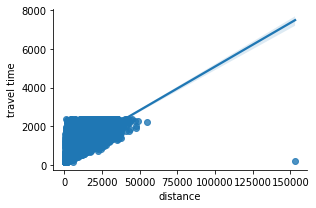

In [5]:
sns.lmplot(x='distance',y='travel time',data=df, height=3, aspect=1.5)

In [6]:
# outlier removal
from scipy import stats
df = df[(np.abs(stats.zscore(df['distance'])) < 3)]

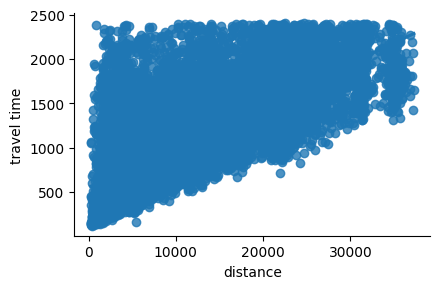

In [7]:
sns.lmplot(x='distance',y='travel time',data=df, height=3, aspect=1.5)

In [8]:
# Normalize using Min/Max Normalization.
normalized_Olat=(df['O lat']-df['O lat'].min())/(df['O lat'].max()-df['O lat'].min())
df['O lat'] = normalized_Olat
normalized_Dlat=(df['D lat']-df['D lat'].min())/(df['D lat'].max()-df['D lat'].min())
df['D lat'] = normalized_Dlat
normalized_Olon=(df['O lon']-df['O lon'].min())/(df['O lon'].max()-df['O lon'].min())
df['O lon'] = normalized_Olon
normalized_Dlon=(df['D lon']-df['D lon'].min())/(df['D lon'].max()-df['D lon'].min())
df['D lon'] = normalized_Dlon
normalized_Dist=(df['distance']-df['distance'].min())/(df['distance'].max()-df['distance'].min())
df['distance'] = normalized_Dist
df['hr_sin'] = np.sin(df['hour of day']*(2.*np.pi/24))
df['hr_cos'] = np.cos(df['hour of day']*(2.*np.pi/24))
df

hour of day     O lat     O lon     D lat     D lon  travel time  \
0               18  0.691367  0.690928  0.780775  0.737316       1165.0   
1               21  0.785427  0.739756  0.780775  0.737336        436.0   
2               19  0.760828  0.790248  0.779938  0.738817        772.0   
3               16  0.787142  0.737654  0.780977  0.737546        606.0   
4               17  0.788667  0.733068  0.781049  0.737576        384.0   
...            ...       ...       ...       ...       ...          ...   
15758           21  0.850762  0.748614  0.946819  0.749214       1662.0   
15759            1  0.867511  0.797510  0.946965  0.749155       1397.0   
15760            2  0.841657  0.755953  0.946916  0.749245       1230.0   
15761           22  0.841301  0.755217  0.946884  0.749225       1202.0   
15762            6  0.945730  0.750717  0.891965  0.777284       1124.0   

       distance    hr_sin        hr_cos  
0      0.578883 -1.000000 -1.836970e-16  
1      0.048963 -0.707107  7.071068e-01  
2      0.268455 -0.965926  2.588190e-01  
3      0.056803 -0.866025 -5.000000e-01  
4      0.076939 -0.965926 -2.588190e-01  
...         ...       ...           ...  
15758  0.657683 -0.707107  7.071068e-01  
15759  0.594228  0.258819  9.659258e-01  
15760  0.593117  0.500000  8.660254e-01  
15761  0.597302 -0.500000  8.660254e-01  
15762  0.392350  1.000000  6.123234e-17  

[15728 rows x 9 columns]

In [9]:
# df['distance'] = df['distance']/1000 #in km
# df['travel time'] = df['travel time']/60 #in minutes
# df

# Functional API keras model

In [10]:
np.random.seed(7)

In [12]:
def nnmodel(*num_neuron,num_hlayers,Epoch):

    if num_hlayers == 1:
        first_input  = Input(shape=(4, ))
        first_dense  = Dense(num_neuron[0], activation='relu')(first_input)
        first_dense = Dense(1, activation='relu', name='distance_layer')(first_dense)
        
        second_input = Input(shape=(X_train.shape[1]-4, ))
        
        merge_two = concatenate([first_dense, second_input])
        second_dense = Dense(num_neuron[1], activation='relu')(merge_two)
        second_dense = Dense(1, activation='relu',name='traveltime_layer')(second_dense)
        
        model = Model(inputs=[first_input, second_input], outputs=[first_dense, second_dense])
    elif num_hlayers == 2:
        first_input  = Input(shape=(4, ))
        first_dense  = Dense(num_neuron[0], activation='relu')(first_input)
        first_dense  = Dense(num_neuron[1], activation='relu')(first_dense)
        first_dense = Dense(1, activation='relu', name='distance_layer')(first_dense)
        second_input = Input(shape=(X_train.shape[1]-4, ))
        
        merge_two = concatenate([first_dense, second_input])
        second_dense = Dense(num_neuron[2], activation='relu')(merge_two)
        second_dense = Dense(num_neuron[3], activation='relu')(second_dense)
        second_dense = Dense(1, activation='relu', name='traveltime_layer')(second_dense)
        
        model = Model(inputs=[first_input, second_input], outputs=[first_dense, second_dense])
    else:
        first_input  = Input(shape=(4, ))
        first_dense  = Dense(num_neuron[0], activation='relu')(first_input)
        first_dense  = Dense(num_neuron[1], activation='relu')(first_dense)
        first_dense  = Dense(num_neuron[2], activation='relu')(first_dense)
        first_dense = Dense(1, activation='relu', name='distance_layer')(first_dense)
        second_input = Input(shape=(X_train.shape[1]-4, ))
        
        merge_two = concatenate([first_dense, second_input])
        second_dense = Dense(num_neuron[3], activation='relu')(merge_two)
        second_dense = Dense(num_neuron[4], activation='relu')(second_dense)
        second_dense = Dense(num_neuron[5], activation='relu')(second_dense)
        second_dense = Dense(1, activation='relu', name='traveltime_layer')(second_dense)
        
        model = Model(inputs=[first_input, second_input], outputs=[first_dense, second_dense])        

#     from keras.optimizers import SGD
#     opt = SGD(lr=0.01)
#     model.compile(loss = "categorical_crossentropy", optimizer = opt)       
        
    learning_rate = 0.05
    model.compile(optimizer='adam',
                  loss=[tf.keras.metrics.mean_squared_error,tf.keras.metrics.mean_squared_error],
                  loss_weights=[0.2,0.8],
                  metrics=['mape',tf.keras.metrics.RootMeanSquaredError(name='rmse')])
#     model.compile(optimizer='adam',
#                   loss=tf.keras.metrics.mean_squared_error,
#                   metrics=['mape',tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    history = model.fit([X_train[:,0:4],X_train[:,4:]], [y_train[:,0],y_train[:,1]], verbose=1, epochs=Epoch,
                   validation_data=([X_test[:,0:4],X_test[:,4:]], [y_test[:,0],y_test[:,1]]))
    print('minimum testing RMSE (distance): ',min(history.history['val_distance_layer_rmse'])/1000)
    print('minimum testing MAPE (distance): ',min(history.history['val_distance_layer_mape'])/100)
    print('-----------------')
    print('minimum testing ravel time): ',min(history.history['val_traveltime_layer_rmse'])/60)
    print('minimum testing MAPE (travel time): ',min(history.history['val_traveltime_layer_mape'])/100)
    return history

## sub-problem 1:     ******* input: [] *********

In [13]:
x = df.loc[:,['O lat','O lon','D lat','D lon']].values
y = df.loc[:,['distance','travel time']].values
# x

In [14]:
#split data into test & train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=42)

In [15]:
print(X_train.shape)
print(X_test.shape)
# X_train

(11009, 4)
(4719, 4)


In [16]:
def plotme(model):

    # Plot the training and validation accuracy and loss at each epoch
    loss1 = [f/60 for f in model.history['traveltime_layer_rmse']]
    val_loss1 = [f/60 for f in model.history['val_traveltime_layer_rmse']]
    loss2 = model.history['traveltime_layer_mape']
    val_loss2 = model.history['val_traveltime_layer_mape']
    val_loss2 = [x+1.8 for x in val_loss2]
    epochs = range(1, len(model.history['loss'])+1)
    plt.figure(figsize=(5, 3))
    plt.plot(epochs, val_loss1, 'r', label='Validation rmse')
    plt.plot(epochs, loss1, 'y', label='Trainnig rmse')
    plt.plot(epochs, val_loss2, 'k', label='Validation mape')
    plt.plot(epochs, loss2, 'b', label='Trainnig mape')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    #plt.xlim(lims)
    yli = max(model.history['val_traveltime_layer_mape'])
    plt.ylim([-1, yli+10])
    plt.legend()
    plt.show()

In [19]:
# inputs: distance
model1_1 = nnmodel(5,5, num_hlayers=1,Epoch=500)
model1_1

Epoch 1/500
345/345 [==============================] - 1s 1ms/step - loss: 1119488.1250 - distance_layer_loss: 12.7305 - traveltime_layer_loss: 1399356.7500 - distance_layer_mape: 361480.0312 - distance_layer_rmse: 3.5680 - traveltime_layer_mape: 99.5343 - traveltime_layer_rmse: 1182.9441 - val_loss: 1138357.8750 - val_distance_layer_loss: 51.0649 - val_traveltime_layer_loss: 1422934.5000 - val_distance_layer_mape: 5982.4678 - val_distance_layer_rmse: 7.1460 - val_traveltime_layer_mape: 98.1572 - val_traveltime_layer_rmse: 1192.8682
Epoch 2/500
345/345 [==============================] - 0s 1ms/step - loss: 1014234.1250 - distance_layer_loss: 234.6331 - traveltime_layer_loss: 1267734.0000 - distance_layer_mape: 682901.7500 - distance_layer_rmse: 15.3177 - traveltime_layer_mape: 91.0496 - traveltime_layer_rmse: 1125.9369 - val_loss: 900772.8750 - val_distance_layer_loss: 549.0682 - val_traveltime_layer_loss: 1125828.6250 - val_distance_layer_mape: 19305.0234 - val_distance_layer_rmse: 23

345/345 [==============================] - 0s 1ms/step - loss: 227503.6094 - distance_layer_loss: 3701.4849 - traveltime_layer_loss: 283454.2500 - distance_layer_mape: 5531245.0000 - distance_layer_rmse: 60.8398 - traveltime_layer_mape: 62.2532 - traveltime_layer_rmse: 532.4042 - val_loss: 238368.5469 - val_distance_layer_loss: 3677.5037 - val_traveltime_layer_loss: 297041.2188 - val_distance_layer_mape: 49703.7500 - val_distance_layer_rmse: 60.6424 - val_traveltime_layer_mape: 62.4695 - val_traveltime_layer_rmse: 545.0149
Epoch 17/500
345/345 [==============================] - 0s 962us/step - loss: 227334.0469 - distance_layer_loss: 3684.5308 - traveltime_layer_loss: 283246.4375 - distance_layer_mape: 5507915.0000 - distance_layer_rmse: 60.7003 - traveltime_layer_mape: 62.1526 - traveltime_layer_rmse: 532.2090 - val_loss: 238303.8594 - val_distance_layer_loss: 3660.5449 - val_traveltime_layer_loss: 296964.6875 - val_distance_layer_mape: 49580.4492 - val_distance_layer_rmse: 60.5024 - 

345/345 [==============================] - 0s 998us/step - loss: 226344.6875 - distance_layer_loss: 3504.5098 - traveltime_layer_loss: 282054.6875 - distance_layer_mape: 5336997.0000 - distance_layer_rmse: 59.1989 - traveltime_layer_mape: 62.3458 - traveltime_layer_rmse: 531.0882 - val_loss: 237344.6875 - val_distance_layer_loss: 3447.5715 - val_traveltime_layer_loss: 295819.0938 - val_distance_layer_mape: 48060.6094 - val_distance_layer_rmse: 58.7160 - val_traveltime_layer_mape: 61.9125 - val_traveltime_layer_rmse: 543.8925
Epoch 32/500
345/345 [==============================] - 0s 965us/step - loss: 226220.7812 - distance_layer_loss: 3477.8945 - traveltime_layer_loss: 281906.6562 - distance_layer_mape: 5332490.5000 - distance_layer_rmse: 58.9737 - traveltime_layer_mape: 62.1002 - traveltime_layer_rmse: 530.9489 - val_loss: 237407.4844 - val_distance_layer_loss: 3421.4341 - val_traveltime_layer_loss: 295904.1562 - val_distance_layer_mape: 47873.7227 - val_distance_layer_rmse: 58.4930 

345/345 [==============================] - 0s 1ms/step - loss: 225060.7656 - distance_layer_loss: 3221.9082 - traveltime_layer_loss: 280520.3750 - distance_layer_mape: 5135439.5000 - distance_layer_rmse: 56.7619 - traveltime_layer_mape: 61.6377 - traveltime_layer_rmse: 529.6417 - val_loss: 235536.1094 - val_distance_layer_loss: 3250.9084 - val_traveltime_layer_loss: 293607.4375 - val_distance_layer_mape: 46608.7773 - val_distance_layer_rmse: 57.0167 - val_traveltime_layer_mape: 62.9706 - val_traveltime_layer_rmse: 541.8555
Epoch 47/500
345/345 [==============================] - 0s 976us/step - loss: 224938.5938 - distance_layer_loss: 3217.5012 - traveltime_layer_loss: 280368.9062 - distance_layer_mape: 5120967.0000 - distance_layer_rmse: 56.7230 - traveltime_layer_mape: 61.9234 - traveltime_layer_rmse: 529.4987 - val_loss: 235939.3906 - val_distance_layer_loss: 3165.8535 - val_traveltime_layer_loss: 294132.7812 - val_distance_layer_mape: 45988.4414 - val_distance_layer_rmse: 56.2659 - 

345/345 [==============================] - 0s 980us/step - loss: 223525.7344 - distance_layer_loss: 2912.5361 - traveltime_layer_loss: 278679.2188 - distance_layer_mape: 4865059.5000 - distance_layer_rmse: 53.9679 - traveltime_layer_mape: 61.4790 - traveltime_layer_rmse: 527.9008 - val_loss: 234278.9219 - val_distance_layer_loss: 2878.3074 - val_traveltime_layer_loss: 292128.9688 - val_distance_layer_mape: 43772.8359 - val_distance_layer_rmse: 53.6499 - val_traveltime_layer_mape: 61.5337 - val_traveltime_layer_rmse: 540.4896
Epoch 62/500
345/345 [==============================] - 0s 971us/step - loss: 223323.8281 - distance_layer_loss: 2884.4568 - traveltime_layer_loss: 278433.8125 - distance_layer_mape: 4838054.5000 - distance_layer_rmse: 53.7071 - traveltime_layer_mape: 61.3350 - traveltime_layer_rmse: 527.6683 - val_loss: 233858.7656 - val_distance_layer_loss: 2891.7373 - val_traveltime_layer_loss: 291600.5938 - val_distance_layer_mape: 43861.5117 - val_distance_layer_rmse: 53.7749 

345/345 [==============================] - 0s 979us/step - loss: 221486.7344 - distance_layer_loss: 2555.4861 - traveltime_layer_loss: 276219.5000 - distance_layer_mape: 4560083.0000 - distance_layer_rmse: 50.5518 - traveltime_layer_mape: 61.2230 - traveltime_layer_rmse: 525.5659 - val_loss: 232134.2031 - val_distance_layer_loss: 2533.7114 - val_traveltime_layer_loss: 289534.3750 - val_distance_layer_mape: 40966.0039 - val_distance_layer_rmse: 50.3360 - val_traveltime_layer_mape: 61.5155 - val_traveltime_layer_rmse: 538.0840
Epoch 77/500
345/345 [==============================] - 0s 988us/step - loss: 221320.4688 - distance_layer_loss: 2529.3943 - traveltime_layer_loss: 276018.2500 - distance_layer_mape: 4475891.0000 - distance_layer_rmse: 50.2931 - traveltime_layer_mape: 61.1882 - traveltime_layer_rmse: 525.3744 - val_loss: 231928.1406 - val_distance_layer_loss: 2512.1636 - val_traveltime_layer_loss: 289282.1250 - val_distance_layer_mape: 40785.3125 - val_distance_layer_rmse: 50.1215 

345/345 [==============================] - 0s 997us/step - loss: 219087.4531 - distance_layer_loss: 2164.5330 - traveltime_layer_loss: 273318.0625 - distance_layer_mape: 4106217.5000 - distance_layer_rmse: 46.5245 - traveltime_layer_mape: 61.0485 - traveltime_layer_rmse: 522.7983 - val_loss: 229924.5938 - val_distance_layer_loss: 2124.1421 - val_traveltime_layer_loss: 286874.5938 - val_distance_layer_mape: 37389.9727 - val_distance_layer_rmse: 46.0884 - val_traveltime_layer_mape: 60.8039 - val_traveltime_layer_rmse: 535.6068
Epoch 92/500
345/345 [==============================] - 0s 1ms/step - loss: 218950.5469 - distance_layer_loss: 2137.5266 - traveltime_layer_loss: 273154.0000 - distance_layer_mape: 4110216.7500 - distance_layer_rmse: 46.2334 - traveltime_layer_mape: 61.0468 - traveltime_layer_rmse: 522.6414 - val_loss: 229525.4844 - val_distance_layer_loss: 2108.7427 - val_traveltime_layer_loss: 286379.6562 - val_distance_layer_mape: 37266.1445 - val_distance_layer_rmse: 45.9210 - 

345/345 [==============================] - 0s 1ms/step - loss: 216266.2344 - distance_layer_loss: 1751.5011 - traveltime_layer_loss: 269894.8438 - distance_layer_mape: 3701873.2500 - distance_layer_rmse: 41.8509 - traveltime_layer_mape: 60.5256 - traveltime_layer_rmse: 519.5140 - val_loss: 226502.7188 - val_distance_layer_loss: 1745.4989 - val_traveltime_layer_loss: 282692.1562 - val_distance_layer_mape: 33756.5117 - val_distance_layer_rmse: 41.7792 - val_traveltime_layer_mape: 61.2367 - val_traveltime_layer_rmse: 531.6880
Epoch 107/500
345/345 [==============================] - 0s 1ms/step - loss: 216112.2500 - distance_layer_loss: 1734.3357 - traveltime_layer_loss: 269706.5625 - distance_layer_mape: 3684889.7500 - distance_layer_rmse: 41.6454 - traveltime_layer_mape: 60.7652 - traveltime_layer_rmse: 519.3328 - val_loss: 226503.9375 - val_distance_layer_loss: 1700.1537 - val_traveltime_layer_loss: 282704.9375 - val_distance_layer_mape: 33309.9414 - val_distance_layer_rmse: 41.2329 - v

345/345 [==============================] - 0s 988us/step - loss: 212676.0469 - distance_layer_loss: 1352.7091 - traveltime_layer_loss: 265506.9062 - distance_layer_mape: 3225220.7500 - distance_layer_rmse: 36.7792 - traveltime_layer_mape: 59.8944 - traveltime_layer_rmse: 515.2736 - val_loss: 222744.5000 - val_distance_layer_loss: 1348.3407 - val_traveltime_layer_loss: 278093.5625 - val_distance_layer_mape: 29497.8320 - val_distance_layer_rmse: 36.7198 - val_traveltime_layer_mape: 60.7089 - val_traveltime_layer_rmse: 527.3458
Epoch 122/500
345/345 [==============================] - 0s 986us/step - loss: 212380.6562 - distance_layer_loss: 1322.9386 - traveltime_layer_loss: 265145.2812 - distance_layer_mape: 3196610.5000 - distance_layer_rmse: 36.3722 - traveltime_layer_mape: 59.7181 - traveltime_layer_rmse: 514.9226 - val_loss: 222427.2812 - val_distance_layer_loss: 1320.9303 - val_traveltime_layer_loss: 277703.9375 - val_distance_layer_mape: 29185.0723 - val_distance_layer_rmse: 36.3446

345/345 [==============================] - 0s 959us/step - loss: 208568.7812 - distance_layer_loss: 1031.0847 - traveltime_layer_loss: 260453.1562 - distance_layer_mape: 2729597.5000 - distance_layer_rmse: 32.1105 - traveltime_layer_mape: 59.3040 - traveltime_layer_rmse: 510.3461 - val_loss: 218371.7031 - val_distance_layer_loss: 1022.9593 - val_traveltime_layer_loss: 272708.7812 - val_distance_layer_mape: 25486.0000 - val_distance_layer_rmse: 31.9837 - val_traveltime_layer_mape: 59.8099 - val_traveltime_layer_rmse: 522.2153
Epoch 137/500
345/345 [==============================] - 0s 954us/step - loss: 208142.4844 - distance_layer_loss: 1006.6071 - traveltime_layer_loss: 259926.5312 - distance_layer_mape: 2705915.2500 - distance_layer_rmse: 31.7271 - traveltime_layer_mape: 58.8973 - traveltime_layer_rmse: 509.8299 - val_loss: 217983.6406 - val_distance_layer_loss: 1019.9657 - val_traveltime_layer_loss: 272224.5625 - val_distance_layer_mape: 25447.9355 - val_distance_layer_rmse: 31.9369

345/345 [==============================] - 0s 969us/step - loss: 204713.8750 - distance_layer_loss: 786.9984 - traveltime_layer_loss: 255695.6094 - distance_layer_mape: 2350850.0000 - distance_layer_rmse: 28.0535 - traveltime_layer_mape: 57.9700 - traveltime_layer_rmse: 505.6635 - val_loss: 214458.8125 - val_distance_layer_loss: 783.6957 - val_traveltime_layer_loss: 267877.6250 - val_distance_layer_mape: 22099.2793 - val_distance_layer_rmse: 27.9946 - val_traveltime_layer_mape: 58.7672 - val_traveltime_layer_rmse: 517.5690
Epoch 152/500
345/345 [==============================] - 0s 978us/step - loss: 204511.1875 - distance_layer_loss: 774.6270 - traveltime_layer_loss: 255445.2812 - distance_layer_mape: 2307106.7500 - distance_layer_rmse: 27.8321 - traveltime_layer_mape: 58.1233 - traveltime_layer_rmse: 505.4160 - val_loss: 214240.2500 - val_distance_layer_loss: 768.5532 - val_traveltime_layer_loss: 267608.0938 - val_distance_layer_mape: 21870.4531 - val_distance_layer_rmse: 27.7228 - v

345/345 [==============================] - 0s 960us/step - loss: 201563.1094 - distance_layer_loss: 604.2908 - traveltime_layer_loss: 251802.7812 - distance_layer_mape: 2028035.1250 - distance_layer_rmse: 24.5823 - traveltime_layer_mape: 56.9260 - traveltime_layer_rmse: 501.7995 - val_loss: 211145.4375 - val_distance_layer_loss: 607.6900 - val_traveltime_layer_loss: 263779.9062 - val_distance_layer_mape: 19255.9785 - val_distance_layer_rmse: 24.6514 - val_traveltime_layer_mape: 58.0464 - val_traveltime_layer_rmse: 513.5951
Epoch 167/500
345/345 [==============================] - 0s 956us/step - loss: 201294.0781 - distance_layer_loss: 594.6403 - traveltime_layer_loss: 251468.9219 - distance_layer_mape: 2000427.3750 - distance_layer_rmse: 24.3852 - traveltime_layer_mape: 56.8101 - traveltime_layer_rmse: 501.4668 - val_loss: 210941.3750 - val_distance_layer_loss: 607.6033 - val_traveltime_layer_loss: 263524.7812 - val_distance_layer_mape: 19241.1133 - val_distance_layer_rmse: 24.6496 - v

345/345 [==============================] - 0s 997us/step - loss: 199572.0625 - distance_layer_loss: 488.4572 - traveltime_layer_loss: 249343.0938 - distance_layer_mape: 1745521.2500 - distance_layer_rmse: 22.1011 - traveltime_layer_mape: 56.3361 - traveltime_layer_rmse: 499.3427 - val_loss: 209175.4688 - val_distance_layer_loss: 504.6346 - val_traveltime_layer_loss: 261343.0781 - val_distance_layer_mape: 17377.8105 - val_distance_layer_rmse: 22.4641 - val_traveltime_layer_mape: 58.4588 - val_traveltime_layer_rmse: 511.2173
Epoch 182/500
345/345 [==============================] - 0s 981us/step - loss: 199355.1406 - distance_layer_loss: 483.6848 - traveltime_layer_loss: 249073.1250 - distance_layer_mape: 1764575.7500 - distance_layer_rmse: 21.9928 - traveltime_layer_mape: 56.3157 - traveltime_layer_rmse: 499.0723 - val_loss: 209304.9219 - val_distance_layer_loss: 476.5695 - val_traveltime_layer_loss: 261512.0000 - val_distance_layer_mape: 16851.8711 - val_distance_layer_rmse: 21.8305 - v

345/345 [==============================] - 0s 976us/step - loss: 198488.5938 - distance_layer_loss: 416.2139 - traveltime_layer_loss: 248006.6406 - distance_layer_mape: 1607450.2500 - distance_layer_rmse: 20.4013 - traveltime_layer_mape: 55.4523 - traveltime_layer_rmse: 498.0027 - val_loss: 207971.5938 - val_distance_layer_loss: 422.3147 - val_traveltime_layer_loss: 259858.9375 - val_distance_layer_mape: 15762.2207 - val_distance_layer_rmse: 20.5503 - val_traveltime_layer_mape: 56.7800 - val_traveltime_layer_rmse: 509.7636
Epoch 197/500
345/345 [==============================] - 0s 979us/step - loss: 198367.3281 - distance_layer_loss: 412.5546 - traveltime_layer_loss: 247855.9531 - distance_layer_mape: 1604730.3750 - distance_layer_rmse: 20.3114 - traveltime_layer_mape: 55.4020 - traveltime_layer_rmse: 497.8513 - val_loss: 208026.5938 - val_distance_layer_loss: 429.8130 - val_traveltime_layer_loss: 259925.8438 - val_distance_layer_mape: 15906.1699 - val_distance_layer_rmse: 20.7319 - v

345/345 [==============================] - 0s 997us/step - loss: 197916.9219 - distance_layer_loss: 376.1921 - traveltime_layer_loss: 247302.0000 - distance_layer_mape: 1488158.1250 - distance_layer_rmse: 19.3957 - traveltime_layer_mape: 55.1349 - traveltime_layer_rmse: 497.2947 - val_loss: 207420.1406 - val_distance_layer_loss: 382.2762 - val_traveltime_layer_loss: 259179.6562 - val_distance_layer_mape: 14909.6855 - val_distance_layer_rmse: 19.5519 - val_traveltime_layer_mape: 56.4393 - val_traveltime_layer_rmse: 509.0969
Epoch 212/500
345/345 [==============================] - 0s 922us/step - loss: 197626.9375 - distance_layer_loss: 376.0281 - traveltime_layer_loss: 246939.5000 - distance_layer_mape: 1527582.7500 - distance_layer_rmse: 19.3914 - traveltime_layer_mape: 55.3092 - traveltime_layer_rmse: 496.9301 - val_loss: 207776.2344 - val_distance_layer_loss: 370.6020 - val_traveltime_layer_loss: 259627.7031 - val_distance_layer_mape: 14661.0498 - val_distance_layer_rmse: 19.2510 - v

345/345 [==============================] - 0s 957us/step - loss: 197562.5625 - distance_layer_loss: 352.3503 - traveltime_layer_loss: 246865.1562 - distance_layer_mape: 1445608.3750 - distance_layer_rmse: 18.7710 - traveltime_layer_mape: 54.7291 - traveltime_layer_rmse: 496.8553 - val_loss: 207492.0000 - val_distance_layer_loss: 370.6009 - val_traveltime_layer_loss: 259272.2656 - val_distance_layer_mape: 14661.1279 - val_distance_layer_rmse: 19.2510 - val_traveltime_layer_mape: 57.4529 - val_traveltime_layer_rmse: 509.1878
Epoch 227/500
345/345 [==============================] - 0s 986us/step - loss: 197571.4219 - distance_layer_loss: 355.5186 - traveltime_layer_loss: 246875.4531 - distance_layer_mape: 1459575.1250 - distance_layer_rmse: 18.8552 - traveltime_layer_mape: 55.1873 - traveltime_layer_rmse: 496.8656 - val_loss: 207547.8906 - val_distance_layer_loss: 349.4060 - val_traveltime_layer_loss: 259347.5000 - val_distance_layer_mape: 14186.4561 - val_distance_layer_rmse: 18.6924 - v

345/345 [==============================] - 0s 972us/step - loss: 197237.0781 - distance_layer_loss: 339.8819 - traveltime_layer_loss: 246461.2656 - distance_layer_mape: 1428987.1250 - distance_layer_rmse: 18.4359 - traveltime_layer_mape: 54.7578 - traveltime_layer_rmse: 496.4486 - val_loss: 207240.4688 - val_distance_layer_loss: 337.5498 - val_traveltime_layer_loss: 258966.3281 - val_distance_layer_mape: 13919.9756 - val_distance_layer_rmse: 18.3725 - val_traveltime_layer_mape: 55.0499 - val_traveltime_layer_rmse: 508.8873
Epoch 242/500
345/345 [==============================] - 0s 939us/step - loss: 197187.1875 - distance_layer_loss: 339.4012 - traveltime_layer_loss: 246399.0312 - distance_layer_mape: 1408963.5000 - distance_layer_rmse: 18.4228 - traveltime_layer_mape: 54.8235 - traveltime_layer_rmse: 496.3860 - val_loss: 207099.1250 - val_distance_layer_loss: 349.9356 - val_traveltime_layer_loss: 258786.4688 - val_distance_layer_mape: 14203.6406 - val_distance_layer_rmse: 18.7066 - v

345/345 [==============================] - 0s 1ms/step - loss: 197042.2344 - distance_layer_loss: 330.7515 - traveltime_layer_loss: 246220.3125 - distance_layer_mape: 1406881.0000 - distance_layer_rmse: 18.1866 - traveltime_layer_mape: 54.6613 - traveltime_layer_rmse: 496.2059 - val_loss: 206905.4688 - val_distance_layer_loss: 334.8907 - val_traveltime_layer_loss: 258548.0312 - val_distance_layer_mape: 13863.1221 - val_distance_layer_rmse: 18.3000 - val_traveltime_layer_mape: 55.7639 - val_traveltime_layer_rmse: 508.4762
Epoch 257/500
345/345 [==============================] - 0s 963us/step - loss: 197013.6094 - distance_layer_loss: 329.8453 - traveltime_layer_loss: 246184.5000 - distance_layer_mape: 1387713.5000 - distance_layer_rmse: 18.1616 - traveltime_layer_mape: 54.5451 - traveltime_layer_rmse: 496.1698 - val_loss: 207671.6875 - val_distance_layer_loss: 348.3110 - val_traveltime_layer_loss: 259502.5781 - val_distance_layer_mape: 14189.3145 - val_distance_layer_rmse: 18.6631 - val

345/345 [==============================] - 0s 951us/step - loss: 196959.4844 - distance_layer_loss: 323.4912 - traveltime_layer_loss: 246118.5469 - distance_layer_mape: 1371024.2500 - distance_layer_rmse: 17.9859 - traveltime_layer_mape: 54.6364 - traveltime_layer_rmse: 496.1034 - val_loss: 206990.3906 - val_distance_layer_loss: 320.7577 - val_traveltime_layer_loss: 258657.7344 - val_distance_layer_mape: 13543.1494 - val_distance_layer_rmse: 17.9097 - val_traveltime_layer_mape: 54.7977 - val_traveltime_layer_rmse: 508.5840
Epoch 272/500
345/345 [==============================] - 0s 979us/step - loss: 196872.2500 - distance_layer_loss: 322.5420 - traveltime_layer_loss: 246009.5625 - distance_layer_mape: 1379596.8750 - distance_layer_rmse: 17.9595 - traveltime_layer_mape: 54.4923 - traveltime_layer_rmse: 495.9935 - val_loss: 206602.7188 - val_distance_layer_loss: 330.0495 - val_traveltime_layer_loss: 258170.8750 - val_distance_layer_mape: 13751.2070 - val_distance_layer_rmse: 18.1673 - v

345/345 [==============================] - 0s 944us/step - loss: 196687.1719 - distance_layer_loss: 320.1862 - traveltime_layer_loss: 245778.9219 - distance_layer_mape: 1376878.3750 - distance_layer_rmse: 17.8937 - traveltime_layer_mape: 54.6682 - traveltime_layer_rmse: 495.7610 - val_loss: 207023.4062 - val_distance_layer_loss: 314.2358 - val_traveltime_layer_loss: 258700.5312 - val_distance_layer_mape: 13393.7520 - val_distance_layer_rmse: 17.7267 - val_traveltime_layer_mape: 54.4895 - val_traveltime_layer_rmse: 508.6261
Epoch 287/500
345/345 [==============================] - 0s 978us/step - loss: 196756.9219 - distance_layer_loss: 318.1266 - traveltime_layer_loss: 245866.5469 - distance_layer_mape: 1357968.8750 - distance_layer_rmse: 17.8361 - traveltime_layer_mape: 54.3974 - traveltime_layer_rmse: 495.8493 - val_loss: 206484.8438 - val_distance_layer_loss: 324.4720 - val_traveltime_layer_loss: 258024.8906 - val_distance_layer_mape: 13632.5352 - val_distance_layer_rmse: 18.0131 - v

345/345 [==============================] - 0s 951us/step - loss: 196480.0156 - distance_layer_loss: 316.1806 - traveltime_layer_loss: 245520.9688 - distance_layer_mape: 1378438.8750 - distance_layer_rmse: 17.7815 - traveltime_layer_mape: 54.5878 - traveltime_layer_rmse: 495.5007 - val_loss: 207056.6406 - val_distance_layer_loss: 309.8633 - val_traveltime_layer_loss: 258743.2188 - val_distance_layer_mape: 13291.3740 - val_distance_layer_rmse: 17.6029 - val_traveltime_layer_mape: 54.3107 - val_traveltime_layer_rmse: 508.6681
Epoch 302/500
345/345 [==============================] - 0s 971us/step - loss: 196614.7969 - distance_layer_loss: 315.6323 - traveltime_layer_loss: 245689.6562 - distance_layer_mape: 1371162.6250 - distance_layer_rmse: 17.7660 - traveltime_layer_mape: 54.4872 - traveltime_layer_rmse: 495.6709 - val_loss: 206609.2031 - val_distance_layer_loss: 315.9957 - val_traveltime_layer_loss: 258182.3125 - val_distance_layer_mape: 13431.6914 - val_distance_layer_rmse: 17.7763 - v

345/345 [==============================] - 0s 953us/step - loss: 196409.2500 - distance_layer_loss: 313.2187 - traveltime_layer_loss: 245433.3125 - distance_layer_mape: 1344991.2500 - distance_layer_rmse: 17.6980 - traveltime_layer_mape: 54.6782 - traveltime_layer_rmse: 495.4123 - val_loss: 207465.3750 - val_distance_layer_loss: 304.0575 - val_traveltime_layer_loss: 259255.8438 - val_distance_layer_mape: 13179.4570 - val_distance_layer_rmse: 17.4372 - val_traveltime_layer_mape: 54.1794 - val_traveltime_layer_rmse: 509.1717
Epoch 317/500
345/345 [==============================] - 0s 995us/step - loss: 196604.5625 - distance_layer_loss: 310.9130 - traveltime_layer_loss: 245678.2656 - distance_layer_mape: 1349173.2500 - distance_layer_rmse: 17.6327 - traveltime_layer_mape: 54.4682 - traveltime_layer_rmse: 495.6594 - val_loss: 206487.0625 - val_distance_layer_loss: 313.5725 - val_traveltime_layer_loss: 258030.4219 - val_distance_layer_mape: 13379.1748 - val_distance_layer_rmse: 17.7080 - v

345/345 [==============================] - 0s 1ms/step - loss: 196511.5469 - distance_layer_loss: 308.8119 - traveltime_layer_loss: 245562.3438 - distance_layer_mape: 1340774.1250 - distance_layer_rmse: 17.5730 - traveltime_layer_mape: 54.6336 - traveltime_layer_rmse: 495.5425 - val_loss: 206776.2656 - val_distance_layer_loss: 303.0461 - val_traveltime_layer_loss: 258394.5625 - val_distance_layer_mape: 13137.1387 - val_distance_layer_rmse: 17.4082 - val_traveltime_layer_mape: 54.4078 - val_traveltime_layer_rmse: 508.3253
Epoch 332/500
345/345 [==============================] - 0s 953us/step - loss: 196452.2969 - distance_layer_loss: 306.2882 - traveltime_layer_loss: 245488.6562 - distance_layer_mape: 1332922.8750 - distance_layer_rmse: 17.5011 - traveltime_layer_mape: 54.3232 - traveltime_layer_rmse: 495.4681 - val_loss: 207007.5938 - val_distance_layer_loss: 301.3884 - val_traveltime_layer_loss: 258684.2031 - val_distance_layer_mape: 13107.6553 - val_distance_layer_rmse: 17.3605 - val

345/345 [==============================] - 0s 1ms/step - loss: 196479.9219 - distance_layer_loss: 305.9806 - traveltime_layer_loss: 245523.4375 - distance_layer_mape: 1357645.0000 - distance_layer_rmse: 17.4923 - traveltime_layer_mape: 54.4318 - traveltime_layer_rmse: 495.5032 - val_loss: 206394.0938 - val_distance_layer_loss: 314.6344 - val_traveltime_layer_loss: 257913.9219 - val_distance_layer_mape: 13414.8750 - val_distance_layer_rmse: 17.7379 - val_traveltime_layer_mape: 56.1781 - val_traveltime_layer_rmse: 507.8523
Epoch 347/500
345/345 [==============================] - 0s 1ms/step - loss: 196239.4531 - distance_layer_loss: 306.2688 - traveltime_layer_loss: 245223.0469 - distance_layer_mape: 1340112.1250 - distance_layer_rmse: 17.5005 - traveltime_layer_mape: 54.4095 - traveltime_layer_rmse: 495.2000 - val_loss: 206161.0781 - val_distance_layer_loss: 310.8690 - val_traveltime_layer_loss: 257623.7500 - val_distance_layer_mape: 13321.4043 - val_distance_layer_rmse: 17.6315 - val_t

345/345 [==============================] - 0s 927us/step - loss: 196436.7344 - distance_layer_loss: 304.2705 - traveltime_layer_loss: 245469.8438 - distance_layer_mape: 1337040.0000 - distance_layer_rmse: 17.4434 - traveltime_layer_mape: 54.5737 - traveltime_layer_rmse: 495.4491 - val_loss: 206093.0938 - val_distance_layer_loss: 312.2570 - val_traveltime_layer_loss: 257538.3125 - val_distance_layer_mape: 13354.7129 - val_distance_layer_rmse: 17.6708 - val_traveltime_layer_mape: 56.1755 - val_traveltime_layer_rmse: 507.4823
Epoch 362/500
345/345 [==============================] - 0s 965us/step - loss: 196408.5938 - distance_layer_loss: 303.7413 - traveltime_layer_loss: 245434.7812 - distance_layer_mape: 1338887.1250 - distance_layer_rmse: 17.4282 - traveltime_layer_mape: 54.5481 - traveltime_layer_rmse: 495.4138 - val_loss: 206492.6562 - val_distance_layer_loss: 301.4825 - val_traveltime_layer_loss: 258040.4531 - val_distance_layer_mape: 13100.6270 - val_distance_layer_rmse: 17.3633 - v

345/345 [==============================] - 0s 976us/step - loss: 196321.0312 - distance_layer_loss: 300.4221 - traveltime_layer_loss: 245326.2656 - distance_layer_mape: 1329533.1250 - distance_layer_rmse: 17.3327 - traveltime_layer_mape: 54.2123 - traveltime_layer_rmse: 495.3042 - val_loss: 206104.7500 - val_distance_layer_loss: 306.2497 - val_traveltime_layer_loss: 257554.4219 - val_distance_layer_mape: 13223.4961 - val_distance_layer_rmse: 17.5000 - val_traveltime_layer_mape: 55.6007 - val_traveltime_layer_rmse: 507.4982
Epoch 377/500
345/345 [==============================] - 0s 928us/step - loss: 196310.2656 - distance_layer_loss: 302.6493 - traveltime_layer_loss: 245312.1875 - distance_layer_mape: 1303882.2500 - distance_layer_rmse: 17.3968 - traveltime_layer_mape: 54.6041 - traveltime_layer_rmse: 495.2900 - val_loss: 206171.9688 - val_distance_layer_loss: 304.1189 - val_traveltime_layer_loss: 257639.0469 - val_distance_layer_mape: 13173.0752 - val_distance_layer_rmse: 17.4390 - v

345/345 [==============================] - 0s 967us/step - loss: 196232.6875 - distance_layer_loss: 299.9500 - traveltime_layer_loss: 245216.0469 - distance_layer_mape: 1305739.3750 - distance_layer_rmse: 17.3191 - traveltime_layer_mape: 54.3395 - traveltime_layer_rmse: 495.1929 - val_loss: 206842.8281 - val_distance_layer_loss: 310.3958 - val_traveltime_layer_loss: 258475.8281 - val_distance_layer_mape: 13339.1279 - val_distance_layer_rmse: 17.6181 - val_traveltime_layer_mape: 56.4645 - val_traveltime_layer_rmse: 508.4052
Epoch 392/500
345/345 [==============================] - 0s 975us/step - loss: 196269.4688 - distance_layer_loss: 300.5556 - traveltime_layer_loss: 245261.6562 - distance_layer_mape: 1327862.8750 - distance_layer_rmse: 17.3365 - traveltime_layer_mape: 54.4703 - traveltime_layer_rmse: 495.2390 - val_loss: 206218.9219 - val_distance_layer_loss: 301.4770 - val_traveltime_layer_loss: 257698.1719 - val_distance_layer_mape: 13105.1377 - val_distance_layer_rmse: 17.3631 - v

345/345 [==============================] - 0s 991us/step - loss: 196018.5469 - distance_layer_loss: 297.9138 - traveltime_layer_loss: 244948.6719 - distance_layer_mape: 1325220.6250 - distance_layer_rmse: 17.2602 - traveltime_layer_mape: 54.2366 - traveltime_layer_rmse: 494.9229 - val_loss: 206117.3906 - val_distance_layer_loss: 313.8868 - val_traveltime_layer_loss: 257568.2812 - val_distance_layer_mape: 13400.3389 - val_distance_layer_rmse: 17.7169 - val_traveltime_layer_mape: 57.0527 - val_traveltime_layer_rmse: 507.5118
Epoch 407/500
345/345 [==============================] - 0s 980us/step - loss: 196306.7188 - distance_layer_loss: 300.7471 - traveltime_layer_loss: 245308.2812 - distance_layer_mape: 1343514.7500 - distance_layer_rmse: 17.3421 - traveltime_layer_mape: 54.7155 - traveltime_layer_rmse: 495.2861 - val_loss: 206066.3906 - val_distance_layer_loss: 303.1122 - val_traveltime_layer_loss: 257507.2812 - val_distance_layer_mape: 13147.1377 - val_distance_layer_rmse: 17.4101 - v

345/345 [==============================] - 0s 974us/step - loss: 196028.8906 - distance_layer_loss: 296.0464 - traveltime_layer_loss: 244962.2656 - distance_layer_mape: 1277361.2500 - distance_layer_rmse: 17.2060 - traveltime_layer_mape: 54.3820 - traveltime_layer_rmse: 494.9366 - val_loss: 206191.4844 - val_distance_layer_loss: 311.2830 - val_traveltime_layer_loss: 257661.6094 - val_distance_layer_mape: 13340.4014 - val_distance_layer_rmse: 17.6432 - val_traveltime_layer_mape: 57.1127 - val_traveltime_layer_rmse: 507.6038
Epoch 422/500
345/345 [==============================] - 0s 957us/step - loss: 196284.8125 - distance_layer_loss: 296.6429 - traveltime_layer_loss: 245281.9062 - distance_layer_mape: 1362006.0000 - distance_layer_rmse: 17.2233 - traveltime_layer_mape: 54.6225 - traveltime_layer_rmse: 495.2594 - val_loss: 206154.4375 - val_distance_layer_loss: 296.3474 - val_traveltime_layer_loss: 257618.8906 - val_distance_layer_mape: 12984.7129 - val_distance_layer_rmse: 17.2147 - v

345/345 [==============================] - 0s 957us/step - loss: 196041.8125 - distance_layer_loss: 296.6650 - traveltime_layer_loss: 244978.1250 - distance_layer_mape: 1321999.7500 - distance_layer_rmse: 17.2240 - traveltime_layer_mape: 54.4098 - traveltime_layer_rmse: 494.9526 - val_loss: 206105.7500 - val_distance_layer_loss: 304.5214 - val_traveltime_layer_loss: 257556.1875 - val_distance_layer_mape: 13186.5215 - val_distance_layer_rmse: 17.4505 - val_traveltime_layer_mape: 56.1295 - val_traveltime_layer_rmse: 507.4999
Epoch 437/500
345/345 [==============================] - 0s 943us/step - loss: 196180.2500 - distance_layer_loss: 297.0258 - traveltime_layer_loss: 245150.9688 - distance_layer_mape: 1305029.1250 - distance_layer_rmse: 17.2344 - traveltime_layer_mape: 54.5363 - traveltime_layer_rmse: 495.1272 - val_loss: 205977.2500 - val_distance_layer_loss: 298.7276 - val_traveltime_layer_loss: 257396.9062 - val_distance_layer_mape: 13051.0830 - val_distance_layer_rmse: 17.2837 - v

345/345 [==============================] - 0s 1ms/step - loss: 195894.4062 - distance_layer_loss: 297.2983 - traveltime_layer_loss: 244793.6875 - distance_layer_mape: 1324931.1250 - distance_layer_rmse: 17.2423 - traveltime_layer_mape: 54.5954 - traveltime_layer_rmse: 494.7663 - val_loss: 206959.9688 - val_distance_layer_loss: 286.9220 - val_traveltime_layer_loss: 258628.1875 - val_distance_layer_mape: 12759.0469 - val_distance_layer_rmse: 16.9388 - val_traveltime_layer_mape: 53.8340 - val_traveltime_layer_rmse: 508.5550
Epoch 452/500
345/345 [==============================] - 0s 1ms/step - loss: 195984.2188 - distance_layer_loss: 293.6656 - traveltime_layer_loss: 244906.7969 - distance_layer_mape: 1285224.8750 - distance_layer_rmse: 17.1367 - traveltime_layer_mape: 54.0432 - traveltime_layer_rmse: 494.8806 - val_loss: 205886.8594 - val_distance_layer_loss: 303.9564 - val_traveltime_layer_loss: 257282.6562 - val_distance_layer_mape: 13169.9961 - val_distance_layer_rmse: 17.4343 - val_t

345/345 [==============================] - 0s 1ms/step - loss: 196206.2500 - distance_layer_loss: 294.9019 - traveltime_layer_loss: 245184.0312 - distance_layer_mape: 1321679.6250 - distance_layer_rmse: 17.1727 - traveltime_layer_mape: 54.6122 - traveltime_layer_rmse: 495.1606 - val_loss: 205970.2031 - val_distance_layer_loss: 294.9992 - val_traveltime_layer_loss: 257389.0469 - val_distance_layer_mape: 12960.0000 - val_distance_layer_rmse: 17.1755 - val_traveltime_layer_mape: 55.1666 - val_traveltime_layer_rmse: 507.3352
Epoch 467/500
345/345 [==============================] - 0s 1ms/step - loss: 195903.0000 - distance_layer_loss: 293.0338 - traveltime_layer_loss: 244805.6719 - distance_layer_mape: 1304502.5000 - distance_layer_rmse: 17.1182 - traveltime_layer_mape: 54.2946 - traveltime_layer_rmse: 494.7784 - val_loss: 206270.0938 - val_distance_layer_loss: 306.4316 - val_traveltime_layer_loss: 257761.0312 - val_distance_layer_mape: 13238.3857 - val_distance_layer_rmse: 17.5052 - val_t

345/345 [==============================] - 0s 936us/step - loss: 195990.3594 - distance_layer_loss: 291.3644 - traveltime_layer_loss: 244915.0312 - distance_layer_mape: 1309054.3750 - distance_layer_rmse: 17.0694 - traveltime_layer_mape: 54.2860 - traveltime_layer_rmse: 494.8889 - val_loss: 206165.2969 - val_distance_layer_loss: 290.6261 - val_traveltime_layer_loss: 257634.0469 - val_distance_layer_mape: 12852.5811 - val_distance_layer_rmse: 17.0478 - val_traveltime_layer_mape: 54.7518 - val_traveltime_layer_rmse: 507.5766
Epoch 482/500
345/345 [==============================] - 0s 977us/step - loss: 195846.7188 - distance_layer_loss: 291.7087 - traveltime_layer_loss: 244735.2969 - distance_layer_mape: 1294646.6250 - distance_layer_rmse: 17.0795 - traveltime_layer_mape: 54.3257 - traveltime_layer_rmse: 494.7073 - val_loss: 206032.6406 - val_distance_layer_loss: 303.2733 - val_traveltime_layer_loss: 257465.0469 - val_distance_layer_mape: 13159.7119 - val_distance_layer_rmse: 17.4147 - v

345/345 [==============================] - 0s 971us/step - loss: 195929.0781 - distance_layer_loss: 292.3083 - traveltime_layer_loss: 244838.3125 - distance_layer_mape: 1300409.3750 - distance_layer_rmse: 17.0970 - traveltime_layer_mape: 54.7501 - traveltime_layer_rmse: 494.8114 - val_loss: 206972.0625 - val_distance_layer_loss: 279.5513 - val_traveltime_layer_loss: 258645.1719 - val_distance_layer_mape: 12587.6777 - val_distance_layer_rmse: 16.7198 - val_traveltime_layer_mape: 53.5326 - val_traveltime_layer_rmse: 508.5717
Epoch 497/500
345/345 [==============================] - 0s 979us/step - loss: 195853.2031 - distance_layer_loss: 287.9134 - traveltime_layer_loss: 244744.4375 - distance_layer_mape: 1263218.8750 - distance_layer_rmse: 16.9680 - traveltime_layer_mape: 54.0464 - traveltime_layer_rmse: 494.7165 - val_loss: 206081.1406 - val_distance_layer_loss: 289.0426 - val_traveltime_layer_loss: 257529.2500 - val_distance_layer_mape: 12829.0059 - val_distance_layer_rmse: 17.0013 - v

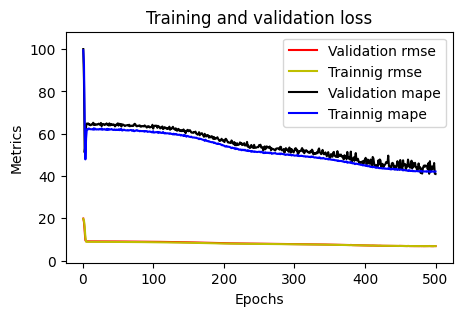

In [18]:
plotme(model1_1)

In [20]:
# inputs: distance
model1_3 = nnmodel(5,10, num_hlayers=1,Epoch=500)
model1_3

Epoch 1/500
345/345 [==============================] - 1s 1ms/step - loss: 1114133.3750 - distance_layer_loss: 4.7829 - traveltime_layer_loss: 1392665.6250 - distance_layer_mape: 155497.8281 - distance_layer_rmse: 2.1870 - traveltime_layer_mape: 99.1287 - traveltime_layer_rmse: 1180.1125 - val_loss: 1120319.8750 - val_distance_layer_loss: 19.1113 - val_traveltime_layer_loss: 1400394.7500 - val_distance_layer_mape: 3711.8953 - val_distance_layer_rmse: 4.3716 - val_traveltime_layer_mape: 96.7873 - val_traveltime_layer_rmse: 1183.3828
Epoch 2/500
345/345 [==============================] - 0s 954us/step - loss: 971357.2500 - distance_layer_loss: 77.8300 - traveltime_layer_loss: 1214177.2500 - distance_layer_mape: 960219.9375 - distance_layer_rmse: 8.8221 - traveltime_layer_mape: 87.5915 - traveltime_layer_rmse: 1101.8971 - val_loss: 831263.7500 - val_distance_layer_loss: 173.9131 - val_traveltime_layer_loss: 1039036.1250 - val_distance_layer_mape: 10927.3701 - val_distance_layer_rmse: 13.1

345/345 [==============================] - 0s 987us/step - loss: 226772.8594 - distance_layer_loss: 845.1740 - traveltime_layer_loss: 283254.8125 - distance_layer_mape: 2637130.7500 - distance_layer_rmse: 29.0719 - traveltime_layer_mape: 62.2834 - traveltime_layer_rmse: 532.2169 - val_loss: 237667.2188 - val_distance_layer_loss: 838.7507 - val_traveltime_layer_loss: 296874.3750 - val_distance_layer_mape: 23806.7285 - val_distance_layer_rmse: 28.9612 - val_traveltime_layer_mape: 62.3259 - val_traveltime_layer_rmse: 544.8618
Epoch 17/500
345/345 [==============================] - 0s 979us/step - loss: 226617.3906 - distance_layer_loss: 843.0737 - traveltime_layer_loss: 283060.9688 - distance_layer_mape: 2661392.2500 - distance_layer_rmse: 29.0357 - traveltime_layer_mape: 62.2130 - traveltime_layer_rmse: 532.0347 - val_loss: 237462.2188 - val_distance_layer_loss: 839.8705 - val_traveltime_layer_loss: 296617.7500 - val_distance_layer_mape: 23820.1543 - val_distance_layer_rmse: 28.9805 - va

345/345 [==============================] - 0s 964us/step - loss: 225094.2969 - distance_layer_loss: 812.1898 - traveltime_layer_loss: 281164.8750 - distance_layer_mape: 2591122.7500 - distance_layer_rmse: 28.4989 - traveltime_layer_mape: 61.8985 - traveltime_layer_rmse: 530.2498 - val_loss: 235901.8594 - val_distance_layer_loss: 809.1854 - val_traveltime_layer_loss: 294674.9688 - val_distance_layer_mape: 23343.2500 - val_distance_layer_rmse: 28.4462 - val_traveltime_layer_mape: 62.3388 - val_traveltime_layer_rmse: 542.8397
Epoch 32/500
345/345 [==============================] - 0s 955us/step - loss: 224979.7188 - distance_layer_loss: 808.9255 - traveltime_layer_loss: 281022.3438 - distance_layer_mape: 2584852.0000 - distance_layer_rmse: 28.4416 - traveltime_layer_mape: 61.8540 - traveltime_layer_rmse: 530.1154 - val_loss: 235826.7812 - val_distance_layer_loss: 805.6375 - val_traveltime_layer_loss: 294582.1250 - val_distance_layer_mape: 23284.0215 - val_distance_layer_rmse: 28.3838 - va

345/345 [==============================] - 0s 955us/step - loss: 223142.3125 - distance_layer_loss: 754.2953 - traveltime_layer_loss: 278739.3750 - distance_layer_mape: 2483219.7500 - distance_layer_rmse: 27.4644 - traveltime_layer_mape: 61.5734 - traveltime_layer_rmse: 527.9578 - val_loss: 233755.5000 - val_distance_layer_loss: 757.0487 - val_traveltime_layer_loss: 292005.1250 - val_distance_layer_mape: 22520.2910 - val_distance_layer_rmse: 27.5145 - val_traveltime_layer_mape: 62.4981 - val_traveltime_layer_rmse: 540.3750
Epoch 47/500
345/345 [==============================] - 0s 982us/step - loss: 222987.7500 - distance_layer_loss: 751.0811 - traveltime_layer_loss: 278546.9062 - distance_layer_mape: 2476446.0000 - distance_layer_rmse: 27.4059 - traveltime_layer_mape: 61.6763 - traveltime_layer_rmse: 527.7755 - val_loss: 233478.1250 - val_distance_layer_loss: 756.1586 - val_traveltime_layer_loss: 291658.5938 - val_distance_layer_mape: 22505.4844 - val_distance_layer_rmse: 27.4983 - va

345/345 [==============================] - 0s 1ms/step - loss: 220936.8594 - distance_layer_loss: 675.4356 - traveltime_layer_loss: 276002.2812 - distance_layer_mape: 2337811.2500 - distance_layer_rmse: 25.9891 - traveltime_layer_mape: 61.2358 - traveltime_layer_rmse: 525.3592 - val_loss: 231490.4219 - val_distance_layer_loss: 676.3561 - val_traveltime_layer_loss: 289193.8438 - val_distance_layer_mape: 21226.8535 - val_distance_layer_rmse: 26.0068 - val_traveltime_layer_mape: 62.1058 - val_traveltime_layer_rmse: 537.7675
Epoch 62/500
345/345 [==============================] - 0s 987us/step - loss: 220847.9219 - distance_layer_loss: 670.9565 - traveltime_layer_loss: 275892.0938 - distance_layer_mape: 2321215.2500 - distance_layer_rmse: 25.9028 - traveltime_layer_mape: 61.3307 - traveltime_layer_rmse: 525.2543 - val_loss: 231473.3594 - val_distance_layer_loss: 666.5206 - val_traveltime_layer_loss: 289175.0938 - val_distance_layer_mape: 21067.8379 - val_distance_layer_rmse: 25.8171 - val_

345/345 [==============================] - 0s 995us/step - loss: 218558.6562 - distance_layer_loss: 585.5351 - traveltime_layer_loss: 273052.0000 - distance_layer_mape: 2168335.2500 - distance_layer_rmse: 24.1978 - traveltime_layer_mape: 60.8368 - traveltime_layer_rmse: 522.5438 - val_loss: 229161.2031 - val_distance_layer_loss: 595.3018 - val_traveltime_layer_loss: 286302.7500 - val_distance_layer_mape: 19843.0859 - val_distance_layer_rmse: 24.3988 - val_traveltime_layer_mape: 62.6432 - val_traveltime_layer_rmse: 535.0726
Epoch 77/500
345/345 [==============================] - 0s 988us/step - loss: 218461.6406 - distance_layer_loss: 583.9724 - traveltime_layer_loss: 272931.0625 - distance_layer_mape: 2152057.7500 - distance_layer_rmse: 24.1655 - traveltime_layer_mape: 61.3179 - traveltime_layer_rmse: 522.4280 - val_loss: 229190.3594 - val_distance_layer_loss: 575.4969 - val_traveltime_layer_loss: 286344.0000 - val_distance_layer_mape: 19510.3340 - val_distance_layer_rmse: 23.9895 - va

345/345 [==============================] - 0s 957us/step - loss: 216092.1406 - distance_layer_loss: 494.1750 - traveltime_layer_loss: 269991.5938 - distance_layer_mape: 1974039.2500 - distance_layer_rmse: 22.2300 - traveltime_layer_mape: 60.4365 - traveltime_layer_rmse: 519.6072 - val_loss: 226883.1719 - val_distance_layer_loss: 490.6169 - val_traveltime_layer_loss: 283481.3438 - val_distance_layer_mape: 17950.9727 - val_distance_layer_rmse: 22.1499 - val_traveltime_layer_mape: 60.9343 - val_traveltime_layer_rmse: 532.4297
Epoch 92/500
345/345 [==============================] - 0s 933us/step - loss: 215936.9219 - distance_layer_loss: 488.8883 - traveltime_layer_loss: 269798.9375 - distance_layer_mape: 1961557.3750 - distance_layer_rmse: 22.1108 - traveltime_layer_mape: 60.5682 - traveltime_layer_rmse: 519.4218 - val_loss: 226955.7812 - val_distance_layer_loss: 480.5316 - val_traveltime_layer_loss: 283574.5312 - val_distance_layer_mape: 17758.8594 - val_distance_layer_rmse: 21.9210 - va

345/345 [==============================] - 0s 1ms/step - loss: 213528.4375 - distance_layer_loss: 406.1713 - traveltime_layer_loss: 266808.9375 - distance_layer_mape: 1759898.3750 - distance_layer_rmse: 20.1537 - traveltime_layer_mape: 60.0640 - traveltime_layer_rmse: 516.5355 - val_loss: 224333.8906 - val_distance_layer_loss: 402.0760 - val_traveltime_layer_loss: 280316.6875 - val_distance_layer_mape: 16177.4346 - val_distance_layer_rmse: 20.0518 - val_traveltime_layer_mape: 60.3735 - val_traveltime_layer_rmse: 529.4494
Epoch 107/500
345/345 [==============================] - 0s 999us/step - loss: 213340.6250 - distance_layer_loss: 400.4639 - traveltime_layer_loss: 266575.6250 - distance_layer_mape: 1746733.7500 - distance_layer_rmse: 20.0116 - traveltime_layer_mape: 59.9257 - traveltime_layer_rmse: 516.3096 - val_loss: 224201.0625 - val_distance_layer_loss: 397.4158 - val_traveltime_layer_loss: 280151.9062 - val_distance_layer_mape: 16087.0781 - val_distance_layer_rmse: 19.9353 - val

345/345 [==============================] - 0s 974us/step - loss: 210886.3281 - distance_layer_loss: 327.6907 - traveltime_layer_loss: 263525.9375 - distance_layer_mape: 1567593.3750 - distance_layer_rmse: 18.1022 - traveltime_layer_mape: 59.3642 - traveltime_layer_rmse: 513.3478 - val_loss: 221508.1250 - val_distance_layer_loss: 326.9327 - val_traveltime_layer_loss: 276803.3438 - val_distance_layer_mape: 14522.5615 - val_distance_layer_rmse: 18.0813 - val_traveltime_layer_mape: 60.2382 - val_traveltime_layer_rmse: 526.1210
Epoch 122/500
345/345 [==============================] - 0s 992us/step - loss: 210637.8125 - distance_layer_loss: 323.4983 - traveltime_layer_loss: 263216.4062 - distance_layer_mape: 1559528.0000 - distance_layer_rmse: 17.9861 - traveltime_layer_mape: 59.4847 - traveltime_layer_rmse: 513.0462 - val_loss: 221226.9375 - val_distance_layer_loss: 322.3640 - val_traveltime_layer_loss: 276452.9688 - val_distance_layer_mape: 14407.4639 - val_distance_layer_rmse: 17.9545 - v

345/345 [==============================] - 0s 936us/step - loss: 207862.7969 - distance_layer_loss: 260.8976 - traveltime_layer_loss: 259763.2188 - distance_layer_mape: 1386362.7500 - distance_layer_rmse: 16.1523 - traveltime_layer_mape: 58.7533 - traveltime_layer_rmse: 509.6697 - val_loss: 218875.1875 - val_distance_layer_loss: 255.0856 - val_traveltime_layer_loss: 273530.1562 - val_distance_layer_mape: 12746.6328 - val_distance_layer_rmse: 15.9714 - val_traveltime_layer_mape: 58.4686 - val_traveltime_layer_rmse: 523.0011
Epoch 137/500
345/345 [==============================] - 0s 970us/step - loss: 207674.8594 - distance_layer_loss: 256.4507 - traveltime_layer_loss: 259529.3281 - distance_layer_mape: 1375870.1250 - distance_layer_rmse: 16.0141 - traveltime_layer_mape: 58.4273 - traveltime_layer_rmse: 509.4402 - val_loss: 218223.1094 - val_distance_layer_loss: 255.9664 - val_traveltime_layer_loss: 272714.8750 - val_distance_layer_mape: 12762.7842 - val_distance_layer_rmse: 15.9990 - v

345/345 [==============================] - 0s 983us/step - loss: 204889.4375 - distance_layer_loss: 205.4303 - traveltime_layer_loss: 256060.4531 - distance_layer_mape: 1221662.3750 - distance_layer_rmse: 14.3328 - traveltime_layer_mape: 57.8986 - traveltime_layer_rmse: 506.0242 - val_loss: 215327.9062 - val_distance_layer_loss: 204.5650 - val_traveltime_layer_loss: 269108.6875 - val_distance_layer_mape: 11354.3916 - val_distance_layer_rmse: 14.3026 - val_traveltime_layer_mape: 58.7608 - val_traveltime_layer_rmse: 518.7569
Epoch 152/500
345/345 [==============================] - 0s 984us/step - loss: 204618.0938 - distance_layer_loss: 202.7052 - traveltime_layer_loss: 255721.8594 - distance_layer_mape: 1211404.8750 - distance_layer_rmse: 14.2375 - traveltime_layer_mape: 57.9962 - traveltime_layer_rmse: 505.6895 - val_loss: 215802.3438 - val_distance_layer_loss: 206.2627 - val_traveltime_layer_loss: 269701.2500 - val_distance_layer_mape: 11377.6318 - val_distance_layer_rmse: 14.3618 - v

345/345 [==============================] - 0s 967us/step - loss: 202016.2969 - distance_layer_loss: 162.9278 - traveltime_layer_loss: 252479.4844 - distance_layer_mape: 1059751.3750 - distance_layer_rmse: 12.7643 - traveltime_layer_mape: 57.0527 - traveltime_layer_rmse: 502.4734 - val_loss: 211912.1094 - val_distance_layer_loss: 164.0041 - val_traveltime_layer_loss: 264849.1562 - val_distance_layer_mape: 10070.3350 - val_distance_layer_rmse: 12.8064 - val_traveltime_layer_mape: 58.1530 - val_traveltime_layer_rmse: 514.6349
Epoch 167/500
345/345 [==============================] - 0s 970us/step - loss: 201872.6875 - distance_layer_loss: 160.1296 - traveltime_layer_loss: 252300.7344 - distance_layer_mape: 1049285.7500 - distance_layer_rmse: 12.6542 - traveltime_layer_mape: 56.8998 - traveltime_layer_rmse: 502.2955 - val_loss: 212446.6406 - val_distance_layer_loss: 165.6393 - val_traveltime_layer_loss: 265516.8438 - val_distance_layer_mape: 10118.0527 - val_distance_layer_rmse: 12.8701 - v

345/345 [==============================] - 0s 951us/step - loss: 199867.2344 - distance_layer_loss: 132.9582 - traveltime_layer_loss: 249800.7969 - distance_layer_mape: 956898.8125 - distance_layer_rmse: 11.5307 - traveltime_layer_mape: 56.3763 - traveltime_layer_rmse: 499.8008 - val_loss: 209793.7969 - val_distance_layer_loss: 131.1496 - val_traveltime_layer_loss: 262209.3750 - val_distance_layer_mape: 8927.8105 - val_distance_layer_rmse: 11.4521 - val_traveltime_layer_mape: 56.4601 - val_traveltime_layer_rmse: 512.0638
Epoch 182/500
345/345 [==============================] - 0s 972us/step - loss: 199877.7188 - distance_layer_loss: 131.3487 - traveltime_layer_loss: 249814.3125 - distance_layer_mape: 954257.3125 - distance_layer_rmse: 11.4607 - traveltime_layer_mape: 56.2914 - traveltime_layer_rmse: 499.8143 - val_loss: 209411.1406 - val_distance_layer_loss: 131.1078 - val_traveltime_layer_loss: 261731.1719 - val_distance_layer_mape: 8932.2764 - val_distance_layer_rmse: 11.4502 - val_t

345/345 [==============================] - 0s 1ms/step - loss: 198806.4688 - distance_layer_loss: 114.3384 - traveltime_layer_loss: 248479.4219 - distance_layer_mape: 865144.7500 - distance_layer_rmse: 10.6929 - traveltime_layer_mape: 55.7342 - traveltime_layer_rmse: 498.4771 - val_loss: 208293.4375 - val_distance_layer_loss: 113.0984 - val_traveltime_layer_loss: 260338.5156 - val_distance_layer_mape: 8235.5156 - val_distance_layer_rmse: 10.6348 - val_traveltime_layer_mape: 55.8805 - val_traveltime_layer_rmse: 510.2338
Epoch 197/500
345/345 [==============================] - 0s 1ms/step - loss: 198643.4688 - distance_layer_loss: 112.7710 - traveltime_layer_loss: 248276.0000 - distance_layer_mape: 849145.6250 - distance_layer_rmse: 10.6194 - traveltime_layer_mape: 55.4217 - traveltime_layer_rmse: 498.2730 - val_loss: 208523.9531 - val_distance_layer_loss: 119.1862 - val_traveltime_layer_loss: 260625.1094 - val_distance_layer_mape: 8463.4648 - val_distance_layer_rmse: 10.9172 - val_trave

345/345 [==============================] - 0s 984us/step - loss: 198184.7344 - distance_layer_loss: 105.1495 - traveltime_layer_loss: 247704.5156 - distance_layer_mape: 828702.8750 - distance_layer_rmse: 10.2542 - traveltime_layer_mape: 55.4705 - traveltime_layer_rmse: 497.6992 - val_loss: 208422.5781 - val_distance_layer_loss: 106.8927 - val_traveltime_layer_loss: 260501.4219 - val_distance_layer_mape: 7985.6621 - val_distance_layer_rmse: 10.3389 - val_traveltime_layer_mape: 56.7295 - val_traveltime_layer_rmse: 510.3934
Epoch 212/500
345/345 [==============================] - 0s 933us/step - loss: 198152.7969 - distance_layer_loss: 104.3813 - traveltime_layer_loss: 247664.9844 - distance_layer_mape: 812960.3750 - distance_layer_rmse: 10.2167 - traveltime_layer_mape: 55.2701 - traveltime_layer_rmse: 497.6595 - val_loss: 207410.7969 - val_distance_layer_loss: 106.0894 - val_traveltime_layer_loss: 259236.9688 - val_distance_layer_mape: 7942.8115 - val_distance_layer_rmse: 10.3000 - val_t

345/345 [==============================] - 0s 997us/step - loss: 197968.0000 - distance_layer_loss: 99.2142 - traveltime_layer_loss: 247434.9844 - distance_layer_mape: 785679.8125 - distance_layer_rmse: 9.9606 - traveltime_layer_mape: 55.0019 - traveltime_layer_rmse: 497.4284 - val_loss: 207328.4688 - val_distance_layer_loss: 100.4824 - val_traveltime_layer_loss: 259135.3906 - val_distance_layer_mape: 7719.5518 - val_distance_layer_rmse: 10.0241 - val_traveltime_layer_mape: 56.1460 - val_traveltime_layer_rmse: 509.0534
Epoch 227/500
345/345 [==============================] - 0s 1ms/step - loss: 197895.9531 - distance_layer_loss: 99.2502 - traveltime_layer_loss: 247345.3438 - distance_layer_mape: 795301.2500 - distance_layer_rmse: 9.9624 - traveltime_layer_mape: 55.1098 - traveltime_layer_rmse: 497.3383 - val_loss: 207753.8125 - val_distance_layer_loss: 102.4656 - val_traveltime_layer_loss: 259666.5469 - val_distance_layer_mape: 7796.1865 - val_distance_layer_rmse: 10.1225 - val_travelt

345/345 [==============================] - 0s 994us/step - loss: 197934.9531 - distance_layer_loss: 96.5035 - traveltime_layer_loss: 247394.4062 - distance_layer_mape: 771217.0625 - distance_layer_rmse: 9.8236 - traveltime_layer_mape: 55.0642 - traveltime_layer_rmse: 497.3876 - val_loss: 207124.2344 - val_distance_layer_loss: 98.5243 - val_traveltime_layer_loss: 258880.6719 - val_distance_layer_mape: 7623.8145 - val_distance_layer_rmse: 9.9259 - val_traveltime_layer_mape: 56.3754 - val_traveltime_layer_rmse: 508.8032
Epoch 242/500
345/345 [==============================] - 0s 959us/step - loss: 197608.8906 - distance_layer_loss: 96.3861 - traveltime_layer_loss: 246987.0469 - distance_layer_mape: 771970.5625 - distance_layer_rmse: 9.8176 - traveltime_layer_mape: 54.9265 - traveltime_layer_rmse: 496.9779 - val_loss: 207891.6562 - val_distance_layer_loss: 100.6896 - val_traveltime_layer_loss: 259839.4844 - val_distance_layer_mape: 7724.5571 - val_distance_layer_rmse: 10.0344 - val_travelt

345/345 [==============================] - 0s 997us/step - loss: 197473.7344 - distance_layer_loss: 94.1822 - traveltime_layer_loss: 246818.7188 - distance_layer_mape: 758059.0625 - distance_layer_rmse: 9.7048 - traveltime_layer_mape: 54.8584 - traveltime_layer_rmse: 496.8085 - val_loss: 207314.6406 - val_distance_layer_loss: 92.8714 - val_traveltime_layer_loss: 259119.9062 - val_distance_layer_mape: 7383.5786 - val_distance_layer_rmse: 9.6370 - val_traveltime_layer_mape: 54.7236 - val_traveltime_layer_rmse: 509.0382
Epoch 257/500
345/345 [==============================] - 0s 961us/step - loss: 197536.7500 - distance_layer_loss: 94.1562 - traveltime_layer_loss: 246897.5781 - distance_layer_mape: 768501.2500 - distance_layer_rmse: 9.7034 - traveltime_layer_mape: 54.8707 - traveltime_layer_rmse: 496.8879 - val_loss: 207312.7188 - val_distance_layer_loss: 92.6443 - val_traveltime_layer_loss: 259117.7031 - val_distance_layer_mape: 7378.8228 - val_distance_layer_rmse: 9.6252 - val_traveltim

345/345 [==============================] - 0s 1ms/step - loss: 197494.4375 - distance_layer_loss: 92.3653 - traveltime_layer_loss: 246845.0938 - distance_layer_mape: 752004.5000 - distance_layer_rmse: 9.6107 - traveltime_layer_mape: 54.7602 - traveltime_layer_rmse: 496.8351 - val_loss: 206817.7812 - val_distance_layer_loss: 96.0121 - val_traveltime_layer_loss: 258498.1562 - val_distance_layer_mape: 7514.2046 - val_distance_layer_rmse: 9.7986 - val_traveltime_layer_mape: 56.8769 - val_traveltime_layer_rmse: 508.4272
Epoch 272/500
345/345 [==============================] - 0s 966us/step - loss: 197326.8906 - distance_layer_loss: 92.3300 - traveltime_layer_loss: 246635.5938 - distance_layer_mape: 756509.1250 - distance_layer_rmse: 9.6089 - traveltime_layer_mape: 54.7242 - traveltime_layer_rmse: 496.6242 - val_loss: 207151.3906 - val_distance_layer_loss: 95.5365 - val_traveltime_layer_loss: 258915.4375 - val_distance_layer_mape: 7499.4688 - val_distance_layer_rmse: 9.7743 - val_traveltime_

345/345 [==============================] - 0s 992us/step - loss: 197157.3281 - distance_layer_loss: 91.3913 - traveltime_layer_loss: 246423.7031 - distance_layer_mape: 751347.1250 - distance_layer_rmse: 9.5599 - traveltime_layer_mape: 54.7967 - traveltime_layer_rmse: 496.4108 - val_loss: 206953.6094 - val_distance_layer_loss: 90.2578 - val_traveltime_layer_loss: 258669.3906 - val_distance_layer_mape: 7271.9023 - val_distance_layer_rmse: 9.5004 - val_traveltime_layer_mape: 54.7907 - val_traveltime_layer_rmse: 508.5955
Epoch 287/500
345/345 [==============================] - 0s 987us/step - loss: 197321.9531 - distance_layer_loss: 90.9509 - traveltime_layer_loss: 246629.5938 - distance_layer_mape: 749276.5000 - distance_layer_rmse: 9.5368 - traveltime_layer_mape: 54.5652 - traveltime_layer_rmse: 496.6182 - val_loss: 206664.3281 - val_distance_layer_loss: 91.6790 - val_traveltime_layer_loss: 258307.4219 - val_distance_layer_mape: 7331.2109 - val_distance_layer_rmse: 9.5749 - val_traveltim

345/345 [==============================] - 0s 1ms/step - loss: 197146.1875 - distance_layer_loss: 90.6324 - traveltime_layer_loss: 246410.3438 - distance_layer_mape: 738867.1250 - distance_layer_rmse: 9.5201 - traveltime_layer_mape: 54.7834 - traveltime_layer_rmse: 496.3974 - val_loss: 206717.9531 - val_distance_layer_loss: 90.6485 - val_traveltime_layer_loss: 258374.7188 - val_distance_layer_mape: 7284.1680 - val_distance_layer_rmse: 9.5210 - val_traveltime_layer_mape: 55.2705 - val_traveltime_layer_rmse: 508.3057
Epoch 302/500
345/345 [==============================] - 0s 984us/step - loss: 197109.1406 - distance_layer_loss: 90.2141 - traveltime_layer_loss: 246363.8594 - distance_layer_mape: 745160.3750 - distance_layer_rmse: 9.4981 - traveltime_layer_mape: 54.5873 - traveltime_layer_rmse: 496.3506 - val_loss: 206656.4844 - val_distance_layer_loss: 94.2013 - val_traveltime_layer_loss: 258297.0781 - val_distance_layer_mape: 7436.7510 - val_distance_layer_rmse: 9.7057 - val_traveltime_

345/345 [==============================] - 0s 946us/step - loss: 196948.4531 - distance_layer_loss: 89.8843 - traveltime_layer_loss: 246163.0781 - distance_layer_mape: 755946.1250 - distance_layer_rmse: 9.4807 - traveltime_layer_mape: 54.8676 - traveltime_layer_rmse: 496.1483 - val_loss: 206640.1719 - val_distance_layer_loss: 88.9980 - val_traveltime_layer_loss: 258278.0156 - val_distance_layer_mape: 7216.6958 - val_distance_layer_rmse: 9.4339 - val_traveltime_layer_mape: 55.0113 - val_traveltime_layer_rmse: 508.2106
Epoch 317/500
345/345 [==============================] - 0s 967us/step - loss: 196904.4844 - distance_layer_loss: 89.2387 - traveltime_layer_loss: 246108.2969 - distance_layer_mape: 742377.1250 - distance_layer_rmse: 9.4466 - traveltime_layer_mape: 54.6037 - traveltime_layer_rmse: 496.0930 - val_loss: 206994.8594 - val_distance_layer_loss: 87.6459 - val_traveltime_layer_loss: 258721.6875 - val_distance_layer_mape: 7157.2358 - val_distance_layer_rmse: 9.3619 - val_traveltim

345/345 [==============================] - 0s 974us/step - loss: 197048.3281 - distance_layer_loss: 88.9076 - traveltime_layer_loss: 246288.1094 - distance_layer_mape: 733185.7500 - distance_layer_rmse: 9.4291 - traveltime_layer_mape: 54.7887 - traveltime_layer_rmse: 496.2742 - val_loss: 206961.7969 - val_distance_layer_loss: 91.8882 - val_traveltime_layer_loss: 258679.2969 - val_distance_layer_mape: 7344.0117 - val_distance_layer_rmse: 9.5858 - val_traveltime_layer_mape: 56.7927 - val_traveltime_layer_rmse: 508.6053
Epoch 332/500
345/345 [==============================] - 0s 977us/step - loss: 196798.5469 - distance_layer_loss: 88.9031 - traveltime_layer_loss: 245976.0938 - distance_layer_mape: 742703.1875 - distance_layer_rmse: 9.4288 - traveltime_layer_mape: 54.8707 - traveltime_layer_rmse: 495.9598 - val_loss: 206889.2344 - val_distance_layer_loss: 87.0760 - val_traveltime_layer_loss: 258589.7031 - val_distance_layer_mape: 7128.8882 - val_distance_layer_rmse: 9.3315 - val_traveltim

345/345 [==============================] - 0s 983us/step - loss: 196639.8750 - distance_layer_loss: 87.6485 - traveltime_layer_loss: 245778.0469 - distance_layer_mape: 733336.1250 - distance_layer_rmse: 9.3621 - traveltime_layer_mape: 54.5138 - traveltime_layer_rmse: 495.7601 - val_loss: 206297.7500 - val_distance_layer_loss: 88.6049 - val_traveltime_layer_loss: 257850.0469 - val_distance_layer_mape: 7199.4819 - val_distance_layer_rmse: 9.4130 - val_traveltime_layer_mape: 55.5314 - val_traveltime_layer_rmse: 507.7894
Epoch 347/500
345/345 [==============================] - 0s 984us/step - loss: 196735.7344 - distance_layer_loss: 87.7676 - traveltime_layer_loss: 245897.7344 - distance_layer_mape: 730967.5625 - distance_layer_rmse: 9.3684 - traveltime_layer_mape: 54.6193 - traveltime_layer_rmse: 495.8808 - val_loss: 206405.8125 - val_distance_layer_loss: 90.2111 - val_traveltime_layer_loss: 257984.7188 - val_distance_layer_mape: 7264.6543 - val_distance_layer_rmse: 9.4980 - val_traveltim

345/345 [==============================] - 0s 1ms/step - loss: 196942.3906 - distance_layer_loss: 87.1553 - traveltime_layer_loss: 246156.2031 - distance_layer_mape: 728841.4375 - distance_layer_rmse: 9.3357 - traveltime_layer_mape: 54.7520 - traveltime_layer_rmse: 496.1413 - val_loss: 207979.3594 - val_distance_layer_loss: 83.0794 - val_traveltime_layer_loss: 259953.4062 - val_distance_layer_mape: 6962.6528 - val_distance_layer_rmse: 9.1148 - val_traveltime_layer_mape: 53.4388 - val_traveltime_layer_rmse: 509.8563
Epoch 362/500
345/345 [==============================] - 0s 955us/step - loss: 196611.2500 - distance_layer_loss: 86.6075 - traveltime_layer_loss: 245742.4375 - distance_layer_mape: 723485.8750 - distance_layer_rmse: 9.3063 - traveltime_layer_mape: 54.4604 - traveltime_layer_rmse: 495.7242 - val_loss: 206432.3438 - val_distance_layer_loss: 86.7358 - val_traveltime_layer_loss: 258018.7344 - val_distance_layer_mape: 7113.6968 - val_distance_layer_rmse: 9.3132 - val_traveltime_

345/345 [==============================] - 0s 974us/step - loss: 196775.0469 - distance_layer_loss: 85.7348 - traveltime_layer_loss: 245947.4219 - distance_layer_mape: 711088.3125 - distance_layer_rmse: 9.2593 - traveltime_layer_mape: 54.3768 - traveltime_layer_rmse: 495.9309 - val_loss: 206215.4531 - val_distance_layer_loss: 87.1843 - val_traveltime_layer_loss: 257747.4688 - val_distance_layer_mape: 7134.1108 - val_distance_layer_rmse: 9.3373 - val_traveltime_layer_mape: 55.6175 - val_traveltime_layer_rmse: 507.6884
Epoch 377/500
345/345 [==============================] - 0s 980us/step - loss: 196611.2969 - distance_layer_loss: 86.0760 - traveltime_layer_loss: 245742.5312 - distance_layer_mape: 716282.6875 - distance_layer_rmse: 9.2777 - traveltime_layer_mape: 54.5528 - traveltime_layer_rmse: 495.7242 - val_loss: 206330.6406 - val_distance_layer_loss: 86.1928 - val_traveltime_layer_loss: 257891.7344 - val_distance_layer_mape: 7092.7744 - val_distance_layer_rmse: 9.2840 - val_traveltim

345/345 [==============================] - 0s 988us/step - loss: 196867.5781 - distance_layer_loss: 86.0479 - traveltime_layer_loss: 246063.0156 - distance_layer_mape: 724357.0000 - distance_layer_rmse: 9.2762 - traveltime_layer_mape: 54.6936 - traveltime_layer_rmse: 496.0474 - val_loss: 206349.6094 - val_distance_layer_loss: 85.7729 - val_traveltime_layer_loss: 257915.6094 - val_distance_layer_mape: 7071.5820 - val_distance_layer_rmse: 9.2614 - val_traveltime_layer_mape: 55.0972 - val_traveltime_layer_rmse: 507.8539
Epoch 392/500
345/345 [==============================] - 0s 970us/step - loss: 196428.9531 - distance_layer_loss: 85.5405 - traveltime_layer_loss: 245514.8594 - distance_layer_mape: 719468.4375 - distance_layer_rmse: 9.2488 - traveltime_layer_mape: 54.4283 - traveltime_layer_rmse: 495.4946 - val_loss: 206849.7031 - val_distance_layer_loss: 88.7684 - val_traveltime_layer_loss: 258539.9531 - val_distance_layer_mape: 7208.7144 - val_distance_layer_rmse: 9.4217 - val_traveltim

345/345 [==============================] - 0s 964us/step - loss: 196516.4219 - distance_layer_loss: 85.3994 - traveltime_layer_loss: 245624.1250 - distance_layer_mape: 721217.8125 - distance_layer_rmse: 9.2412 - traveltime_layer_mape: 54.5570 - traveltime_layer_rmse: 495.6048 - val_loss: 206528.8594 - val_distance_layer_loss: 88.2947 - val_traveltime_layer_loss: 258139.0312 - val_distance_layer_mape: 7184.3994 - val_distance_layer_rmse: 9.3965 - val_traveltime_layer_mape: 56.5795 - val_traveltime_layer_rmse: 508.0739
Epoch 407/500
345/345 [==============================] - 0s 963us/step - loss: 196451.1094 - distance_layer_loss: 85.6618 - traveltime_layer_loss: 245542.4844 - distance_layer_mape: 720969.8750 - distance_layer_rmse: 9.2554 - traveltime_layer_mape: 54.7481 - traveltime_layer_rmse: 495.5224 - val_loss: 206600.9062 - val_distance_layer_loss: 86.5104 - val_traveltime_layer_loss: 258229.5469 - val_distance_layer_mape: 7105.6455 - val_distance_layer_rmse: 9.3011 - val_traveltim

345/345 [==============================] - 0s 977us/step - loss: 196398.4531 - distance_layer_loss: 85.0283 - traveltime_layer_loss: 245476.8125 - distance_layer_mape: 709377.3125 - distance_layer_rmse: 9.2211 - traveltime_layer_mape: 54.5346 - traveltime_layer_rmse: 495.4562 - val_loss: 206390.7812 - val_distance_layer_loss: 84.3370 - val_traveltime_layer_loss: 257967.4688 - val_distance_layer_mape: 7012.0728 - val_distance_layer_rmse: 9.1835 - val_traveltime_layer_mape: 54.7991 - val_traveltime_layer_rmse: 507.9050
Epoch 422/500
345/345 [==============================] - 0s 949us/step - loss: 196477.5469 - distance_layer_loss: 84.5196 - traveltime_layer_loss: 245575.8125 - distance_layer_mape: 710694.4375 - distance_layer_rmse: 9.1935 - traveltime_layer_mape: 54.2491 - traveltime_layer_rmse: 495.5561 - val_loss: 206090.0938 - val_distance_layer_loss: 87.5483 - val_traveltime_layer_loss: 257590.6875 - val_distance_layer_mape: 7149.7129 - val_distance_layer_rmse: 9.3567 - val_traveltim

345/345 [==============================] - 0s 960us/step - loss: 196202.3438 - distance_layer_loss: 84.3437 - traveltime_layer_loss: 245231.7188 - distance_layer_mape: 715669.3750 - distance_layer_rmse: 9.1839 - traveltime_layer_mape: 54.3995 - traveltime_layer_rmse: 495.2088 - val_loss: 206058.5781 - val_distance_layer_loss: 87.0336 - val_traveltime_layer_loss: 257551.4844 - val_distance_layer_mape: 7127.4849 - val_distance_layer_rmse: 9.3292 - val_traveltime_layer_mape: 56.4304 - val_traveltime_layer_rmse: 507.4953
Epoch 437/500
345/345 [==============================] - 0s 986us/step - loss: 196419.7344 - distance_layer_loss: 84.7352 - traveltime_layer_loss: 245503.5312 - distance_layer_mape: 713805.8125 - distance_layer_rmse: 9.2052 - traveltime_layer_mape: 54.6418 - traveltime_layer_rmse: 495.4831 - val_loss: 206203.9062 - val_distance_layer_loss: 85.9574 - val_traveltime_layer_loss: 257733.3906 - val_distance_layer_mape: 7077.6143 - val_distance_layer_rmse: 9.2713 - val_traveltim

345/345 [==============================] - 0s 986us/step - loss: 196238.3125 - distance_layer_loss: 83.5104 - traveltime_layer_loss: 245277.1406 - distance_layer_mape: 711614.0625 - distance_layer_rmse: 9.1384 - traveltime_layer_mape: 54.3315 - traveltime_layer_rmse: 495.2546 - val_loss: 206281.2812 - val_distance_layer_loss: 86.7406 - val_traveltime_layer_loss: 257829.9219 - val_distance_layer_mape: 7113.5986 - val_distance_layer_rmse: 9.3135 - val_traveltime_layer_mape: 56.5009 - val_traveltime_layer_rmse: 507.7696
Epoch 452/500
345/345 [==============================] - 0s 974us/step - loss: 196330.1875 - distance_layer_loss: 83.8753 - traveltime_layer_loss: 245391.7812 - distance_layer_mape: 700800.3125 - distance_layer_rmse: 9.1583 - traveltime_layer_mape: 54.4888 - traveltime_layer_rmse: 495.3704 - val_loss: 206015.0469 - val_distance_layer_loss: 86.3603 - val_traveltime_layer_loss: 257497.2344 - val_distance_layer_mape: 7098.0605 - val_distance_layer_rmse: 9.2930 - val_traveltim

345/345 [==============================] - 0s 978us/step - loss: 196334.3906 - distance_layer_loss: 83.4066 - traveltime_layer_loss: 245397.1250 - distance_layer_mape: 715222.5000 - distance_layer_rmse: 9.1327 - traveltime_layer_mape: 54.3567 - traveltime_layer_rmse: 495.3757 - val_loss: 206107.3750 - val_distance_layer_loss: 84.0016 - val_traveltime_layer_loss: 257613.0625 - val_distance_layer_mape: 6994.0786 - val_distance_layer_rmse: 9.1652 - val_traveltime_layer_mape: 55.2518 - val_traveltime_layer_rmse: 507.5560
Epoch 467/500
345/345 [==============================] - 0s 965us/step - loss: 196129.1406 - distance_layer_loss: 83.3986 - traveltime_layer_loss: 245140.5938 - distance_layer_mape: 707459.9375 - distance_layer_rmse: 9.1323 - traveltime_layer_mape: 54.3737 - traveltime_layer_rmse: 495.1168 - val_loss: 206210.4375 - val_distance_layer_loss: 83.3585 - val_traveltime_layer_loss: 257742.2812 - val_distance_layer_mape: 6966.7310 - val_distance_layer_rmse: 9.1301 - val_traveltim

345/345 [==============================] - 0s 988us/step - loss: 196194.5000 - distance_layer_loss: 82.8588 - traveltime_layer_loss: 245222.2969 - distance_layer_mape: 697310.8125 - distance_layer_rmse: 9.1027 - traveltime_layer_mape: 54.1688 - traveltime_layer_rmse: 495.1992 - val_loss: 206041.4219 - val_distance_layer_loss: 86.6108 - val_traveltime_layer_loss: 257530.1406 - val_distance_layer_mape: 7108.8608 - val_distance_layer_rmse: 9.3065 - val_traveltime_layer_mape: 56.7043 - val_traveltime_layer_rmse: 507.4743
Epoch 482/500
345/345 [==============================] - 0s 973us/step - loss: 196264.3750 - distance_layer_loss: 83.6217 - traveltime_layer_loss: 245309.5469 - distance_layer_mape: 727773.6875 - distance_layer_rmse: 9.1445 - traveltime_layer_mape: 54.6319 - traveltime_layer_rmse: 495.2873 - val_loss: 207007.0312 - val_distance_layer_loss: 87.7834 - val_traveltime_layer_loss: 258736.7656 - val_distance_layer_mape: 7167.8862 - val_distance_layer_rmse: 9.3693 - val_traveltim

345/345 [==============================] - 0s 980us/step - loss: 196087.6094 - distance_layer_loss: 83.1542 - traveltime_layer_loss: 245088.6875 - distance_layer_mape: 710031.6250 - distance_layer_rmse: 9.1189 - traveltime_layer_mape: 54.5380 - traveltime_layer_rmse: 495.0643 - val_loss: 206236.4062 - val_distance_layer_loss: 83.0321 - val_traveltime_layer_loss: 257774.8281 - val_distance_layer_mape: 6946.0098 - val_distance_layer_rmse: 9.1122 - val_traveltime_layer_mape: 55.0791 - val_traveltime_layer_rmse: 507.7153
Epoch 497/500
345/345 [==============================] - 0s 937us/step - loss: 196247.7500 - distance_layer_loss: 82.2865 - traveltime_layer_loss: 245289.1094 - distance_layer_mape: 700043.5625 - distance_layer_rmse: 9.0712 - traveltime_layer_mape: 54.2100 - traveltime_layer_rmse: 495.2667 - val_loss: 206061.0625 - val_distance_layer_loss: 84.9120 - val_traveltime_layer_loss: 257555.0625 - val_distance_layer_mape: 7030.4521 - val_distance_layer_rmse: 9.2148 - val_traveltim

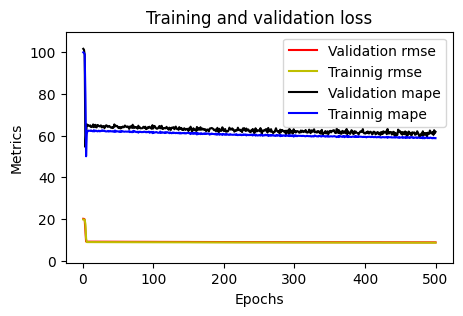

In [20]:
plotme(model1_3)
#val_loss2 = [x+1.8 for x in val_loss2]

In [21]:
# inputs: distance
model1_4 = nnmodel(10,10, num_hlayers=1,Epoch=500)
model1_4

Epoch 1/500
345/345 [==============================] - 1s 1ms/step - loss: 1119991.1250 - distance_layer_loss: 17.2862 - traveltime_layer_loss: 1399985.2500 - distance_layer_mape: 58747.7617 - distance_layer_rmse: 4.1577 - traveltime_layer_mape: 99.5650 - traveltime_layer_rmse: 1183.2097 - val_loss: 1142509.1250 - val_distance_layer_loss: 73.1318 - val_traveltime_layer_loss: 1428118.0000 - val_distance_layer_mape: 7136.9707 - val_distance_layer_rmse: 8.5517 - val_traveltime_layer_mape: 98.4690 - val_traveltime_layer_rmse: 1195.0389
Epoch 2/500
345/345 [==============================] - 0s 957us/step - loss: 1050749.5000 - distance_layer_loss: 356.0883 - traveltime_layer_loss: 1313348.7500 - distance_layer_mape: 2447411.7500 - distance_layer_rmse: 18.8703 - traveltime_layer_mape: 94.1107 - traveltime_layer_rmse: 1146.0143 - val_loss: 996101.5625 - val_distance_layer_loss: 858.4079 - val_traveltime_layer_loss: 1244912.1250 - val_distance_layer_mape: 24110.7363 - val_distance_layer_rmse: 

345/345 [==============================] - 0s 961us/step - loss: 229235.4844 - distance_layer_loss: 10060.9443 - traveltime_layer_loss: 284029.1875 - distance_layer_mape: 9127627.0000 - distance_layer_rmse: 100.3043 - traveltime_layer_mape: 62.2385 - traveltime_layer_rmse: 532.9439 - val_loss: 240356.2812 - val_distance_layer_loss: 9955.4297 - val_traveltime_layer_loss: 297956.4688 - val_distance_layer_mape: 81735.4219 - val_distance_layer_rmse: 99.7769 - val_traveltime_layer_mape: 62.2602 - val_traveltime_layer_rmse: 545.8539
Epoch 17/500
345/345 [==============================] - 0s 994us/step - loss: 229248.2500 - distance_layer_loss: 9978.3535 - traveltime_layer_loss: 284065.7812 - distance_layer_mape: 9100692.0000 - distance_layer_rmse: 99.8917 - traveltime_layer_mape: 62.0501 - traveltime_layer_rmse: 532.9782 - val_loss: 240201.6719 - val_distance_layer_loss: 9933.8906 - val_traveltime_layer_loss: 297768.5625 - val_distance_layer_mape: 81644.2656 - val_distance_layer_rmse: 99.668

345/345 [==============================] - 0s 1ms/step - loss: 228618.6562 - distance_layer_loss: 9259.3398 - traveltime_layer_loss: 283458.3750 - distance_layer_mape: 8694970.0000 - distance_layer_rmse: 96.2255 - traveltime_layer_mape: 62.0933 - traveltime_layer_rmse: 532.4081 - val_loss: 239496.2656 - val_distance_layer_loss: 9215.4844 - val_traveltime_layer_loss: 297066.4062 - val_distance_layer_mape: 78602.6797 - val_distance_layer_rmse: 95.9973 - val_traveltime_layer_mape: 62.4850 - val_traveltime_layer_rmse: 545.0380
Epoch 32/500
345/345 [==============================] - 0s 965us/step - loss: 228573.4688 - distance_layer_loss: 9229.2539 - traveltime_layer_loss: 283409.5938 - distance_layer_mape: 8710373.0000 - distance_layer_rmse: 96.0690 - traveltime_layer_mape: 62.2363 - traveltime_layer_rmse: 532.3623 - val_loss: 239629.6406 - val_distance_layer_loss: 9111.4834 - val_traveltime_layer_loss: 297259.2188 - val_distance_layer_mape: 78155.6328 - val_distance_layer_rmse: 95.4541 - 

345/345 [==============================] - 0s 958us/step - loss: 228040.2188 - distance_layer_loss: 8543.6602 - traveltime_layer_loss: 282914.3125 - distance_layer_mape: 8405212.0000 - distance_layer_rmse: 92.4319 - traveltime_layer_mape: 61.9975 - traveltime_layer_rmse: 531.8969 - val_loss: 238653.4062 - val_distance_layer_loss: 8568.0283 - val_traveltime_layer_loss: 296174.7812 - val_distance_layer_mape: 75754.3828 - val_distance_layer_rmse: 92.5636 - val_traveltime_layer_mape: 62.8463 - val_traveltime_layer_rmse: 544.2194
Epoch 47/500
345/345 [==============================] - 0s 955us/step - loss: 228035.8594 - distance_layer_loss: 8492.1895 - traveltime_layer_loss: 282921.8125 - distance_layer_mape: 8377715.5000 - distance_layer_rmse: 92.1531 - traveltime_layer_mape: 61.9502 - traveltime_layer_rmse: 531.9039 - val_loss: 238647.1094 - val_distance_layer_loss: 8503.8301 - val_traveltime_layer_loss: 296183.0625 - val_distance_layer_mape: 75467.6797 - val_distance_layer_rmse: 92.2162 

345/345 [==============================] - 0s 954us/step - loss: 227436.5312 - distance_layer_loss: 7886.7939 - traveltime_layer_loss: 282324.0312 - distance_layer_mape: 8048110.0000 - distance_layer_rmse: 88.8076 - traveltime_layer_mape: 61.9275 - traveltime_layer_rmse: 531.3417 - val_loss: 238172.0000 - val_distance_layer_loss: 7835.4551 - val_traveltime_layer_loss: 295756.1562 - val_distance_layer_mape: 72406.6875 - val_distance_layer_rmse: 88.5181 - val_traveltime_layer_mape: 62.2025 - val_traveltime_layer_rmse: 543.8347
Epoch 62/500
345/345 [==============================] - 0s 948us/step - loss: 227375.7812 - distance_layer_loss: 7824.1699 - traveltime_layer_loss: 282263.7188 - distance_layer_mape: 8027563.0000 - distance_layer_rmse: 88.4543 - traveltime_layer_mape: 61.7726 - traveltime_layer_rmse: 531.2850 - val_loss: 237921.7031 - val_distance_layer_loss: 7861.1436 - val_traveltime_layer_loss: 295436.8125 - val_distance_layer_mape: 72522.2812 - val_distance_layer_rmse: 88.6631 

345/345 [==============================] - 0s 938us/step - loss: 226865.9531 - distance_layer_loss: 7279.1084 - traveltime_layer_loss: 281762.6562 - distance_layer_mape: 7716035.0000 - distance_layer_rmse: 85.3177 - traveltime_layer_mape: 61.9593 - traveltime_layer_rmse: 530.8132 - val_loss: 237410.2188 - val_distance_layer_loss: 7238.2769 - val_traveltime_layer_loss: 294953.3750 - val_distance_layer_mape: 69553.9844 - val_distance_layer_rmse: 85.0781 - val_traveltime_layer_mape: 62.2681 - val_traveltime_layer_rmse: 543.0961
Epoch 77/500
345/345 [==============================] - 0s 949us/step - loss: 226822.7031 - distance_layer_loss: 7234.7075 - traveltime_layer_loss: 281719.7188 - distance_layer_mape: 7666887.0000 - distance_layer_rmse: 85.0571 - traveltime_layer_mape: 61.9098 - traveltime_layer_rmse: 530.7728 - val_loss: 237330.0312 - val_distance_layer_loss: 7209.3428 - val_traveltime_layer_loss: 294860.1562 - val_distance_layer_mape: 69412.1719 - val_distance_layer_rmse: 84.9079 

345/345 [==============================] - 0s 949us/step - loss: 226287.7031 - distance_layer_loss: 6724.3179 - traveltime_layer_loss: 281178.5000 - distance_layer_mape: 7368992.5000 - distance_layer_rmse: 82.0019 - traveltime_layer_mape: 61.8846 - traveltime_layer_rmse: 530.2627 - val_loss: 236782.2656 - val_distance_layer_loss: 6675.2217 - val_traveltime_layer_loss: 294309.0938 - val_distance_layer_mape: 66755.3516 - val_distance_layer_rmse: 81.7020 - val_traveltime_layer_mape: 62.0857 - val_traveltime_layer_rmse: 542.5026
Epoch 92/500
345/345 [==============================] - 0s 947us/step - loss: 226242.1406 - distance_layer_loss: 6676.3687 - traveltime_layer_loss: 281133.5625 - distance_layer_mape: 7349920.0000 - distance_layer_rmse: 81.7090 - traveltime_layer_mape: 61.7696 - traveltime_layer_rmse: 530.2203 - val_loss: 236542.8125 - val_distance_layer_loss: 6702.6440 - val_traveltime_layer_loss: 294002.8125 - val_distance_layer_mape: 66889.5312 - val_distance_layer_rmse: 81.8697 

345/345 [==============================] - 0s 999us/step - loss: 225697.6562 - distance_layer_loss: 6180.2861 - traveltime_layer_loss: 280576.8750 - distance_layer_mape: 7075446.5000 - distance_layer_rmse: 78.6148 - traveltime_layer_mape: 61.5048 - traveltime_layer_rmse: 529.6951 - val_loss: 235915.7656 - val_distance_layer_loss: 6228.6538 - val_traveltime_layer_loss: 293337.5312 - val_distance_layer_mape: 64443.8555 - val_distance_layer_rmse: 78.9218 - val_traveltime_layer_mape: 62.5805 - val_traveltime_layer_rmse: 541.6064
Epoch 107/500
345/345 [==============================] - 0s 981us/step - loss: 225718.9375 - distance_layer_loss: 6200.7144 - traveltime_layer_loss: 280598.6562 - distance_layer_mape: 7119563.0000 - distance_layer_rmse: 78.7446 - traveltime_layer_mape: 62.0153 - traveltime_layer_rmse: 529.7156 - val_loss: 236148.1406 - val_distance_layer_loss: 6117.2666 - val_traveltime_layer_loss: 293655.8125 - val_distance_layer_mape: 63862.2500 - val_distance_layer_rmse: 78.2130

345/345 [==============================] - 0s 971us/step - loss: 225112.7344 - distance_layer_loss: 5725.9658 - traveltime_layer_loss: 279959.3750 - distance_layer_mape: 6849095.5000 - distance_layer_rmse: 75.6701 - traveltime_layer_mape: 61.6256 - traveltime_layer_rmse: 529.1119 - val_loss: 235547.5781 - val_distance_layer_loss: 5671.6597 - val_traveltime_layer_loss: 293016.5625 - val_distance_layer_mape: 61453.7578 - val_distance_layer_rmse: 75.3104 - val_traveltime_layer_mape: 61.7043 - val_traveltime_layer_rmse: 541.3101
Epoch 122/500
345/345 [==============================] - 0s 985us/step - loss: 225080.9219 - distance_layer_loss: 5681.2842 - traveltime_layer_loss: 279930.8750 - distance_layer_mape: 6806521.5000 - distance_layer_rmse: 75.3743 - traveltime_layer_mape: 61.4842 - traveltime_layer_rmse: 529.0850 - val_loss: 235370.5938 - val_distance_layer_loss: 5667.8418 - val_traveltime_layer_loss: 292796.3125 - val_distance_layer_mape: 61430.2070 - val_distance_layer_rmse: 75.2851

345/345 [==============================] - 0s 951us/step - loss: 224609.2656 - distance_layer_loss: 5285.1553 - traveltime_layer_loss: 279440.0938 - distance_layer_mape: 6565086.0000 - distance_layer_rmse: 72.6991 - traveltime_layer_mape: 61.4150 - traveltime_layer_rmse: 528.6209 - val_loss: 234909.0000 - val_distance_layer_loss: 5246.6855 - val_traveltime_layer_loss: 292324.5938 - val_distance_layer_mape: 59065.6055 - val_distance_layer_rmse: 72.4340 - val_traveltime_layer_mape: 61.6068 - val_traveltime_layer_rmse: 540.6705
Epoch 137/500
345/345 [==============================] - 0s 993us/step - loss: 224560.1562 - distance_layer_loss: 5259.2041 - traveltime_layer_loss: 279385.2812 - distance_layer_mape: 6539351.0000 - distance_layer_rmse: 72.5204 - traveltime_layer_mape: 61.4289 - traveltime_layer_rmse: 528.5691 - val_loss: 234721.6250 - val_distance_layer_loss: 5247.2837 - val_traveltime_layer_loss: 292090.0625 - val_distance_layer_mape: 59066.2070 - val_distance_layer_rmse: 72.4381

345/345 [==============================] - 0s 931us/step - loss: 224049.1875 - distance_layer_loss: 4885.4380 - traveltime_layer_loss: 278840.2188 - distance_layer_mape: 6274313.5000 - distance_layer_rmse: 69.8959 - traveltime_layer_mape: 61.4115 - traveltime_layer_rmse: 528.0532 - val_loss: 234250.2812 - val_distance_layer_loss: 4842.5923 - val_traveltime_layer_loss: 291602.1875 - val_distance_layer_mape: 56701.8711 - val_distance_layer_rmse: 69.5887 - val_traveltime_layer_mape: 61.5133 - val_traveltime_layer_rmse: 540.0020
Epoch 152/500
345/345 [==============================] - 0s 946us/step - loss: 224016.8125 - distance_layer_loss: 4847.1001 - traveltime_layer_loss: 278809.2812 - distance_layer_mape: 6294807.5000 - distance_layer_rmse: 69.6211 - traveltime_layer_mape: 61.2598 - traveltime_layer_rmse: 528.0239 - val_loss: 233865.8750 - val_distance_layer_loss: 4910.2593 - val_traveltime_layer_loss: 291104.7812 - val_distance_layer_mape: 57094.6250 - val_distance_layer_rmse: 70.0732

345/345 [==============================] - 0s 966us/step - loss: 223551.4062 - distance_layer_loss: 4505.5571 - traveltime_layer_loss: 278312.9688 - distance_layer_mape: 6003103.5000 - distance_layer_rmse: 67.1234 - traveltime_layer_mape: 61.2791 - traveltime_layer_rmse: 527.5538 - val_loss: 233554.2656 - val_distance_layer_loss: 4477.8262 - val_traveltime_layer_loss: 290823.3750 - val_distance_layer_mape: 54479.7500 - val_distance_layer_rmse: 66.9166 - val_traveltime_layer_mape: 61.5063 - val_traveltime_layer_rmse: 539.2804
Epoch 167/500
345/345 [==============================] - 0s 937us/step - loss: 223468.5312 - distance_layer_loss: 4471.1484 - traveltime_layer_loss: 278217.8750 - distance_layer_mape: 5985679.0000 - distance_layer_rmse: 66.8666 - traveltime_layer_mape: 61.1298 - traveltime_layer_rmse: 527.4636 - val_loss: 233280.8750 - val_distance_layer_loss: 4506.3740 - val_traveltime_layer_loss: 290474.4375 - val_distance_layer_mape: 54650.7500 - val_distance_layer_rmse: 67.1295

345/345 [==============================] - 0s 944us/step - loss: 223027.5312 - distance_layer_loss: 4153.6533 - traveltime_layer_loss: 277745.9375 - distance_layer_mape: 5761192.0000 - distance_layer_rmse: 64.4488 - traveltime_layer_mape: 61.0947 - traveltime_layer_rmse: 527.0161 - val_loss: 232665.9375 - val_distance_layer_loss: 4193.7944 - val_traveltime_layer_loss: 289784.0938 - val_distance_layer_mape: 52678.7422 - val_distance_layer_rmse: 64.7595 - val_traveltime_layer_mape: 62.1651 - val_traveltime_layer_rmse: 538.3160
Epoch 182/500
345/345 [==============================] - 0s 922us/step - loss: 223005.0156 - distance_layer_loss: 4158.3867 - traveltime_layer_loss: 277716.7812 - distance_layer_mape: 5812446.5000 - distance_layer_rmse: 64.4856 - traveltime_layer_mape: 61.4526 - traveltime_layer_rmse: 526.9884 - val_loss: 232840.5156 - val_distance_layer_loss: 4118.3838 - val_traveltime_layer_loss: 290020.9375 - val_distance_layer_mape: 52198.7188 - val_distance_layer_rmse: 64.1746

345/345 [==============================] - 0s 981us/step - loss: 222556.0781 - distance_layer_loss: 3875.5491 - traveltime_layer_loss: 277226.1875 - distance_layer_mape: 5539409.5000 - distance_layer_rmse: 62.2539 - traveltime_layer_mape: 61.4664 - traveltime_layer_rmse: 526.5227 - val_loss: 232656.4219 - val_distance_layer_loss: 3782.6790 - val_traveltime_layer_loss: 289874.7188 - val_distance_layer_mape: 49982.1875 - val_distance_layer_rmse: 61.5035 - val_traveltime_layer_mape: 60.7186 - val_traveltime_layer_rmse: 538.4001
Epoch 197/500
345/345 [==============================] - 0s 941us/step - loss: 222506.7344 - distance_layer_loss: 3814.0325 - traveltime_layer_loss: 277179.8750 - distance_layer_mape: 5546717.5000 - distance_layer_rmse: 61.7579 - traveltime_layer_mape: 60.8630 - traveltime_layer_rmse: 526.4788 - val_loss: 232089.6250 - val_distance_layer_loss: 3840.6123 - val_traveltime_layer_loss: 289151.8438 - val_distance_layer_mape: 50362.2227 - val_distance_layer_rmse: 61.9727

345/345 [==============================] - 0s 939us/step - loss: 222027.8594 - distance_layer_loss: 3574.7793 - traveltime_layer_loss: 276641.1562 - distance_layer_mape: 5352427.5000 - distance_layer_rmse: 59.7895 - traveltime_layer_mape: 61.2396 - traveltime_layer_rmse: 525.9669 - val_loss: 231934.6406 - val_distance_layer_loss: 3507.8687 - val_traveltime_layer_loss: 289041.3125 - val_distance_layer_mape: 48085.0977 - val_distance_layer_rmse: 59.2273 - val_traveltime_layer_mape: 60.7850 - val_traveltime_layer_rmse: 537.6256
Epoch 212/500
345/345 [==============================] - 0s 950us/step - loss: 222021.6719 - distance_layer_loss: 3517.5190 - traveltime_layer_loss: 276647.6875 - distance_layer_mape: 5291697.5000 - distance_layer_rmse: 59.3087 - traveltime_layer_mape: 60.6757 - traveltime_layer_rmse: 525.9731 - val_loss: 231430.6250 - val_distance_layer_loss: 3567.5779 - val_traveltime_layer_loss: 288396.3438 - val_distance_layer_mape: 48491.7891 - val_distance_layer_rmse: 59.7292

345/345 [==============================] - 0s 989us/step - loss: 221580.5000 - distance_layer_loss: 3293.8977 - traveltime_layer_loss: 276151.8750 - distance_layer_mape: 5082427.0000 - distance_layer_rmse: 57.3925 - traveltime_layer_mape: 60.9588 - traveltime_layer_rmse: 525.5015 - val_loss: 231226.9219 - val_distance_layer_loss: 3258.5232 - val_traveltime_layer_loss: 288218.9688 - val_distance_layer_mape: 46296.7773 - val_distance_layer_rmse: 57.0835 - val_traveltime_layer_mape: 60.8902 - val_traveltime_layer_rmse: 536.8603
Epoch 227/500
345/345 [==============================] - 0s 962us/step - loss: 221561.6875 - distance_layer_loss: 3271.9971 - traveltime_layer_loss: 276134.0000 - distance_layer_mape: 5099260.5000 - distance_layer_rmse: 57.2014 - traveltime_layer_mape: 60.8483 - traveltime_layer_rmse: 525.4846 - val_loss: 231163.3125 - val_distance_layer_loss: 3245.9856 - val_traveltime_layer_loss: 288142.6875 - val_distance_layer_mape: 46204.7266 - val_distance_layer_rmse: 56.9736

345/345 [==============================] - 0s 971us/step - loss: 221186.5156 - distance_layer_loss: 3051.2312 - traveltime_layer_loss: 275720.3438 - distance_layer_mape: 4915243.0000 - distance_layer_rmse: 55.2379 - traveltime_layer_mape: 60.7344 - traveltime_layer_rmse: 525.0908 - val_loss: 230458.7812 - val_distance_layer_loss: 3060.0811 - val_traveltime_layer_loss: 287308.4062 - val_distance_layer_mape: 44819.9961 - val_distance_layer_rmse: 55.3180 - val_traveltime_layer_mape: 61.3452 - val_traveltime_layer_rmse: 536.0116
Epoch 242/500
345/345 [==============================] - 0s 912us/step - loss: 221141.4219 - distance_layer_loss: 3043.4236 - traveltime_layer_loss: 275665.8750 - distance_layer_mape: 4929891.0000 - distance_layer_rmse: 55.1672 - traveltime_layer_mape: 60.8485 - traveltime_layer_rmse: 525.0389 - val_loss: 230568.9531 - val_distance_layer_loss: 3022.2590 - val_traveltime_layer_loss: 287455.4688 - val_distance_layer_mape: 44537.7969 - val_distance_layer_rmse: 54.9751

345/345 [==============================] - 0s 966us/step - loss: 220799.3906 - distance_layer_loss: 2835.8975 - traveltime_layer_loss: 275290.4688 - distance_layer_mape: 4741924.0000 - distance_layer_rmse: 53.2531 - traveltime_layer_mape: 60.5410 - traveltime_layer_rmse: 524.6813 - val_loss: 229987.5781 - val_distance_layer_loss: 2845.2861 - val_traveltime_layer_loss: 286773.1562 - val_distance_layer_mape: 43173.0273 - val_distance_layer_rmse: 53.3412 - val_traveltime_layer_mape: 61.1676 - val_traveltime_layer_rmse: 535.5120
Epoch 257/500
345/345 [==============================] - 0s 991us/step - loss: 220775.1250 - distance_layer_loss: 2833.2166 - traveltime_layer_loss: 275260.5625 - distance_layer_mape: 4708344.0000 - distance_layer_rmse: 53.2280 - traveltime_layer_mape: 60.7479 - traveltime_layer_rmse: 524.6528 - val_loss: 230112.7031 - val_distance_layer_loss: 2809.1594 - val_traveltime_layer_loss: 286938.6562 - val_distance_layer_mape: 42893.4961 - val_distance_layer_rmse: 53.0015

345/345 [==============================] - 0s 952us/step - loss: 220448.5312 - distance_layer_loss: 2654.8779 - traveltime_layer_loss: 274896.7812 - distance_layer_mape: 4584178.5000 - distance_layer_rmse: 51.5255 - traveltime_layer_mape: 60.5837 - traveltime_layer_rmse: 524.3060 - val_loss: 229883.6094 - val_distance_layer_loss: 2617.0645 - val_traveltime_layer_loss: 286700.3125 - val_distance_layer_mape: 41359.2812 - val_distance_layer_rmse: 51.1573 - val_traveltime_layer_mape: 60.3161 - val_traveltime_layer_rmse: 535.4440
Epoch 272/500
345/345 [==============================] - 0s 982us/step - loss: 220453.2344 - distance_layer_loss: 2641.8809 - traveltime_layer_loss: 274906.2500 - distance_layer_mape: 4543177.0000 - distance_layer_rmse: 51.3992 - traveltime_layer_mape: 60.5528 - traveltime_layer_rmse: 524.3150 - val_loss: 229659.5781 - val_distance_layer_loss: 2624.7649 - val_traveltime_layer_loss: 286418.3438 - val_distance_layer_mape: 41418.6445 - val_distance_layer_rmse: 51.2325

345/345 [==============================] - 0s 967us/step - loss: 220093.3281 - distance_layer_loss: 2494.3271 - traveltime_layer_loss: 274493.0938 - distance_layer_mape: 4388906.5000 - distance_layer_rmse: 49.9432 - traveltime_layer_mape: 60.5183 - traveltime_layer_rmse: 523.9209 - val_loss: 229281.5469 - val_distance_layer_loss: 2474.2673 - val_traveltime_layer_loss: 285983.3438 - val_distance_layer_mape: 40176.3945 - val_distance_layer_rmse: 49.7420 - val_traveltime_layer_mape: 60.5623 - val_traveltime_layer_rmse: 534.7741
Epoch 287/500
345/345 [==============================] - 0s 992us/step - loss: 220109.7031 - distance_layer_loss: 2477.2019 - traveltime_layer_loss: 274517.7812 - distance_layer_mape: 4421149.5000 - distance_layer_rmse: 49.7715 - traveltime_layer_mape: 60.4034 - traveltime_layer_rmse: 523.9445 - val_loss: 229230.1562 - val_distance_layer_loss: 2466.8306 - val_traveltime_layer_loss: 285920.9062 - val_distance_layer_mape: 40113.5273 - val_distance_layer_rmse: 49.6672

345/345 [==============================] - 0s 991us/step - loss: 219882.8906 - distance_layer_loss: 2341.1809 - traveltime_layer_loss: 274268.3750 - distance_layer_mape: 4310243.0000 - distance_layer_rmse: 48.3857 - traveltime_layer_mape: 60.3529 - traveltime_layer_rmse: 523.7064 - val_loss: 229040.3125 - val_distance_layer_loss: 2312.7729 - val_traveltime_layer_loss: 285722.1875 - val_distance_layer_mape: 38803.4102 - val_distance_layer_rmse: 48.0913 - val_traveltime_layer_mape: 60.1849 - val_traveltime_layer_rmse: 534.5298
Epoch 302/500
345/345 [==============================] - 0s 950us/step - loss: 219834.3281 - distance_layer_loss: 2333.2747 - traveltime_layer_loss: 274209.6250 - distance_layer_mape: 4294877.5000 - distance_layer_rmse: 48.3040 - traveltime_layer_mape: 60.4007 - traveltime_layer_rmse: 523.6503 - val_loss: 229109.7188 - val_distance_layer_loss: 2296.1421 - val_traveltime_layer_loss: 285813.1250 - val_distance_layer_mape: 38660.4336 - val_distance_layer_rmse: 47.9181

345/345 [==============================] - 0s 954us/step - loss: 219496.1562 - distance_layer_loss: 2212.6460 - traveltime_layer_loss: 273817.0938 - distance_layer_mape: 4146022.2500 - distance_layer_rmse: 47.0388 - traveltime_layer_mape: 60.4048 - traveltime_layer_rmse: 523.2753 - val_loss: 228860.8594 - val_distance_layer_loss: 2165.5635 - val_traveltime_layer_loss: 285534.7500 - val_distance_layer_mape: 37510.4961 - val_distance_layer_rmse: 46.5356 - val_traveltime_layer_mape: 59.7955 - val_traveltime_layer_rmse: 534.3545
Epoch 317/500
345/345 [==============================] - 0s 981us/step - loss: 219559.1875 - distance_layer_loss: 2190.8408 - traveltime_layer_loss: 273901.1562 - distance_layer_mape: 4132896.7500 - distance_layer_rmse: 46.8064 - traveltime_layer_mape: 60.1167 - traveltime_layer_rmse: 523.3557 - val_loss: 228603.1250 - val_distance_layer_loss: 2174.7844 - val_traveltime_layer_loss: 285210.3125 - val_distance_layer_mape: 37589.7969 - val_distance_layer_rmse: 46.6346

345/345 [==============================] - 0s 965us/step - loss: 219283.5938 - distance_layer_loss: 2088.4595 - traveltime_layer_loss: 273582.2500 - distance_layer_mape: 4015333.7500 - distance_layer_rmse: 45.6997 - traveltime_layer_mape: 60.2150 - traveltime_layer_rmse: 523.0509 - val_loss: 228086.2969 - val_distance_layer_loss: 2085.3013 - val_traveltime_layer_loss: 284586.5312 - val_distance_layer_mape: 36780.3633 - val_distance_layer_rmse: 45.6651 - val_traveltime_layer_mape: 60.5125 - val_traveltime_layer_rmse: 533.4666
Epoch 332/500
345/345 [==============================] - 0s 946us/step - loss: 219251.1562 - distance_layer_loss: 2081.2007 - traveltime_layer_loss: 273543.7188 - distance_layer_mape: 4024723.2500 - distance_layer_rmse: 45.6202 - traveltime_layer_mape: 60.2109 - traveltime_layer_rmse: 523.0141 - val_loss: 228164.9844 - val_distance_layer_loss: 2067.0481 - val_traveltime_layer_loss: 284689.4688 - val_distance_layer_mape: 36615.5703 - val_distance_layer_rmse: 45.4648

345/345 [==============================] - 0s 982us/step - loss: 219054.1719 - distance_layer_loss: 1983.1178 - traveltime_layer_loss: 273322.0625 - distance_layer_mape: 3909450.0000 - distance_layer_rmse: 44.5322 - traveltime_layer_mape: 60.1014 - traveltime_layer_rmse: 522.8021 - val_loss: 227934.0469 - val_distance_layer_loss: 1966.5433 - val_traveltime_layer_loss: 284425.9062 - val_distance_layer_mape: 35687.1016 - val_distance_layer_rmse: 44.3457 - val_traveltime_layer_mape: 60.0731 - val_traveltime_layer_rmse: 533.3160
Epoch 347/500
345/345 [==============================] - 0s 975us/step - loss: 219030.1094 - distance_layer_loss: 1972.0751 - traveltime_layer_loss: 273294.5625 - distance_layer_mape: 3921999.5000 - distance_layer_rmse: 44.4081 - traveltime_layer_mape: 59.9745 - traveltime_layer_rmse: 522.7758 - val_loss: 227739.6875 - val_distance_layer_loss: 1976.6698 - val_traveltime_layer_loss: 284180.5938 - val_distance_layer_mape: 35779.2070 - val_distance_layer_rmse: 44.4598

345/345 [==============================] - 0s 947us/step - loss: 218864.9062 - distance_layer_loss: 1892.6857 - traveltime_layer_loss: 273107.9062 - distance_layer_mape: 3822032.7500 - distance_layer_rmse: 43.5050 - traveltime_layer_mape: 60.0799 - traveltime_layer_rmse: 522.5973 - val_loss: 227429.6250 - val_distance_layer_loss: 1895.3141 - val_traveltime_layer_loss: 283813.1875 - val_distance_layer_mape: 35012.5781 - val_distance_layer_rmse: 43.5352 - val_traveltime_layer_mape: 60.4836 - val_traveltime_layer_rmse: 532.7412
Epoch 362/500
345/345 [==============================] - 0s 957us/step - loss: 218825.1406 - distance_layer_loss: 1882.3707 - traveltime_layer_loss: 273060.8750 - distance_layer_mape: 3809994.7500 - distance_layer_rmse: 43.3863 - traveltime_layer_mape: 59.9681 - traveltime_layer_rmse: 522.5522 - val_loss: 227453.1562 - val_distance_layer_loss: 1884.0164 - val_traveltime_layer_loss: 283845.3125 - val_distance_layer_mape: 34905.4375 - val_distance_layer_rmse: 43.4053

345/345 [==============================] - 0s 972us/step - loss: 218598.5156 - distance_layer_loss: 1805.2428 - traveltime_layer_loss: 272796.8125 - distance_layer_mape: 3692135.7500 - distance_layer_rmse: 42.4881 - traveltime_layer_mape: 59.9025 - traveltime_layer_rmse: 522.2996 - val_loss: 227033.4219 - val_distance_layer_loss: 1829.2549 - val_traveltime_layer_loss: 283334.5625 - val_distance_layer_mape: 34376.7695 - val_distance_layer_rmse: 42.7698 - val_traveltime_layer_mape: 60.8501 - val_traveltime_layer_rmse: 532.2918
Epoch 377/500
345/345 [==============================] - 0s 993us/step - loss: 218622.5625 - distance_layer_loss: 1808.8235 - traveltime_layer_loss: 272826.0625 - distance_layer_mape: 3731249.5000 - distance_layer_rmse: 42.5303 - traveltime_layer_mape: 60.1253 - traveltime_layer_rmse: 522.3275 - val_loss: 227128.0312 - val_distance_layer_loss: 1806.7910 - val_traveltime_layer_loss: 283458.3125 - val_distance_layer_mape: 34161.1484 - val_distance_layer_rmse: 42.5064

345/345 [==============================] - 0s 954us/step - loss: 218411.5000 - distance_layer_loss: 1737.2834 - traveltime_layer_loss: 272580.2188 - distance_layer_mape: 3661218.2500 - distance_layer_rmse: 41.6807 - traveltime_layer_mape: 60.0339 - traveltime_layer_rmse: 522.0922 - val_loss: 226752.0781 - val_distance_layer_loss: 1754.8177 - val_traveltime_layer_loss: 283001.3750 - val_distance_layer_mape: 33650.1016 - val_distance_layer_rmse: 41.8905 - val_traveltime_layer_mape: 60.8255 - val_traveltime_layer_rmse: 531.9788
Epoch 392/500
345/345 [==============================] - 0s 945us/step - loss: 218290.8906 - distance_layer_loss: 1724.8331 - traveltime_layer_loss: 272432.5625 - distance_layer_mape: 3645053.0000 - distance_layer_rmse: 41.5311 - traveltime_layer_mape: 59.8041 - traveltime_layer_rmse: 521.9507 - val_loss: 226702.5312 - val_distance_layer_loss: 1770.2004 - val_traveltime_layer_loss: 282935.5625 - val_distance_layer_mape: 33799.1992 - val_distance_layer_rmse: 42.0737

345/345 [==============================] - 0s 960us/step - loss: 218165.1562 - distance_layer_loss: 1656.5251 - traveltime_layer_loss: 272292.4062 - distance_layer_mape: 3575032.2500 - distance_layer_rmse: 40.7004 - traveltime_layer_mape: 59.6863 - traveltime_layer_rmse: 521.8165 - val_loss: 226503.1562 - val_distance_layer_loss: 1680.0797 - val_traveltime_layer_loss: 282709.0000 - val_distance_layer_mape: 32906.8516 - val_distance_layer_rmse: 40.9888 - val_traveltime_layer_mape: 60.6439 - val_traveltime_layer_rmse: 531.7039
Epoch 407/500
345/345 [==============================] - 0s 947us/step - loss: 218159.5469 - distance_layer_loss: 1659.4684 - traveltime_layer_loss: 272284.4062 - distance_layer_mape: 3581998.0000 - distance_layer_rmse: 40.7366 - traveltime_layer_mape: 59.8894 - traveltime_layer_rmse: 521.8088 - val_loss: 226526.6250 - val_distance_layer_loss: 1669.0511 - val_traveltime_layer_loss: 282741.0938 - val_distance_layer_mape: 32796.4023 - val_distance_layer_rmse: 40.8540

345/345 [==============================] - 0s 988us/step - loss: 217989.1562 - distance_layer_loss: 1593.2522 - traveltime_layer_loss: 272087.9688 - distance_layer_mape: 3510752.0000 - distance_layer_rmse: 39.9156 - traveltime_layer_mape: 59.6823 - traveltime_layer_rmse: 521.6205 - val_loss: 226747.0781 - val_distance_layer_loss: 1571.5229 - val_traveltime_layer_loss: 283040.8750 - val_distance_layer_mape: 31801.7070 - val_distance_layer_rmse: 39.6424 - val_traveltime_layer_mape: 59.3841 - val_traveltime_layer_rmse: 532.0159
Epoch 422/500
345/345 [==============================] - 0s 972us/step - loss: 217989.8750 - distance_layer_loss: 1585.6176 - traveltime_layer_loss: 272090.8750 - distance_layer_mape: 3502168.2500 - distance_layer_rmse: 39.8198 - traveltime_layer_mape: 59.5888 - traveltime_layer_rmse: 521.6233 - val_loss: 226272.9375 - val_distance_layer_loss: 1601.5256 - val_traveltime_layer_loss: 282440.7812 - val_distance_layer_mape: 32108.9512 - val_distance_layer_rmse: 40.0191

345/345 [==============================] - 0s 946us/step - loss: 217757.5156 - distance_layer_loss: 1548.1191 - traveltime_layer_loss: 271809.9375 - distance_layer_mape: 3387033.7500 - distance_layer_rmse: 39.3461 - traveltime_layer_mape: 60.0018 - traveltime_layer_rmse: 521.3539 - val_loss: 226291.0469 - val_distance_layer_loss: 1525.9355 - val_traveltime_layer_loss: 282482.4375 - val_distance_layer_mape: 31325.1211 - val_distance_layer_rmse: 39.0632 - val_traveltime_layer_mape: 59.6652 - val_traveltime_layer_rmse: 531.4908
Epoch 437/500
345/345 [==============================] - 0s 931us/step - loss: 217661.9531 - distance_layer_loss: 1538.0101 - traveltime_layer_loss: 271692.9688 - distance_layer_mape: 3408039.5000 - distance_layer_rmse: 39.2175 - traveltime_layer_mape: 59.8185 - traveltime_layer_rmse: 521.2418 - val_loss: 226789.6562 - val_distance_layer_loss: 1495.6134 - val_traveltime_layer_loss: 283113.2188 - val_distance_layer_mape: 31006.2090 - val_distance_layer_rmse: 38.6732

345/345 [==============================] - 0s 963us/step - loss: 217525.7812 - distance_layer_loss: 1472.6136 - traveltime_layer_loss: 271539.0312 - distance_layer_mape: 3327329.7500 - distance_layer_rmse: 38.3746 - traveltime_layer_mape: 59.4702 - traveltime_layer_rmse: 521.0941 - val_loss: 225685.9375 - val_distance_layer_loss: 1497.9462 - val_traveltime_layer_loss: 281732.9688 - val_distance_layer_mape: 31027.3438 - val_distance_layer_rmse: 38.7033 - val_traveltime_layer_mape: 60.5536 - val_traveltime_layer_rmse: 530.7852
Epoch 452/500
345/345 [==============================] - 0s 977us/step - loss: 217483.9219 - distance_layer_loss: 1473.3563 - traveltime_layer_loss: 271486.2812 - distance_layer_mape: 3362073.0000 - distance_layer_rmse: 38.3843 - traveltime_layer_mape: 59.6170 - traveltime_layer_rmse: 521.0435 - val_loss: 225758.2969 - val_distance_layer_loss: 1481.1803 - val_traveltime_layer_loss: 281827.5938 - val_distance_layer_mape: 30849.5703 - val_distance_layer_rmse: 38.4861

345/345 [==============================] - 0s 1ms/step - loss: 217298.7031 - distance_layer_loss: 1428.1315 - traveltime_layer_loss: 271266.2500 - distance_layer_mape: 3337272.7500 - distance_layer_rmse: 37.7906 - traveltime_layer_mape: 59.8072 - traveltime_layer_rmse: 520.8323 - val_loss: 225459.7188 - val_distance_layer_loss: 1433.5681 - val_traveltime_layer_loss: 281466.3438 - val_distance_layer_mape: 30337.7012 - val_distance_layer_rmse: 37.8625 - val_traveltime_layer_mape: 60.2713 - val_traveltime_layer_rmse: 530.5340
Epoch 467/500
345/345 [==============================] - 0s 980us/step - loss: 217263.0469 - distance_layer_loss: 1417.6473 - traveltime_layer_loss: 271224.3750 - distance_layer_mape: 3288714.7500 - distance_layer_rmse: 37.6517 - traveltime_layer_mape: 59.5932 - traveltime_layer_rmse: 520.7921 - val_loss: 225563.9375 - val_distance_layer_loss: 1417.6741 - val_traveltime_layer_loss: 281600.5312 - val_distance_layer_mape: 30165.3633 - val_distance_layer_rmse: 37.6520 -

345/345 [==============================] - 0s 987us/step - loss: 217027.8125 - distance_layer_loss: 1370.7789 - traveltime_layer_loss: 270942.0625 - distance_layer_mape: 3267722.5000 - distance_layer_rmse: 37.0240 - traveltime_layer_mape: 59.6208 - traveltime_layer_rmse: 520.5209 - val_loss: 225304.3906 - val_distance_layer_loss: 1368.0597 - val_traveltime_layer_loss: 281288.4375 - val_distance_layer_mape: 29620.4551 - val_distance_layer_rmse: 36.9873 - val_traveltime_layer_mape: 59.8503 - val_traveltime_layer_rmse: 530.3663
Epoch 482/500
345/345 [==============================] - 0s 952us/step - loss: 217065.2812 - distance_layer_loss: 1361.5919 - traveltime_layer_loss: 270991.2812 - distance_layer_mape: 3213350.2500 - distance_layer_rmse: 36.8998 - traveltime_layer_mape: 59.4615 - traveltime_layer_rmse: 520.5682 - val_loss: 225107.9219 - val_distance_layer_loss: 1385.5374 - val_traveltime_layer_loss: 281038.5000 - val_distance_layer_mape: 29812.8691 - val_distance_layer_rmse: 37.2228

345/345 [==============================] - 0s 940us/step - loss: 216819.2969 - distance_layer_loss: 1322.0637 - traveltime_layer_loss: 270693.5000 - distance_layer_mape: 3194602.7500 - distance_layer_rmse: 36.3602 - traveltime_layer_mape: 59.6833 - traveltime_layer_rmse: 520.2821 - val_loss: 225398.9062 - val_distance_layer_loss: 1295.6971 - val_traveltime_layer_loss: 281424.7500 - val_distance_layer_mape: 28808.7715 - val_distance_layer_rmse: 35.9958 - val_traveltime_layer_mape: 59.0982 - val_traveltime_layer_rmse: 530.4948
Epoch 497/500
345/345 [==============================] - 0s 991us/step - loss: 216790.4844 - distance_layer_loss: 1312.3616 - traveltime_layer_loss: 270659.9688 - distance_layer_mape: 3129869.2500 - distance_layer_rmse: 36.2265 - traveltime_layer_mape: 59.4369 - traveltime_layer_rmse: 520.2499 - val_loss: 224905.3281 - val_distance_layer_loss: 1323.2610 - val_traveltime_layer_loss: 280800.9375 - val_distance_layer_mape: 29120.0371 - val_distance_layer_rmse: 36.3767

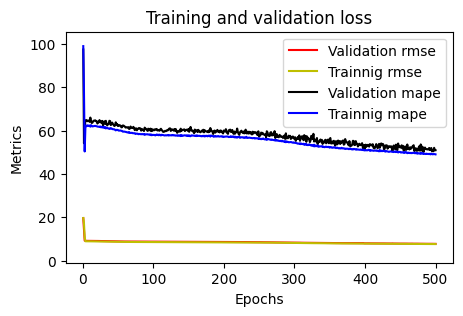

In [22]:
plotme(model1_4)

In [22]:
# inputs: distance
model1_44 = nnmodel(10,20, num_hlayers=1,Epoch=500)
model1_44

Epoch 1/500
345/345 [==============================] - 1s 1ms/step - loss: 1102775.1250 - distance_layer_loss: 33.7747 - traveltime_layer_loss: 1378460.2500 - distance_layer_mape: 1006727.1250 - distance_layer_rmse: 5.8116 - traveltime_layer_mape: 98.2262 - traveltime_layer_rmse: 1174.0785 - val_loss: 1070191.8750 - val_distance_layer_loss: 152.6821 - val_traveltime_layer_loss: 1337701.5000 - val_distance_layer_mape: 10239.6016 - val_distance_layer_rmse: 12.3565 - val_traveltime_layer_mape: 92.9096 - val_traveltime_layer_rmse: 1156.5905
Epoch 2/500
345/345 [==============================] - 0s 963us/step - loss: 766873.9375 - distance_layer_loss: 811.5810 - traveltime_layer_loss: 958389.9375 - distance_layer_mape: 3090354.5000 - distance_layer_rmse: 28.4883 - traveltime_layer_mape: 70.4537 - traveltime_layer_rmse: 978.9739 - val_loss: 449604.0312 - val_distance_layer_loss: 1890.1008 - val_traveltime_layer_loss: 561532.5000 - val_distance_layer_mape: 35693.5586 - val_distance_layer_rmse

345/345 [==============================] - 0s 924us/step - loss: 226587.8125 - distance_layer_loss: 3499.9568 - traveltime_layer_loss: 282359.8750 - distance_layer_mape: 5354576.5000 - distance_layer_rmse: 59.1604 - traveltime_layer_mape: 61.8209 - traveltime_layer_rmse: 531.3754 - val_loss: 237028.2500 - val_distance_layer_loss: 3524.6714 - val_traveltime_layer_loss: 295404.0312 - val_distance_layer_mape: 48609.5508 - val_distance_layer_rmse: 59.3689 - val_traveltime_layer_mape: 62.9733 - val_traveltime_layer_rmse: 543.5109
Epoch 17/500
345/345 [==============================] - 0s 936us/step - loss: 226407.9219 - distance_layer_loss: 3501.8821 - traveltime_layer_loss: 282134.3750 - distance_layer_mape: 5344646.0000 - distance_layer_rmse: 59.1767 - traveltime_layer_mape: 62.2069 - traveltime_layer_rmse: 531.1632 - val_loss: 237410.0000 - val_distance_layer_loss: 3433.1348 - val_traveltime_layer_loss: 295904.0938 - val_distance_layer_mape: 47965.1328 - val_distance_layer_rmse: 58.5930 

345/345 [==============================] - 0s 967us/step - loss: 223311.5938 - distance_layer_loss: 3103.4294 - traveltime_layer_loss: 278363.5625 - distance_layer_mape: 4987677.5000 - distance_layer_rmse: 55.7084 - traveltime_layer_mape: 61.4765 - traveltime_layer_rmse: 527.6017 - val_loss: 233268.4062 - val_distance_layer_loss: 3096.5938 - val_traveltime_layer_loss: 290811.4062 - val_distance_layer_mape: 45368.6133 - val_distance_layer_rmse: 55.6470 - val_traveltime_layer_mape: 62.1312 - val_traveltime_layer_rmse: 539.2693
Epoch 32/500
345/345 [==============================] - 0s 949us/step - loss: 223103.5938 - distance_layer_loss: 3067.7300 - traveltime_layer_loss: 278112.5938 - distance_layer_mape: 4985190.5000 - distance_layer_rmse: 55.3871 - traveltime_layer_mape: 61.3952 - traveltime_layer_rmse: 527.3638 - val_loss: 233020.6719 - val_distance_layer_loss: 3056.2971 - val_traveltime_layer_loss: 290511.7812 - val_distance_layer_mape: 45057.8242 - val_distance_layer_rmse: 55.2838 

345/345 [==============================] - 0s 943us/step - loss: 219324.9375 - distance_layer_loss: 2532.5427 - traveltime_layer_loss: 273522.9375 - distance_layer_mape: 4447612.5000 - distance_layer_rmse: 50.3244 - traveltime_layer_mape: 60.6638 - traveltime_layer_rmse: 522.9942 - val_loss: 228782.7969 - val_distance_layer_loss: 2510.6592 - val_traveltime_layer_loss: 285350.8750 - val_distance_layer_mape: 40592.9727 - val_distance_layer_rmse: 50.1065 - val_traveltime_layer_mape: 61.0215 - val_traveltime_layer_rmse: 534.1824
Epoch 47/500
345/345 [==============================] - 0s 962us/step - loss: 219068.4531 - distance_layer_loss: 2490.3381 - traveltime_layer_loss: 273213.0312 - distance_layer_mape: 4413473.0000 - distance_layer_rmse: 49.9033 - traveltime_layer_mape: 60.5773 - traveltime_layer_rmse: 522.6978 - val_loss: 228270.5156 - val_distance_layer_loss: 2495.5867 - val_traveltime_layer_loss: 284714.2188 - val_distance_layer_mape: 40453.8164 - val_distance_layer_rmse: 49.9558 

345/345 [==============================] - 0s 924us/step - loss: 215086.9688 - distance_layer_loss: 1942.7047 - traveltime_layer_loss: 268372.9688 - distance_layer_mape: 3826514.5000 - distance_layer_rmse: 44.0761 - traveltime_layer_mape: 59.5656 - traveltime_layer_rmse: 518.0472 - val_loss: 223701.9844 - val_distance_layer_loss: 1969.0861 - val_traveltime_layer_loss: 279135.2188 - val_distance_layer_mape: 35639.6992 - val_distance_layer_rmse: 44.3744 - val_traveltime_layer_mape: 61.3144 - val_traveltime_layer_rmse: 528.3325
Epoch 62/500
345/345 [==============================] - 0s 935us/step - loss: 214914.7969 - distance_layer_loss: 1922.2682 - traveltime_layer_loss: 268162.8438 - distance_layer_mape: 3811385.5000 - distance_layer_rmse: 43.8437 - traveltime_layer_mape: 59.9590 - traveltime_layer_rmse: 517.8444 - val_loss: 223506.6719 - val_distance_layer_loss: 1902.6191 - val_traveltime_layer_loss: 278907.6562 - val_distance_layer_mape: 35001.0781 - val_distance_layer_rmse: 43.6190 

345/345 [==============================] - 0s 941us/step - loss: 211673.4219 - distance_layer_loss: 1491.1825 - traveltime_layer_loss: 264219.0000 - distance_layer_mape: 3324797.7500 - distance_layer_rmse: 38.6158 - traveltime_layer_mape: 58.9964 - traveltime_layer_rmse: 514.0224 - val_loss: 219793.4062 - val_distance_layer_loss: 1483.9263 - val_traveltime_layer_loss: 274370.6875 - val_distance_layer_mape: 30611.7324 - val_distance_layer_rmse: 38.5218 - val_traveltime_layer_mape: 59.2129 - val_traveltime_layer_rmse: 523.8041
Epoch 77/500
345/345 [==============================] - 0s 942us/step - loss: 211586.4375 - distance_layer_loss: 1468.0786 - traveltime_layer_loss: 264115.9062 - distance_layer_mape: 3265328.7500 - distance_layer_rmse: 38.3155 - traveltime_layer_mape: 58.9658 - traveltime_layer_rmse: 513.9221 - val_loss: 219326.2969 - val_distance_layer_loss: 1464.2949 - val_traveltime_layer_loss: 273791.9688 - val_distance_layer_mape: 30387.6035 - val_distance_layer_rmse: 38.2661 

345/345 [==============================] - 0s 963us/step - loss: 209101.5938 - distance_layer_loss: 1190.5688 - traveltime_layer_loss: 261079.2344 - distance_layer_mape: 2920971.7500 - distance_layer_rmse: 34.5046 - traveltime_layer_mape: 58.0645 - traveltime_layer_rmse: 510.9591 - val_loss: 216687.5312 - val_distance_layer_loss: 1196.0825 - val_traveltime_layer_loss: 270560.4688 - val_distance_layer_mape: 27227.0859 - val_distance_layer_rmse: 34.5844 - val_traveltime_layer_mape: 58.6040 - val_traveltime_layer_rmse: 520.1543
Epoch 92/500
345/345 [==============================] - 0s 961us/step - loss: 209002.3594 - distance_layer_loss: 1173.7231 - traveltime_layer_loss: 260959.4531 - distance_layer_mape: 2907849.2500 - distance_layer_rmse: 34.2596 - traveltime_layer_mape: 57.9287 - traveltime_layer_rmse: 510.8419 - val_loss: 216218.8438 - val_distance_layer_loss: 1185.8352 - val_traveltime_layer_loss: 269977.0938 - val_distance_layer_mape: 27096.7383 - val_distance_layer_rmse: 34.4360 

345/345 [==============================] - 0s 950us/step - loss: 206845.5156 - distance_layer_loss: 1000.5856 - traveltime_layer_loss: 258306.6094 - distance_layer_mape: 2661133.2500 - distance_layer_rmse: 31.6320 - traveltime_layer_mape: 57.4002 - traveltime_layer_rmse: 508.2387 - val_loss: 214237.2344 - val_distance_layer_loss: 988.8292 - val_traveltime_layer_loss: 267549.1875 - val_distance_layer_mape: 24613.1855 - val_distance_layer_rmse: 31.4457 - val_traveltime_layer_mape: 57.4525 - val_traveltime_layer_rmse: 517.2516
Epoch 107/500
345/345 [==============================] - 0s 983us/step - loss: 206665.4844 - distance_layer_loss: 992.7911 - traveltime_layer_loss: 258083.9062 - distance_layer_mape: 2612093.5000 - distance_layer_rmse: 31.5086 - traveltime_layer_mape: 57.4752 - traveltime_layer_rmse: 508.0196 - val_loss: 214106.3438 - val_distance_layer_loss: 973.3252 - val_traveltime_layer_loss: 267389.7188 - val_distance_layer_mape: 24391.5820 - val_distance_layer_rmse: 31.1982 - 

345/345 [==============================] - 0s 948us/step - loss: 203929.5000 - distance_layer_loss: 845.8696 - traveltime_layer_loss: 254700.2969 - distance_layer_mape: 2445717.0000 - distance_layer_rmse: 29.0838 - traveltime_layer_mape: 57.1573 - traveltime_layer_rmse: 504.6784 - val_loss: 210296.7500 - val_distance_layer_loss: 845.8284 - val_traveltime_layer_loss: 262659.5000 - val_distance_layer_mape: 22609.0332 - val_distance_layer_rmse: 29.0831 - val_traveltime_layer_mape: 57.5882 - val_traveltime_layer_rmse: 512.5032
Epoch 122/500
345/345 [==============================] - 0s 984us/step - loss: 203683.0156 - distance_layer_loss: 834.2305 - traveltime_layer_loss: 254395.3594 - distance_layer_mape: 2395172.2500 - distance_layer_rmse: 28.8830 - traveltime_layer_mape: 57.0983 - traveltime_layer_rmse: 504.3762 - val_loss: 210119.1875 - val_distance_layer_loss: 832.0463 - val_traveltime_layer_loss: 262440.9688 - val_distance_layer_mape: 22402.5645 - val_distance_layer_rmse: 28.8452 - v

345/345 [==============================] - 0s 965us/step - loss: 200548.3594 - distance_layer_loss: 699.0111 - traveltime_layer_loss: 250510.7031 - distance_layer_mape: 2181258.2500 - distance_layer_rmse: 26.4388 - traveltime_layer_mape: 56.3698 - traveltime_layer_rmse: 500.5104 - val_loss: 207405.9219 - val_distance_layer_loss: 680.6758 - val_traveltime_layer_loss: 259087.2500 - val_distance_layer_mape: 20169.0762 - val_distance_layer_rmse: 26.0898 - val_traveltime_layer_mape: 55.8061 - val_traveltime_layer_rmse: 509.0061
Epoch 137/500
345/345 [==============================] - 0s 942us/step - loss: 200396.9531 - distance_layer_loss: 685.7750 - traveltime_layer_loss: 250324.7500 - distance_layer_mape: 2142288.5000 - distance_layer_rmse: 26.1873 - traveltime_layer_mape: 56.0126 - traveltime_layer_rmse: 500.3246 - val_loss: 206210.9375 - val_distance_layer_loss: 695.7548 - val_traveltime_layer_loss: 257589.6719 - val_distance_layer_mape: 20378.5234 - val_distance_layer_rmse: 26.3772 - v

345/345 [==============================] - 0s 985us/step - loss: 196404.2969 - distance_layer_loss: 554.5756 - traveltime_layer_loss: 245366.7969 - distance_layer_mape: 1929421.8750 - distance_layer_rmse: 23.5494 - traveltime_layer_mape: 55.5777 - traveltime_layer_rmse: 495.3451 - val_loss: 202726.5312 - val_distance_layer_loss: 544.0448 - val_traveltime_layer_loss: 253272.2344 - val_distance_layer_mape: 17914.9375 - val_distance_layer_rmse: 23.3248 - val_traveltime_layer_mape: 55.4452 - val_traveltime_layer_rmse: 503.2616
Epoch 152/500
345/345 [==============================] - 0s 953us/step - loss: 196145.0938 - distance_layer_loss: 543.9869 - traveltime_layer_loss: 245045.4844 - distance_layer_mape: 1897604.3750 - distance_layer_rmse: 23.3235 - traveltime_layer_mape: 55.3644 - traveltime_layer_rmse: 495.0207 - val_loss: 201596.4062 - val_distance_layer_loss: 546.0645 - val_traveltime_layer_loss: 251859.0000 - val_distance_layer_mape: 17906.3145 - val_distance_layer_rmse: 23.3680 - v

345/345 [==============================] - 0s 981us/step - loss: 191386.0000 - distance_layer_loss: 426.7981 - traveltime_layer_loss: 239125.7656 - distance_layer_mape: 1673885.5000 - distance_layer_rmse: 20.6591 - traveltime_layer_mape: 54.6928 - traveltime_layer_rmse: 489.0049 - val_loss: 196568.1562 - val_distance_layer_loss: 422.0967 - val_traveltime_layer_loss: 245604.6250 - val_distance_layer_mape: 15592.3867 - val_distance_layer_rmse: 20.5450 - val_traveltime_layer_mape: 54.6265 - val_traveltime_layer_rmse: 495.5851
Epoch 167/500
345/345 [==============================] - 0s 979us/step - loss: 191037.7656 - distance_layer_loss: 418.2543 - traveltime_layer_loss: 238692.6250 - distance_layer_mape: 1646697.2500 - distance_layer_rmse: 20.4513 - traveltime_layer_mape: 54.6372 - traveltime_layer_rmse: 488.5618 - val_loss: 195956.8438 - val_distance_layer_loss: 418.9194 - val_traveltime_layer_loss: 244841.4375 - val_distance_layer_mape: 15544.2744 - val_distance_layer_rmse: 20.4675 - v

345/345 [==============================] - 0s 958us/step - loss: 185527.7656 - distance_layer_loss: 314.6451 - traveltime_layer_loss: 231830.8750 - distance_layer_mape: 1422625.1250 - distance_layer_rmse: 17.7382 - traveltime_layer_mape: 53.6921 - traveltime_layer_rmse: 481.4882 - val_loss: 189848.1562 - val_distance_layer_loss: 321.8161 - val_traveltime_layer_loss: 237229.7031 - val_distance_layer_mape: 13484.6455 - val_distance_layer_rmse: 17.9392 - val_traveltime_layer_mape: 55.0806 - val_traveltime_layer_rmse: 487.0623
Epoch 182/500
345/345 [==============================] - 0s 973us/step - loss: 185103.8594 - distance_layer_loss: 309.7864 - traveltime_layer_loss: 231302.4219 - distance_layer_mape: 1396890.0000 - distance_layer_rmse: 17.6008 - traveltime_layer_mape: 53.8542 - traveltime_layer_rmse: 480.9391 - val_loss: 189658.7500 - val_distance_layer_loss: 306.5346 - val_traveltime_layer_loss: 236996.7656 - val_distance_layer_mape: 13110.6035 - val_distance_layer_rmse: 17.5081 - v

345/345 [==============================] - 0s 950us/step - loss: 179593.7969 - distance_layer_loss: 227.2599 - traveltime_layer_loss: 224435.4688 - distance_layer_mape: 1201738.0000 - distance_layer_rmse: 15.0751 - traveltime_layer_mape: 52.5895 - traveltime_layer_rmse: 473.7462 - val_loss: 183604.5000 - val_distance_layer_loss: 226.9212 - val_traveltime_layer_loss: 229448.9688 - val_distance_layer_mape: 11137.7617 - val_distance_layer_rmse: 15.0639 - val_traveltime_layer_mape: 52.6386 - val_traveltime_layer_rmse: 479.0083
Epoch 197/500
345/345 [==============================] - 0s 945us/step - loss: 179113.8125 - distance_layer_loss: 221.1348 - traveltime_layer_loss: 223836.9062 - distance_layer_mape: 1180662.7500 - distance_layer_rmse: 14.8706 - traveltime_layer_mape: 52.2039 - traveltime_layer_rmse: 473.1140 - val_loss: 184632.7969 - val_distance_layer_loss: 214.7794 - val_traveltime_layer_loss: 230737.2344 - val_distance_layer_mape: 10946.6064 - val_distance_layer_rmse: 14.6554 - v

345/345 [==============================] - 0s 958us/step - loss: 174646.8594 - distance_layer_loss: 167.6809 - traveltime_layer_loss: 218266.7812 - distance_layer_mape: 1017954.6875 - distance_layer_rmse: 12.9492 - traveltime_layer_mape: 51.3075 - traveltime_layer_rmse: 467.1903 - val_loss: 178570.2188 - val_distance_layer_loss: 168.6326 - val_traveltime_layer_loss: 223170.6406 - val_distance_layer_mape: 9500.6348 - val_distance_layer_rmse: 12.9859 - val_traveltime_layer_mape: 51.7860 - val_traveltime_layer_rmse: 472.4094
Epoch 212/500
345/345 [==============================] - 0s 910us/step - loss: 174618.2031 - distance_layer_loss: 165.1053 - traveltime_layer_loss: 218231.5781 - distance_layer_mape: 992653.7500 - distance_layer_rmse: 12.8493 - traveltime_layer_mape: 51.3740 - traveltime_layer_rmse: 467.1526 - val_loss: 178599.2188 - val_distance_layer_loss: 162.7777 - val_traveltime_layer_loss: 223208.2188 - val_distance_layer_mape: 9304.2021 - val_distance_layer_rmse: 12.7584 - val_

345/345 [==============================] - 0s 968us/step - loss: 171889.1719 - distance_layer_loss: 136.5290 - traveltime_layer_loss: 214827.1406 - distance_layer_mape: 894258.8750 - distance_layer_rmse: 11.6846 - traveltime_layer_mape: 50.6349 - traveltime_layer_rmse: 463.4945 - val_loss: 175688.6250 - val_distance_layer_loss: 136.9794 - val_traveltime_layer_loss: 219576.5312 - val_distance_layer_mape: 8469.0459 - val_distance_layer_rmse: 11.7038 - val_traveltime_layer_mape: 50.8789 - val_traveltime_layer_rmse: 468.5899
Epoch 227/500
345/345 [==============================] - 0s 960us/step - loss: 171741.4844 - distance_layer_loss: 134.9058 - traveltime_layer_loss: 214643.2188 - distance_layer_mape: 888967.8750 - distance_layer_rmse: 11.6149 - traveltime_layer_mape: 50.5329 - traveltime_layer_rmse: 463.2961 - val_loss: 177045.9375 - val_distance_layer_loss: 128.5169 - val_traveltime_layer_loss: 221275.2031 - val_distance_layer_mape: 8207.6113 - val_distance_layer_rmse: 11.3365 - val_t

345/345 [==============================] - 0s 960us/step - loss: 169992.8750 - distance_layer_loss: 120.6407 - traveltime_layer_loss: 212460.9375 - distance_layer_mape: 839461.3125 - distance_layer_rmse: 10.9837 - traveltime_layer_mape: 50.0609 - traveltime_layer_rmse: 460.9348 - val_loss: 173927.5000 - val_distance_layer_loss: 119.7297 - val_traveltime_layer_loss: 217379.3906 - val_distance_layer_mape: 7879.0151 - val_distance_layer_rmse: 10.9421 - val_traveltime_layer_mape: 50.0257 - val_traveltime_layer_rmse: 466.2396
Epoch 242/500
345/345 [==============================] - 0s 968us/step - loss: 169820.1406 - distance_layer_loss: 119.7307 - traveltime_layer_loss: 212245.1562 - distance_layer_mape: 860374.7500 - distance_layer_rmse: 10.9422 - traveltime_layer_mape: 49.9451 - traveltime_layer_rmse: 460.7007 - val_loss: 173410.0312 - val_distance_layer_loss: 121.5350 - val_traveltime_layer_loss: 216732.1406 - val_distance_layer_mape: 7916.2559 - val_distance_layer_rmse: 11.0243 - val_t

345/345 [==============================] - 0s 954us/step - loss: 168163.0000 - distance_layer_loss: 111.9857 - traveltime_layer_loss: 210175.7656 - distance_layer_mape: 808612.8750 - distance_layer_rmse: 10.5823 - traveltime_layer_mape: 49.8135 - traveltime_layer_rmse: 458.4493 - val_loss: 171840.7812 - val_distance_layer_loss: 111.3675 - val_traveltime_layer_loss: 214773.1250 - val_distance_layer_mape: 7490.7236 - val_distance_layer_rmse: 10.5531 - val_traveltime_layer_mape: 49.2101 - val_traveltime_layer_rmse: 463.4362
Epoch 257/500
345/345 [==============================] - 0s 957us/step - loss: 167850.4375 - distance_layer_loss: 110.2687 - traveltime_layer_loss: 209785.3906 - distance_layer_mape: 774650.3125 - distance_layer_rmse: 10.5009 - traveltime_layer_mape: 49.3304 - traveltime_layer_rmse: 458.0233 - val_loss: 171835.7500 - val_distance_layer_loss: 111.2968 - val_traveltime_layer_loss: 214766.9375 - val_distance_layer_mape: 7588.2969 - val_distance_layer_rmse: 10.5497 - val_t

345/345 [==============================] - 0s 969us/step - loss: 166139.3281 - distance_layer_loss: 103.1537 - traveltime_layer_loss: 207648.3906 - distance_layer_mape: 788885.2500 - distance_layer_rmse: 10.1565 - traveltime_layer_mape: 49.0700 - traveltime_layer_rmse: 455.6845 - val_loss: 170378.0469 - val_distance_layer_loss: 100.8970 - val_traveltime_layer_loss: 212947.2969 - val_distance_layer_mape: 7181.6689 - val_distance_layer_rmse: 10.0447 - val_traveltime_layer_mape: 48.7676 - val_traveltime_layer_rmse: 461.4621
Epoch 272/500
345/345 [==============================] - 0s 982us/step - loss: 166041.5938 - distance_layer_loss: 102.3911 - traveltime_layer_loss: 207526.2656 - distance_layer_mape: 752144.1250 - distance_layer_rmse: 10.1188 - traveltime_layer_mape: 48.9634 - traveltime_layer_rmse: 455.5505 - val_loss: 170153.4688 - val_distance_layer_loss: 104.1252 - val_traveltime_layer_loss: 212665.8906 - val_distance_layer_mape: 7349.7896 - val_distance_layer_rmse: 10.2042 - val_t

345/345 [==============================] - 0s 1ms/step - loss: 164089.5625 - distance_layer_loss: 95.0359 - traveltime_layer_loss: 205088.2500 - distance_layer_mape: 747962.0625 - distance_layer_rmse: 9.7486 - traveltime_layer_mape: 48.5161 - traveltime_layer_rmse: 452.8667 - val_loss: 167182.7031 - val_distance_layer_loss: 96.4534 - val_traveltime_layer_loss: 208954.2344 - val_distance_layer_mape: 6978.4688 - val_distance_layer_rmse: 9.8211 - val_traveltime_layer_mape: 49.3037 - val_traveltime_layer_rmse: 457.1151
Epoch 287/500
345/345 [==============================] - 0s 918us/step - loss: 164011.9844 - distance_layer_loss: 94.8951 - traveltime_layer_loss: 204991.2344 - distance_layer_mape: 737892.1250 - distance_layer_rmse: 9.7414 - traveltime_layer_mape: 48.6836 - traveltime_layer_rmse: 452.7596 - val_loss: 167107.5312 - val_distance_layer_loss: 94.6173 - val_traveltime_layer_loss: 208860.7812 - val_distance_layer_mape: 6856.5254 - val_distance_layer_rmse: 9.7271 - val_traveltime_

345/345 [==============================] - 0s 953us/step - loss: 161870.0938 - distance_layer_loss: 88.0740 - traveltime_layer_loss: 202315.6406 - distance_layer_mape: 714278.6250 - distance_layer_rmse: 9.3848 - traveltime_layer_mape: 48.1278 - traveltime_layer_rmse: 449.7951 - val_loss: 164993.0000 - val_distance_layer_loss: 87.5689 - val_traveltime_layer_loss: 206219.4062 - val_distance_layer_mape: 6626.2031 - val_distance_layer_rmse: 9.3578 - val_traveltime_layer_mape: 48.2757 - val_traveltime_layer_rmse: 454.1139
Epoch 302/500
345/345 [==============================] - 0s 950us/step - loss: 161559.1562 - distance_layer_loss: 87.4495 - traveltime_layer_loss: 201926.9844 - distance_layer_mape: 685442.3125 - distance_layer_rmse: 9.3514 - traveltime_layer_mape: 47.9252 - traveltime_layer_rmse: 449.3629 - val_loss: 164603.9062 - val_distance_layer_loss: 90.8798 - val_traveltime_layer_loss: 205732.1094 - val_distance_layer_mape: 6770.0679 - val_distance_layer_rmse: 9.5331 - val_traveltim

345/345 [==============================] - 0s 962us/step - loss: 159414.7344 - distance_layer_loss: 79.8693 - traveltime_layer_loss: 199248.5469 - distance_layer_mape: 666703.6250 - distance_layer_rmse: 8.9370 - traveltime_layer_mape: 47.3454 - traveltime_layer_rmse: 446.3727 - val_loss: 161947.9531 - val_distance_layer_loss: 79.6923 - val_traveltime_layer_loss: 202414.9531 - val_distance_layer_mape: 6259.5649 - val_distance_layer_rmse: 8.9271 - val_traveltime_layer_mape: 47.3365 - val_traveltime_layer_rmse: 449.9055
Epoch 317/500
345/345 [==============================] - 0s 974us/step - loss: 159289.4688 - distance_layer_loss: 79.5669 - traveltime_layer_loss: 199091.9375 - distance_layer_mape: 654716.6875 - distance_layer_rmse: 8.9200 - traveltime_layer_mape: 47.4342 - traveltime_layer_rmse: 446.1972 - val_loss: 161575.3906 - val_distance_layer_loss: 83.7533 - val_traveltime_layer_loss: 201948.2812 - val_distance_layer_mape: 6407.0850 - val_distance_layer_rmse: 9.1517 - val_traveltim

345/345 [==============================] - 0s 967us/step - loss: 156694.7812 - distance_layer_loss: 73.3193 - traveltime_layer_loss: 195850.1875 - distance_layer_mape: 632340.5625 - distance_layer_rmse: 8.5627 - traveltime_layer_mape: 46.7777 - traveltime_layer_rmse: 442.5497 - val_loss: 160018.7969 - val_distance_layer_loss: 80.3554 - val_traveltime_layer_loss: 200003.4531 - val_distance_layer_mape: 6256.9038 - val_distance_layer_rmse: 8.9641 - val_traveltime_layer_mape: 50.2266 - val_traveltime_layer_rmse: 447.2175
Epoch 332/500
345/345 [==============================] - 0s 962us/step - loss: 157001.7969 - distance_layer_loss: 73.7908 - traveltime_layer_loss: 196233.8281 - distance_layer_mape: 640392.3125 - distance_layer_rmse: 8.5902 - traveltime_layer_mape: 47.2269 - traveltime_layer_rmse: 442.9829 - val_loss: 159061.1719 - val_distance_layer_loss: 72.4945 - val_traveltime_layer_loss: 198808.3438 - val_distance_layer_mape: 5947.4565 - val_distance_layer_rmse: 8.5144 - val_traveltim

345/345 [==============================] - 0s 1ms/step - loss: 154263.4844 - distance_layer_loss: 66.6434 - traveltime_layer_loss: 192812.7812 - distance_layer_mape: 592195.8125 - distance_layer_rmse: 8.1635 - traveltime_layer_mape: 46.3337 - traveltime_layer_rmse: 439.1045 - val_loss: 156012.5312 - val_distance_layer_loss: 66.1990 - val_traveltime_layer_loss: 194999.1094 - val_distance_layer_mape: 5619.9658 - val_distance_layer_rmse: 8.1363 - val_traveltime_layer_mape: 45.8283 - val_traveltime_layer_rmse: 441.5870
Epoch 347/500
345/345 [==============================] - 0s 971us/step - loss: 154218.3438 - distance_layer_loss: 66.0844 - traveltime_layer_loss: 192756.4219 - distance_layer_mape: 571356.8125 - distance_layer_rmse: 8.1292 - traveltime_layer_mape: 46.0317 - traveltime_layer_rmse: 439.0403 - val_loss: 156446.9688 - val_distance_layer_loss: 71.8377 - val_traveltime_layer_loss: 195540.7812 - val_distance_layer_mape: 5865.4131 - val_distance_layer_rmse: 8.4757 - val_traveltime_

345/345 [==============================] - 0s 961us/step - loss: 151820.5469 - distance_layer_loss: 60.8228 - traveltime_layer_loss: 189760.4062 - distance_layer_mape: 561206.0625 - distance_layer_rmse: 7.7989 - traveltime_layer_mape: 45.6858 - traveltime_layer_rmse: 435.6150 - val_loss: 152845.2344 - val_distance_layer_loss: 61.6653 - val_traveltime_layer_loss: 191041.1250 - val_distance_layer_mape: 5374.3315 - val_distance_layer_rmse: 7.8527 - val_traveltime_layer_mape: 45.7933 - val_traveltime_layer_rmse: 437.0825
Epoch 362/500
345/345 [==============================] - 0s 972us/step - loss: 151998.9531 - distance_layer_loss: 60.1868 - traveltime_layer_loss: 189983.5781 - distance_layer_mape: 563147.3750 - distance_layer_rmse: 7.7580 - traveltime_layer_mape: 45.4889 - traveltime_layer_rmse: 435.8711 - val_loss: 152935.5156 - val_distance_layer_loss: 61.4271 - val_traveltime_layer_loss: 191154.0781 - val_distance_layer_mape: 5432.5161 - val_distance_layer_rmse: 7.8375 - val_traveltim

345/345 [==============================] - 0s 960us/step - loss: 150267.9062 - distance_layer_loss: 55.3152 - traveltime_layer_loss: 187821.0469 - distance_layer_mape: 523294.4062 - distance_layer_rmse: 7.4374 - traveltime_layer_mape: 44.9664 - traveltime_layer_rmse: 433.3833 - val_loss: 152004.0156 - val_distance_layer_loss: 61.5629 - val_traveltime_layer_loss: 189989.6406 - val_distance_layer_mape: 5363.7451 - val_distance_layer_rmse: 7.8462 - val_traveltime_layer_mape: 48.6050 - val_traveltime_layer_rmse: 435.8780
Epoch 377/500
345/345 [==============================] - 0s 984us/step - loss: 149539.2188 - distance_layer_loss: 55.3312 - traveltime_layer_loss: 186910.1406 - distance_layer_mape: 532539.8750 - distance_layer_rmse: 7.4385 - traveltime_layer_mape: 45.0020 - traveltime_layer_rmse: 432.3311 - val_loss: 151895.2969 - val_distance_layer_loss: 53.4751 - val_traveltime_layer_loss: 189855.7969 - val_distance_layer_mape: 5055.3535 - val_distance_layer_rmse: 7.3127 - val_traveltim

345/345 [==============================] - 0s 928us/step - loss: 147704.1875 - distance_layer_loss: 51.5743 - traveltime_layer_loss: 184617.3906 - distance_layer_mape: 511359.1875 - distance_layer_rmse: 7.1815 - traveltime_layer_mape: 44.6113 - traveltime_layer_rmse: 429.6713 - val_loss: 148212.9062 - val_distance_layer_loss: 50.7373 - val_traveltime_layer_loss: 185253.5781 - val_distance_layer_mape: 4865.3120 - val_distance_layer_rmse: 7.1230 - val_traveltime_layer_mape: 44.1129 - val_traveltime_layer_rmse: 430.4109
Epoch 392/500
345/345 [==============================] - 0s 949us/step - loss: 147587.0469 - distance_layer_loss: 51.1404 - traveltime_layer_loss: 184471.0156 - distance_layer_mape: 508447.8125 - distance_layer_rmse: 7.1513 - traveltime_layer_mape: 44.5883 - traveltime_layer_rmse: 429.5009 - val_loss: 149625.8438 - val_distance_layer_loss: 47.9825 - val_traveltime_layer_loss: 187020.2031 - val_distance_layer_mape: 4700.5283 - val_distance_layer_rmse: 6.9269 - val_traveltim

345/345 [==============================] - 0s 934us/step - loss: 145855.4062 - distance_layer_loss: 47.9295 - traveltime_layer_loss: 182307.2812 - distance_layer_mape: 480801.4062 - distance_layer_rmse: 6.9231 - traveltime_layer_mape: 44.0716 - traveltime_layer_rmse: 426.9746 - val_loss: 145510.3906 - val_distance_layer_loss: 49.8971 - val_traveltime_layer_loss: 181875.4844 - val_distance_layer_mape: 4803.4097 - val_distance_layer_rmse: 7.0638 - val_traveltime_layer_mape: 45.5159 - val_traveltime_layer_rmse: 426.4686
Epoch 407/500
345/345 [==============================] - 0s 966us/step - loss: 145890.1562 - distance_layer_loss: 47.7811 - traveltime_layer_loss: 182350.7188 - distance_layer_mape: 481646.1875 - distance_layer_rmse: 6.9124 - traveltime_layer_mape: 44.3431 - traveltime_layer_rmse: 427.0254 - val_loss: 145465.1094 - val_distance_layer_loss: 47.5048 - val_traveltime_layer_loss: 181819.5000 - val_distance_layer_mape: 4661.4077 - val_distance_layer_rmse: 6.8924 - val_traveltim

345/345 [==============================] - 0s 962us/step - loss: 144716.7656 - distance_layer_loss: 45.2168 - traveltime_layer_loss: 180884.7031 - distance_layer_mape: 464967.4688 - distance_layer_rmse: 6.7243 - traveltime_layer_mape: 43.7871 - traveltime_layer_rmse: 425.3054 - val_loss: 143840.6406 - val_distance_layer_loss: 45.0955 - val_traveltime_layer_loss: 179789.5625 - val_distance_layer_mape: 4519.2744 - val_distance_layer_rmse: 6.7153 - val_traveltime_layer_mape: 43.1992 - val_traveltime_layer_rmse: 424.0160
Epoch 422/500
345/345 [==============================] - 0s 967us/step - loss: 144821.3906 - distance_layer_loss: 45.1399 - traveltime_layer_loss: 181015.4375 - distance_layer_mape: 453654.7812 - distance_layer_rmse: 6.7186 - traveltime_layer_mape: 43.7329 - traveltime_layer_rmse: 425.4591 - val_loss: 145358.7344 - val_distance_layer_loss: 43.6343 - val_traveltime_layer_loss: 181687.5469 - val_distance_layer_mape: 4492.6230 - val_distance_layer_rmse: 6.6056 - val_traveltim

345/345 [==============================] - 0s 1ms/step - loss: 143265.2031 - distance_layer_loss: 42.8359 - traveltime_layer_loss: 179070.8438 - distance_layer_mape: 455112.2500 - distance_layer_rmse: 6.5449 - traveltime_layer_mape: 43.3995 - traveltime_layer_rmse: 423.1676 - val_loss: 142893.3906 - val_distance_layer_loss: 46.2448 - val_traveltime_layer_loss: 178605.1562 - val_distance_layer_mape: 4593.6807 - val_distance_layer_rmse: 6.8004 - val_traveltime_layer_mape: 46.0820 - val_traveltime_layer_rmse: 422.6170
Epoch 437/500
345/345 [==============================] - 0s 981us/step - loss: 143801.0000 - distance_layer_loss: 42.8151 - traveltime_layer_loss: 179740.6094 - distance_layer_mape: 454385.3750 - distance_layer_rmse: 6.5433 - traveltime_layer_mape: 43.6873 - traveltime_layer_rmse: 423.9583 - val_loss: 142209.1875 - val_distance_layer_loss: 42.4718 - val_traveltime_layer_loss: 177750.8594 - val_distance_layer_mape: 4353.9863 - val_distance_layer_rmse: 6.5170 - val_traveltime_

345/345 [==============================] - 0s 950us/step - loss: 142556.1875 - distance_layer_loss: 40.8372 - traveltime_layer_loss: 178184.9688 - distance_layer_mape: 447990.9375 - distance_layer_rmse: 6.3904 - traveltime_layer_mape: 43.2699 - traveltime_layer_rmse: 422.1196 - val_loss: 142597.6250 - val_distance_layer_loss: 38.7041 - val_traveltime_layer_loss: 178237.3750 - val_distance_layer_mape: 4142.7603 - val_distance_layer_rmse: 6.2213 - val_traveltime_layer_mape: 40.7582 - val_traveltime_layer_rmse: 422.1817
Epoch 452/500
345/345 [==============================] - 0s 924us/step - loss: 142835.9688 - distance_layer_loss: 40.6773 - traveltime_layer_loss: 178534.6406 - distance_layer_mape: 432401.6562 - distance_layer_rmse: 6.3779 - traveltime_layer_mape: 43.2166 - traveltime_layer_rmse: 422.5336 - val_loss: 140916.4375 - val_distance_layer_loss: 41.3698 - val_traveltime_layer_loss: 176135.2500 - val_distance_layer_mape: 4281.4912 - val_distance_layer_rmse: 6.4319 - val_traveltim

345/345 [==============================] - 0s 982us/step - loss: 141870.6250 - distance_layer_loss: 39.3098 - traveltime_layer_loss: 177328.5000 - distance_layer_mape: 430046.0000 - distance_layer_rmse: 6.2698 - traveltime_layer_mape: 43.0893 - traveltime_layer_rmse: 421.1039 - val_loss: 139881.5312 - val_distance_layer_loss: 39.6527 - val_traveltime_layer_loss: 174842.0781 - val_distance_layer_mape: 4212.7881 - val_distance_layer_rmse: 6.2970 - val_traveltime_layer_mape: 42.8276 - val_traveltime_layer_rmse: 418.1412
Epoch 467/500
345/345 [==============================] - 0s 973us/step - loss: 141388.2969 - distance_layer_loss: 39.0627 - traveltime_layer_loss: 176725.6250 - distance_layer_mape: 426087.5625 - distance_layer_rmse: 6.2500 - traveltime_layer_mape: 42.8550 - traveltime_layer_rmse: 420.3875 - val_loss: 140240.9844 - val_distance_layer_loss: 39.4615 - val_traveltime_layer_loss: 175291.2969 - val_distance_layer_mape: 4224.2563 - val_distance_layer_rmse: 6.2818 - val_traveltim

345/345 [==============================] - 0s 994us/step - loss: 141065.8438 - distance_layer_loss: 38.1646 - traveltime_layer_loss: 176322.6719 - distance_layer_mape: 428563.8125 - distance_layer_rmse: 6.1777 - traveltime_layer_mape: 42.6503 - traveltime_layer_rmse: 419.9079 - val_loss: 138727.4062 - val_distance_layer_loss: 39.3491 - val_traveltime_layer_loss: 173399.4062 - val_distance_layer_mape: 4166.5615 - val_distance_layer_rmse: 6.2729 - val_traveltime_layer_mape: 42.9370 - val_traveltime_layer_rmse: 416.4125
Epoch 482/500
345/345 [==============================] - 0s 960us/step - loss: 140834.7344 - distance_layer_loss: 38.3910 - traveltime_layer_loss: 176033.7812 - distance_layer_mape: 435523.5625 - distance_layer_rmse: 6.1961 - traveltime_layer_mape: 42.8359 - traveltime_layer_rmse: 419.5638 - val_loss: 138760.6562 - val_distance_layer_loss: 38.7197 - val_traveltime_layer_loss: 173441.1719 - val_distance_layer_mape: 4119.6797 - val_distance_layer_rmse: 6.2225 - val_traveltim

345/345 [==============================] - 0s 970us/step - loss: 139060.4219 - distance_layer_loss: 40.3321 - traveltime_layer_loss: 173815.5156 - distance_layer_mape: 423857.8750 - distance_layer_rmse: 6.3508 - traveltime_layer_mape: 42.3663 - traveltime_layer_rmse: 416.9119 - val_loss: 137394.0469 - val_distance_layer_loss: 42.4138 - val_traveltime_layer_loss: 171731.9531 - val_distance_layer_mape: 4335.7061 - val_distance_layer_rmse: 6.5126 - val_traveltime_layer_mape: 43.6380 - val_traveltime_layer_rmse: 414.4055
Epoch 497/500
345/345 [==============================] - 0s 972us/step - loss: 138734.1719 - distance_layer_loss: 40.3069 - traveltime_layer_loss: 173407.5625 - distance_layer_mape: 433022.9375 - distance_layer_rmse: 6.3488 - traveltime_layer_mape: 42.1796 - traveltime_layer_rmse: 416.4223 - val_loss: 136974.5000 - val_distance_layer_loss: 42.4990 - val_traveltime_layer_loss: 171207.5312 - val_distance_layer_mape: 4308.9268 - val_distance_layer_rmse: 6.5191 - val_traveltim

In [23]:
# inputs: distance
model1_5 = nnmodel(20,30, num_hlayers=1,Epoch=500)
model1_5

Epoch 1/500
345/345 [==============================] - 1s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.0514 - traveltime_layer_loss: 1406991.6250 - distance_layer_mape: 25026.9629 - distance_layer_rmse: 0.2267 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0543 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 155.5777 - val_distance_layer_rmse: 0.2331 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 2/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.7500 - distance_layer_loss: 0.0499 - traveltime_layer_loss: 1406991.6250 - distance_layer_mape: 21516.3398 - distance_layer_rmse: 0.2234 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0526 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 151.9758 - val_distance_layer_rmse: 0.2294 - v

345/345 [==============================] - 0s 939us/step - loss: 1125593.5000 - distance_layer_loss: 0.0310 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 16504.8965 - distance_layer_rmse: 0.1760 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0321 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 116.1831 - val_distance_layer_rmse: 0.1793 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 17/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.3750 - distance_layer_loss: 0.0296 - traveltime_layer_loss: 1406991.6250 - distance_layer_mape: 16526.2090 - distance_layer_rmse: 0.1721 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0313 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 104.1015 - val_distance_layer_rmse: 0.1768 - val_travel

345/345 [==============================] - 0s 986us/step - loss: 1125593.2500 - distance_layer_loss: 0.0139 - traveltime_layer_loss: 1406991.5000 - distance_layer_mape: 10241.8701 - distance_layer_rmse: 0.1180 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0140 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 67.6964 - val_distance_layer_rmse: 0.1181 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 32/500
345/345 [==============================] - 0s 964us/step - loss: 1125593.5000 - distance_layer_loss: 0.0133 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 15542.8525 - distance_layer_rmse: 0.1152 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0136 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 68.0882 - val_distance_layer_rmse: 0.1166 - val_travel

345/345 [==============================] - 0s 993us/step - loss: 1125593.1250 - distance_layer_loss: 0.0084 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 6350.4971 - distance_layer_rmse: 0.0916 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0084 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 58.2914 - val_distance_layer_rmse: 0.0918 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 47/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.1250 - distance_layer_loss: 0.0081 - traveltime_layer_loss: 1406991.2500 - distance_layer_mape: 7396.1895 - distance_layer_rmse: 0.0898 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1666 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0125 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 94.9092 - val_distance_layer_rmse: 0.1117 - val_traveltime

345/345 [==============================] - 0s 993us/step - loss: 1125593.2500 - distance_layer_loss: 0.0054 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 8178.2061 - distance_layer_rmse: 0.0735 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0057 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 29.6798 - val_distance_layer_rmse: 0.0752 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 62/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.6250 - distance_layer_loss: 0.0053 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 7033.9468 - distance_layer_rmse: 0.0725 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0048 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 31.2787 - val_distance_layer_rmse: 0.0693 - val_traveltime

345/345 [==============================] - 0s 986us/step - loss: 1125593.6250 - distance_layer_loss: 0.0036 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 9182.0947 - distance_layer_rmse: 0.0599 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0033 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 20.6389 - val_distance_layer_rmse: 0.0572 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 77/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.1250 - distance_layer_loss: 0.0035 - traveltime_layer_loss: 1406991.5000 - distance_layer_mape: 4198.8394 - distance_layer_rmse: 0.0593 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0033 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 28.1465 - val_distance_layer_rmse: 0.0575 - val_traveltime

345/345 [==============================] - 0s 993us/step - loss: 1125593.5000 - distance_layer_loss: 0.0030 - traveltime_layer_loss: 1406991.6250 - distance_layer_mape: 7649.0938 - distance_layer_rmse: 0.0547 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0031 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 35.0260 - val_distance_layer_rmse: 0.0554 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 92/500
345/345 [==============================] - 0s 957us/step - loss: 1125593.2500 - distance_layer_loss: 0.0030 - traveltime_layer_loss: 1406990.8750 - distance_layer_mape: 7637.9507 - distance_layer_rmse: 0.0551 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1665 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0027 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 27.7363 - val_distance_layer_rmse: 0.0517 - val_travelti

345/345 [==============================] - 0s 968us/step - loss: 1125593.3750 - distance_layer_loss: 0.0029 - traveltime_layer_loss: 1406991.5000 - distance_layer_mape: 7888.6548 - distance_layer_rmse: 0.0534 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0025 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 19.4521 - val_distance_layer_rmse: 0.0498 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 107/500
345/345 [==============================] - 0s 953us/step - loss: 1125593.6250 - distance_layer_loss: 0.0028 - traveltime_layer_loss: 1406991.3750 - distance_layer_mape: 6205.4116 - distance_layer_rmse: 0.0525 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1666 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0025 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 26.7417 - val_distance_layer_rmse: 0.0503 - val_travelt

345/345 [==============================] - 0s 980us/step - loss: 1125593.8750 - distance_layer_loss: 0.0027 - traveltime_layer_loss: 1406991.6250 - distance_layer_mape: 4691.9795 - distance_layer_rmse: 0.0516 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0023 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 20.6088 - val_distance_layer_rmse: 0.0475 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 122/500
345/345 [==============================] - 0s 994us/step - loss: 1125593.1250 - distance_layer_loss: 0.0027 - traveltime_layer_loss: 1406991.5000 - distance_layer_mape: 5376.6001 - distance_layer_rmse: 0.0522 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0028 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 20.0922 - val_distance_layer_rmse: 0.0532 - val_travelt

345/345 [==============================] - 0s 987us/step - loss: 1125593.6250 - distance_layer_loss: 0.0026 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 3829.0784 - distance_layer_rmse: 0.0507 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0023 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 27.4073 - val_distance_layer_rmse: 0.0478 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 137/500
345/345 [==============================] - 0s 974us/step - loss: 1125593.5000 - distance_layer_loss: 0.0025 - traveltime_layer_loss: 1406991.2500 - distance_layer_mape: 5874.4976 - distance_layer_rmse: 0.0504 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1666 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0023 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 19.8194 - val_distance_layer_rmse: 0.0477 - val_travelt

345/345 [==============================] - 0s 983us/step - loss: 1125593.5000 - distance_layer_loss: 0.0024 - traveltime_layer_loss: 1406991.3750 - distance_layer_mape: 5968.2964 - distance_layer_rmse: 0.0493 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1666 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0023 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 20.6166 - val_distance_layer_rmse: 0.0474 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 152/500
345/345 [==============================] - 0s 962us/step - loss: 1125593.1250 - distance_layer_loss: 0.0024 - traveltime_layer_loss: 1406991.1250 - distance_layer_mape: 5297.6025 - distance_layer_rmse: 0.0494 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1666 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0020 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 19.5597 - val_distance_layer_rmse: 0.0448 - val_travelt

345/345 [==============================] - 0s 987us/step - loss: 1125593.7500 - distance_layer_loss: 0.0024 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 5816.2783 - distance_layer_rmse: 0.0492 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0020 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 19.0740 - val_distance_layer_rmse: 0.0443 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 167/500
345/345 [==============================] - 0s 969us/step - loss: 1125593.6250 - distance_layer_loss: 0.0024 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 5364.5327 - distance_layer_rmse: 0.0486 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0020 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 17.0665 - val_distance_layer_rmse: 0.0451 - val_travelt

345/345 [==============================] - 0s 994us/step - loss: 1125593.2500 - distance_layer_loss: 0.0022 - traveltime_layer_loss: 1406992.2500 - distance_layer_mape: 5142.3735 - distance_layer_rmse: 0.0464 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0023 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 18.5574 - val_distance_layer_rmse: 0.0475 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 182/500
345/345 [==============================] - 0s 952us/step - loss: 1125593.8750 - distance_layer_loss: 0.0022 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 4023.2947 - distance_layer_rmse: 0.0465 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0021 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 18.6855 - val_distance_layer_rmse: 0.0457 - val_travelt

345/345 [==============================] - 0s 949us/step - loss: 1125593.3750 - distance_layer_loss: 0.0021 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 8238.9639 - distance_layer_rmse: 0.0459 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0020 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 17.6784 - val_distance_layer_rmse: 0.0448 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 197/500
345/345 [==============================] - 0s 977us/step - loss: 1125593.8750 - distance_layer_loss: 0.0023 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 7287.5908 - distance_layer_rmse: 0.0476 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0019 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 18.6074 - val_distance_layer_rmse: 0.0432 - val_travelt

345/345 [==============================] - 0s 1ms/step - loss: 1125593.7500 - distance_layer_loss: 0.0021 - traveltime_layer_loss: 1406991.2500 - distance_layer_mape: 4516.2637 - distance_layer_rmse: 0.0456 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1666 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0017 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 21.0743 - val_distance_layer_rmse: 0.0415 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 212/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.0020 - traveltime_layer_loss: 1406991.7500 - distance_layer_mape: 4358.2402 - distance_layer_rmse: 0.0447 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0017 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 21.2376 - val_distance_layer_rmse: 0.0413 - val_traveltime_

345/345 [==============================] - 0s 964us/step - loss: 1125593.7500 - distance_layer_loss: 0.0020 - traveltime_layer_loss: 1406991.7500 - distance_layer_mape: 5770.7471 - distance_layer_rmse: 0.0447 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0017 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 19.3907 - val_distance_layer_rmse: 0.0413 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 227/500
345/345 [==============================] - 0s 964us/step - loss: 1125593.5000 - distance_layer_loss: 0.0021 - traveltime_layer_loss: 1406992.3750 - distance_layer_mape: 3694.9104 - distance_layer_rmse: 0.0453 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1671 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0020 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 29.5190 - val_distance_layer_rmse: 0.0447 - val_travelt

345/345 [==============================] - 0s 981us/step - loss: 1125593.1250 - distance_layer_loss: 0.0021 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 6290.0073 - distance_layer_rmse: 0.0455 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0026 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 21.6077 - val_distance_layer_rmse: 0.0510 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 242/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.6250 - distance_layer_loss: 0.0020 - traveltime_layer_loss: 1406992.2500 - distance_layer_mape: 2797.1133 - distance_layer_rmse: 0.0452 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0017 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 20.1384 - val_distance_layer_rmse: 0.0411 - val_traveltim

345/345 [==============================] - 0s 950us/step - loss: 1125593.2500 - distance_layer_loss: 0.0020 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 1679.9075 - distance_layer_rmse: 0.0448 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0021 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 31.0798 - val_distance_layer_rmse: 0.0453 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 257/500
345/345 [==============================] - 0s 958us/step - loss: 1125593.5000 - distance_layer_loss: 0.0020 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 5102.3462 - distance_layer_rmse: 0.0449 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0019 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 22.2392 - val_distance_layer_rmse: 0.0431 - val_travelt

345/345 [==============================] - 0s 961us/step - loss: 1125593.6250 - distance_layer_loss: 0.0020 - traveltime_layer_loss: 1406991.5000 - distance_layer_mape: 5166.2051 - distance_layer_rmse: 0.0452 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0017 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 19.4738 - val_distance_layer_rmse: 0.0418 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 272/500
345/345 [==============================] - 0s 961us/step - loss: 1125593.1250 - distance_layer_loss: 0.0019 - traveltime_layer_loss: 1406992.3750 - distance_layer_mape: 4302.9146 - distance_layer_rmse: 0.0441 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1671 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0016 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 19.7509 - val_distance_layer_rmse: 0.0399 - val_travelt

345/345 [==============================] - 0s 981us/step - loss: 1125593.2500 - distance_layer_loss: 0.0020 - traveltime_layer_loss: 1406992.3750 - distance_layer_mape: 3645.1558 - distance_layer_rmse: 0.0442 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1671 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0017 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 17.0364 - val_distance_layer_rmse: 0.0415 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 287/500
345/345 [==============================] - 0s 965us/step - loss: 1125594.0000 - distance_layer_loss: 0.0019 - traveltime_layer_loss: 1406991.5000 - distance_layer_mape: 3403.4597 - distance_layer_rmse: 0.0441 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0017 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 24.3351 - val_distance_layer_rmse: 0.0411 - val_travelt

345/345 [==============================] - 0s 986us/step - loss: 1125593.5000 - distance_layer_loss: 0.0019 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 4482.4443 - distance_layer_rmse: 0.0440 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0021 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 28.9991 - val_distance_layer_rmse: 0.0460 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 302/500
345/345 [==============================] - 0s 994us/step - loss: 1125593.7500 - distance_layer_loss: 0.0020 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 5518.5332 - distance_layer_rmse: 0.0447 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0017 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 23.6356 - val_distance_layer_rmse: 0.0411 - val_travelt

345/345 [==============================] - 0s 980us/step - loss: 1125593.5000 - distance_layer_loss: 0.0020 - traveltime_layer_loss: 1406992.2500 - distance_layer_mape: 3363.2507 - distance_layer_rmse: 0.0442 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0018 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 17.1627 - val_distance_layer_rmse: 0.0422 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 317/500
345/345 [==============================] - 0s 954us/step - loss: 1125594.0000 - distance_layer_loss: 0.0020 - traveltime_layer_loss: 1406991.2500 - distance_layer_mape: 1966.2703 - distance_layer_rmse: 0.0446 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1666 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0120 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0397 - val_distance_layer_rmse: 0.1093 - val_travel

345/345 [==============================] - 0s 983us/step - loss: 1125593.8750 - distance_layer_loss: 0.0019 - traveltime_layer_loss: 1406991.7500 - distance_layer_mape: 4560.5332 - distance_layer_rmse: 0.0439 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0022 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 34.7856 - val_distance_layer_rmse: 0.0472 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 332/500
345/345 [==============================] - 0s 964us/step - loss: 1125593.1250 - distance_layer_loss: 0.0020 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 3632.4575 - distance_layer_rmse: 0.0442 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0016 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 19.3567 - val_distance_layer_rmse: 0.0400 - val_travelt

345/345 [==============================] - 0s 1ms/step - loss: 1125593.3750 - distance_layer_loss: 0.0020 - traveltime_layer_loss: 1406991.5000 - distance_layer_mape: 5062.3379 - distance_layer_rmse: 0.0445 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0018 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 28.6212 - val_distance_layer_rmse: 0.0427 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 347/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.0020 - traveltime_layer_loss: 1406992.3750 - distance_layer_mape: 5710.5747 - distance_layer_rmse: 0.0442 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1671 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0016 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 17.2513 - val_distance_layer_rmse: 0.0403 - val_traveltime_

345/345 [==============================] - 0s 992us/step - loss: 1125593.7500 - distance_layer_loss: 0.0020 - traveltime_layer_loss: 1406991.3750 - distance_layer_mape: 4438.0552 - distance_layer_rmse: 0.0447 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1666 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0058 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 70.3950 - val_distance_layer_rmse: 0.0760 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 362/500
345/345 [==============================] - 0s 1ms/step - loss: 1125594.0000 - distance_layer_loss: 0.0021 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 2540.8420 - distance_layer_rmse: 0.0458 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0018 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 30.8926 - val_distance_layer_rmse: 0.0429 - val_traveltim

345/345 [==============================] - 0s 995us/step - loss: 1125593.5000 - distance_layer_loss: 0.0019 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 1557.8682 - distance_layer_rmse: 0.0438 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0016 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 21.8162 - val_distance_layer_rmse: 0.0398 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 377/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.6250 - distance_layer_loss: 0.0019 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 3699.4644 - distance_layer_rmse: 0.0433 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0016 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 22.6234 - val_distance_layer_rmse: 0.0398 - val_traveltim

345/345 [==============================] - 0s 984us/step - loss: 1125593.5000 - distance_layer_loss: 0.0019 - traveltime_layer_loss: 1406991.1250 - distance_layer_mape: 5738.0371 - distance_layer_rmse: 0.0435 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1666 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0017 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 17.7594 - val_distance_layer_rmse: 0.0415 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 392/500
345/345 [==============================] - 0s 986us/step - loss: 1125593.8750 - distance_layer_loss: 0.0019 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 4301.5737 - distance_layer_rmse: 0.0435 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0018 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 24.8820 - val_distance_layer_rmse: 0.0421 - val_travelt

345/345 [==============================] - 0s 999us/step - loss: 1125593.8750 - distance_layer_loss: 0.0018 - traveltime_layer_loss: 1406991.7500 - distance_layer_mape: 5516.4985 - distance_layer_rmse: 0.0429 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0016 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 17.6237 - val_distance_layer_rmse: 0.0398 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 407/500
345/345 [==============================] - 0s 989us/step - loss: 1125593.3750 - distance_layer_loss: 0.0018 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 6726.6079 - distance_layer_rmse: 0.0428 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0015 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 18.2566 - val_distance_layer_rmse: 0.0387 - val_travelt

345/345 [==============================] - 0s 985us/step - loss: 1125593.0000 - distance_layer_loss: 0.0018 - traveltime_layer_loss: 1406991.5000 - distance_layer_mape: 5539.1040 - distance_layer_rmse: 0.0429 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0019 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 21.5495 - val_distance_layer_rmse: 0.0431 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 422/500
345/345 [==============================] - 0s 989us/step - loss: 1125594.0000 - distance_layer_loss: 0.0019 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 6314.3696 - distance_layer_rmse: 0.0434 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0015 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 23.8180 - val_distance_layer_rmse: 0.0390 - val_travelt

345/345 [==============================] - 0s 977us/step - loss: 1125593.8750 - distance_layer_loss: 0.0019 - traveltime_layer_loss: 1406991.7500 - distance_layer_mape: 3305.3604 - distance_layer_rmse: 0.0432 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0014 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 19.3757 - val_distance_layer_rmse: 0.0375 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 437/500
345/345 [==============================] - 0s 977us/step - loss: 1125593.2500 - distance_layer_loss: 0.0019 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 8892.5830 - distance_layer_rmse: 0.0439 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0016 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 22.4269 - val_distance_layer_rmse: 0.0401 - val_travelt

345/345 [==============================] - 0s 996us/step - loss: 1125594.0000 - distance_layer_loss: 0.0019 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 5579.0898 - distance_layer_rmse: 0.0430 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0015 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 18.3897 - val_distance_layer_rmse: 0.0389 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 452/500
345/345 [==============================] - 0s 992us/step - loss: 1125593.3750 - distance_layer_loss: 0.0018 - traveltime_layer_loss: 1406991.3750 - distance_layer_mape: 5125.3442 - distance_layer_rmse: 0.0425 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1666 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0015 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 21.6133 - val_distance_layer_rmse: 0.0385 - val_travelt

345/345 [==============================] - 0s 1ms/step - loss: 1125594.1250 - distance_layer_loss: 0.0018 - traveltime_layer_loss: 1406991.6250 - distance_layer_mape: 5905.9722 - distance_layer_rmse: 0.0429 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0016 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 25.4913 - val_distance_layer_rmse: 0.0395 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 467/500
345/345 [==============================] - 0s 974us/step - loss: 1125593.7500 - distance_layer_loss: 0.0018 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 6329.2666 - distance_layer_rmse: 0.0430 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0014 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 19.7226 - val_distance_layer_rmse: 0.0376 - val_traveltim

345/345 [==============================] - 0s 1ms/step - loss: 1125593.3750 - distance_layer_loss: 0.0018 - traveltime_layer_loss: 1406991.7500 - distance_layer_mape: 3710.9358 - distance_layer_rmse: 0.0429 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0015 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 21.6381 - val_distance_layer_rmse: 0.0389 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 482/500
345/345 [==============================] - 0s 991us/step - loss: 1125593.5000 - distance_layer_loss: 0.0018 - traveltime_layer_loss: 1406992.0000 - distance_layer_mape: 4501.4165 - distance_layer_rmse: 0.0424 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0015 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 17.3867 - val_distance_layer_rmse: 0.0383 - val_traveltim

345/345 [==============================] - 0s 1000us/step - loss: 1125593.1250 - distance_layer_loss: 0.0018 - traveltime_layer_loss: 1406991.3750 - distance_layer_mape: 4562.9521 - distance_layer_rmse: 0.0428 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1666 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0059 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 38.2340 - val_distance_layer_rmse: 0.0766 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 497/500
345/345 [==============================] - 0s 997us/step - loss: 1125592.8750 - distance_layer_loss: 0.0020 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 3523.0825 - distance_layer_rmse: 0.0447 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0014 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 17.9254 - val_distance_layer_rmse: 0.0380 - val_travel

In [24]:
# inputs: distance
model1_9 = nnmodel(30,70, num_hlayers=1,Epoch=500)
model1_9

Epoch 1/500
345/345 [==============================] - 1s 1ms/step - loss: 1009254.2500 - distance_layer_loss: 126.1460 - traveltime_layer_loss: 1261536.3750 - distance_layer_mape: 265465.9688 - distance_layer_rmse: 11.2315 - traveltime_layer_mape: 90.1914 - traveltime_layer_rmse: 1123.1814 - val_loss: 657342.4375 - val_distance_layer_loss: 599.0503 - val_traveltime_layer_loss: 821528.1875 - val_distance_layer_mape: 20173.3867 - val_distance_layer_rmse: 24.4755 - val_traveltime_layer_mape: 57.2774 - val_traveltime_layer_rmse: 906.3819
Epoch 2/500
345/345 [==============================] - 0s 995us/step - loss: 298022.5625 - distance_layer_loss: 1517.4753 - traveltime_layer_loss: 372148.8750 - distance_layer_mape: 3931429.0000 - distance_layer_rmse: 38.9548 - traveltime_layer_mape: 55.8958 - traveltime_layer_rmse: 610.0400 - val_loss: 239339.5781 - val_distance_layer_loss: 1864.0630 - val_traveltime_layer_loss: 298708.4688 - val_distance_layer_mape: 35471.9375 - val_distance_layer_rmse:

345/345 [==============================] - 0s 997us/step - loss: 226552.1094 - distance_layer_loss: 1778.2794 - traveltime_layer_loss: 282745.4688 - distance_layer_mape: 3787693.7500 - distance_layer_rmse: 42.1697 - traveltime_layer_mape: 62.0812 - traveltime_layer_rmse: 531.7382 - val_loss: 237131.5469 - val_distance_layer_loss: 1821.8667 - val_traveltime_layer_loss: 295958.9688 - val_distance_layer_mape: 34995.4844 - val_distance_layer_rmse: 42.6833 - val_traveltime_layer_mape: 64.5387 - val_traveltime_layer_rmse: 544.0211
Epoch 17/500
345/345 [==============================] - 0s 999us/step - loss: 226426.2188 - distance_layer_loss: 1771.4653 - traveltime_layer_loss: 282590.0000 - distance_layer_mape: 3843624.0000 - distance_layer_rmse: 42.0888 - traveltime_layer_mape: 62.2802 - traveltime_layer_rmse: 531.5919 - val_loss: 237200.5938 - val_distance_layer_loss: 1756.4661 - val_traveltime_layer_loss: 296061.5938 - val_distance_layer_mape: 34360.3828 - val_distance_layer_rmse: 41.9102 

345/345 [==============================] - 0s 1ms/step - loss: 223248.3281 - distance_layer_loss: 1506.3804 - traveltime_layer_loss: 278683.7500 - distance_layer_mape: 3516476.0000 - distance_layer_rmse: 38.8121 - traveltime_layer_mape: 61.5202 - traveltime_layer_rmse: 527.9050 - val_loss: 233420.5156 - val_distance_layer_loss: 1515.3550 - val_traveltime_layer_loss: 291396.8438 - val_distance_layer_mape: 31798.8828 - val_distance_layer_rmse: 38.9276 - val_traveltime_layer_mape: 62.9085 - val_traveltime_layer_rmse: 539.8119
Epoch 32/500
345/345 [==============================] - 0s 1ms/step - loss: 223032.6406 - distance_layer_loss: 1484.6837 - traveltime_layer_loss: 278419.4688 - distance_layer_mape: 3470683.5000 - distance_layer_rmse: 38.5316 - traveltime_layer_mape: 61.6528 - traveltime_layer_rmse: 527.6547 - val_loss: 233365.8594 - val_distance_layer_loss: 1475.6034 - val_traveltime_layer_loss: 291338.3125 - val_distance_layer_mape: 31371.2461 - val_distance_layer_rmse: 38.4136 - va

345/345 [==============================] - 0s 994us/step - loss: 217999.7500 - distance_layer_loss: 1060.4293 - traveltime_layer_loss: 272234.5312 - distance_layer_mape: 2878877.5000 - distance_layer_rmse: 32.5642 - traveltime_layer_mape: 60.8308 - traveltime_layer_rmse: 521.7610 - val_loss: 227736.0000 - val_distance_layer_loss: 1061.0021 - val_traveltime_layer_loss: 284404.6250 - val_distance_layer_mape: 26439.9277 - val_distance_layer_rmse: 32.5730 - val_traveltime_layer_mape: 62.2210 - val_traveltime_layer_rmse: 533.2960
Epoch 47/500
345/345 [==============================] - 0s 1ms/step - loss: 217577.6250 - distance_layer_loss: 1026.5830 - traveltime_layer_loss: 271715.3125 - distance_layer_mape: 2840167.0000 - distance_layer_rmse: 32.0403 - traveltime_layer_mape: 60.7668 - traveltime_layer_rmse: 521.2632 - val_loss: 227307.2500 - val_distance_layer_loss: 1014.4574 - val_traveltime_layer_loss: 283880.4688 - val_distance_layer_mape: 25842.2285 - val_distance_layer_rmse: 31.8505 - 

345/345 [==============================] - 0s 1ms/step - loss: 208883.4219 - distance_layer_loss: 581.3796 - traveltime_layer_loss: 260958.8281 - distance_layer_mape: 2110989.7500 - distance_layer_rmse: 24.1118 - traveltime_layer_mape: 59.1094 - traveltime_layer_rmse: 510.8413 - val_loss: 218109.4219 - val_distance_layer_loss: 576.4224 - val_traveltime_layer_loss: 272492.6562 - val_distance_layer_mape: 19251.4473 - val_distance_layer_rmse: 24.0088 - val_traveltime_layer_mape: 60.5376 - val_traveltime_layer_rmse: 522.0083
Epoch 62/500
345/345 [==============================] - 0s 980us/step - loss: 208229.2500 - distance_layer_loss: 556.5892 - traveltime_layer_loss: 260147.3438 - distance_layer_mape: 2043541.3750 - distance_layer_rmse: 23.5921 - traveltime_layer_mape: 59.3631 - traveltime_layer_rmse: 510.0464 - val_loss: 217850.3594 - val_distance_layer_loss: 557.1354 - val_traveltime_layer_loss: 272173.5000 - val_distance_layer_mape: 18905.3613 - val_distance_layer_rmse: 23.6037 - val_

345/345 [==============================] - 0s 990us/step - loss: 194629.0781 - distance_layer_loss: 237.1096 - traveltime_layer_loss: 243227.2812 - distance_layer_mape: 1273417.5000 - distance_layer_rmse: 15.3984 - traveltime_layer_mape: 56.1035 - traveltime_layer_rmse: 493.1808 - val_loss: 203136.4688 - val_distance_layer_loss: 225.0950 - val_traveltime_layer_loss: 253864.3125 - val_distance_layer_mape: 11661.9453 - val_distance_layer_rmse: 15.0032 - val_traveltime_layer_mape: 55.6557 - val_traveltime_layer_rmse: 503.8495
Epoch 77/500
345/345 [==============================] - 0s 985us/step - loss: 193783.7031 - distance_layer_loss: 221.2812 - traveltime_layer_loss: 242174.4375 - distance_layer_mape: 1211693.5000 - distance_layer_rmse: 14.8755 - traveltime_layer_mape: 55.8148 - traveltime_layer_rmse: 492.1122 - val_loss: 203431.8750 - val_distance_layer_loss: 219.0879 - val_traveltime_layer_loss: 254235.0156 - val_distance_layer_mape: 11520.0820 - val_distance_layer_rmse: 14.8016 - va

345/345 [==============================] - 0s 997us/step - loss: 182268.6094 - distance_layer_loss: 107.4054 - traveltime_layer_loss: 227808.9531 - distance_layer_mape: 776042.6875 - distance_layer_rmse: 10.3637 - traveltime_layer_mape: 52.3762 - traveltime_layer_rmse: 477.2934 - val_loss: 189864.1094 - val_distance_layer_loss: 112.2733 - val_traveltime_layer_loss: 237302.0469 - val_distance_layer_mape: 7932.0908 - val_distance_layer_rmse: 10.5959 - val_traveltime_layer_mape: 55.5068 - val_traveltime_layer_rmse: 487.1366
Epoch 92/500
345/345 [==============================] - 0s 995us/step - loss: 181309.9219 - distance_layer_loss: 103.2552 - traveltime_layer_loss: 226611.5000 - distance_layer_mape: 774700.6250 - distance_layer_rmse: 10.1615 - traveltime_layer_mape: 52.2384 - traveltime_layer_rmse: 476.0373 - val_loss: 188090.3281 - val_distance_layer_loss: 104.4605 - val_traveltime_layer_loss: 235086.8750 - val_distance_layer_mape: 7614.1108 - val_distance_layer_rmse: 10.2206 - val_tr

345/345 [==============================] - 0s 998us/step - loss: 173307.9062 - distance_layer_loss: 65.9264 - traveltime_layer_loss: 216618.3906 - distance_layer_mape: 577176.8125 - distance_layer_rmse: 8.1195 - traveltime_layer_mape: 50.2225 - traveltime_layer_rmse: 465.4228 - val_loss: 179881.3438 - val_distance_layer_loss: 63.2715 - val_traveltime_layer_loss: 224835.8594 - val_distance_layer_mape: 5741.5439 - val_distance_layer_rmse: 7.9543 - val_traveltime_layer_mape: 49.0822 - val_traveltime_layer_rmse: 474.1686
Epoch 107/500
345/345 [==============================] - 0s 999us/step - loss: 172639.0000 - distance_layer_loss: 63.8311 - traveltime_layer_loss: 215782.7188 - distance_layer_mape: 586636.9375 - distance_layer_rmse: 7.9894 - traveltime_layer_mape: 49.8214 - traveltime_layer_rmse: 464.5242 - val_loss: 180510.0156 - val_distance_layer_loss: 59.6987 - val_traveltime_layer_loss: 225622.5938 - val_distance_layer_mape: 5556.4150 - val_distance_layer_rmse: 7.7265 - val_traveltim

345/345 [==============================] - 0s 997us/step - loss: 166384.4062 - distance_layer_loss: 47.0047 - traveltime_layer_loss: 207968.7188 - distance_layer_mape: 488013.8125 - distance_layer_rmse: 6.8560 - traveltime_layer_mape: 48.7308 - traveltime_layer_rmse: 456.0359 - val_loss: 171728.0625 - val_distance_layer_loss: 44.7913 - val_traveltime_layer_loss: 214648.8906 - val_distance_layer_mape: 4743.9043 - val_distance_layer_rmse: 6.6926 - val_traveltime_layer_mape: 47.2332 - val_traveltime_layer_rmse: 463.3022
Epoch 122/500
345/345 [==============================] - 0s 1ms/step - loss: 165507.6094 - distance_layer_loss: 45.4896 - traveltime_layer_loss: 206873.1094 - distance_layer_mape: 453765.3438 - distance_layer_rmse: 6.7446 - traveltime_layer_mape: 48.0515 - traveltime_layer_rmse: 454.8331 - val_loss: 172205.6875 - val_distance_layer_loss: 43.3105 - val_traveltime_layer_loss: 215246.2031 - val_distance_layer_mape: 4658.0605 - val_distance_layer_rmse: 6.5811 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 159006.1094 - distance_layer_loss: 35.0551 - traveltime_layer_loss: 198748.9062 - distance_layer_mape: 396841.4062 - distance_layer_rmse: 5.9207 - traveltime_layer_mape: 46.5275 - traveltime_layer_rmse: 445.8126 - val_loss: 163934.9219 - val_distance_layer_loss: 34.2290 - val_traveltime_layer_loss: 204910.0156 - val_distance_layer_mape: 4066.9468 - val_distance_layer_rmse: 5.8506 - val_traveltime_layer_mape: 45.8356 - val_traveltime_layer_rmse: 452.6699
Epoch 137/500
345/345 [==============================] - 0s 999us/step - loss: 158585.2812 - distance_layer_loss: 34.5431 - traveltime_layer_loss: 198222.9062 - distance_layer_mape: 419105.5938 - distance_layer_rmse: 5.8773 - traveltime_layer_mape: 46.5427 - traveltime_layer_rmse: 445.2223 - val_loss: 163866.2344 - val_distance_layer_loss: 33.3703 - val_traveltime_layer_loss: 204824.5000 - val_distance_layer_mape: 4026.2610 - val_distance_layer_rmse: 5.7767 - val_traveltime_

345/345 [==============================] - 0s 990us/step - loss: 154128.5000 - distance_layer_loss: 28.8019 - traveltime_layer_loss: 192653.5156 - distance_layer_mape: 358586.6562 - distance_layer_rmse: 5.3667 - traveltime_layer_mape: 45.4769 - traveltime_layer_rmse: 438.9231 - val_loss: 159341.0469 - val_distance_layer_loss: 27.3266 - val_traveltime_layer_loss: 199169.5000 - val_distance_layer_mape: 3598.6155 - val_distance_layer_rmse: 5.2275 - val_traveltime_layer_mape: 43.9130 - val_traveltime_layer_rmse: 446.2841
Epoch 152/500
345/345 [==============================] - 0s 987us/step - loss: 153329.0781 - distance_layer_loss: 28.4454 - traveltime_layer_loss: 191654.2812 - distance_layer_mape: 360191.7812 - distance_layer_rmse: 5.3334 - traveltime_layer_mape: 45.2692 - traveltime_layer_rmse: 437.7834 - val_loss: 157564.1875 - val_distance_layer_loss: 28.2085 - val_traveltime_layer_loss: 196948.2344 - val_distance_layer_mape: 3648.0151 - val_distance_layer_rmse: 5.3112 - val_traveltim

345/345 [==============================] - 0s 985us/step - loss: 149865.4844 - distance_layer_loss: 25.2114 - traveltime_layer_loss: 187325.5625 - distance_layer_mape: 327274.0625 - distance_layer_rmse: 5.0211 - traveltime_layer_mape: 44.8095 - traveltime_layer_rmse: 432.8112 - val_loss: 152249.6250 - val_distance_layer_loss: 26.0134 - val_traveltime_layer_loss: 190305.6719 - val_distance_layer_mape: 3470.2261 - val_distance_layer_rmse: 5.1003 - val_traveltime_layer_mape: 45.6845 - val_traveltime_layer_rmse: 436.2404
Epoch 167/500
345/345 [==============================] - 0s 981us/step - loss: 148599.2500 - distance_layer_loss: 24.8705 - traveltime_layer_loss: 185742.8594 - distance_layer_mape: 315959.3750 - distance_layer_rmse: 4.9870 - traveltime_layer_mape: 44.2481 - traveltime_layer_rmse: 430.9789 - val_loss: 153669.3906 - val_distance_layer_loss: 24.4443 - val_traveltime_layer_loss: 192080.5625 - val_distance_layer_mape: 3344.4495 - val_distance_layer_rmse: 4.9441 - val_traveltim

345/345 [==============================] - 0s 1ms/step - loss: 144709.2500 - distance_layer_loss: 22.3215 - traveltime_layer_loss: 180881.0156 - distance_layer_mape: 290830.8125 - distance_layer_rmse: 4.7246 - traveltime_layer_mape: 43.3878 - traveltime_layer_rmse: 425.3011 - val_loss: 147732.7188 - val_distance_layer_loss: 23.3224 - val_traveltime_layer_loss: 184660.0000 - val_distance_layer_mape: 3269.9229 - val_distance_layer_rmse: 4.8293 - val_traveltime_layer_mape: 45.3906 - val_traveltime_layer_rmse: 429.7208
Epoch 182/500
345/345 [==============================] - 0s 1ms/step - loss: 144768.7969 - distance_layer_loss: 22.2445 - traveltime_layer_loss: 180955.4531 - distance_layer_mape: 314123.9062 - distance_layer_rmse: 4.7164 - traveltime_layer_mape: 43.5368 - traveltime_layer_rmse: 425.3886 - val_loss: 147120.0312 - val_distance_layer_loss: 21.5519 - val_traveltime_layer_loss: 183894.6875 - val_distance_layer_mape: 3089.0151 - val_distance_layer_rmse: 4.6424 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 140685.2656 - distance_layer_loss: 20.1417 - traveltime_layer_loss: 175851.5781 - distance_layer_mape: 308585.1875 - distance_layer_rmse: 4.4879 - traveltime_layer_mape: 42.7382 - traveltime_layer_rmse: 419.3466 - val_loss: 144895.6250 - val_distance_layer_loss: 18.5214 - val_traveltime_layer_loss: 181114.8438 - val_distance_layer_mape: 2823.9849 - val_distance_layer_rmse: 4.3037 - val_traveltime_layer_mape: 39.3678 - val_traveltime_layer_rmse: 425.5759
Epoch 197/500
345/345 [==============================] - 0s 1ms/step - loss: 140681.1875 - distance_layer_loss: 20.0235 - traveltime_layer_loss: 175846.5000 - distance_layer_mape: 274358.3438 - distance_layer_rmse: 4.4748 - traveltime_layer_mape: 42.7247 - traveltime_layer_rmse: 419.3405 - val_loss: 142214.0156 - val_distance_layer_loss: 20.9665 - val_traveltime_layer_loss: 177762.2812 - val_distance_layer_mape: 3068.9180 - val_distance_layer_rmse: 4.5789 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 137208.0156 - distance_layer_loss: 18.5100 - traveltime_layer_loss: 171505.3594 - distance_layer_mape: 275264.8125 - distance_layer_rmse: 4.3023 - traveltime_layer_mape: 42.0337 - traveltime_layer_rmse: 414.1320 - val_loss: 137064.0312 - val_distance_layer_loss: 18.7949 - val_traveltime_layer_loss: 171325.3125 - val_distance_layer_mape: 2845.6750 - val_distance_layer_rmse: 4.3353 - val_traveltime_layer_mape: 41.7950 - val_traveltime_layer_rmse: 413.9146
Epoch 212/500
345/345 [==============================] - 0s 1ms/step - loss: 136195.0625 - distance_layer_loss: 18.4411 - traveltime_layer_loss: 170239.2500 - distance_layer_mape: 279795.2812 - distance_layer_rmse: 4.2943 - traveltime_layer_mape: 41.9999 - traveltime_layer_rmse: 412.6006 - val_loss: 139364.5000 - val_distance_layer_loss: 16.9771 - val_traveltime_layer_loss: 174201.4375 - val_distance_layer_mape: 2660.1746 - val_distance_layer_rmse: 4.1203 - val_traveltime_la

345/345 [==============================] - 0s 988us/step - loss: 133373.3594 - distance_layer_loss: 17.4071 - traveltime_layer_loss: 166712.2969 - distance_layer_mape: 267326.9688 - distance_layer_rmse: 4.1722 - traveltime_layer_mape: 41.3213 - traveltime_layer_rmse: 408.3042 - val_loss: 133154.5625 - val_distance_layer_loss: 17.5407 - val_traveltime_layer_loss: 166438.8906 - val_distance_layer_mape: 2720.5955 - val_distance_layer_rmse: 4.1882 - val_traveltime_layer_mape: 40.9937 - val_traveltime_layer_rmse: 407.9692
Epoch 227/500
345/345 [==============================] - 0s 997us/step - loss: 132717.2344 - distance_layer_loss: 17.2240 - traveltime_layer_loss: 165892.2031 - distance_layer_mape: 250422.7812 - distance_layer_rmse: 4.1502 - traveltime_layer_mape: 41.0586 - traveltime_layer_rmse: 407.2987 - val_loss: 134577.5312 - val_distance_layer_loss: 18.1754 - val_traveltime_layer_loss: 168217.4219 - val_distance_layer_mape: 2836.0378 - val_distance_layer_rmse: 4.2633 - val_traveltim

345/345 [==============================] - 0s 991us/step - loss: 129967.8594 - distance_layer_loss: 16.6075 - traveltime_layer_loss: 162455.6406 - distance_layer_mape: 284064.4688 - distance_layer_rmse: 4.0752 - traveltime_layer_mape: 40.4933 - traveltime_layer_rmse: 403.0579 - val_loss: 129636.1875 - val_distance_layer_loss: 17.6564 - val_traveltime_layer_loss: 162040.8594 - val_distance_layer_mape: 2747.4136 - val_distance_layer_rmse: 4.2020 - val_traveltime_layer_mape: 42.3286 - val_traveltime_layer_rmse: 402.5430
Epoch 242/500
345/345 [==============================] - 0s 984us/step - loss: 129560.6953 - distance_layer_loss: 16.5104 - traveltime_layer_loss: 161946.7500 - distance_layer_mape: 287236.6250 - distance_layer_rmse: 4.0633 - traveltime_layer_mape: 40.4861 - traveltime_layer_rmse: 402.4261 - val_loss: 130560.2188 - val_distance_layer_loss: 18.0927 - val_traveltime_layer_loss: 163195.7656 - val_distance_layer_mape: 2789.8103 - val_distance_layer_rmse: 4.2535 - val_traveltim

345/345 [==============================] - 0s 992us/step - loss: 128496.0156 - distance_layer_loss: 16.0735 - traveltime_layer_loss: 160616.0781 - distance_layer_mape: 270116.9375 - distance_layer_rmse: 4.0092 - traveltime_layer_mape: 40.0009 - traveltime_layer_rmse: 400.7693 - val_loss: 129509.6094 - val_distance_layer_loss: 14.9076 - val_traveltime_layer_loss: 161883.2812 - val_distance_layer_mape: 2425.0720 - val_distance_layer_rmse: 3.8610 - val_traveltime_layer_mape: 36.1634 - val_traveltime_layer_rmse: 402.3472
Epoch 257/500
345/345 [==============================] - 0s 992us/step - loss: 127690.0312 - distance_layer_loss: 16.0638 - traveltime_layer_loss: 159608.5938 - distance_layer_mape: 278421.3750 - distance_layer_rmse: 4.0080 - traveltime_layer_mape: 39.8580 - traveltime_layer_rmse: 399.5104 - val_loss: 126663.1094 - val_distance_layer_loss: 16.7566 - val_traveltime_layer_loss: 158324.6719 - val_distance_layer_mape: 2648.2783 - val_distance_layer_rmse: 4.0935 - val_traveltim

345/345 [==============================] - 0s 1ms/step - loss: 126343.1719 - distance_layer_loss: 15.9296 - traveltime_layer_loss: 157925.1562 - distance_layer_mape: 281464.8125 - distance_layer_rmse: 3.9912 - traveltime_layer_mape: 39.4756 - traveltime_layer_rmse: 397.3980 - val_loss: 134936.9219 - val_distance_layer_loss: 19.4183 - val_traveltime_layer_loss: 168666.3750 - val_distance_layer_mape: 2939.2534 - val_distance_layer_rmse: 4.4066 - val_traveltime_layer_mape: 48.5270 - val_traveltime_layer_rmse: 410.6901
Epoch 272/500
345/345 [==============================] - 0s 1ms/step - loss: 126178.3047 - distance_layer_loss: 15.9422 - traveltime_layer_loss: 157718.8281 - distance_layer_mape: 298209.5625 - distance_layer_rmse: 3.9928 - traveltime_layer_mape: 39.6486 - traveltime_layer_rmse: 397.1383 - val_loss: 128709.8203 - val_distance_layer_loss: 14.7363 - val_traveltime_layer_loss: 160883.6250 - val_distance_layer_mape: 2433.8650 - val_distance_layer_rmse: 3.8388 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 125343.5938 - distance_layer_loss: 15.7979 - traveltime_layer_loss: 156675.5156 - distance_layer_mape: 280565.9688 - distance_layer_rmse: 3.9747 - traveltime_layer_mape: 39.4082 - traveltime_layer_rmse: 395.8226 - val_loss: 124436.1641 - val_distance_layer_loss: 15.5305 - val_traveltime_layer_loss: 155541.2969 - val_distance_layer_mape: 2531.3916 - val_distance_layer_rmse: 3.9409 - val_traveltime_layer_mape: 38.3494 - val_traveltime_layer_rmse: 394.3872
Epoch 287/500
345/345 [==============================] - 0s 990us/step - loss: 125042.8359 - distance_layer_loss: 15.7579 - traveltime_layer_loss: 156299.6406 - distance_layer_mape: 250569.8594 - distance_layer_rmse: 3.9696 - traveltime_layer_mape: 39.3462 - traveltime_layer_rmse: 395.3475 - val_loss: 122808.8516 - val_distance_layer_loss: 16.5775 - val_traveltime_layer_loss: 153506.8750 - val_distance_layer_mape: 2596.7944 - val_distance_layer_rmse: 4.0715 - val_traveltime_

345/345 [==============================] - 0s 987us/step - loss: 123053.0781 - distance_layer_loss: 15.6924 - traveltime_layer_loss: 153812.4531 - distance_layer_mape: 253849.1562 - distance_layer_rmse: 3.9614 - traveltime_layer_mape: 38.9366 - traveltime_layer_rmse: 392.1893 - val_loss: 121996.1797 - val_distance_layer_loss: 15.7246 - val_traveltime_layer_loss: 152491.2969 - val_distance_layer_mape: 2485.9121 - val_distance_layer_rmse: 3.9654 - val_traveltime_layer_mape: 37.7738 - val_traveltime_layer_rmse: 390.5013
Epoch 302/500
345/345 [==============================] - 0s 999us/step - loss: 122891.1953 - distance_layer_loss: 15.7564 - traveltime_layer_loss: 153609.9688 - distance_layer_mape: 259846.3438 - distance_layer_rmse: 3.9694 - traveltime_layer_mape: 39.0074 - traveltime_layer_rmse: 391.9311 - val_loss: 122702.0078 - val_distance_layer_loss: 15.0136 - val_traveltime_layer_loss: 153373.7656 - val_distance_layer_mape: 2430.6255 - val_distance_layer_rmse: 3.8747 - val_traveltim

345/345 [==============================] - 0s 1ms/step - loss: 121815.3281 - distance_layer_loss: 15.8169 - traveltime_layer_loss: 152265.0938 - distance_layer_mape: 243494.5312 - distance_layer_rmse: 3.9770 - traveltime_layer_mape: 38.6971 - traveltime_layer_rmse: 390.2116 - val_loss: 120501.8047 - val_distance_layer_loss: 16.8251 - val_traveltime_layer_loss: 150623.0781 - val_distance_layer_mape: 2634.9775 - val_distance_layer_rmse: 4.1018 - val_traveltime_layer_mape: 40.5280 - val_traveltime_layer_rmse: 388.1019
Epoch 317/500
345/345 [==============================] - 0s 995us/step - loss: 122338.6328 - distance_layer_loss: 15.8207 - traveltime_layer_loss: 152919.3281 - distance_layer_mape: 270338.4062 - distance_layer_rmse: 3.9775 - traveltime_layer_mape: 38.9087 - traveltime_layer_rmse: 391.0490 - val_loss: 121979.3047 - val_distance_layer_loss: 14.7280 - val_traveltime_layer_loss: 152470.4531 - val_distance_layer_mape: 2393.2429 - val_distance_layer_rmse: 3.8377 - val_traveltime_

345/345 [==============================] - 0s 995us/step - loss: 119905.6562 - distance_layer_loss: 15.8732 - traveltime_layer_loss: 149878.0469 - distance_layer_mape: 265391.0000 - distance_layer_rmse: 3.9841 - traveltime_layer_mape: 38.1971 - traveltime_layer_rmse: 387.1409 - val_loss: 118235.4766 - val_distance_layer_loss: 16.3821 - val_traveltime_layer_loss: 147790.2344 - val_distance_layer_mape: 2573.1580 - val_distance_layer_rmse: 4.0475 - val_traveltime_layer_mape: 38.7754 - val_traveltime_layer_rmse: 384.4350
Epoch 332/500
345/345 [==============================] - 0s 997us/step - loss: 120403.4688 - distance_layer_loss: 15.8570 - traveltime_layer_loss: 150500.3438 - distance_layer_mape: 261061.6875 - distance_layer_rmse: 3.9821 - traveltime_layer_mape: 38.3096 - traveltime_layer_rmse: 387.9437 - val_loss: 120531.1875 - val_distance_layer_loss: 17.5570 - val_traveltime_layer_loss: 150659.5625 - val_distance_layer_mape: 2704.8484 - val_distance_layer_rmse: 4.1901 - val_traveltim

345/345 [==============================] - 0s 1ms/step - loss: 118417.7188 - distance_layer_loss: 15.8696 - traveltime_layer_loss: 148018.1562 - distance_layer_mape: 267337.8750 - distance_layer_rmse: 3.9837 - traveltime_layer_mape: 37.8653 - traveltime_layer_rmse: 384.7313 - val_loss: 116163.1562 - val_distance_layer_loss: 16.6075 - val_traveltime_layer_loss: 145199.8906 - val_distance_layer_mape: 2563.1494 - val_distance_layer_rmse: 4.0752 - val_traveltime_layer_mape: 38.6539 - val_traveltime_layer_rmse: 381.0510
Epoch 347/500
345/345 [==============================] - 0s 1ms/step - loss: 118650.8281 - distance_layer_loss: 15.8219 - traveltime_layer_loss: 148309.5000 - distance_layer_mape: 246448.4062 - distance_layer_rmse: 3.9777 - traveltime_layer_mape: 37.8571 - traveltime_layer_rmse: 385.1097 - val_loss: 116157.6094 - val_distance_layer_loss: 16.8119 - val_traveltime_layer_loss: 145192.8125 - val_distance_layer_mape: 2589.6880 - val_distance_layer_rmse: 4.1002 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 117046.4609 - distance_layer_loss: 15.8695 - traveltime_layer_loss: 146304.0781 - distance_layer_mape: 286463.8750 - distance_layer_rmse: 3.9837 - traveltime_layer_mape: 37.5679 - traveltime_layer_rmse: 382.4972 - val_loss: 117691.7656 - val_distance_layer_loss: 14.6822 - val_traveltime_layer_loss: 147111.0156 - val_distance_layer_mape: 2362.1746 - val_distance_layer_rmse: 3.8317 - val_traveltime_layer_mape: 33.9625 - val_traveltime_layer_rmse: 383.5505
Epoch 362/500
345/345 [==============================] - 0s 989us/step - loss: 117273.2031 - distance_layer_loss: 15.8037 - traveltime_layer_loss: 146587.4688 - distance_layer_mape: 233900.0781 - distance_layer_rmse: 3.9754 - traveltime_layer_mape: 37.4126 - traveltime_layer_rmse: 382.8674 - val_loss: 115139.2109 - val_distance_layer_loss: 15.9663 - val_traveltime_layer_loss: 143920.0312 - val_distance_layer_mape: 2510.1860 - val_distance_layer_rmse: 3.9958 - val_traveltime_

345/345 [==============================] - 0s 997us/step - loss: 116074.7578 - distance_layer_loss: 15.8648 - traveltime_layer_loss: 145089.5312 - distance_layer_mape: 255440.3125 - distance_layer_rmse: 3.9831 - traveltime_layer_mape: 37.2581 - traveltime_layer_rmse: 380.9062 - val_loss: 113637.0547 - val_distance_layer_loss: 15.8155 - val_traveltime_layer_loss: 142042.3438 - val_distance_layer_mape: 2449.2063 - val_distance_layer_rmse: 3.9769 - val_traveltime_layer_mape: 35.8251 - val_traveltime_layer_rmse: 376.8850
Epoch 377/500
345/345 [==============================] - 0s 1ms/step - loss: 115911.3750 - distance_layer_loss: 15.7894 - traveltime_layer_loss: 144885.2969 - distance_layer_mape: 238521.5469 - distance_layer_rmse: 3.9736 - traveltime_layer_mape: 37.0806 - traveltime_layer_rmse: 380.6380 - val_loss: 113644.2500 - val_distance_layer_loss: 15.6774 - val_traveltime_layer_loss: 142051.3906 - val_distance_layer_mape: 2439.5754 - val_distance_layer_rmse: 3.9595 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 115019.2031 - distance_layer_loss: 15.7867 - traveltime_layer_loss: 143770.1562 - distance_layer_mape: 278133.1250 - distance_layer_rmse: 3.9732 - traveltime_layer_mape: 36.8678 - traveltime_layer_rmse: 379.1703 - val_loss: 112735.8516 - val_distance_layer_loss: 15.8417 - val_traveltime_layer_loss: 140915.8750 - val_distance_layer_mape: 2454.2505 - val_distance_layer_rmse: 3.9802 - val_traveltime_layer_mape: 35.7625 - val_traveltime_layer_rmse: 375.3876
Epoch 392/500
345/345 [==============================] - 0s 1ms/step - loss: 114656.6562 - distance_layer_loss: 15.7941 - traveltime_layer_loss: 143316.9219 - distance_layer_mape: 257789.0312 - distance_layer_rmse: 3.9742 - traveltime_layer_mape: 36.9088 - traveltime_layer_rmse: 378.5722 - val_loss: 116918.1016 - val_distance_layer_loss: 14.3750 - val_traveltime_layer_loss: 146144.0156 - val_distance_layer_mape: 2301.9719 - val_distance_layer_rmse: 3.7914 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 114550.8750 - distance_layer_loss: 15.7149 - traveltime_layer_loss: 143184.7188 - distance_layer_mape: 233873.5000 - distance_layer_rmse: 3.9642 - traveltime_layer_mape: 36.7638 - traveltime_layer_rmse: 378.3976 - val_loss: 112536.3125 - val_distance_layer_loss: 15.6416 - val_traveltime_layer_loss: 140666.4062 - val_distance_layer_mape: 2444.0432 - val_distance_layer_rmse: 3.9549 - val_traveltime_layer_mape: 35.6859 - val_traveltime_layer_rmse: 375.0552
Epoch 407/500
345/345 [==============================] - 0s 1ms/step - loss: 114565.5938 - distance_layer_loss: 15.7067 - traveltime_layer_loss: 143203.1406 - distance_layer_mape: 238453.5312 - distance_layer_rmse: 3.9632 - traveltime_layer_mape: 36.8167 - traveltime_layer_rmse: 378.4219 - val_loss: 113078.1328 - val_distance_layer_loss: 15.2551 - val_traveltime_layer_loss: 141343.8906 - val_distance_layer_mape: 2371.5498 - val_distance_layer_rmse: 3.9058 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 113470.3750 - distance_layer_loss: 15.6904 - traveltime_layer_loss: 141834.0469 - distance_layer_mape: 228576.0781 - distance_layer_rmse: 3.9611 - traveltime_layer_mape: 36.6569 - traveltime_layer_rmse: 376.6086 - val_loss: 116402.7344 - val_distance_layer_loss: 13.9753 - val_traveltime_layer_loss: 145499.9531 - val_distance_layer_mape: 2244.9038 - val_distance_layer_rmse: 3.7384 - val_traveltime_layer_mape: 31.6378 - val_traveltime_layer_rmse: 381.4445
Epoch 422/500
345/345 [==============================] - 0s 1ms/step - loss: 113819.7188 - distance_layer_loss: 15.5737 - traveltime_layer_loss: 142270.7500 - distance_layer_mape: 213411.8750 - distance_layer_rmse: 3.9464 - traveltime_layer_mape: 36.4331 - traveltime_layer_rmse: 377.1880 - val_loss: 111411.3047 - val_distance_layer_loss: 16.2100 - val_traveltime_layer_loss: 139260.0938 - val_distance_layer_mape: 2484.3674 - val_distance_layer_rmse: 4.0262 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 113644.2344 - distance_layer_loss: 15.5349 - traveltime_layer_loss: 142051.4688 - distance_layer_mape: 240727.3594 - distance_layer_rmse: 3.9414 - traveltime_layer_mape: 36.5131 - traveltime_layer_rmse: 376.8972 - val_loss: 111340.4922 - val_distance_layer_loss: 16.6009 - val_traveltime_layer_loss: 139171.4219 - val_distance_layer_mape: 2533.3259 - val_distance_layer_rmse: 4.0744 - val_traveltime_layer_mape: 38.1858 - val_traveltime_layer_rmse: 373.0569
Epoch 437/500
345/345 [==============================] - 0s 1ms/step - loss: 113435.9531 - distance_layer_loss: 15.5082 - traveltime_layer_loss: 141791.0625 - distance_layer_mape: 233531.0938 - distance_layer_rmse: 3.9380 - traveltime_layer_mape: 36.5088 - traveltime_layer_rmse: 376.5515 - val_loss: 113121.0938 - val_distance_layer_loss: 17.3490 - val_traveltime_layer_loss: 141396.9688 - val_distance_layer_mape: 2580.9702 - val_distance_layer_rmse: 4.1652 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 113436.8203 - distance_layer_loss: 15.5773 - traveltime_layer_loss: 141792.2031 - distance_layer_mape: 221282.1250 - distance_layer_rmse: 3.9468 - traveltime_layer_mape: 36.5601 - traveltime_layer_rmse: 376.5531 - val_loss: 111676.4453 - val_distance_layer_loss: 15.1201 - val_traveltime_layer_loss: 139591.7500 - val_distance_layer_mape: 2349.5527 - val_distance_layer_rmse: 3.8885 - val_traveltime_layer_mape: 34.0941 - val_traveltime_layer_rmse: 373.6198
Epoch 452/500
345/345 [==============================] - 0s 1ms/step - loss: 113272.0391 - distance_layer_loss: 15.4407 - traveltime_layer_loss: 141586.1250 - distance_layer_mape: 253089.8438 - distance_layer_rmse: 3.9295 - traveltime_layer_mape: 36.2503 - traveltime_layer_rmse: 376.2793 - val_loss: 110954.9766 - val_distance_layer_loss: 16.1944 - val_traveltime_layer_loss: 138689.6875 - val_distance_layer_mape: 2470.9541 - val_distance_layer_rmse: 4.0242 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 113269.8594 - distance_layer_loss: 15.4044 - traveltime_layer_loss: 141583.4531 - distance_layer_mape: 234354.9219 - distance_layer_rmse: 3.9248 - traveltime_layer_mape: 36.2184 - traveltime_layer_rmse: 376.2758 - val_loss: 110308.9062 - val_distance_layer_loss: 16.0155 - val_traveltime_layer_loss: 137882.0625 - val_distance_layer_mape: 2449.8081 - val_distance_layer_rmse: 4.0019 - val_traveltime_layer_mape: 36.4160 - val_traveltime_layer_rmse: 371.3247
Epoch 467/500
345/345 [==============================] - 0s 1ms/step - loss: 112943.2656 - distance_layer_loss: 15.4230 - traveltime_layer_loss: 141175.1562 - distance_layer_mape: 220463.5000 - distance_layer_rmse: 3.9272 - traveltime_layer_mape: 36.2582 - traveltime_layer_rmse: 375.7328 - val_loss: 111627.2188 - val_distance_layer_loss: 16.5166 - val_traveltime_layer_loss: 139529.9375 - val_distance_layer_mape: 2529.2942 - val_distance_layer_rmse: 4.0641 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 112677.8828 - distance_layer_loss: 15.4941 - traveltime_layer_loss: 140843.4219 - distance_layer_mape: 243195.0625 - distance_layer_rmse: 3.9363 - traveltime_layer_mape: 36.1982 - traveltime_layer_rmse: 375.2911 - val_loss: 111526.7578 - val_distance_layer_loss: 15.2311 - val_traveltime_layer_loss: 139404.5938 - val_distance_layer_mape: 2359.8816 - val_distance_layer_rmse: 3.9027 - val_traveltime_layer_mape: 34.3170 - val_traveltime_layer_rmse: 373.3692
Epoch 482/500
345/345 [==============================] - 0s 1ms/step - loss: 112818.3359 - distance_layer_loss: 15.5090 - traveltime_layer_loss: 141019.0781 - distance_layer_mape: 224302.4375 - distance_layer_rmse: 3.9381 - traveltime_layer_mape: 36.2472 - traveltime_layer_rmse: 375.5251 - val_loss: 115785.3438 - val_distance_layer_loss: 13.8017 - val_traveltime_layer_loss: 144728.2344 - val_distance_layer_mape: 2220.9082 - val_distance_layer_rmse: 3.7151 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 112577.6016 - distance_layer_loss: 15.4895 - traveltime_layer_loss: 140718.0938 - distance_layer_mape: 231905.9062 - distance_layer_rmse: 3.9357 - traveltime_layer_mape: 36.1131 - traveltime_layer_rmse: 375.1241 - val_loss: 111464.5547 - val_distance_layer_loss: 16.5062 - val_traveltime_layer_loss: 139326.5781 - val_distance_layer_mape: 2502.8782 - val_distance_layer_rmse: 4.0628 - val_traveltime_layer_mape: 37.9668 - val_traveltime_layer_rmse: 373.2648
Epoch 497/500
345/345 [==============================] - 0s 1ms/step - loss: 112768.1016 - distance_layer_loss: 15.4623 - traveltime_layer_loss: 140956.3438 - distance_layer_mape: 243225.5156 - distance_layer_rmse: 3.9322 - traveltime_layer_mape: 36.2360 - traveltime_layer_rmse: 375.4415 - val_loss: 111815.9609 - val_distance_layer_loss: 15.3280 - val_traveltime_layer_loss: 139766.0625 - val_distance_layer_mape: 2420.8953 - val_distance_layer_rmse: 3.9151 - val_traveltime_la

In [25]:
# inputs: distance
model1_10 = nnmodel(5,10,10,15, num_hlayers=2,Epoch=500)
model1_10

Epoch 1/500
345/345 [==============================] - 1s 2ms/step - loss: 1125593.7500 - distance_layer_loss: 0.0539 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 18927.6484 - distance_layer_rmse: 0.2322 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0561 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 173.6179 - val_distance_layer_rmse: 0.2368 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 2/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.0524 - traveltime_layer_loss: 1406991.5000 - distance_layer_mape: 26313.9082 - distance_layer_rmse: 0.2289 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0557 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 171.6919 - val_distance_layer_rmse: 0.2361 - v

345/345 [==============================] - 0s 1ms/step - loss: 1125593.6250 - distance_layer_loss: 0.0184 - traveltime_layer_loss: 1406992.5000 - distance_layer_mape: 10974.0293 - distance_layer_rmse: 0.1355 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1671 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0187 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 73.6051 - val_distance_layer_rmse: 0.1367 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 17/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.7500 - distance_layer_loss: 0.0174 - traveltime_layer_loss: 1406991.7500 - distance_layer_mape: 11208.9375 - distance_layer_rmse: 0.1321 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0186 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 80.1823 - val_distance_layer_rmse: 0.1365 - val_traveltime

345/345 [==============================] - 0s 1ms/step - loss: 1125593.3750 - distance_layer_loss: 0.0138 - traveltime_layer_loss: 1406991.5000 - distance_layer_mape: 10756.4014 - distance_layer_rmse: 0.1174 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0145 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 54.8037 - val_distance_layer_rmse: 0.1203 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 32/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.8750 - distance_layer_loss: 0.0137 - traveltime_layer_loss: 1406991.5000 - distance_layer_mape: 9279.3457 - distance_layer_rmse: 0.1169 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0198 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 99.1419 - val_distance_layer_rmse: 0.1408 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.0131 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 12112.9043 - distance_layer_rmse: 0.1145 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0135 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 60.3660 - val_distance_layer_rmse: 0.1162 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 47/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.6250 - distance_layer_loss: 0.0134 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 13598.2891 - distance_layer_rmse: 0.1156 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0153 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 73.2857 - val_distance_layer_rmse: 0.1236 - val_traveltime

345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.0132 - traveltime_layer_loss: 1406991.6250 - distance_layer_mape: 14697.7422 - distance_layer_rmse: 0.1148 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0144 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 68.5556 - val_distance_layer_rmse: 0.1199 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 62/500
345/345 [==============================] - 0s 1ms/step - loss: 1125592.8750 - distance_layer_loss: 0.0131 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 10843.1299 - distance_layer_rmse: 0.1143 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0135 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 56.2212 - val_distance_layer_rmse: 0.1161 - val_traveltime

345/345 [==============================] - 0s 1ms/step - loss: 1125593.6250 - distance_layer_loss: 0.0130 - traveltime_layer_loss: 1406991.5000 - distance_layer_mape: 10928.8535 - distance_layer_rmse: 0.1139 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0138 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 71.1553 - val_distance_layer_rmse: 0.1176 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 77/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.0000 - distance_layer_loss: 0.0132 - traveltime_layer_loss: 1406991.2500 - distance_layer_mape: 10252.3076 - distance_layer_rmse: 0.1150 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1666 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0223 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 116.5673 - val_distance_layer_rmse: 0.1494 - val_traveltim

345/345 [==============================] - 0s 1ms/step - loss: 1125593.8750 - distance_layer_loss: 0.0131 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 11594.1396 - distance_layer_rmse: 0.1143 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0135 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 59.5020 - val_distance_layer_rmse: 0.1160 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 92/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.8750 - distance_layer_loss: 0.0130 - traveltime_layer_loss: 1406991.7500 - distance_layer_mape: 11218.8057 - distance_layer_rmse: 0.1139 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0179 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 96.1691 - val_distance_layer_rmse: 0.1336 - val_traveltime

345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.0130 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 9973.5889 - distance_layer_rmse: 0.1139 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0140 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 48.4718 - val_distance_layer_rmse: 0.1183 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 107/500
345/345 [==============================] - 0s 1ms/step - loss: 1125594.0000 - distance_layer_loss: 0.0131 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 9090.7803 - distance_layer_rmse: 0.1143 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0139 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 62.1082 - val_distance_layer_rmse: 0.1180 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.7500 - distance_layer_loss: 0.0131 - traveltime_layer_loss: 1406991.6250 - distance_layer_mape: 8761.9863 - distance_layer_rmse: 0.1145 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0150 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 70.2899 - val_distance_layer_rmse: 0.1227 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 122/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.8750 - distance_layer_loss: 0.0129 - traveltime_layer_loss: 1406992.5000 - distance_layer_mape: 10068.1787 - distance_layer_rmse: 0.1137 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1671 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0134 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 66.3189 - val_distance_layer_rmse: 0.1157 - val_traveltime

345/345 [==============================] - 0s 1ms/step - loss: 1125593.3750 - distance_layer_loss: 0.0131 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 14384.4785 - distance_layer_rmse: 0.1146 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0138 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 61.1738 - val_distance_layer_rmse: 0.1175 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 137/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.6250 - distance_layer_loss: 0.0128 - traveltime_layer_loss: 1406992.5000 - distance_layer_mape: 10834.9834 - distance_layer_rmse: 0.1132 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1671 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0131 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 58.2052 - val_distance_layer_rmse: 0.1143 - val_traveltim

345/345 [==============================] - 0s 1ms/step - loss: 1125593.3750 - distance_layer_loss: 0.0127 - traveltime_layer_loss: 1406992.0000 - distance_layer_mape: 9074.8125 - distance_layer_rmse: 0.1129 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0133 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 61.7437 - val_distance_layer_rmse: 0.1154 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 152/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.0128 - traveltime_layer_loss: 1406991.7500 - distance_layer_mape: 11315.1650 - distance_layer_rmse: 0.1132 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0130 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 56.0795 - val_distance_layer_rmse: 0.1140 - val_traveltime

345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.0034 - traveltime_layer_loss: 1406991.3750 - distance_layer_mape: 8528.0967 - distance_layer_rmse: 0.0583 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1666 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0032 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 33.6637 - val_distance_layer_rmse: 0.0565 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 167/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.0028 - traveltime_layer_loss: 1406992.3750 - distance_layer_mape: 5643.5210 - distance_layer_rmse: 0.0531 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1671 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0025 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 24.8097 - val_distance_layer_rmse: 0.0496 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.0023 - traveltime_layer_loss: 1406990.8750 - distance_layer_mape: 7786.8652 - distance_layer_rmse: 0.0477 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1665 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0020 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 22.4000 - val_distance_layer_rmse: 0.0451 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 182/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.0000 - distance_layer_loss: 0.0022 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 5644.8745 - distance_layer_rmse: 0.0473 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0020 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 21.7548 - val_distance_layer_rmse: 0.0451 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.3750 - distance_layer_loss: 0.0021 - traveltime_layer_loss: 1406991.3750 - distance_layer_mape: 8047.3467 - distance_layer_rmse: 0.0462 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1666 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0027 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 34.2987 - val_distance_layer_rmse: 0.0518 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 197/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.0022 - traveltime_layer_loss: 1406991.5000 - distance_layer_mape: 5655.3730 - distance_layer_rmse: 0.0468 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0019 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 25.6198 - val_distance_layer_rmse: 0.0440 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.0000 - distance_layer_loss: 0.0021 - traveltime_layer_loss: 1406991.6250 - distance_layer_mape: 7743.9780 - distance_layer_rmse: 0.0459 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0020 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 22.1120 - val_distance_layer_rmse: 0.0448 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 212/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.7500 - distance_layer_loss: 0.0021 - traveltime_layer_loss: 1406991.6250 - distance_layer_mape: 6408.0190 - distance_layer_rmse: 0.0462 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0019 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 18.9116 - val_distance_layer_rmse: 0.0437 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.0021 - traveltime_layer_loss: 1406991.7500 - distance_layer_mape: 5488.2949 - distance_layer_rmse: 0.0459 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0019 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 27.3419 - val_distance_layer_rmse: 0.0433 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 227/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.0021 - traveltime_layer_loss: 1406991.1250 - distance_layer_mape: 6891.5752 - distance_layer_rmse: 0.0455 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1666 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0018 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 20.7703 - val_distance_layer_rmse: 0.0426 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.6250 - distance_layer_loss: 0.0021 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 5158.6543 - distance_layer_rmse: 0.0454 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0021 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 27.9825 - val_distance_layer_rmse: 0.0461 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 242/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.0021 - traveltime_layer_loss: 1406991.2500 - distance_layer_mape: 7746.4077 - distance_layer_rmse: 0.0456 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1666 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0020 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 24.1712 - val_distance_layer_rmse: 0.0444 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.1250 - distance_layer_loss: 0.0021 - traveltime_layer_loss: 1406991.7500 - distance_layer_mape: 6686.0127 - distance_layer_rmse: 0.0455 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0018 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 22.9685 - val_distance_layer_rmse: 0.0422 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 257/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.0021 - traveltime_layer_loss: 1406992.8750 - distance_layer_mape: 6878.4048 - distance_layer_rmse: 0.0457 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1674 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0019 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 26.7082 - val_distance_layer_rmse: 0.0439 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.1250 - distance_layer_loss: 0.0020 - traveltime_layer_loss: 1406991.7500 - distance_layer_mape: 8245.1426 - distance_layer_rmse: 0.0447 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0019 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 22.9077 - val_distance_layer_rmse: 0.0433 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 272/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.0000 - distance_layer_loss: 0.0020 - traveltime_layer_loss: 1406991.5000 - distance_layer_mape: 6131.6035 - distance_layer_rmse: 0.0449 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0017 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 22.0847 - val_distance_layer_rmse: 0.0415 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.7500 - distance_layer_loss: 0.0020 - traveltime_layer_loss: 1406991.6250 - distance_layer_mape: 7226.0166 - distance_layer_rmse: 0.0449 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0017 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 22.7198 - val_distance_layer_rmse: 0.0416 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 287/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.8750 - distance_layer_loss: 0.0021 - traveltime_layer_loss: 1406992.0000 - distance_layer_mape: 6754.8667 - distance_layer_rmse: 0.0455 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0022 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 24.1470 - val_distance_layer_rmse: 0.0474 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.0020 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 6008.2090 - distance_layer_rmse: 0.0449 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0020 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 20.9132 - val_distance_layer_rmse: 0.0452 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 302/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.7500 - distance_layer_loss: 0.0020 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 5239.1313 - distance_layer_rmse: 0.0449 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0018 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 23.3346 - val_distance_layer_rmse: 0.0421 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.6250 - distance_layer_loss: 0.0020 - traveltime_layer_loss: 1406991.5000 - distance_layer_mape: 4983.8574 - distance_layer_rmse: 0.0447 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0021 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 20.3784 - val_distance_layer_rmse: 0.0462 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 317/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.0020 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 6903.2212 - distance_layer_rmse: 0.0446 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0020 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 24.0201 - val_distance_layer_rmse: 0.0448 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.0020 - traveltime_layer_loss: 1406992.2500 - distance_layer_mape: 4689.3364 - distance_layer_rmse: 0.0446 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0018 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 25.5540 - val_distance_layer_rmse: 0.0430 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 332/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.7500 - distance_layer_loss: 0.0020 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 5718.0029 - distance_layer_rmse: 0.0445 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0019 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 22.8725 - val_distance_layer_rmse: 0.0435 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.0020 - traveltime_layer_loss: 1406991.7500 - distance_layer_mape: 5817.0410 - distance_layer_rmse: 0.0449 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0017 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 18.1177 - val_distance_layer_rmse: 0.0412 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 347/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.1250 - distance_layer_loss: 0.0020 - traveltime_layer_loss: 1406991.5000 - distance_layer_mape: 6715.4175 - distance_layer_rmse: 0.0443 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0017 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 22.7946 - val_distance_layer_rmse: 0.0414 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.6250 - distance_layer_loss: 0.0020 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 6597.3281 - distance_layer_rmse: 0.0452 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0018 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 21.1801 - val_distance_layer_rmse: 0.0422 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 362/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.3750 - distance_layer_loss: 0.0019 - traveltime_layer_loss: 1406991.7500 - distance_layer_mape: 6044.9634 - distance_layer_rmse: 0.0439 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0021 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 26.1232 - val_distance_layer_rmse: 0.0463 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.3750 - distance_layer_loss: 0.0019 - traveltime_layer_loss: 1406991.1250 - distance_layer_mape: 6672.0107 - distance_layer_rmse: 0.0437 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1666 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0017 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 21.3909 - val_distance_layer_rmse: 0.0411 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 377/500
345/345 [==============================] - 0s 1ms/step - loss: 1125592.8750 - distance_layer_loss: 0.0020 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 6294.6943 - distance_layer_rmse: 0.0443 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0021 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 28.0321 - val_distance_layer_rmse: 0.0457 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.0019 - traveltime_layer_loss: 1406991.6250 - distance_layer_mape: 6075.5527 - distance_layer_rmse: 0.0438 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0016 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 18.6450 - val_distance_layer_rmse: 0.0406 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 392/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.0019 - traveltime_layer_loss: 1406991.7500 - distance_layer_mape: 6328.0630 - distance_layer_rmse: 0.0432 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0021 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 27.2914 - val_distance_layer_rmse: 0.0460 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.6250 - distance_layer_loss: 0.0019 - traveltime_layer_loss: 1406991.7500 - distance_layer_mape: 4187.6289 - distance_layer_rmse: 0.0433 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0062 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 66.1182 - val_distance_layer_rmse: 0.0787 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 407/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.0023 - traveltime_layer_loss: 1406991.6250 - distance_layer_mape: 5710.8091 - distance_layer_rmse: 0.0484 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0017 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 18.3712 - val_distance_layer_rmse: 0.0411 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.3750 - distance_layer_loss: 0.0019 - traveltime_layer_loss: 1406992.0000 - distance_layer_mape: 5254.1348 - distance_layer_rmse: 0.0431 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0022 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 28.7808 - val_distance_layer_rmse: 0.0472 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 422/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.7500 - distance_layer_loss: 0.0019 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 5477.2715 - distance_layer_rmse: 0.0439 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0018 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 17.6085 - val_distance_layer_rmse: 0.0421 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.0019 - traveltime_layer_loss: 1406991.7500 - distance_layer_mape: 6002.7837 - distance_layer_rmse: 0.0435 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0021 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 28.0496 - val_distance_layer_rmse: 0.0457 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 437/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.0019 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 5392.4111 - distance_layer_rmse: 0.0441 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0017 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 24.2125 - val_distance_layer_rmse: 0.0418 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.3750 - distance_layer_loss: 0.0019 - traveltime_layer_loss: 1406992.3750 - distance_layer_mape: 5582.6602 - distance_layer_rmse: 0.0431 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1671 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0018 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 20.9100 - val_distance_layer_rmse: 0.0428 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 452/500
345/345 [==============================] - 0s 1ms/step - loss: 1125592.8750 - distance_layer_loss: 0.0019 - traveltime_layer_loss: 1406991.7500 - distance_layer_mape: 4802.7227 - distance_layer_rmse: 0.0432 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0017 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 20.6554 - val_distance_layer_rmse: 0.0408 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125592.8750 - distance_layer_loss: 0.0019 - traveltime_layer_loss: 1406991.5000 - distance_layer_mape: 4583.0850 - distance_layer_rmse: 0.0437 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0016 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 21.1105 - val_distance_layer_rmse: 0.0406 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 467/500
345/345 [==============================] - 0s 1ms/step - loss: 1125592.8750 - distance_layer_loss: 0.0019 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 6812.4849 - distance_layer_rmse: 0.0432 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0017 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 22.8375 - val_distance_layer_rmse: 0.0411 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125592.8750 - distance_layer_loss: 0.0019 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 4903.8516 - distance_layer_rmse: 0.0434 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0018 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 18.0243 - val_distance_layer_rmse: 0.0426 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 482/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.1250 - distance_layer_loss: 0.0019 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 7879.0151 - distance_layer_rmse: 0.0430 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0019 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 22.5852 - val_distance_layer_rmse: 0.0433 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.3750 - distance_layer_loss: 0.0019 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 7571.9058 - distance_layer_rmse: 0.0436 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0017 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 24.2577 - val_distance_layer_rmse: 0.0412 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 497/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.0000 - distance_layer_loss: 0.0019 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 4241.7568 - distance_layer_rmse: 0.0431 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0017 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 22.3374 - val_distance_layer_rmse: 0.0414 - val_traveltime_

In [26]:
# inputs: distance
model1_11 = nnmodel(5,10,10,20, num_hlayers=2,Epoch=500)
model1_11

Epoch 1/500
345/345 [==============================] - 1s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.0610 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 23755.4082 - distance_layer_rmse: 0.2469 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0586 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 158.6738 - val_distance_layer_rmse: 0.2420 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 2/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.0537 - traveltime_layer_loss: 1406991.3750 - distance_layer_mape: 24641.4121 - distance_layer_rmse: 0.2317 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1666 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0562 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 176.8735 - val_distance_layer_rmse: 0.2370 - v

345/345 [==============================] - 0s 1ms/step - loss: 1125593.7500 - distance_layer_loss: 0.0505 - traveltime_layer_loss: 1406991.1250 - distance_layer_mape: 24627.2246 - distance_layer_rmse: 0.2246 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1666 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0536 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 158.7810 - val_distance_layer_rmse: 0.2315 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 17/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.0503 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 26729.2031 - distance_layer_rmse: 0.2243 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0540 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 152.7593 - val_distance_layer_rmse: 0.2323 - val_travelti

345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.0464 - traveltime_layer_loss: 1406992.0000 - distance_layer_mape: 21912.1465 - distance_layer_rmse: 0.2153 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0492 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 155.7291 - val_distance_layer_rmse: 0.2217 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 32/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.8750 - distance_layer_loss: 0.0453 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 22626.7578 - distance_layer_rmse: 0.2128 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0477 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 148.3219 - val_distance_layer_rmse: 0.2185 - val_travelti

345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.0313 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 15347.4678 - distance_layer_rmse: 0.1768 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0337 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 110.6429 - val_distance_layer_rmse: 0.1836 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 47/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.0311 - traveltime_layer_loss: 1406992.0000 - distance_layer_mape: 17020.5176 - distance_layer_rmse: 0.1763 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0339 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 93.6301 - val_distance_layer_rmse: 0.1841 - val_traveltim

345/345 [==============================] - 0s 1ms/step - loss: 1125592.8750 - distance_layer_loss: 0.0259 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 14686.9014 - distance_layer_rmse: 0.1611 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0272 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 96.2406 - val_distance_layer_rmse: 0.1650 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 62/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.0250 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 15737.5645 - distance_layer_rmse: 0.1580 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0273 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 89.4925 - val_distance_layer_rmse: 0.1651 - val_traveltime

345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.0106 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 9331.2275 - distance_layer_rmse: 0.1028 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0126 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 40.4652 - val_distance_layer_rmse: 0.1123 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 77/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.8750 - distance_layer_loss: 0.0099 - traveltime_layer_loss: 1406991.5000 - distance_layer_mape: 9057.0645 - distance_layer_rmse: 0.0997 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0096 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 43.2047 - val_distance_layer_rmse: 0.0982 - val_traveltime_l

345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.0051 - traveltime_layer_loss: 1406991.5000 - distance_layer_mape: 5987.0581 - distance_layer_rmse: 0.0711 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0053 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 35.5912 - val_distance_layer_rmse: 0.0728 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 92/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.0047 - traveltime_layer_loss: 1406991.5000 - distance_layer_mape: 6040.2480 - distance_layer_rmse: 0.0686 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0057 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 27.3776 - val_distance_layer_rmse: 0.0756 - val_traveltime_l

345/345 [==============================] - 0s 1ms/step - loss: 1125593.7500 - distance_layer_loss: 0.0045 - traveltime_layer_loss: 1406991.5000 - distance_layer_mape: 5325.8677 - distance_layer_rmse: 0.0670 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0056 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 33.4680 - val_distance_layer_rmse: 0.0750 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 107/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.0045 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 6823.2959 - distance_layer_rmse: 0.0674 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0048 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 25.2143 - val_distance_layer_rmse: 0.0696 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.1250 - distance_layer_loss: 0.0043 - traveltime_layer_loss: 1406991.3750 - distance_layer_mape: 6759.5464 - distance_layer_rmse: 0.0660 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1666 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0048 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 30.6779 - val_distance_layer_rmse: 0.0689 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 122/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.8750 - distance_layer_loss: 0.0044 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 8046.8794 - distance_layer_rmse: 0.0664 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0074 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 43.8694 - val_distance_layer_rmse: 0.0862 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.3750 - distance_layer_loss: 0.0040 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 8178.6958 - distance_layer_rmse: 0.0630 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0044 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 34.6221 - val_distance_layer_rmse: 0.0666 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 137/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.0040 - traveltime_layer_loss: 1406991.7500 - distance_layer_mape: 6281.9204 - distance_layer_rmse: 0.0630 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0042 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 33.8243 - val_distance_layer_rmse: 0.0650 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.6250 - distance_layer_loss: 0.0035 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 9076.6953 - distance_layer_rmse: 0.0593 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0035 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 36.5483 - val_distance_layer_rmse: 0.0592 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 152/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.7500 - distance_layer_loss: 0.0035 - traveltime_layer_loss: 1406992.3750 - distance_layer_mape: 7566.2588 - distance_layer_rmse: 0.0591 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1671 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0039 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 22.2945 - val_distance_layer_rmse: 0.0627 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125592.8750 - distance_layer_loss: 0.0030 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 7655.4087 - distance_layer_rmse: 0.0546 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0034 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 30.1183 - val_distance_layer_rmse: 0.0581 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 167/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.0030 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 6660.2417 - distance_layer_rmse: 0.0552 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0029 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 27.3249 - val_distance_layer_rmse: 0.0542 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.0028 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 4097.4805 - distance_layer_rmse: 0.0533 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0026 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 26.2788 - val_distance_layer_rmse: 0.0506 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 182/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.0027 - traveltime_layer_loss: 1406991.5000 - distance_layer_mape: 5357.7788 - distance_layer_rmse: 0.0521 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0040 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 43.7779 - val_distance_layer_rmse: 0.0635 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.8750 - distance_layer_loss: 0.0026 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 5209.2192 - distance_layer_rmse: 0.0510 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0024 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 21.6364 - val_distance_layer_rmse: 0.0490 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 197/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.0026 - traveltime_layer_loss: 1406991.1250 - distance_layer_mape: 5499.8975 - distance_layer_rmse: 0.0511 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1666 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0024 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 26.4546 - val_distance_layer_rmse: 0.0494 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.0026 - traveltime_layer_loss: 1406991.5000 - distance_layer_mape: 6487.5234 - distance_layer_rmse: 0.0510 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0023 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 22.0640 - val_distance_layer_rmse: 0.0479 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 212/500
345/345 [==============================] - 0s 1ms/step - loss: 1125592.7500 - distance_layer_loss: 0.0025 - traveltime_layer_loss: 1406992.0000 - distance_layer_mape: 4188.2744 - distance_layer_rmse: 0.0505 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0027 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 27.3501 - val_distance_layer_rmse: 0.0522 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.7500 - distance_layer_loss: 0.0027 - traveltime_layer_loss: 1406991.6250 - distance_layer_mape: 7158.1846 - distance_layer_rmse: 0.0515 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0027 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 29.1301 - val_distance_layer_rmse: 0.0524 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 227/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.1250 - distance_layer_loss: 0.0024 - traveltime_layer_loss: 1406992.2500 - distance_layer_mape: 4449.0054 - distance_layer_rmse: 0.0494 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0023 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 23.4982 - val_distance_layer_rmse: 0.0483 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.8750 - distance_layer_loss: 0.0025 - traveltime_layer_loss: 1406991.1250 - distance_layer_mape: 5148.8003 - distance_layer_rmse: 0.0504 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1666 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0029 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 28.7225 - val_distance_layer_rmse: 0.0538 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 242/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.0027 - traveltime_layer_loss: 1406992.5000 - distance_layer_mape: 3724.0068 - distance_layer_rmse: 0.0516 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1671 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0027 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 25.0338 - val_distance_layer_rmse: 0.0517 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125592.7500 - distance_layer_loss: 0.0025 - traveltime_layer_loss: 1406991.6250 - distance_layer_mape: 3159.9241 - distance_layer_rmse: 0.0499 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0032 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 37.2070 - val_distance_layer_rmse: 0.0563 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 257/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.0025 - traveltime_layer_loss: 1406991.7500 - distance_layer_mape: 3756.3228 - distance_layer_rmse: 0.0500 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0030 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 28.6164 - val_distance_layer_rmse: 0.0545 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.7500 - distance_layer_loss: 0.0025 - traveltime_layer_loss: 1406990.7500 - distance_layer_mape: 3411.0095 - distance_layer_rmse: 0.0505 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1664 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0024 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 21.3458 - val_distance_layer_rmse: 0.0489 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 272/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.0025 - traveltime_layer_loss: 1406991.6250 - distance_layer_mape: 4907.4531 - distance_layer_rmse: 0.0498 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0025 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 22.9291 - val_distance_layer_rmse: 0.0496 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.0000 - distance_layer_loss: 0.0024 - traveltime_layer_loss: 1406991.1250 - distance_layer_mape: 3664.9304 - distance_layer_rmse: 0.0490 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1666 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0026 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 24.9809 - val_distance_layer_rmse: 0.0507 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 287/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.1250 - distance_layer_loss: 0.0025 - traveltime_layer_loss: 1406991.7500 - distance_layer_mape: 3970.9521 - distance_layer_rmse: 0.0496 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0023 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 18.8571 - val_distance_layer_rmse: 0.0480 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.0024 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 3059.1753 - distance_layer_rmse: 0.0494 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0030 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 30.4492 - val_distance_layer_rmse: 0.0548 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 302/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.8750 - distance_layer_loss: 0.0024 - traveltime_layer_loss: 1406992.0000 - distance_layer_mape: 6095.8770 - distance_layer_rmse: 0.0494 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0027 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 26.8100 - val_distance_layer_rmse: 0.0523 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.3750 - distance_layer_loss: 0.0024 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 5559.5220 - distance_layer_rmse: 0.0490 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0106 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 87.4066 - val_distance_layer_rmse: 0.1029 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 317/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.6250 - distance_layer_loss: 0.0026 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 8338.1865 - distance_layer_rmse: 0.0513 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0024 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 30.5295 - val_distance_layer_rmse: 0.0494 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.0024 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 5182.1226 - distance_layer_rmse: 0.0485 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0025 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 27.1649 - val_distance_layer_rmse: 0.0496 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 332/500
345/345 [==============================] - 0s 1ms/step - loss: 1125594.0000 - distance_layer_loss: 0.0025 - traveltime_layer_loss: 1406991.7500 - distance_layer_mape: 4417.7397 - distance_layer_rmse: 0.0500 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0022 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 25.6908 - val_distance_layer_rmse: 0.0471 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.0024 - traveltime_layer_loss: 1406992.2500 - distance_layer_mape: 8043.7192 - distance_layer_rmse: 0.0495 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0026 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 30.6345 - val_distance_layer_rmse: 0.0506 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 347/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.0023 - traveltime_layer_loss: 1406991.1250 - distance_layer_mape: 5503.9346 - distance_layer_rmse: 0.0483 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1666 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0148 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 104.7733 - val_distance_layer_rmse: 0.1217 - val_traveltime

345/345 [==============================] - 0s 1ms/step - loss: 1125593.3750 - distance_layer_loss: 0.0023 - traveltime_layer_loss: 1406991.5000 - distance_layer_mape: 6082.2822 - distance_layer_rmse: 0.0484 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0022 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 23.3652 - val_distance_layer_rmse: 0.0473 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 362/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.0023 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 5307.4668 - distance_layer_rmse: 0.0479 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0026 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 31.7346 - val_distance_layer_rmse: 0.0509 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.0024 - traveltime_layer_loss: 1406991.5000 - distance_layer_mape: 5532.7944 - distance_layer_rmse: 0.0488 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0021 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 25.3419 - val_distance_layer_rmse: 0.0460 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 377/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.3750 - distance_layer_loss: 0.0024 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 3917.9080 - distance_layer_rmse: 0.0485 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0030 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 32.8803 - val_distance_layer_rmse: 0.0550 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.7500 - distance_layer_loss: 0.0024 - traveltime_layer_loss: 1406991.5000 - distance_layer_mape: 4643.5620 - distance_layer_rmse: 0.0489 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0022 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 19.7222 - val_distance_layer_rmse: 0.0467 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 392/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.0000 - distance_layer_loss: 0.0024 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 5885.8408 - distance_layer_rmse: 0.0489 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0033 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 31.8575 - val_distance_layer_rmse: 0.0574 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.0023 - traveltime_layer_loss: 1406991.5000 - distance_layer_mape: 4986.6216 - distance_layer_rmse: 0.0481 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0022 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 27.6924 - val_distance_layer_rmse: 0.0472 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 407/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.0023 - traveltime_layer_loss: 1406991.6250 - distance_layer_mape: 7238.8496 - distance_layer_rmse: 0.0476 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0022 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 24.1704 - val_distance_layer_rmse: 0.0474 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.3750 - distance_layer_loss: 0.0024 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 3492.7546 - distance_layer_rmse: 0.0486 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0024 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 26.6448 - val_distance_layer_rmse: 0.0491 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 422/500
345/345 [==============================] - 0s 1ms/step - loss: 1125592.8750 - distance_layer_loss: 0.0023 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 7029.9702 - distance_layer_rmse: 0.0482 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0023 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 19.6000 - val_distance_layer_rmse: 0.0482 - val_traveltime_

345/345 [==============================] - 0s 998us/step - loss: 1125593.7500 - distance_layer_loss: 0.0024 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 4690.0400 - distance_layer_rmse: 0.0492 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0021 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 20.0315 - val_distance_layer_rmse: 0.0456 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 437/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.0023 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 5800.1499 - distance_layer_rmse: 0.0485 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0021 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 23.4293 - val_distance_layer_rmse: 0.0454 - val_traveltim

345/345 [==============================] - 0s 1ms/step - loss: 1125593.3750 - distance_layer_loss: 0.0024 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 4361.2222 - distance_layer_rmse: 0.0487 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0022 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 24.4213 - val_distance_layer_rmse: 0.0472 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 452/500
345/345 [==============================] - 0s 1ms/step - loss: 1125594.2500 - distance_layer_loss: 0.0023 - traveltime_layer_loss: 1406991.5000 - distance_layer_mape: 5207.0186 - distance_layer_rmse: 0.0483 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0022 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 28.9008 - val_distance_layer_rmse: 0.0465 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.0023 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 5142.9556 - distance_layer_rmse: 0.0480 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0022 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 24.8736 - val_distance_layer_rmse: 0.0465 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 467/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.7500 - distance_layer_loss: 0.0023 - traveltime_layer_loss: 1406992.5000 - distance_layer_mape: 6185.3257 - distance_layer_rmse: 0.0478 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1671 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0021 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 21.8112 - val_distance_layer_rmse: 0.0455 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.0023 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 5535.9072 - distance_layer_rmse: 0.0482 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0024 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 27.6157 - val_distance_layer_rmse: 0.0487 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 482/500
345/345 [==============================] - 0s 1ms/step - loss: 1125592.6250 - distance_layer_loss: 0.0024 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 4957.7954 - distance_layer_rmse: 0.0490 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0021 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 24.4350 - val_distance_layer_rmse: 0.0455 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.0023 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 3645.0469 - distance_layer_rmse: 0.0479 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0022 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 22.9138 - val_distance_layer_rmse: 0.0467 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 497/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.0024 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 4721.6733 - distance_layer_rmse: 0.0490 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0021 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 21.4707 - val_distance_layer_rmse: 0.0453 - val_traveltime_

In [27]:
# inputs: distance
model1_12 = nnmodel(10,15,15,25, num_hlayers=2,Epoch=500)
model1_12

Epoch 1/500
345/345 [==============================] - 1s 1ms/step - loss: 1125593.7500 - distance_layer_loss: 0.0575 - traveltime_layer_loss: 1406991.0000 - distance_layer_mape: 26764.6992 - distance_layer_rmse: 0.2398 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1665 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0527 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 162.0621 - val_distance_layer_rmse: 0.2296 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 2/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.0485 - traveltime_layer_loss: 1406991.5000 - distance_layer_mape: 25983.8691 - distance_layer_rmse: 0.2201 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0498 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 165.1106 - val_distance_layer_rmse: 0.2231 - v

345/345 [==============================] - 0s 1ms/step - loss: 1125593.7500 - distance_layer_loss: 0.0075 - traveltime_layer_loss: 1406991.5000 - distance_layer_mape: 11594.6621 - distance_layer_rmse: 0.0864 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0102 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 75.5881 - val_distance_layer_rmse: 0.1009 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 17/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.0073 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 8530.5000 - distance_layer_rmse: 0.0853 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0076 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 48.1580 - val_distance_layer_rmse: 0.0872 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.0055 - traveltime_layer_loss: 1406991.1250 - distance_layer_mape: 6387.9307 - distance_layer_rmse: 0.0744 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1666 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0059 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 35.0706 - val_distance_layer_rmse: 0.0769 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 32/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.3750 - distance_layer_loss: 0.0054 - traveltime_layer_loss: 1406991.7500 - distance_layer_mape: 6382.8540 - distance_layer_rmse: 0.0733 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0058 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 26.7678 - val_distance_layer_rmse: 0.0761 - val_traveltime_l

345/345 [==============================] - 0s 1ms/step - loss: 1125593.7500 - distance_layer_loss: 0.0041 - traveltime_layer_loss: 1406991.7500 - distance_layer_mape: 6368.4541 - distance_layer_rmse: 0.0643 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0042 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 28.8838 - val_distance_layer_rmse: 0.0648 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 47/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.6250 - distance_layer_loss: 0.0039 - traveltime_layer_loss: 1406991.2500 - distance_layer_mape: 4418.9951 - distance_layer_rmse: 0.0625 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1666 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0039 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 23.9101 - val_distance_layer_rmse: 0.0625 - val_traveltime_l

345/345 [==============================] - 0s 1ms/step - loss: 1125593.6250 - distance_layer_loss: 0.0034 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 6055.5366 - distance_layer_rmse: 0.0579 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0033 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 21.8728 - val_distance_layer_rmse: 0.0577 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 62/500
345/345 [==============================] - 0s 1ms/step - loss: 1125594.0000 - distance_layer_loss: 0.0033 - traveltime_layer_loss: 1406991.1250 - distance_layer_mape: 3353.5881 - distance_layer_rmse: 0.0573 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1666 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0031 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 22.9452 - val_distance_layer_rmse: 0.0559 - val_traveltime_l

345/345 [==============================] - 0s 1ms/step - loss: 1125593.8750 - distance_layer_loss: 0.0030 - traveltime_layer_loss: 1406991.6250 - distance_layer_mape: 4448.6084 - distance_layer_rmse: 0.0550 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0028 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 26.5385 - val_distance_layer_rmse: 0.0531 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 77/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.0030 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 5503.7246 - distance_layer_rmse: 0.0544 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0033 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 39.6497 - val_distance_layer_rmse: 0.0573 - val_traveltime_l

345/345 [==============================] - 0s 1ms/step - loss: 1125593.3750 - distance_layer_loss: 0.0027 - traveltime_layer_loss: 1406991.3750 - distance_layer_mape: 7332.9053 - distance_layer_rmse: 0.0524 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1666 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0037 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 24.2197 - val_distance_layer_rmse: 0.0607 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 92/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.0027 - traveltime_layer_loss: 1406992.2500 - distance_layer_mape: 4327.0547 - distance_layer_rmse: 0.0523 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0025 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 22.2796 - val_distance_layer_rmse: 0.0497 - val_traveltime_l

345/345 [==============================] - 0s 1ms/step - loss: 1125593.3750 - distance_layer_loss: 0.0024 - traveltime_layer_loss: 1406991.7500 - distance_layer_mape: 4514.9072 - distance_layer_rmse: 0.0489 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0024 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 28.9345 - val_distance_layer_rmse: 0.0493 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 107/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.0024 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 4815.9897 - distance_layer_rmse: 0.0488 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0024 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 24.3539 - val_distance_layer_rmse: 0.0488 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.3750 - distance_layer_loss: 0.0023 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 4916.1094 - distance_layer_rmse: 0.0478 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0021 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 22.2864 - val_distance_layer_rmse: 0.0459 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 122/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.7500 - distance_layer_loss: 0.0023 - traveltime_layer_loss: 1406992.0000 - distance_layer_mape: 4146.2827 - distance_layer_rmse: 0.0477 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0026 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 21.6294 - val_distance_layer_rmse: 0.0512 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.3750 - distance_layer_loss: 0.0023 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 3129.6917 - distance_layer_rmse: 0.0479 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0022 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 23.5015 - val_distance_layer_rmse: 0.0468 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 137/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.0022 - traveltime_layer_loss: 1406991.3750 - distance_layer_mape: 4779.3057 - distance_layer_rmse: 0.0474 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1666 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0030 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 42.4641 - val_distance_layer_rmse: 0.0544 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.1250 - distance_layer_loss: 0.0022 - traveltime_layer_loss: 1406991.7500 - distance_layer_mape: 6623.1074 - distance_layer_rmse: 0.0471 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0028 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 21.6865 - val_distance_layer_rmse: 0.0528 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 152/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.0022 - traveltime_layer_loss: 1406992.3750 - distance_layer_mape: 8268.7002 - distance_layer_rmse: 0.0473 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1671 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0023 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 33.0589 - val_distance_layer_rmse: 0.0484 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.1250 - distance_layer_loss: 0.0021 - traveltime_layer_loss: 1406991.6250 - distance_layer_mape: 4683.2368 - distance_layer_rmse: 0.0460 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0022 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 33.3399 - val_distance_layer_rmse: 0.0474 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 167/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.0000 - distance_layer_loss: 0.0021 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 4552.7363 - distance_layer_rmse: 0.0460 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0018 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 19.4690 - val_distance_layer_rmse: 0.0424 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.0020 - traveltime_layer_loss: 1406991.7500 - distance_layer_mape: 3374.0605 - distance_layer_rmse: 0.0451 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0019 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 26.7813 - val_distance_layer_rmse: 0.0437 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 182/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.0000 - distance_layer_loss: 0.0020 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 4450.3540 - distance_layer_rmse: 0.0447 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0019 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 24.8753 - val_distance_layer_rmse: 0.0439 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.3750 - distance_layer_loss: 0.0019 - traveltime_layer_loss: 1406991.6250 - distance_layer_mape: 4650.0454 - distance_layer_rmse: 0.0440 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0025 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 25.0550 - val_distance_layer_rmse: 0.0498 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 197/500
345/345 [==============================] - 0s 1ms/step - loss: 1125592.8750 - distance_layer_loss: 0.0020 - traveltime_layer_loss: 1406992.0000 - distance_layer_mape: 2997.5291 - distance_layer_rmse: 0.0452 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0025 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 34.9683 - val_distance_layer_rmse: 0.0497 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.0020 - traveltime_layer_loss: 1406991.6250 - distance_layer_mape: 8746.2734 - distance_layer_rmse: 0.0449 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0019 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 27.2091 - val_distance_layer_rmse: 0.0436 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 212/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.0020 - traveltime_layer_loss: 1406991.6250 - distance_layer_mape: 4204.7837 - distance_layer_rmse: 0.0452 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0017 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 20.4015 - val_distance_layer_rmse: 0.0413 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.1250 - distance_layer_loss: 0.0020 - traveltime_layer_loss: 1406991.1250 - distance_layer_mape: 6327.4028 - distance_layer_rmse: 0.0445 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1666 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0039 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 53.0345 - val_distance_layer_rmse: 0.0623 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 227/500
345/345 [==============================] - 0s 1ms/step - loss: 1125592.8750 - distance_layer_loss: 0.0020 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 6248.5000 - distance_layer_rmse: 0.0444 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0023 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 32.7759 - val_distance_layer_rmse: 0.0478 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.0000 - distance_layer_loss: 0.0020 - traveltime_layer_loss: 1406992.0000 - distance_layer_mape: 6588.8511 - distance_layer_rmse: 0.0445 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0024 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 36.7543 - val_distance_layer_rmse: 0.0488 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 242/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.0020 - traveltime_layer_loss: 1406991.5000 - distance_layer_mape: 3887.7551 - distance_layer_rmse: 0.0447 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0020 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 18.0327 - val_distance_layer_rmse: 0.0446 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.0000 - distance_layer_loss: 0.0019 - traveltime_layer_loss: 1406991.5000 - distance_layer_mape: 5149.0244 - distance_layer_rmse: 0.0433 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0016 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 18.9226 - val_distance_layer_rmse: 0.0403 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 257/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.0020 - traveltime_layer_loss: 1406991.2500 - distance_layer_mape: 4415.3457 - distance_layer_rmse: 0.0443 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1666 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0018 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 18.1661 - val_distance_layer_rmse: 0.0430 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.6250 - distance_layer_loss: 0.0019 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 4548.1470 - distance_layer_rmse: 0.0435 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0016 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 17.7647 - val_distance_layer_rmse: 0.0399 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 272/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.3750 - distance_layer_loss: 0.0019 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 5625.3394 - distance_layer_rmse: 0.0440 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0020 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 29.2834 - val_distance_layer_rmse: 0.0448 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125594.0000 - distance_layer_loss: 0.0019 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 4836.5620 - distance_layer_rmse: 0.0438 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0024 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 26.4222 - val_distance_layer_rmse: 0.0495 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 287/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.0000 - distance_layer_loss: 0.0019 - traveltime_layer_loss: 1406991.5000 - distance_layer_mape: 4153.3853 - distance_layer_rmse: 0.0432 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0025 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 36.8812 - val_distance_layer_rmse: 0.0503 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.0018 - traveltime_layer_loss: 1406991.6250 - distance_layer_mape: 5686.6987 - distance_layer_rmse: 0.0420 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0020 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 20.8275 - val_distance_layer_rmse: 0.0446 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 302/500
345/345 [==============================] - 0s 1ms/step - loss: 1125594.0000 - distance_layer_loss: 0.0018 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 4301.2886 - distance_layer_rmse: 0.0427 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0016 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 19.1557 - val_distance_layer_rmse: 0.0396 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.0017 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 4054.4724 - distance_layer_rmse: 0.0414 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0017 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 25.3964 - val_distance_layer_rmse: 0.0416 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 317/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.3750 - distance_layer_loss: 0.0018 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 7241.8052 - distance_layer_rmse: 0.0426 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0022 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 34.2148 - val_distance_layer_rmse: 0.0472 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.1250 - distance_layer_loss: 0.0017 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 3715.5371 - distance_layer_rmse: 0.0415 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0018 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 20.6033 - val_distance_layer_rmse: 0.0425 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 332/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.0018 - traveltime_layer_loss: 1406990.8750 - distance_layer_mape: 5361.5957 - distance_layer_rmse: 0.0423 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1665 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0017 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 21.1283 - val_distance_layer_rmse: 0.0407 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.0018 - traveltime_layer_loss: 1406991.3750 - distance_layer_mape: 5246.4658 - distance_layer_rmse: 0.0420 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1666 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0031 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 39.5624 - val_distance_layer_rmse: 0.0559 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 347/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.0000 - distance_layer_loss: 0.0018 - traveltime_layer_loss: 1406991.3750 - distance_layer_mape: 4788.1626 - distance_layer_rmse: 0.0421 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1666 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0018 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 25.5966 - val_distance_layer_rmse: 0.0420 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.0000 - distance_layer_loss: 0.0018 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 5182.5391 - distance_layer_rmse: 0.0422 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0015 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 17.4093 - val_distance_layer_rmse: 0.0386 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 362/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.1250 - distance_layer_loss: 0.0017 - traveltime_layer_loss: 1406991.7500 - distance_layer_mape: 4795.4858 - distance_layer_rmse: 0.0408 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0017 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 23.6696 - val_distance_layer_rmse: 0.0408 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125592.8750 - distance_layer_loss: 0.0017 - traveltime_layer_loss: 1406991.5000 - distance_layer_mape: 5165.2734 - distance_layer_rmse: 0.0407 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0019 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 18.0479 - val_distance_layer_rmse: 0.0432 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 377/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.0017 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 4776.1670 - distance_layer_rmse: 0.0415 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0023 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 21.5298 - val_distance_layer_rmse: 0.0480 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.6250 - distance_layer_loss: 0.0017 - traveltime_layer_loss: 1406992.5000 - distance_layer_mape: 5583.7686 - distance_layer_rmse: 0.0408 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1671 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0014 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 17.6926 - val_distance_layer_rmse: 0.0376 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 392/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.8750 - distance_layer_loss: 0.0017 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 6303.2495 - distance_layer_rmse: 0.0411 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0014 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 18.8111 - val_distance_layer_rmse: 0.0378 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.0017 - traveltime_layer_loss: 1406991.5000 - distance_layer_mape: 4837.0342 - distance_layer_rmse: 0.0411 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0016 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 21.5248 - val_distance_layer_rmse: 0.0402 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 407/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.8750 - distance_layer_loss: 0.0017 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 3483.9182 - distance_layer_rmse: 0.0410 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0016 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 22.4166 - val_distance_layer_rmse: 0.0399 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125592.8750 - distance_layer_loss: 0.0016 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 6252.7939 - distance_layer_rmse: 0.0404 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0023 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 21.2200 - val_distance_layer_rmse: 0.0476 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 422/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.6250 - distance_layer_loss: 0.0018 - traveltime_layer_loss: 1406991.2500 - distance_layer_mape: 4701.0654 - distance_layer_rmse: 0.0424 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1666 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0014 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 17.5221 - val_distance_layer_rmse: 0.0377 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.0017 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 4726.6104 - distance_layer_rmse: 0.0410 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0014 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 18.5124 - val_distance_layer_rmse: 0.0375 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 437/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.3750 - distance_layer_loss: 0.0017 - traveltime_layer_loss: 1406991.2500 - distance_layer_mape: 5012.0005 - distance_layer_rmse: 0.0416 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1666 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0018 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 23.5547 - val_distance_layer_rmse: 0.0425 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.0016 - traveltime_layer_loss: 1406991.6250 - distance_layer_mape: 4833.2842 - distance_layer_rmse: 0.0399 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0017 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 18.8819 - val_distance_layer_rmse: 0.0409 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 452/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.0016 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 5076.0264 - distance_layer_rmse: 0.0405 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0022 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 20.3455 - val_distance_layer_rmse: 0.0472 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125594.1250 - distance_layer_loss: 0.0017 - traveltime_layer_loss: 1406992.2500 - distance_layer_mape: 5034.4380 - distance_layer_rmse: 0.0408 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0019 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 20.0978 - val_distance_layer_rmse: 0.0432 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 467/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.0017 - traveltime_layer_loss: 1406992.0000 - distance_layer_mape: 5149.1689 - distance_layer_rmse: 0.0408 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0022 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 19.3135 - val_distance_layer_rmse: 0.0471 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.8750 - distance_layer_loss: 0.0016 - traveltime_layer_loss: 1406991.7500 - distance_layer_mape: 4010.0808 - distance_layer_rmse: 0.0404 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0015 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 17.2236 - val_distance_layer_rmse: 0.0388 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 482/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.7500 - distance_layer_loss: 0.0016 - traveltime_layer_loss: 1406991.5000 - distance_layer_mape: 4973.2207 - distance_layer_rmse: 0.0401 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0016 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 16.7254 - val_distance_layer_rmse: 0.0399 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.0016 - traveltime_layer_loss: 1406991.7500 - distance_layer_mape: 4721.9829 - distance_layer_rmse: 0.0400 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0015 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 17.7722 - val_distance_layer_rmse: 0.0389 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 497/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.3750 - distance_layer_loss: 0.0016 - traveltime_layer_loss: 1406992.0000 - distance_layer_mape: 5754.2251 - distance_layer_rmse: 0.0403 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.0014 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 18.4520 - val_distance_layer_rmse: 0.0378 - val_traveltime_

In [28]:
# inputs: distance
model1_13 = nnmodel(5,6,2,5,10,5, num_hlayers=3,Epoch=500)
model1_13

Epoch 1/500
345/345 [==============================] - 1s 1ms/step - loss: 1125594.0000 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406991.1250 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1666 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 2/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406992.5000 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1671 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_tra

345/345 [==============================] - 0s 1ms/step - loss: 1125593.1250 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 17/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406991.7500 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_lay

345/345 [==============================] - 0s 1ms/step - loss: 1125593.7500 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 32/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406991.2500 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1666 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_lay

345/345 [==============================] - 0s 1ms/step - loss: 1125593.7500 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406992.0000 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 47/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.6250 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406992.2500 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_lay

345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 62/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_lay

345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406991.3750 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1666 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 77/500
345/345 [==============================] - 0s 1ms/step - loss: 1125592.7500 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_lay

345/345 [==============================] - 0s 1ms/step - loss: 1125593.3750 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406991.5000 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 92/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406992.5000 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1671 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_lay

345/345 [==============================] - 0s 1ms/step - loss: 1125593.6250 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 107/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.8750 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406991.7500 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406991.6250 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 122/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.6250 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406991.6250 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406991.6250 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 137/500
345/345 [==============================] - 0s 1ms/step - loss: 1125594.2500 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406992.0000 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 1125594.1250 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406991.6250 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 152/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406992.2500 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406991.5000 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 167/500
345/345 [==============================] - 0s 1ms/step - loss: 1125594.0000 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406991.7500 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406991.5000 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 182/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406991.1250 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1666 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 1125593.1250 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406991.7500 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 197/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.3750 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406991.6250 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 1125593.7500 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 212/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406991.2500 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1666 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 1125593.1250 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 227/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.3750 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 242/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 1125593.1250 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406992.0000 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 257/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.8750 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406991.6250 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 1125593.0000 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 272/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.7500 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 1125593.7500 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 287/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.0000 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406992.0000 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 1125593.0000 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406991.1250 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1666 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 302/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.3750 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406992.0000 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 317/500
345/345 [==============================] - 0s 1ms/step - loss: 1125592.8750 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 332/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.6250 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406991.5000 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 1125593.0000 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406991.3750 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1666 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 347/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.8750 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 362/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.6250 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 1125592.8750 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406992.2500 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 377/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.6250 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 1125594.2500 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 392/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.3750 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406992.5000 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1671 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406991.2500 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1666 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 407/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.3750 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406991.6250 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 1125593.6250 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 422/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.1250 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406991.5000 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1667 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 437/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.1250 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 1125593.7500 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406991.0000 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1665 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 452/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.1250 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406992.0000 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 1125593.6250 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406991.7500 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 467/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.2500 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 1125593.3750 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406992.1250 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1670 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 482/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.5000 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406991.8750 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1669 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 1125593.7500 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406992.5000 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1671 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1205.6615
Epoch 497/500
345/345 [==============================] - 0s 1ms/step - loss: 1125593.1250 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1406991.1250 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1186.1666 - val_loss: 1162895.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1453619.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_la

# sub-problem 2:     ******* input: hour *********

### cyclical encoding of hour

In [29]:
x = np.array(df[['O lat','O lon','D lat','D lon','hr_sin','hr_cos']])
y = np.array(df[['distance','travel time']])
y

array([[5.78882945e-01, 1.16500000e+03],
       [4.89634734e-02, 4.36000000e+02],
       [2.68454745e-01, 7.72000000e+02],
       ...,
       [5.93116949e-01, 1.23000000e+03],
       [5.97301600e-01, 1.20200000e+03],
       [3.92350497e-01, 1.12400000e+03]])

In [30]:
#split data into test & train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=42)

In [31]:
print(X_train.shape)
print(X_test.shape)
# X_train

(11009, 6)
(4719, 6)


In [32]:
# inputs: distance + hour
model2_1 = nnmodel(5,5, num_hlayers=1,Epoch=500)
model2_1

Epoch 1/500
345/345 [==============================] - 1s 1ms/step - loss: 1118354.2500 - distance_layer_loss: 8.3177 - traveltime_layer_loss: 1397940.7500 - distance_layer_mape: 178133.6250 - distance_layer_rmse: 2.8840 - traveltime_layer_mape: 99.4433 - traveltime_layer_rmse: 1182.3455 - val_loss: 1136860.6250 - val_distance_layer_loss: 36.7390 - val_traveltime_layer_loss: 1421066.3750 - val_distance_layer_mape: 5109.9014 - val_distance_layer_rmse: 6.0613 - val_traveltime_layer_mape: 98.0324 - val_traveltime_layer_rmse: 1192.0848
Epoch 2/500
345/345 [==============================] - 0s 975us/step - loss: 1009718.0625 - distance_layer_loss: 191.3270 - traveltime_layer_loss: 1262099.5000 - distance_layer_mape: 1889769.5000 - distance_layer_rmse: 13.8321 - traveltime_layer_mape: 90.7884 - traveltime_layer_rmse: 1123.4320 - val_loss: 893037.8125 - val_distance_layer_loss: 469.0040 - val_traveltime_layer_loss: 1116179.8750 - val_distance_layer_mape: 17878.4902 - val_distance_layer_rmse: 

345/345 [==============================] - 0s 965us/step - loss: 228452.2188 - distance_layer_loss: 3088.7905 - traveltime_layer_loss: 284793.0938 - distance_layer_mape: 5080976.0000 - distance_layer_rmse: 55.5769 - traveltime_layer_mape: 62.5307 - traveltime_layer_rmse: 533.6601 - val_loss: 240111.9688 - val_distance_layer_loss: 3018.1152 - val_traveltime_layer_loss: 299385.5938 - val_distance_layer_mape: 45095.8984 - val_distance_layer_rmse: 54.9374 - val_traveltime_layer_mape: 61.6345 - val_traveltime_layer_rmse: 547.1614
Epoch 17/500
345/345 [==============================] - 0s 1ms/step - loss: 228469.7500 - distance_layer_loss: 3053.4817 - traveltime_layer_loss: 284823.8125 - distance_layer_mape: 5008093.0000 - distance_layer_rmse: 55.2583 - traveltime_layer_mape: 61.8849 - traveltime_layer_rmse: 533.6888 - val_loss: 239237.4531 - val_distance_layer_loss: 3080.7485 - val_traveltime_layer_loss: 298276.5625 - val_distance_layer_mape: 45557.6641 - val_distance_layer_rmse: 55.5045 - 

345/345 [==============================] - 0s 967us/step - loss: 227615.0000 - distance_layer_loss: 2992.5508 - traveltime_layer_loss: 283770.5625 - distance_layer_mape: 4959787.5000 - distance_layer_rmse: 54.7042 - traveltime_layer_mape: 62.2901 - traveltime_layer_rmse: 532.7012 - val_loss: 238356.0156 - val_distance_layer_loss: 2993.9509 - val_traveltime_layer_loss: 297196.5000 - val_distance_layer_mape: 44881.7578 - val_distance_layer_rmse: 54.7170 - val_traveltime_layer_mape: 62.9355 - val_traveltime_layer_rmse: 545.1573
Epoch 32/500
345/345 [==============================] - 0s 963us/step - loss: 227551.2188 - distance_layer_loss: 2984.3621 - traveltime_layer_loss: 283692.8438 - distance_layer_mape: 5010927.5000 - distance_layer_rmse: 54.6293 - traveltime_layer_mape: 62.2643 - traveltime_layer_rmse: 532.6282 - val_loss: 238509.2969 - val_distance_layer_loss: 2961.9487 - val_traveltime_layer_loss: 297396.2812 - val_distance_layer_mape: 44639.7031 - val_distance_layer_rmse: 54.4238 

345/345 [==============================] - 0s 966us/step - loss: 226940.5000 - distance_layer_loss: 2882.1631 - traveltime_layer_loss: 282955.1875 - distance_layer_mape: 4913895.5000 - distance_layer_rmse: 53.6858 - traveltime_layer_mape: 62.2795 - traveltime_layer_rmse: 531.9353 - val_loss: 237379.5469 - val_distance_layer_loss: 2895.2708 - val_traveltime_layer_loss: 296000.5625 - val_distance_layer_mape: 44104.0664 - val_distance_layer_rmse: 53.8077 - val_traveltime_layer_mape: 63.1885 - val_traveltime_layer_rmse: 544.0593
Epoch 47/500
345/345 [==============================] - 0s 978us/step - loss: 226856.2500 - distance_layer_loss: 2869.4048 - traveltime_layer_loss: 282853.0938 - distance_layer_mape: 4869744.5000 - distance_layer_rmse: 53.5668 - traveltime_layer_mape: 62.1630 - traveltime_layer_rmse: 531.8394 - val_loss: 237561.8750 - val_distance_layer_loss: 2851.6150 - val_traveltime_layer_loss: 296239.4062 - val_distance_layer_mape: 43768.8789 - val_distance_layer_rmse: 53.4005 

345/345 [==============================] - 0s 955us/step - loss: 226184.7969 - distance_layer_loss: 2756.0056 - traveltime_layer_loss: 282042.1562 - distance_layer_mape: 4763133.5000 - distance_layer_rmse: 52.4977 - traveltime_layer_mape: 62.3229 - traveltime_layer_rmse: 531.0764 - val_loss: 236954.2344 - val_distance_layer_loss: 2708.8796 - val_traveltime_layer_loss: 295515.5938 - val_distance_layer_mape: 42629.0312 - val_distance_layer_rmse: 52.0469 - val_traveltime_layer_mape: 61.8696 - val_traveltime_layer_rmse: 543.6135
Epoch 62/500
345/345 [==============================] - 0s 960us/step - loss: 226113.4844 - distance_layer_loss: 2722.2231 - traveltime_layer_loss: 281961.1562 - distance_layer_mape: 4736860.0000 - distance_layer_rmse: 52.1749 - traveltime_layer_mape: 61.7364 - traveltime_layer_rmse: 531.0001 - val_loss: 236693.4844 - val_distance_layer_loss: 2716.4016 - val_traveltime_layer_loss: 295187.6875 - val_distance_layer_mape: 42685.6914 - val_distance_layer_rmse: 52.1191 

345/345 [==============================] - 0s 962us/step - loss: 225410.2188 - distance_layer_loss: 2593.6257 - traveltime_layer_loss: 281114.4062 - distance_layer_mape: 4593215.5000 - distance_layer_rmse: 50.9277 - traveltime_layer_mape: 61.8291 - traveltime_layer_rmse: 530.2022 - val_loss: 235886.0938 - val_distance_layer_loss: 2577.0464 - val_traveltime_layer_loss: 294213.2812 - val_distance_layer_mape: 41543.5391 - val_distance_layer_rmse: 50.7646 - val_traveltime_layer_mape: 62.0697 - val_traveltime_layer_rmse: 542.4143
Epoch 77/500
345/345 [==============================] - 0s 920us/step - loss: 225309.1562 - distance_layer_loss: 2577.8044 - traveltime_layer_loss: 280992.0000 - distance_layer_mape: 4587510.0000 - distance_layer_rmse: 50.7721 - traveltime_layer_mape: 61.6591 - traveltime_layer_rmse: 530.0868 - val_loss: 235523.1250 - val_distance_layer_loss: 2612.1711 - val_traveltime_layer_loss: 293750.8750 - val_distance_layer_mape: 41822.5977 - val_distance_layer_rmse: 51.1094 

345/345 [==============================] - 0s 999us/step - loss: 224609.7812 - distance_layer_loss: 2433.1790 - traveltime_layer_loss: 280153.7812 - distance_layer_mape: 4456323.5000 - distance_layer_rmse: 49.3273 - traveltime_layer_mape: 61.7283 - traveltime_layer_rmse: 529.2955 - val_loss: 235397.7031 - val_distance_layer_loss: 2384.6750 - val_traveltime_layer_loss: 293651.0000 - val_distance_layer_mape: 39923.3125 - val_distance_layer_rmse: 48.8331 - val_traveltime_layer_mape: 61.1871 - val_traveltime_layer_rmse: 541.8958
Epoch 92/500
345/345 [==============================] - 0s 955us/step - loss: 224559.4219 - distance_layer_loss: 2405.7183 - traveltime_layer_loss: 280097.9375 - distance_layer_mape: 4444961.0000 - distance_layer_rmse: 49.0481 - traveltime_layer_mape: 61.2944 - traveltime_layer_rmse: 529.2428 - val_loss: 234576.5938 - val_distance_layer_loss: 2443.1562 - val_traveltime_layer_loss: 292609.9062 - val_distance_layer_mape: 40406.3867 - val_distance_layer_rmse: 49.4283 

345/345 [==============================] - 0s 963us/step - loss: 223775.3281 - distance_layer_loss: 2266.1702 - traveltime_layer_loss: 279152.5625 - distance_layer_mape: 4275527.5000 - distance_layer_rmse: 47.6043 - traveltime_layer_mape: 61.8820 - traveltime_layer_rmse: 528.3489 - val_loss: 233878.4844 - val_distance_layer_loss: 2234.8896 - val_traveltime_layer_loss: 291789.3438 - val_distance_layer_mape: 38600.1328 - val_distance_layer_rmse: 47.2746 - val_traveltime_layer_mape: 61.7221 - val_traveltime_layer_rmse: 540.1753
Epoch 107/500
345/345 [==============================] - 0s 1ms/step - loss: 223661.2344 - distance_layer_loss: 2237.5005 - traveltime_layer_loss: 279017.1250 - distance_layer_mape: 4251875.5000 - distance_layer_rmse: 47.3022 - traveltime_layer_mape: 61.4460 - traveltime_layer_rmse: 528.2207 - val_loss: 233526.5156 - val_distance_layer_loss: 2254.3574 - val_traveltime_layer_loss: 291344.5312 - val_distance_layer_mape: 38764.1992 - val_distance_layer_rmse: 47.4801 -

345/345 [==============================] - 0s 1ms/step - loss: 222754.7344 - distance_layer_loss: 2075.8508 - traveltime_layer_loss: 277924.3438 - distance_layer_mape: 4088281.0000 - distance_layer_rmse: 45.5615 - traveltime_layer_mape: 61.5673 - traveltime_layer_rmse: 527.1853 - val_loss: 232689.8438 - val_distance_layer_loss: 2048.5010 - val_traveltime_layer_loss: 290350.1250 - val_distance_layer_mape: 36893.8281 - val_distance_layer_rmse: 45.2604 - val_traveltime_layer_mape: 61.4566 - val_traveltime_layer_rmse: 538.8415
Epoch 122/500
345/345 [==============================] - 0s 1ms/step - loss: 222629.9844 - distance_layer_loss: 2055.4260 - traveltime_layer_loss: 277773.7500 - distance_layer_mape: 4108955.0000 - distance_layer_rmse: 45.3368 - traveltime_layer_mape: 61.3076 - traveltime_layer_rmse: 527.0425 - val_loss: 232912.5312 - val_distance_layer_loss: 2017.4552 - val_traveltime_layer_loss: 290636.3125 - val_distance_layer_mape: 36608.4648 - val_distance_layer_rmse: 44.9161 - v

345/345 [==============================] - 0s 948us/step - loss: 219530.7344 - distance_layer_loss: 1817.9266 - traveltime_layer_loss: 273959.1250 - distance_layer_mape: 3771369.0000 - distance_layer_rmse: 42.6371 - traveltime_layer_mape: 60.5842 - traveltime_layer_rmse: 523.4111 - val_loss: 228905.6406 - val_distance_layer_loss: 1805.9065 - val_traveltime_layer_loss: 285680.4688 - val_distance_layer_mape: 34457.7266 - val_distance_layer_rmse: 42.4960 - val_traveltime_layer_mape: 60.8726 - val_traveltime_layer_rmse: 534.4908
Epoch 137/500
345/345 [==============================] - 0s 953us/step - loss: 219160.7031 - distance_layer_loss: 1805.6868 - traveltime_layer_loss: 273499.2500 - distance_layer_mape: 3774345.2500 - distance_layer_rmse: 42.4934 - traveltime_layer_mape: 60.6430 - traveltime_layer_rmse: 522.9716 - val_loss: 228524.8906 - val_distance_layer_loss: 1794.6489 - val_traveltime_layer_loss: 285207.5000 - val_distance_layer_mape: 34333.7188 - val_distance_layer_rmse: 42.3633

345/345 [==============================] - 0s 1ms/step - loss: 215961.1719 - distance_layer_loss: 1571.6948 - traveltime_layer_loss: 269558.3438 - distance_layer_mape: 3492319.5000 - distance_layer_rmse: 39.6446 - traveltime_layer_mape: 59.7020 - traveltime_layer_rmse: 519.1901 - val_loss: 224510.2188 - val_distance_layer_loss: 1592.8086 - val_traveltime_layer_loss: 280239.6250 - val_distance_layer_mape: 32091.8027 - val_distance_layer_rmse: 39.9100 - val_traveltime_layer_mape: 61.2071 - val_traveltime_layer_rmse: 529.3766
Epoch 152/500
345/345 [==============================] - 0s 1ms/step - loss: 215807.6562 - distance_layer_loss: 1565.7439 - traveltime_layer_loss: 269368.3125 - distance_layer_mape: 3519833.5000 - distance_layer_rmse: 39.5695 - traveltime_layer_mape: 60.0710 - traveltime_layer_rmse: 519.0070 - val_loss: 224467.5938 - val_distance_layer_loss: 1553.2983 - val_traveltime_layer_loss: 280196.2188 - val_distance_layer_mape: 31673.2637 - val_distance_layer_rmse: 39.4119 - v

345/345 [==============================] - 0s 1ms/step - loss: 213666.5625 - distance_layer_loss: 1365.1664 - traveltime_layer_loss: 266741.9688 - distance_layer_mape: 3200316.5000 - distance_layer_rmse: 36.9482 - traveltime_layer_mape: 59.2767 - traveltime_layer_rmse: 516.4707 - val_loss: 221939.3281 - val_distance_layer_loss: 1355.3956 - val_traveltime_layer_loss: 277085.2500 - val_distance_layer_mape: 29356.5957 - val_distance_layer_rmse: 36.8157 - val_traveltime_layer_mape: 59.5535 - val_traveltime_layer_rmse: 526.3889
Epoch 167/500
345/345 [==============================] - 0s 1ms/step - loss: 213594.3594 - distance_layer_loss: 1349.6641 - traveltime_layer_loss: 266655.5625 - distance_layer_mape: 3154401.5000 - distance_layer_rmse: 36.7378 - traveltime_layer_mape: 59.1131 - traveltime_layer_rmse: 516.3870 - val_loss: 221659.1406 - val_distance_layer_loss: 1352.6464 - val_traveltime_layer_loss: 276735.7500 - val_distance_layer_mape: 29311.8262 - val_distance_layer_rmse: 36.7783 - v

345/345 [==============================] - 0s 1ms/step - loss: 212533.4062 - distance_layer_loss: 1223.5359 - traveltime_layer_loss: 265360.9375 - distance_layer_mape: 2995445.7500 - distance_layer_rmse: 34.9791 - traveltime_layer_mape: 58.5693 - traveltime_layer_rmse: 515.1320 - val_loss: 220208.4062 - val_distance_layer_loss: 1229.8387 - val_traveltime_layer_loss: 274952.9375 - val_distance_layer_mape: 27779.9355 - val_distance_layer_rmse: 35.0691 - val_traveltime_layer_mape: 59.4001 - val_traveltime_layer_rmse: 524.3596
Epoch 182/500
345/345 [==============================] - 0s 1ms/step - loss: 212364.3594 - distance_layer_loss: 1221.9778 - traveltime_layer_loss: 265149.8125 - distance_layer_mape: 2980216.5000 - distance_layer_rmse: 34.9568 - traveltime_layer_mape: 58.7540 - traveltime_layer_rmse: 514.9270 - val_loss: 220689.8281 - val_distance_layer_loss: 1196.8136 - val_traveltime_layer_loss: 275563.0625 - val_distance_layer_mape: 27384.2754 - val_distance_layer_rmse: 34.5950 - v

345/345 [==============================] - 0s 1ms/step - loss: 211659.2344 - distance_layer_loss: 1145.6389 - traveltime_layer_loss: 264287.6562 - distance_layer_mape: 2868856.2500 - distance_layer_rmse: 33.8473 - traveltime_layer_mape: 58.3079 - traveltime_layer_rmse: 514.0892 - val_loss: 219297.2812 - val_distance_layer_loss: 1175.2566 - val_traveltime_layer_loss: 273827.7500 - val_distance_layer_mape: 27042.6680 - val_distance_layer_rmse: 34.2820 - val_traveltime_layer_mape: 59.8945 - val_traveltime_layer_rmse: 523.2855
Epoch 197/500
345/345 [==============================] - 0s 1ms/step - loss: 211688.5625 - distance_layer_loss: 1143.1731 - traveltime_layer_loss: 264324.6562 - distance_layer_mape: 2849584.7500 - distance_layer_rmse: 33.8108 - traveltime_layer_mape: 58.3847 - traveltime_layer_rmse: 514.1251 - val_loss: 219103.9531 - val_distance_layer_loss: 1156.6515 - val_traveltime_layer_loss: 273590.7500 - val_distance_layer_mape: 26813.3477 - val_distance_layer_rmse: 34.0096 - v

345/345 [==============================] - 0s 1ms/step - loss: 210901.7188 - distance_layer_loss: 1089.6384 - traveltime_layer_loss: 263354.7188 - distance_layer_mape: 2776402.7500 - distance_layer_rmse: 33.0097 - traveltime_layer_mape: 58.0465 - traveltime_layer_rmse: 513.1810 - val_loss: 218278.3281 - val_distance_layer_loss: 1088.4082 - val_traveltime_layer_loss: 272575.7812 - val_distance_layer_mape: 25944.8457 - val_distance_layer_rmse: 32.9910 - val_traveltime_layer_mape: 58.3832 - val_traveltime_layer_rmse: 522.0879
Epoch 212/500
345/345 [==============================] - 0s 1ms/step - loss: 210823.7031 - distance_layer_loss: 1085.9297 - traveltime_layer_loss: 263258.0938 - distance_layer_mape: 2772429.7500 - distance_layer_rmse: 32.9534 - traveltime_layer_mape: 57.9977 - traveltime_layer_rmse: 513.0869 - val_loss: 218782.0781 - val_distance_layer_loss: 1069.8223 - val_traveltime_layer_loss: 273210.1250 - val_distance_layer_mape: 25736.0781 - val_distance_layer_rmse: 32.7081 - v

345/345 [==============================] - 0s 1ms/step - loss: 210025.1562 - distance_layer_loss: 1036.2367 - traveltime_layer_loss: 262272.3125 - distance_layer_mape: 2707865.7500 - distance_layer_rmse: 32.1906 - traveltime_layer_mape: 57.5990 - traveltime_layer_rmse: 512.1253 - val_loss: 217175.6562 - val_distance_layer_loss: 1056.9065 - val_traveltime_layer_loss: 271205.3750 - val_distance_layer_mape: 25515.8711 - val_distance_layer_rmse: 32.5101 - val_traveltime_layer_mape: 58.7998 - val_traveltime_layer_rmse: 520.7738
Epoch 227/500
345/345 [==============================] - 0s 1ms/step - loss: 209859.8125 - distance_layer_loss: 1036.7145 - traveltime_layer_loss: 262065.4062 - distance_layer_mape: 2708868.0000 - distance_layer_rmse: 32.1981 - traveltime_layer_mape: 57.8295 - traveltime_layer_rmse: 511.9232 - val_loss: 217015.1562 - val_distance_layer_loss: 1045.9333 - val_traveltime_layer_loss: 271007.4062 - val_distance_layer_mape: 25373.5039 - val_distance_layer_rmse: 32.3409 - v

345/345 [==============================] - 0s 1ms/step - loss: 208874.7969 - distance_layer_loss: 992.7834 - traveltime_layer_loss: 260845.2344 - distance_layer_mape: 2623731.2500 - distance_layer_rmse: 31.5085 - traveltime_layer_mape: 57.8126 - traveltime_layer_rmse: 510.7301 - val_loss: 215749.7344 - val_distance_layer_loss: 999.3939 - val_traveltime_layer_loss: 269437.3750 - val_distance_layer_mape: 24758.0664 - val_distance_layer_rmse: 31.6132 - val_traveltime_layer_mape: 58.4068 - val_traveltime_layer_rmse: 519.0735
Epoch 242/500
345/345 [==============================] - 0s 1ms/step - loss: 208714.1562 - distance_layer_loss: 987.4106 - traveltime_layer_loss: 260646.0625 - distance_layer_mape: 2604855.7500 - distance_layer_rmse: 31.4231 - traveltime_layer_mape: 57.6599 - traveltime_layer_rmse: 510.5351 - val_loss: 215863.1094 - val_distance_layer_loss: 982.1406 - val_traveltime_layer_loss: 269583.3438 - val_distance_layer_mape: 24538.8672 - val_distance_layer_rmse: 31.3391 - val_t

345/345 [==============================] - 0s 1ms/step - loss: 207628.3438 - distance_layer_loss: 930.5483 - traveltime_layer_loss: 259302.6250 - distance_layer_mape: 2579527.2500 - distance_layer_rmse: 30.5049 - traveltime_layer_mape: 57.3081 - traveltime_layer_rmse: 509.2177 - val_loss: 214378.2656 - val_distance_layer_loss: 936.8801 - val_traveltime_layer_loss: 267738.5938 - val_distance_layer_mape: 23911.7520 - val_distance_layer_rmse: 30.6085 - val_traveltime_layer_mape: 57.9616 - val_traveltime_layer_rmse: 517.4346
Epoch 257/500
345/345 [==============================] - 0s 1ms/step - loss: 207508.2188 - distance_layer_loss: 926.9470 - traveltime_layer_loss: 259153.6719 - distance_layer_mape: 2523549.7500 - distance_layer_rmse: 30.4458 - traveltime_layer_mape: 57.2909 - traveltime_layer_rmse: 509.0714 - val_loss: 214192.3750 - val_distance_layer_loss: 940.4981 - val_traveltime_layer_loss: 267505.3750 - val_distance_layer_mape: 23968.5957 - val_distance_layer_rmse: 30.6675 - val_t

345/345 [==============================] - 0s 1ms/step - loss: 206127.5469 - distance_layer_loss: 869.2911 - traveltime_layer_loss: 257442.1250 - distance_layer_mape: 2461634.5000 - distance_layer_rmse: 29.4837 - traveltime_layer_mape: 57.2661 - traveltime_layer_rmse: 507.3875 - val_loss: 213147.4688 - val_distance_layer_loss: 862.9487 - val_traveltime_layer_loss: 266218.7188 - val_distance_layer_mape: 22929.1367 - val_distance_layer_rmse: 29.3760 - val_traveltime_layer_mape: 57.5592 - val_traveltime_layer_rmse: 515.9639
Epoch 272/500
345/345 [==============================] - 0s 1ms/step - loss: 206006.8906 - distance_layer_loss: 863.8048 - traveltime_layer_loss: 257292.5156 - distance_layer_mape: 2440545.0000 - distance_layer_rmse: 29.3906 - traveltime_layer_mape: 57.2095 - traveltime_layer_rmse: 507.2401 - val_loss: 212474.2344 - val_distance_layer_loss: 867.7007 - val_traveltime_layer_loss: 265375.9688 - val_distance_layer_mape: 22947.4004 - val_distance_layer_rmse: 29.4568 - val_t

345/345 [==============================] - 0s 1ms/step - loss: 204059.4375 - distance_layer_loss: 791.2361 - traveltime_layer_loss: 254876.4219 - distance_layer_mape: 2330426.0000 - distance_layer_rmse: 28.1289 - traveltime_layer_mape: 56.7500 - traveltime_layer_rmse: 504.8529 - val_loss: 210533.0625 - val_distance_layer_loss: 817.2546 - val_traveltime_layer_loss: 262962.0625 - val_distance_layer_mape: 22204.4414 - val_distance_layer_rmse: 28.5877 - val_traveltime_layer_mape: 58.5061 - val_traveltime_layer_rmse: 512.7983
Epoch 287/500
345/345 [==============================] - 0s 1ms/step - loss: 204065.1875 - distance_layer_loss: 791.8839 - traveltime_layer_loss: 254883.5625 - distance_layer_mape: 2310172.7500 - distance_layer_rmse: 28.1404 - traveltime_layer_mape: 57.0777 - traveltime_layer_rmse: 504.8600 - val_loss: 210313.4844 - val_distance_layer_loss: 784.8250 - val_traveltime_layer_loss: 262695.5938 - val_distance_layer_mape: 21738.1523 - val_distance_layer_rmse: 28.0147 - val_t

345/345 [==============================] - 0s 1ms/step - loss: 201869.5000 - distance_layer_loss: 709.8043 - traveltime_layer_loss: 252159.3906 - distance_layer_mape: 2168453.5000 - distance_layer_rmse: 26.6422 - traveltime_layer_mape: 56.2113 - traveltime_layer_rmse: 502.1548 - val_loss: 208167.2812 - val_distance_layer_loss: 706.7999 - val_traveltime_layer_loss: 260032.4219 - val_distance_layer_mape: 20592.9082 - val_distance_layer_rmse: 26.5857 - val_traveltime_layer_mape: 56.6134 - val_traveltime_layer_rmse: 509.9337
Epoch 302/500
345/345 [==============================] - 0s 1ms/step - loss: 201717.0000 - distance_layer_loss: 705.4330 - traveltime_layer_loss: 251969.9688 - distance_layer_mape: 2170701.2500 - distance_layer_rmse: 26.5600 - traveltime_layer_mape: 56.2693 - traveltime_layer_rmse: 501.9661 - val_loss: 207701.3281 - val_distance_layer_loss: 708.3791 - val_traveltime_layer_loss: 259449.5156 - val_distance_layer_mape: 20564.4277 - val_distance_layer_rmse: 26.6154 - val_t

345/345 [==============================] - 0s 1ms/step - loss: 199204.3906 - distance_layer_loss: 631.2197 - traveltime_layer_loss: 248847.5781 - distance_layer_mape: 2057089.2500 - distance_layer_rmse: 25.1241 - traveltime_layer_mape: 56.1305 - traveltime_layer_rmse: 498.8463 - val_loss: 204806.2969 - val_distance_layer_loss: 628.4153 - val_traveltime_layer_loss: 255850.7344 - val_distance_layer_mape: 19299.9746 - val_distance_layer_rmse: 25.0682 - val_traveltime_layer_mape: 56.2611 - val_traveltime_layer_rmse: 505.8169
Epoch 317/500
345/345 [==============================] - 0s 1ms/step - loss: 198997.1719 - distance_layer_loss: 622.8915 - traveltime_layer_loss: 248590.6250 - distance_layer_mape: 2049252.0000 - distance_layer_rmse: 24.9578 - traveltime_layer_mape: 55.8857 - traveltime_layer_rmse: 498.5886 - val_loss: 204548.7812 - val_distance_layer_loss: 626.4671 - val_traveltime_layer_loss: 255529.3594 - val_distance_layer_mape: 19280.1328 - val_distance_layer_rmse: 25.0293 - val_t

345/345 [==============================] - 0s 1ms/step - loss: 196220.1250 - distance_layer_loss: 545.9266 - traveltime_layer_loss: 245138.7031 - distance_layer_mape: 1904020.0000 - distance_layer_rmse: 23.3651 - traveltime_layer_mape: 55.7409 - traveltime_layer_rmse: 495.1148 - val_loss: 201826.1094 - val_distance_layer_loss: 533.4528 - val_traveltime_layer_loss: 252149.2344 - val_distance_layer_mape: 17688.7031 - val_distance_layer_rmse: 23.0966 - val_traveltime_layer_mape: 55.1677 - val_traveltime_layer_rmse: 502.1446
Epoch 332/500
345/345 [==============================] - 0s 1ms/step - loss: 196005.4062 - distance_layer_loss: 536.3771 - traveltime_layer_loss: 244872.6094 - distance_layer_mape: 1875622.5000 - distance_layer_rmse: 23.1598 - traveltime_layer_mape: 55.3884 - traveltime_layer_rmse: 494.8460 - val_loss: 200998.2188 - val_distance_layer_loss: 540.1956 - val_traveltime_layer_loss: 251112.7344 - val_distance_layer_mape: 17764.0020 - val_distance_layer_rmse: 23.2421 - val_t

345/345 [==============================] - 0s 1ms/step - loss: 192679.0312 - distance_layer_loss: 459.0011 - traveltime_layer_loss: 240734.1250 - distance_layer_mape: 1734426.7500 - distance_layer_rmse: 21.4243 - traveltime_layer_mape: 54.8837 - traveltime_layer_rmse: 490.6466 - val_loss: 197304.6562 - val_distance_layer_loss: 459.8040 - val_traveltime_layer_loss: 246515.8750 - val_distance_layer_mape: 16293.5996 - val_distance_layer_rmse: 21.4430 - val_traveltime_layer_mape: 55.1512 - val_traveltime_layer_rmse: 496.5037
Epoch 347/500
345/345 [==============================] - 0s 1ms/step - loss: 192407.6094 - distance_layer_loss: 451.6346 - traveltime_layer_loss: 240396.5625 - distance_layer_mape: 1715086.6250 - distance_layer_rmse: 21.2517 - traveltime_layer_mape: 54.6003 - traveltime_layer_rmse: 490.3025 - val_loss: 196921.9375 - val_distance_layer_loss: 458.9528 - val_traveltime_layer_loss: 246037.5312 - val_distance_layer_mape: 16288.1475 - val_distance_layer_rmse: 21.4232 - val_t

345/345 [==============================] - 0s 1ms/step - loss: 188406.5000 - distance_layer_loss: 375.1547 - traveltime_layer_loss: 235414.4062 - distance_layer_mape: 1540958.5000 - distance_layer_rmse: 19.3689 - traveltime_layer_mape: 54.0375 - traveltime_layer_rmse: 485.1952 - val_loss: 192744.5312 - val_distance_layer_loss: 374.3297 - val_traveltime_layer_loss: 240837.0781 - val_distance_layer_mape: 14593.6055 - val_distance_layer_rmse: 19.3476 - val_traveltime_layer_mape: 54.2875 - val_traveltime_layer_rmse: 490.7516
Epoch 362/500
345/345 [==============================] - 0s 1ms/step - loss: 188234.1719 - distance_layer_loss: 371.8227 - traveltime_layer_loss: 235199.9062 - distance_layer_mape: 1534978.2500 - distance_layer_rmse: 19.2827 - traveltime_layer_mape: 54.2193 - traveltime_layer_rmse: 484.9741 - val_loss: 192446.5625 - val_distance_layer_loss: 369.6213 - val_traveltime_layer_loss: 240465.8125 - val_distance_layer_mape: 14457.3887 - val_distance_layer_rmse: 19.2255 - val_t

345/345 [==============================] - 0s 1ms/step - loss: 183815.5625 - distance_layer_loss: 302.7131 - traveltime_layer_loss: 229693.6250 - distance_layer_mape: 1387337.7500 - distance_layer_rmse: 17.3987 - traveltime_layer_mape: 53.3430 - traveltime_layer_rmse: 479.2636 - val_loss: 188543.7969 - val_distance_layer_loss: 293.6646 - val_traveltime_layer_loss: 235606.3906 - val_distance_layer_mape: 12823.3154 - val_distance_layer_rmse: 17.1366 - val_traveltime_layer_mape: 52.6165 - val_traveltime_layer_rmse: 485.3930
Epoch 377/500
345/345 [==============================] - 0s 1ms/step - loss: 183729.7812 - distance_layer_loss: 295.0629 - traveltime_layer_loss: 229588.5156 - distance_layer_mape: 1359604.1250 - distance_layer_rmse: 17.1774 - traveltime_layer_mape: 52.9011 - traveltime_layer_rmse: 479.1540 - val_loss: 187340.2812 - val_distance_layer_loss: 301.2179 - val_traveltime_layer_loss: 234100.0625 - val_distance_layer_mape: 12929.5127 - val_distance_layer_rmse: 17.3556 - val_t

345/345 [==============================] - 0s 1ms/step - loss: 179250.5000 - distance_layer_loss: 241.0469 - traveltime_layer_loss: 224002.9531 - distance_layer_mape: 1210245.8750 - distance_layer_rmse: 15.5257 - traveltime_layer_mape: 52.2693 - traveltime_layer_rmse: 473.2895 - val_loss: 182928.0781 - val_distance_layer_loss: 243.8114 - val_traveltime_layer_loss: 228599.1875 - val_distance_layer_mape: 11565.9053 - val_distance_layer_rmse: 15.6145 - val_traveltime_layer_mape: 53.1799 - val_traveltime_layer_rmse: 478.1205
Epoch 392/500
345/345 [==============================] - 0s 1ms/step - loss: 179143.3906 - distance_layer_loss: 239.2442 - traveltime_layer_loss: 223869.3438 - distance_layer_mape: 1215656.5000 - distance_layer_rmse: 15.4675 - traveltime_layer_mape: 52.5982 - traveltime_layer_rmse: 473.1483 - val_loss: 182653.9531 - val_distance_layer_loss: 237.9019 - val_traveltime_layer_loss: 228258.0469 - val_distance_layer_mape: 11360.8447 - val_distance_layer_rmse: 15.4241 - val_t

345/345 [==============================] - 0s 1ms/step - loss: 175754.7031 - distance_layer_loss: 196.8544 - traveltime_layer_loss: 219644.0938 - distance_layer_mape: 1113586.1250 - distance_layer_rmse: 14.0305 - traveltime_layer_mape: 51.4083 - traveltime_layer_rmse: 468.6620 - val_loss: 180045.9219 - val_distance_layer_loss: 192.5067 - val_traveltime_layer_loss: 225009.3438 - val_distance_layer_mape: 10183.4062 - val_distance_layer_rmse: 13.8747 - val_traveltime_layer_mape: 51.0732 - val_traveltime_layer_rmse: 474.3515
Epoch 407/500
345/345 [==============================] - 0s 1ms/step - loss: 175640.8125 - distance_layer_loss: 193.5268 - traveltime_layer_loss: 219502.6719 - distance_layer_mape: 1087320.2500 - distance_layer_rmse: 13.9114 - traveltime_layer_mape: 51.3078 - traveltime_layer_rmse: 468.5111 - val_loss: 179022.5312 - val_distance_layer_loss: 196.8234 - val_traveltime_layer_loss: 223729.0000 - val_distance_layer_mape: 10267.4492 - val_distance_layer_rmse: 14.0294 - val_t

345/345 [==============================] - 0s 1ms/step - loss: 173239.6250 - distance_layer_loss: 168.3897 - traveltime_layer_loss: 216507.5469 - distance_layer_mape: 1014246.9375 - distance_layer_rmse: 12.9765 - traveltime_layer_mape: 50.6263 - traveltime_layer_rmse: 465.3037 - val_loss: 176744.8594 - val_distance_layer_loss: 170.7210 - val_traveltime_layer_loss: 220888.3281 - val_distance_layer_mape: 9450.2285 - val_distance_layer_rmse: 13.0660 - val_traveltime_layer_mape: 51.2001 - val_traveltime_layer_rmse: 469.9876
Epoch 422/500
345/345 [==============================] - 0s 1ms/step - loss: 173425.7969 - distance_layer_loss: 167.3687 - traveltime_layer_loss: 216740.2188 - distance_layer_mape: 1007206.0000 - distance_layer_rmse: 12.9371 - traveltime_layer_mape: 50.9611 - traveltime_layer_rmse: 465.5537 - val_loss: 177498.7812 - val_distance_layer_loss: 164.6535 - val_traveltime_layer_loss: 221832.2969 - val_distance_layer_mape: 9345.6914 - val_distance_layer_rmse: 12.8317 - val_tra

345/345 [==============================] - 0s 1ms/step - loss: 171946.4531 - distance_layer_loss: 151.9140 - traveltime_layer_loss: 214894.9375 - distance_layer_mape: 939580.4375 - distance_layer_rmse: 12.3253 - traveltime_layer_mape: 50.2941 - traveltime_layer_rmse: 463.5676 - val_loss: 175409.5156 - val_distance_layer_loss: 154.2342 - val_traveltime_layer_loss: 219223.2656 - val_distance_layer_mape: 8957.2969 - val_distance_layer_rmse: 12.4191 - val_traveltime_layer_mape: 51.1110 - val_traveltime_layer_rmse: 468.2128
Epoch 437/500
345/345 [==============================] - 0s 1ms/step - loss: 171677.0156 - distance_layer_loss: 151.0633 - traveltime_layer_loss: 214558.3906 - distance_layer_mape: 951973.8750 - distance_layer_rmse: 12.2908 - traveltime_layer_mape: 50.3131 - traveltime_layer_rmse: 463.2045 - val_loss: 175758.0156 - val_distance_layer_loss: 150.3806 - val_traveltime_layer_loss: 219659.9062 - val_distance_layer_mape: 8856.8496 - val_distance_layer_rmse: 12.2630 - val_trave

345/345 [==============================] - 0s 1ms/step - loss: 170971.5000 - distance_layer_loss: 142.2908 - traveltime_layer_loss: 213678.7812 - distance_layer_mape: 923547.2500 - distance_layer_rmse: 11.9286 - traveltime_layer_mape: 50.0118 - traveltime_layer_rmse: 462.2540 - val_loss: 174245.1875 - val_distance_layer_loss: 146.7672 - val_traveltime_layer_loss: 217769.7656 - val_distance_layer_mape: 8648.3555 - val_distance_layer_rmse: 12.1147 - val_traveltime_layer_mape: 50.7851 - val_traveltime_layer_rmse: 466.6581
Epoch 452/500
345/345 [==============================] - 0s 1ms/step - loss: 170863.1719 - distance_layer_loss: 142.5570 - traveltime_layer_loss: 213543.5156 - distance_layer_mape: 914090.2500 - distance_layer_rmse: 11.9397 - traveltime_layer_mape: 50.0578 - traveltime_layer_rmse: 462.1077 - val_loss: 174437.2656 - val_distance_layer_loss: 145.3386 - val_traveltime_layer_loss: 218010.2500 - val_distance_layer_mape: 8681.1768 - val_distance_layer_rmse: 12.0556 - val_trave

345/345 [==============================] - 0s 1ms/step - loss: 170069.7188 - distance_layer_loss: 137.1150 - traveltime_layer_loss: 212552.9688 - distance_layer_mape: 905358.0625 - distance_layer_rmse: 11.7096 - traveltime_layer_mape: 49.9271 - traveltime_layer_rmse: 461.0347 - val_loss: 173295.5000 - val_distance_layer_loss: 140.9908 - val_traveltime_layer_loss: 216584.0469 - val_distance_layer_mape: 8478.9541 - val_distance_layer_rmse: 11.8740 - val_traveltime_layer_mape: 50.7364 - val_traveltime_layer_rmse: 465.3859
Epoch 467/500
345/345 [==============================] - 0s 1ms/step - loss: 169956.9375 - distance_layer_loss: 136.4826 - traveltime_layer_loss: 212412.0469 - distance_layer_mape: 900169.1250 - distance_layer_rmse: 11.6826 - traveltime_layer_mape: 49.8030 - traveltime_layer_rmse: 460.8818 - val_loss: 173413.9844 - val_distance_layer_loss: 137.7128 - val_traveltime_layer_loss: 216733.0781 - val_distance_layer_mape: 8395.5830 - val_distance_layer_rmse: 11.7351 - val_trave

345/345 [==============================] - 0s 1ms/step - loss: 169053.5781 - distance_layer_loss: 132.3055 - traveltime_layer_loss: 211283.7656 - distance_layer_mape: 884840.1875 - distance_layer_rmse: 11.5024 - traveltime_layer_mape: 49.7193 - traveltime_layer_rmse: 459.6561 - val_loss: 172386.5469 - val_distance_layer_loss: 135.0973 - val_traveltime_layer_loss: 215449.4219 - val_distance_layer_mape: 8249.8076 - val_distance_layer_rmse: 11.6231 - val_traveltime_layer_mape: 49.9138 - val_traveltime_layer_rmse: 464.1653
Epoch 482/500
345/345 [==============================] - 0s 1ms/step - loss: 169125.8750 - distance_layer_loss: 132.0719 - traveltime_layer_loss: 211374.4688 - distance_layer_mape: 887291.6875 - distance_layer_rmse: 11.4923 - traveltime_layer_mape: 49.6886 - traveltime_layer_rmse: 459.7548 - val_loss: 172313.1562 - val_distance_layer_loss: 134.0050 - val_traveltime_layer_loss: 215357.9688 - val_distance_layer_mape: 8242.2266 - val_distance_layer_rmse: 11.5761 - val_trave

345/345 [==============================] - 0s 1ms/step - loss: 168034.6094 - distance_layer_loss: 127.8303 - traveltime_layer_loss: 210011.3125 - distance_layer_mape: 865026.7500 - distance_layer_rmse: 11.3062 - traveltime_layer_mape: 49.6713 - traveltime_layer_rmse: 458.2699 - val_loss: 171647.3594 - val_distance_layer_loss: 126.8361 - val_traveltime_layer_loss: 214527.4062 - val_distance_layer_mape: 8021.1436 - val_distance_layer_rmse: 11.2622 - val_traveltime_layer_mape: 49.2290 - val_traveltime_layer_rmse: 463.1710
Epoch 497/500
345/345 [==============================] - 0s 1ms/step - loss: 168056.4219 - distance_layer_loss: 126.6304 - traveltime_layer_loss: 210038.9219 - distance_layer_mape: 857065.5000 - distance_layer_rmse: 11.2530 - traveltime_layer_mape: 49.3574 - traveltime_layer_rmse: 458.3000 - val_loss: 172078.8438 - val_distance_layer_loss: 126.2445 - val_traveltime_layer_loss: 215066.9062 - val_distance_layer_mape: 8072.2393 - val_distance_layer_rmse: 11.2359 - val_trave

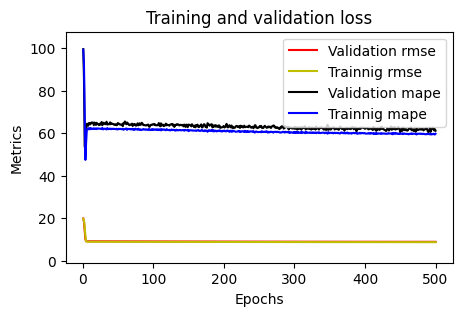

In [38]:
plotme(model2_1)

In [41]:
# inputs: distance + hour
model2_2 = nnmodel(5,10, num_hlayers=1,Epoch=1000)
model2_2

Epoch 1/1000
345/345 [==============================] - 1s 1ms/step - loss: 1120775.7500 - distance_layer_loss: 1.7549 - traveltime_layer_loss: 1400970.0000 - distance_layer_mape: 252095.3125 - distance_layer_rmse: 1.3247 - traveltime_layer_mape: 99.6177 - traveltime_layer_rmse: 1183.6257 - val_loss: 1139156.8750 - val_distance_layer_loss: 12.5414 - val_traveltime_layer_loss: 1423942.6250 - val_distance_layer_mape: 3037.1736 - val_distance_layer_rmse: 3.5414 - val_traveltime_layer_mape: 98.2040 - val_traveltime_layer_rmse: 1193.2906
Epoch 2/1000
345/345 [==============================] - 0s 965us/step - loss: 994421.7500 - distance_layer_loss: 114.6734 - traveltime_layer_loss: 1242999.5000 - distance_layer_mape: 406363.9688 - distance_layer_rmse: 10.7086 - traveltime_layer_mape: 89.3861 - traveltime_layer_rmse: 1114.8989 - val_loss: 841466.0625 - val_distance_layer_loss: 320.3318 - val_traveltime_layer_loss: 1051752.7500 - val_distance_layer_mape: 14785.2275 - val_distance_layer_rmse: 

345/345 [==============================] - 0s 970us/step - loss: 227193.9375 - distance_layer_loss: 2113.1033 - traveltime_layer_loss: 283464.2812 - distance_layer_mape: 4221807.5000 - distance_layer_rmse: 45.9685 - traveltime_layer_mape: 62.5074 - traveltime_layer_rmse: 532.4136 - val_loss: 238600.8906 - val_distance_layer_loss: 2064.4685 - val_traveltime_layer_loss: 297735.0000 - val_distance_layer_mape: 37286.3555 - val_distance_layer_rmse: 45.4364 - val_traveltime_layer_mape: 61.6778 - val_traveltime_layer_rmse: 545.6510
Epoch 17/1000
345/345 [==============================] - 0s 995us/step - loss: 227217.7812 - distance_layer_loss: 2085.9443 - traveltime_layer_loss: 283500.7500 - distance_layer_mape: 4169245.5000 - distance_layer_rmse: 45.6721 - traveltime_layer_mape: 61.8133 - traveltime_layer_rmse: 532.4479 - val_loss: 237752.2031 - val_distance_layer_loss: 2134.7600 - val_traveltime_layer_loss: 296656.5000 - val_distance_layer_mape: 37911.3906 - val_distance_layer_rmse: 46.2035

345/345 [==============================] - 0s 1ms/step - loss: 226526.8125 - distance_layer_loss: 2032.8217 - traveltime_layer_loss: 282650.3125 - distance_layer_mape: 4089958.2500 - distance_layer_rmse: 45.0868 - traveltime_layer_mape: 62.2693 - traveltime_layer_rmse: 531.6487 - val_loss: 236919.6719 - val_distance_layer_loss: 2027.4596 - val_traveltime_layer_loss: 295642.7188 - val_distance_layer_mape: 36918.8711 - val_distance_layer_rmse: 45.0273 - val_traveltime_layer_mape: 62.6869 - val_traveltime_layer_rmse: 543.7303
Epoch 32/1000
345/345 [==============================] - 0s 1ms/step - loss: 226365.8750 - distance_layer_loss: 2026.4868 - traveltime_layer_loss: 282450.5938 - distance_layer_mape: 4079286.7500 - distance_layer_rmse: 45.0165 - traveltime_layer_mape: 62.2319 - traveltime_layer_rmse: 531.4608 - val_loss: 236910.3438 - val_distance_layer_loss: 2016.6669 - val_traveltime_layer_loss: 295633.8125 - val_distance_layer_mape: 36818.5703 - val_distance_layer_rmse: 44.9073 - v

345/345 [==============================] - 0s 973us/step - loss: 225678.4062 - distance_layer_loss: 1928.3197 - traveltime_layer_loss: 281615.8438 - distance_layer_mape: 4003088.2500 - distance_layer_rmse: 43.9126 - traveltime_layer_mape: 61.8517 - traveltime_layer_rmse: 530.6749 - val_loss: 235871.3906 - val_distance_layer_loss: 1939.2908 - val_traveltime_layer_loss: 294354.5312 - val_distance_layer_mape: 36076.1289 - val_distance_layer_rmse: 44.0374 - val_traveltime_layer_mape: 62.7984 - val_traveltime_layer_rmse: 542.5445
Epoch 47/1000
345/345 [==============================] - 0s 975us/step - loss: 225624.6406 - distance_layer_loss: 1924.7252 - traveltime_layer_loss: 281549.5938 - distance_layer_mape: 3973951.5000 - distance_layer_rmse: 43.8717 - traveltime_layer_mape: 61.9433 - traveltime_layer_rmse: 530.6125 - val_loss: 235732.0781 - val_distance_layer_loss: 1954.0792 - val_traveltime_layer_loss: 294176.5625 - val_distance_layer_mape: 36210.7305 - val_distance_layer_rmse: 44.2050

345/345 [==============================] - 0s 944us/step - loss: 224879.6406 - distance_layer_loss: 1828.0172 - traveltime_layer_loss: 280642.5625 - distance_layer_mape: 3909405.5000 - distance_layer_rmse: 42.7553 - traveltime_layer_mape: 62.0302 - traveltime_layer_rmse: 529.7571 - val_loss: 234936.9688 - val_distance_layer_loss: 1829.4821 - val_traveltime_layer_loss: 293213.8438 - val_distance_layer_mape: 35008.5312 - val_distance_layer_rmse: 42.7724 - val_traveltime_layer_mape: 62.6729 - val_traveltime_layer_rmse: 541.4922
Epoch 62/1000
345/345 [==============================] - 0s 998us/step - loss: 224840.8125 - distance_layer_loss: 1820.5828 - traveltime_layer_loss: 280595.6562 - distance_layer_mape: 3852625.2500 - distance_layer_rmse: 42.6683 - traveltime_layer_mape: 62.0037 - traveltime_layer_rmse: 529.7128 - val_loss: 235102.9375 - val_distance_layer_loss: 1802.4976 - val_traveltime_layer_loss: 293428.0000 - val_distance_layer_mape: 34747.7227 - val_distance_layer_rmse: 42.4558

345/345 [==============================] - 0s 979us/step - loss: 224098.1562 - distance_layer_loss: 1706.3806 - traveltime_layer_loss: 279696.0938 - distance_layer_mape: 3750590.2500 - distance_layer_rmse: 41.3084 - traveltime_layer_mape: 61.6974 - traveltime_layer_rmse: 528.8630 - val_loss: 234139.8281 - val_distance_layer_loss: 1702.7023 - val_traveltime_layer_loss: 292249.1250 - val_distance_layer_mape: 33742.3359 - val_distance_layer_rmse: 41.2638 - val_traveltime_layer_mape: 62.1933 - val_traveltime_layer_rmse: 540.6007
Epoch 77/1000
345/345 [==============================] - 0s 980us/step - loss: 224067.5000 - distance_layer_loss: 1699.8705 - traveltime_layer_loss: 279659.2500 - distance_layer_mape: 3730739.0000 - distance_layer_rmse: 41.2295 - traveltime_layer_mape: 61.7462 - traveltime_layer_rmse: 528.8282 - val_loss: 234042.5000 - val_distance_layer_loss: 1697.8757 - val_traveltime_layer_loss: 292128.7188 - val_distance_layer_mape: 33692.2070 - val_distance_layer_rmse: 41.2053

345/345 [==============================] - 0s 1ms/step - loss: 223378.3125 - distance_layer_loss: 1573.4049 - traveltime_layer_loss: 278829.6250 - distance_layer_mape: 3593414.2500 - distance_layer_rmse: 39.6662 - traveltime_layer_mape: 61.3086 - traveltime_layer_rmse: 528.0432 - val_loss: 233048.2656 - val_distance_layer_loss: 1600.1218 - val_traveltime_layer_loss: 290910.3438 - val_distance_layer_mape: 32675.2520 - val_distance_layer_rmse: 40.0015 - val_traveltime_layer_mape: 62.9107 - val_traveltime_layer_rmse: 539.3610
Epoch 92/1000
345/345 [==============================] - 0s 976us/step - loss: 223283.0000 - distance_layer_loss: 1571.6537 - traveltime_layer_loss: 278711.2188 - distance_layer_mape: 3571486.5000 - distance_layer_rmse: 39.6441 - traveltime_layer_mape: 61.5197 - traveltime_layer_rmse: 527.9311 - val_loss: 233275.2969 - val_distance_layer_loss: 1559.8331 - val_traveltime_layer_loss: 291204.1875 - val_distance_layer_mape: 32259.0000 - val_distance_layer_rmse: 39.4947 -

345/345 [==============================] - 0s 992us/step - loss: 222641.1719 - distance_layer_loss: 1444.4858 - traveltime_layer_loss: 277940.2812 - distance_layer_mape: 3421072.7500 - distance_layer_rmse: 38.0064 - traveltime_layer_mape: 61.0842 - traveltime_layer_rmse: 527.2004 - val_loss: 232150.4219 - val_distance_layer_loss: 1465.5745 - val_traveltime_layer_loss: 289821.6250 - val_distance_layer_mape: 31235.2480 - val_distance_layer_rmse: 38.2828 - val_traveltime_layer_mape: 62.5218 - val_traveltime_layer_rmse: 538.3508
Epoch 107/1000
345/345 [==============================] - 0s 965us/step - loss: 222598.7969 - distance_layer_loss: 1446.6217 - traveltime_layer_loss: 277886.9062 - distance_layer_mape: 3426251.0000 - distance_layer_rmse: 38.0345 - traveltime_layer_mape: 61.4986 - traveltime_layer_rmse: 527.1498 - val_loss: 232307.8281 - val_distance_layer_loss: 1435.4000 - val_traveltime_layer_loss: 290026.0312 - val_distance_layer_mape: 30909.2773 - val_distance_layer_rmse: 37.886

345/345 [==============================] - 0s 959us/step - loss: 221865.3750 - distance_layer_loss: 1326.3015 - traveltime_layer_loss: 277000.1250 - distance_layer_mape: 3246465.7500 - distance_layer_rmse: 36.4184 - traveltime_layer_mape: 61.1801 - traveltime_layer_rmse: 526.3080 - val_loss: 231798.9062 - val_distance_layer_loss: 1304.7621 - val_traveltime_layer_loss: 289422.5000 - val_distance_layer_mape: 29433.7480 - val_distance_layer_rmse: 36.1215 - val_traveltime_layer_mape: 60.9088 - val_traveltime_layer_rmse: 537.9800
Epoch 122/1000
345/345 [==============================] - 0s 954us/step - loss: 221846.1250 - distance_layer_loss: 1311.9696 - traveltime_layer_loss: 276979.8438 - distance_layer_mape: 3270942.0000 - distance_layer_rmse: 36.2211 - traveltime_layer_mape: 60.9333 - traveltime_layer_rmse: 526.2888 - val_loss: 231199.6875 - val_distance_layer_loss: 1330.4962 - val_traveltime_layer_loss: 288667.0000 - val_distance_layer_mape: 29720.6348 - val_distance_layer_rmse: 36.476

345/345 [==============================] - 0s 981us/step - loss: 221190.7188 - distance_layer_loss: 1200.2408 - traveltime_layer_loss: 276188.3438 - distance_layer_mape: 3093261.2500 - distance_layer_rmse: 34.6445 - traveltime_layer_mape: 60.8488 - traveltime_layer_rmse: 525.5363 - val_loss: 230381.7656 - val_distance_layer_loss: 1212.8179 - val_traveltime_layer_loss: 287674.0000 - val_distance_layer_mape: 28337.8301 - val_distance_layer_rmse: 34.8255 - val_traveltime_layer_mape: 61.9939 - val_traveltime_layer_rmse: 536.3525
Epoch 137/1000
345/345 [==============================] - 0s 997us/step - loss: 221197.5781 - distance_layer_loss: 1195.4504 - traveltime_layer_loss: 276198.3125 - distance_layer_mape: 3077559.0000 - distance_layer_rmse: 34.5753 - traveltime_layer_mape: 60.9840 - traveltime_layer_rmse: 525.5457 - val_loss: 230649.8125 - val_distance_layer_loss: 1183.5802 - val_traveltime_layer_loss: 288016.1875 - val_distance_layer_mape: 27990.5098 - val_distance_layer_rmse: 34.403

345/345 [==============================] - 0s 944us/step - loss: 220540.8281 - distance_layer_loss: 1095.8651 - traveltime_layer_loss: 275402.0625 - distance_layer_mape: 2972558.7500 - distance_layer_rmse: 33.1039 - traveltime_layer_mape: 61.0090 - traveltime_layer_rmse: 524.7877 - val_loss: 229833.5000 - val_distance_layer_loss: 1082.1027 - val_traveltime_layer_loss: 287021.3125 - val_distance_layer_mape: 26725.1113 - val_distance_layer_rmse: 32.8953 - val_traveltime_layer_mape: 60.9118 - val_traveltime_layer_rmse: 535.7437
Epoch 152/1000
345/345 [==============================] - 0s 959us/step - loss: 220491.4844 - distance_layer_loss: 1083.9132 - traveltime_layer_loss: 275343.4688 - distance_layer_mape: 2971370.0000 - distance_layer_rmse: 32.9228 - traveltime_layer_mape: 60.7824 - traveltime_layer_rmse: 524.7318 - val_loss: 229503.8594 - val_distance_layer_loss: 1091.2979 - val_traveltime_layer_loss: 286606.9375 - val_distance_layer_mape: 26836.4531 - val_distance_layer_rmse: 33.034

345/345 [==============================] - 0s 960us/step - loss: 220004.8906 - distance_layer_loss: 990.9941 - traveltime_layer_loss: 274758.3125 - distance_layer_mape: 2816880.0000 - distance_layer_rmse: 31.4801 - traveltime_layer_mape: 60.7018 - traveltime_layer_rmse: 524.1740 - val_loss: 228776.8438 - val_distance_layer_loss: 996.2407 - val_traveltime_layer_loss: 285722.0938 - val_distance_layer_mape: 25601.7070 - val_distance_layer_rmse: 31.5633 - val_traveltime_layer_mape: 61.4817 - val_traveltime_layer_rmse: 534.5298
Epoch 167/1000
345/345 [==============================] - 0s 1ms/step - loss: 219934.3281 - distance_layer_loss: 988.2604 - traveltime_layer_loss: 274670.8438 - distance_layer_mape: 2771976.0000 - distance_layer_rmse: 31.4366 - traveltime_layer_mape: 60.8979 - traveltime_layer_rmse: 524.0905 - val_loss: 228913.7969 - val_distance_layer_loss: 977.5555 - val_traveltime_layer_loss: 285897.8750 - val_distance_layer_mape: 25356.2285 - val_distance_layer_rmse: 31.2659 - va

345/345 [==============================] - 0s 954us/step - loss: 219416.6250 - distance_layer_loss: 900.2331 - traveltime_layer_loss: 274045.8125 - distance_layer_mape: 2671999.5000 - distance_layer_rmse: 30.0039 - traveltime_layer_mape: 60.3832 - traveltime_layer_rmse: 523.4938 - val_loss: 228023.7188 - val_distance_layer_loss: 916.0435 - val_traveltime_layer_loss: 284800.6250 - val_distance_layer_mape: 24509.6914 - val_distance_layer_rmse: 30.2662 - val_traveltime_layer_mape: 61.7578 - val_traveltime_layer_rmse: 533.6672
Epoch 182/1000
345/345 [==============================] - 0s 989us/step - loss: 219370.4844 - distance_layer_loss: 902.9434 - traveltime_layer_loss: 273987.4688 - distance_layer_mape: 2626551.0000 - distance_layer_rmse: 30.0490 - traveltime_layer_mape: 60.7846 - traveltime_layer_rmse: 523.4381 - val_loss: 228581.0312 - val_distance_layer_loss: 880.3134 - val_traveltime_layer_loss: 285506.1875 - val_distance_layer_mape: 24021.0469 - val_distance_layer_rmse: 29.6701 - 

345/345 [==============================] - 0s 954us/step - loss: 219046.3594 - distance_layer_loss: 827.0082 - traveltime_layer_loss: 273601.1875 - distance_layer_mape: 2568548.5000 - distance_layer_rmse: 28.7577 - traveltime_layer_mape: 60.3133 - traveltime_layer_rmse: 523.0690 - val_loss: 227670.3438 - val_distance_layer_loss: 821.8571 - val_traveltime_layer_loss: 284382.5312 - val_distance_layer_mape: 23175.4180 - val_distance_layer_rmse: 28.6681 - val_traveltime_layer_mape: 60.4524 - val_traveltime_layer_rmse: 533.2753
Epoch 197/1000
345/345 [==============================] - 0s 965us/step - loss: 218987.0312 - distance_layer_loss: 820.7545 - traveltime_layer_loss: 273528.6875 - distance_layer_mape: 2527971.7500 - distance_layer_rmse: 28.6488 - traveltime_layer_mape: 60.2286 - traveltime_layer_rmse: 522.9997 - val_loss: 227742.8750 - val_distance_layer_loss: 813.4365 - val_traveltime_layer_loss: 284475.0625 - val_distance_layer_mape: 23053.2852 - val_distance_layer_rmse: 28.5208 - 

345/345 [==============================] - 0s 980us/step - loss: 218480.9375 - distance_layer_loss: 764.9740 - traveltime_layer_loss: 272909.9375 - distance_layer_mape: 2426425.5000 - distance_layer_rmse: 27.6582 - traveltime_layer_mape: 60.0251 - traveltime_layer_rmse: 522.4078 - val_loss: 226867.3750 - val_distance_layer_loss: 782.9462 - val_traveltime_layer_loss: 283388.4062 - val_distance_layer_mape: 22590.9766 - val_distance_layer_rmse: 27.9812 - val_traveltime_layer_mape: 61.6065 - val_traveltime_layer_rmse: 532.3424
Epoch 212/1000
345/345 [==============================] - 0s 979us/step - loss: 218621.5312 - distance_layer_loss: 766.6757 - traveltime_layer_loss: 273085.2500 - distance_layer_mape: 2459200.5000 - distance_layer_rmse: 27.6889 - traveltime_layer_mape: 60.3963 - traveltime_layer_rmse: 522.5756 - val_loss: 227022.3281 - val_distance_layer_loss: 761.6523 - val_traveltime_layer_loss: 283587.5000 - val_distance_layer_mape: 22276.5879 - val_distance_layer_rmse: 27.5980 - 

345/345 [==============================] - 0s 971us/step - loss: 218173.8750 - distance_layer_loss: 716.8487 - traveltime_layer_loss: 272538.1562 - distance_layer_mape: 2349070.2500 - distance_layer_rmse: 26.7740 - traveltime_layer_mape: 59.9859 - traveltime_layer_rmse: 522.0519 - val_loss: 226476.6250 - val_distance_layer_loss: 721.1132 - val_traveltime_layer_loss: 282915.4375 - val_distance_layer_mape: 21651.6250 - val_distance_layer_rmse: 26.8535 - val_traveltime_layer_mape: 60.6479 - val_traveltime_layer_rmse: 531.8979
Epoch 227/1000
345/345 [==============================] - 0s 983us/step - loss: 218213.7656 - distance_layer_loss: 715.5368 - traveltime_layer_loss: 272588.4375 - distance_layer_mape: 2337715.7500 - distance_layer_rmse: 26.7495 - traveltime_layer_mape: 60.1050 - traveltime_layer_rmse: 522.1000 - val_loss: 226650.8594 - val_distance_layer_loss: 709.0927 - val_traveltime_layer_loss: 283136.2812 - val_distance_layer_mape: 21466.4902 - val_distance_layer_rmse: 26.6288 - 

345/345 [==============================] - 0s 982us/step - loss: 217873.9219 - distance_layer_loss: 675.6863 - traveltime_layer_loss: 272173.5625 - distance_layer_mape: 2291753.7500 - distance_layer_rmse: 25.9940 - traveltime_layer_mape: 60.0757 - traveltime_layer_rmse: 521.7026 - val_loss: 225962.4844 - val_distance_layer_loss: 679.2566 - val_traveltime_layer_loss: 282283.1875 - val_distance_layer_mape: 20989.1680 - val_distance_layer_rmse: 26.0626 - val_traveltime_layer_mape: 60.7113 - val_traveltime_layer_rmse: 531.3033
Epoch 242/1000
345/345 [==============================] - 0s 960us/step - loss: 217896.3438 - distance_layer_loss: 669.2429 - traveltime_layer_loss: 272203.1250 - distance_layer_mape: 2284876.2500 - distance_layer_rmse: 25.8697 - traveltime_layer_mape: 59.8601 - traveltime_layer_rmse: 521.7309 - val_loss: 225992.5938 - val_distance_layer_loss: 672.2936 - val_traveltime_layer_loss: 282322.7812 - val_distance_layer_mape: 20878.5996 - val_distance_layer_rmse: 25.9286 - 

345/345 [==============================] - 0s 1ms/step - loss: 213992.9375 - distance_layer_loss: 600.1485 - traveltime_layer_loss: 267341.1875 - distance_layer_mape: 2140316.0000 - distance_layer_rmse: 24.4979 - traveltime_layer_mape: 59.0299 - traveltime_layer_rmse: 517.0505 - val_loss: 221884.3594 - val_distance_layer_loss: 616.4729 - val_traveltime_layer_loss: 277201.3438 - val_distance_layer_mape: 19912.4180 - val_distance_layer_rmse: 24.8289 - val_traveltime_layer_mape: 60.9796 - val_traveltime_layer_rmse: 526.4991
Epoch 257/1000
345/345 [==============================] - 0s 1ms/step - loss: 213865.8281 - distance_layer_loss: 598.9877 - traveltime_layer_loss: 267182.4375 - distance_layer_mape: 2117157.5000 - distance_layer_rmse: 24.4742 - traveltime_layer_mape: 59.3722 - traveltime_layer_rmse: 516.8969 - val_loss: 221717.0625 - val_distance_layer_loss: 613.5897 - val_traveltime_layer_loss: 276992.9062 - val_distance_layer_mape: 19855.6191 - val_distance_layer_rmse: 24.7707 - val_

345/345 [==============================] - 0s 1ms/step - loss: 211606.5469 - distance_layer_loss: 538.2822 - traveltime_layer_loss: 264373.8125 - distance_layer_mape: 1989701.2500 - distance_layer_rmse: 23.2009 - traveltime_layer_mape: 58.6927 - traveltime_layer_rmse: 514.1729 - val_loss: 219008.4375 - val_distance_layer_loss: 533.9183 - val_traveltime_layer_loss: 273627.0938 - val_distance_layer_mape: 18349.2324 - val_distance_layer_rmse: 23.1067 - val_traveltime_layer_mape: 58.7062 - val_traveltime_layer_rmse: 523.0938
Epoch 272/1000
345/345 [==============================] - 0s 967us/step - loss: 211432.6562 - distance_layer_loss: 531.1693 - traveltime_layer_loss: 264157.9688 - distance_layer_mape: 1972626.0000 - distance_layer_rmse: 23.0471 - traveltime_layer_mape: 58.3381 - traveltime_layer_rmse: 513.9630 - val_loss: 218654.7344 - val_distance_layer_loss: 539.0750 - val_traveltime_layer_loss: 273183.7188 - val_distance_layer_mape: 18430.1562 - val_distance_layer_rmse: 23.2180 - va

345/345 [==============================] - 0s 951us/step - loss: 209688.1094 - distance_layer_loss: 493.4346 - traveltime_layer_loss: 261986.9375 - distance_layer_mape: 1882041.6250 - distance_layer_rmse: 22.2134 - traveltime_layer_mape: 57.8352 - traveltime_layer_rmse: 511.8466 - val_loss: 216565.4688 - val_distance_layer_loss: 494.4964 - val_traveltime_layer_loss: 270583.2812 - val_distance_layer_mape: 17538.5293 - val_distance_layer_rmse: 22.2373 - val_traveltime_layer_mape: 58.3728 - val_traveltime_layer_rmse: 520.1762
Epoch 287/1000
345/345 [==============================] - 0s 980us/step - loss: 209477.0156 - distance_layer_loss: 494.1623 - traveltime_layer_loss: 261722.5312 - distance_layer_mape: 1888290.2500 - distance_layer_rmse: 22.2298 - traveltime_layer_mape: 58.1127 - traveltime_layer_rmse: 511.5883 - val_loss: 216916.3281 - val_distance_layer_loss: 482.4142 - val_traveltime_layer_loss: 271024.8750 - val_distance_layer_mape: 17298.4805 - val_distance_layer_rmse: 21.9639 - 

345/345 [==============================] - 0s 989us/step - loss: 207542.0312 - distance_layer_loss: 459.7546 - traveltime_layer_loss: 259312.6562 - distance_layer_mape: 1797073.6250 - distance_layer_rmse: 21.4419 - traveltime_layer_mape: 57.2669 - traveltime_layer_rmse: 509.2275 - val_loss: 213905.7031 - val_distance_layer_loss: 465.5537 - val_traveltime_layer_loss: 267265.7188 - val_distance_layer_mape: 16916.7598 - val_distance_layer_rmse: 21.5767 - val_traveltime_layer_mape: 58.1703 - val_traveltime_layer_rmse: 516.9775
Epoch 302/1000
345/345 [==============================] - 0s 957us/step - loss: 207418.6719 - distance_layer_loss: 459.5173 - traveltime_layer_loss: 259158.4062 - distance_layer_mape: 1800144.2500 - distance_layer_rmse: 21.4364 - traveltime_layer_mape: 57.4670 - traveltime_layer_rmse: 509.0760 - val_loss: 213897.8750 - val_distance_layer_loss: 458.4765 - val_traveltime_layer_loss: 267257.6562 - val_distance_layer_mape: 16777.1250 - val_distance_layer_rmse: 21.4121 - 

345/345 [==============================] - 0s 976us/step - loss: 205198.0156 - distance_layer_loss: 428.6155 - traveltime_layer_loss: 256390.3438 - distance_layer_mape: 1726342.7500 - distance_layer_rmse: 20.7030 - traveltime_layer_mape: 57.0437 - traveltime_layer_rmse: 506.3500 - val_loss: 211367.1875 - val_distance_layer_loss: 425.6724 - val_traveltime_layer_loss: 264102.5000 - val_distance_layer_mape: 16090.6279 - val_distance_layer_rmse: 20.6318 - val_traveltime_layer_mape: 56.9838 - val_traveltime_layer_rmse: 513.9091
Epoch 317/1000
345/345 [==============================] - 0s 978us/step - loss: 205014.2812 - distance_layer_loss: 424.6027 - traveltime_layer_loss: 256161.7344 - distance_layer_mape: 1726344.7500 - distance_layer_rmse: 20.6059 - traveltime_layer_mape: 56.8446 - traveltime_layer_rmse: 506.1242 - val_loss: 211263.8594 - val_distance_layer_loss: 421.7012 - val_traveltime_layer_loss: 263974.3750 - val_distance_layer_mape: 16001.7295 - val_distance_layer_rmse: 20.5354 - 

345/345 [==============================] - 0s 966us/step - loss: 202488.7188 - distance_layer_loss: 390.8461 - traveltime_layer_loss: 253013.2188 - distance_layer_mape: 1640266.1250 - distance_layer_rmse: 19.7698 - traveltime_layer_mape: 56.6534 - traveltime_layer_rmse: 503.0042 - val_loss: 208421.7656 - val_distance_layer_loss: 384.5337 - val_traveltime_layer_loss: 260431.2344 - val_distance_layer_mape: 15209.1006 - val_distance_layer_rmse: 19.6095 - val_traveltime_layer_mape: 56.1426 - val_traveltime_layer_rmse: 510.3246
Epoch 332/1000
345/345 [==============================] - 0s 956us/step - loss: 202262.6094 - distance_layer_loss: 385.6872 - traveltime_layer_loss: 252731.7188 - distance_layer_mape: 1623332.1250 - distance_layer_rmse: 19.6389 - traveltime_layer_mape: 56.2829 - traveltime_layer_rmse: 502.7243 - val_loss: 208018.7500 - val_distance_layer_loss: 397.0023 - val_traveltime_layer_loss: 259924.1094 - val_distance_layer_mape: 15440.2627 - val_distance_layer_rmse: 19.9249 - 

345/345 [==============================] - 0s 987us/step - loss: 199283.3438 - distance_layer_loss: 348.5421 - traveltime_layer_loss: 249016.9062 - distance_layer_mape: 1526776.5000 - distance_layer_rmse: 18.6693 - traveltime_layer_mape: 55.8770 - traveltime_layer_rmse: 499.0159 - val_loss: 204477.3438 - val_distance_layer_loss: 349.5164 - val_traveltime_layer_loss: 255509.1875 - val_distance_layer_mape: 14407.5215 - val_distance_layer_rmse: 18.6954 - val_traveltime_layer_mape: 56.1864 - val_traveltime_layer_rmse: 505.4792
Epoch 347/1000
345/345 [==============================] - 0s 963us/step - loss: 199054.0312 - distance_layer_loss: 344.7187 - traveltime_layer_loss: 248731.4531 - distance_layer_mape: 1514001.5000 - distance_layer_rmse: 18.5666 - traveltime_layer_mape: 55.7764 - traveltime_layer_rmse: 498.7298 - val_loss: 204230.9062 - val_distance_layer_loss: 348.8775 - val_traveltime_layer_loss: 255201.4531 - val_distance_layer_mape: 14377.7119 - val_distance_layer_rmse: 18.6783 - 

345/345 [==============================] - 0s 950us/step - loss: 195463.2656 - distance_layer_loss: 302.4913 - traveltime_layer_loss: 244253.5156 - distance_layer_mape: 1416885.7500 - distance_layer_rmse: 17.3923 - traveltime_layer_mape: 55.4515 - traveltime_layer_rmse: 494.2201 - val_loss: 200455.0312 - val_distance_layer_loss: 296.9371 - val_traveltime_layer_loss: 250494.5938 - val_distance_layer_mape: 13185.0840 - val_distance_layer_rmse: 17.2319 - val_traveltime_layer_mape: 54.7822 - val_traveltime_layer_rmse: 500.4944
Epoch 362/1000
345/345 [==============================] - 0s 987us/step - loss: 195153.2500 - distance_layer_loss: 298.1870 - traveltime_layer_loss: 243866.9219 - distance_layer_mape: 1393736.5000 - distance_layer_rmse: 17.2681 - traveltime_layer_mape: 55.1616 - traveltime_layer_rmse: 493.8288 - val_loss: 199905.7188 - val_distance_layer_loss: 296.5846 - val_traveltime_layer_loss: 249807.9688 - val_distance_layer_mape: 13176.1943 - val_distance_layer_rmse: 17.2216 - 

345/345 [==============================] - 0s 965us/step - loss: 190835.1562 - distance_layer_loss: 252.2566 - traveltime_layer_loss: 238480.7500 - distance_layer_mape: 1294851.1250 - distance_layer_rmse: 15.8826 - traveltime_layer_mape: 54.3911 - traveltime_layer_rmse: 488.3449 - val_loss: 194851.6562 - val_distance_layer_loss: 254.5331 - val_traveltime_layer_loss: 243500.9219 - val_distance_layer_mape: 12111.8525 - val_distance_layer_rmse: 15.9541 - val_traveltime_layer_mape: 55.0259 - val_traveltime_layer_rmse: 493.4581
Epoch 377/1000
345/345 [==============================] - 0s 965us/step - loss: 190443.0625 - distance_layer_loss: 249.3295 - traveltime_layer_loss: 237991.4688 - distance_layer_mape: 1290321.6250 - distance_layer_rmse: 15.7902 - traveltime_layer_mape: 54.3738 - traveltime_layer_rmse: 487.8437 - val_loss: 194631.4531 - val_distance_layer_loss: 247.8270 - val_traveltime_layer_loss: 243227.3750 - val_distance_layer_mape: 11936.7979 - val_distance_layer_rmse: 15.7425 - 

345/345 [==============================] - 0s 969us/step - loss: 185439.5469 - distance_layer_loss: 203.9387 - traveltime_layer_loss: 231748.4531 - distance_layer_mape: 1148236.3750 - distance_layer_rmse: 14.2807 - traveltime_layer_mape: 53.3934 - traveltime_layer_rmse: 481.4026 - val_loss: 189936.8125 - val_distance_layer_loss: 198.1106 - val_traveltime_layer_loss: 237371.4219 - val_distance_layer_mape: 10600.7217 - val_distance_layer_rmse: 14.0752 - val_traveltime_layer_mape: 52.7778 - val_traveltime_layer_rmse: 487.2078
Epoch 392/1000
345/345 [==============================] - 0s 972us/step - loss: 185239.7344 - distance_layer_loss: 199.2034 - traveltime_layer_loss: 231499.8594 - distance_layer_mape: 1120541.1250 - distance_layer_rmse: 14.1139 - traveltime_layer_mape: 53.0237 - traveltime_layer_rmse: 481.1443 - val_loss: 188548.9688 - val_distance_layer_loss: 204.5368 - val_traveltime_layer_loss: 235635.0312 - val_distance_layer_mape: 10699.3057 - val_distance_layer_rmse: 14.3016 - 

345/345 [==============================] - 0s 972us/step - loss: 179888.8750 - distance_layer_loss: 162.2209 - traveltime_layer_loss: 224820.5469 - distance_layer_mape: 1004415.9375 - distance_layer_rmse: 12.7366 - traveltime_layer_mape: 52.1393 - traveltime_layer_rmse: 474.1525 - val_loss: 182993.1406 - val_distance_layer_loss: 162.5099 - val_traveltime_layer_loss: 228700.8125 - val_distance_layer_mape: 9434.6514 - val_distance_layer_rmse: 12.7479 - val_traveltime_layer_mape: 52.2147 - val_traveltime_layer_rmse: 478.2267
Epoch 407/1000
345/345 [==============================] - 0s 966us/step - loss: 179477.6250 - distance_layer_loss: 160.1375 - traveltime_layer_loss: 224307.0625 - distance_layer_mape: 1008692.6250 - distance_layer_rmse: 12.6545 - traveltime_layer_mape: 52.2365 - traveltime_layer_rmse: 473.6107 - val_loss: 182949.1250 - val_distance_layer_loss: 157.4010 - val_traveltime_layer_loss: 228647.1406 - val_distance_layer_mape: 9279.2480 - val_distance_layer_rmse: 12.5460 - va

345/345 [==============================] - 0s 974us/step - loss: 175684.3281 - distance_layer_loss: 132.5801 - traveltime_layer_loss: 219572.2656 - distance_layer_mape: 915272.0000 - distance_layer_rmse: 11.5143 - traveltime_layer_mape: 51.4655 - traveltime_layer_rmse: 468.5854 - val_loss: 178441.0781 - val_distance_layer_loss: 132.8780 - val_traveltime_layer_loss: 223018.1406 - val_distance_layer_mape: 8417.4932 - val_distance_layer_rmse: 11.5273 - val_traveltime_layer_mape: 51.2666 - val_traveltime_layer_rmse: 472.2480
Epoch 422/1000
345/345 [==============================] - 0s 952us/step - loss: 175340.4531 - distance_layer_loss: 130.8170 - traveltime_layer_loss: 219142.9219 - distance_layer_mape: 903033.2500 - distance_layer_rmse: 11.4375 - traveltime_layer_mape: 51.2042 - traveltime_layer_rmse: 468.1270 - val_loss: 178188.4844 - val_distance_layer_loss: 132.0938 - val_traveltime_layer_loss: 222702.5938 - val_distance_layer_mape: 8372.7803 - val_distance_layer_rmse: 11.4932 - val_

345/345 [==============================] - 0s 962us/step - loss: 173699.9688 - distance_layer_loss: 116.9087 - traveltime_layer_loss: 217095.7656 - distance_layer_mape: 843475.5000 - distance_layer_rmse: 10.8124 - traveltime_layer_mape: 50.7840 - traveltime_layer_rmse: 465.9354 - val_loss: 176699.2188 - val_distance_layer_loss: 117.5801 - val_traveltime_layer_loss: 220844.5469 - val_distance_layer_mape: 7868.3931 - val_distance_layer_rmse: 10.8434 - val_traveltime_layer_mape: 50.8663 - val_traveltime_layer_rmse: 469.9410
Epoch 437/1000
345/345 [==============================] - 0s 1ms/step - loss: 173523.8438 - distance_layer_loss: 116.1146 - traveltime_layer_loss: 216875.8281 - distance_layer_mape: 840363.9375 - distance_layer_rmse: 10.7757 - traveltime_layer_mape: 50.6061 - traveltime_layer_rmse: 465.6993 - val_loss: 176741.4688 - val_distance_layer_loss: 115.4858 - val_traveltime_layer_loss: 220897.9531 - val_distance_layer_mape: 7761.2002 - val_distance_layer_rmse: 10.7464 - val_tr

345/345 [==============================] - 0s 961us/step - loss: 172778.2969 - distance_layer_loss: 109.0905 - traveltime_layer_loss: 215945.5938 - distance_layer_mape: 813739.7500 - distance_layer_rmse: 10.4446 - traveltime_layer_mape: 49.9610 - traveltime_layer_rmse: 464.6995 - val_loss: 175796.9062 - val_distance_layer_loss: 115.6773 - val_traveltime_layer_loss: 219717.1719 - val_distance_layer_mape: 7727.2812 - val_distance_layer_rmse: 10.7553 - val_traveltime_layer_mape: 51.8066 - val_traveltime_layer_rmse: 468.7400
Epoch 452/1000
345/345 [==============================] - 0s 959us/step - loss: 172740.3125 - distance_layer_loss: 110.1277 - traveltime_layer_loss: 215897.8750 - distance_layer_mape: 816074.0625 - distance_layer_rmse: 10.4942 - traveltime_layer_mape: 50.4894 - traveltime_layer_rmse: 464.6481 - val_loss: 176237.9062 - val_distance_layer_loss: 108.1927 - val_traveltime_layer_loss: 220270.3125 - val_distance_layer_mape: 7526.1997 - val_distance_layer_rmse: 10.4016 - val_

345/345 [==============================] - 0s 982us/step - loss: 172076.7969 - distance_layer_loss: 106.2313 - traveltime_layer_loss: 215069.4375 - distance_layer_mape: 808175.5000 - distance_layer_rmse: 10.3069 - traveltime_layer_mape: 49.8592 - traveltime_layer_rmse: 463.7558 - val_loss: 174899.5938 - val_distance_layer_loss: 108.6947 - val_traveltime_layer_loss: 218597.3125 - val_distance_layer_mape: 7498.4155 - val_distance_layer_rmse: 10.4257 - val_traveltime_layer_mape: 50.4587 - val_traveltime_layer_rmse: 467.5439
Epoch 467/1000
345/345 [==============================] - 0s 967us/step - loss: 171865.3125 - distance_layer_loss: 106.7054 - traveltime_layer_loss: 214804.9062 - distance_layer_mape: 802531.4375 - distance_layer_rmse: 10.3298 - traveltime_layer_mape: 50.2411 - traveltime_layer_rmse: 463.4705 - val_loss: 175792.0312 - val_distance_layer_loss: 104.1441 - val_traveltime_layer_loss: 219714.0469 - val_distance_layer_mape: 7357.6099 - val_distance_layer_rmse: 10.2051 - val_

345/345 [==============================] - 0s 1ms/step - loss: 171262.2188 - distance_layer_loss: 104.2626 - traveltime_layer_loss: 214051.7812 - distance_layer_mape: 784199.6250 - distance_layer_rmse: 10.2109 - traveltime_layer_mape: 49.8299 - traveltime_layer_rmse: 462.6573 - val_loss: 174233.8125 - val_distance_layer_loss: 106.9138 - val_traveltime_layer_loss: 217765.5000 - val_distance_layer_mape: 7442.2344 - val_distance_layer_rmse: 10.3399 - val_traveltime_layer_mape: 50.6894 - val_traveltime_layer_rmse: 466.6535
Epoch 482/1000
345/345 [==============================] - 0s 976us/step - loss: 171307.5469 - distance_layer_loss: 103.8948 - traveltime_layer_loss: 214108.5312 - distance_layer_mape: 785760.5000 - distance_layer_rmse: 10.1929 - traveltime_layer_mape: 49.7635 - traveltime_layer_rmse: 462.7186 - val_loss: 174190.7188 - val_distance_layer_loss: 106.3590 - val_traveltime_layer_loss: 217711.7344 - val_distance_layer_mape: 7418.1328 - val_distance_layer_rmse: 10.3130 - val_tr

345/345 [==============================] - 0s 950us/step - loss: 170754.0312 - distance_layer_loss: 102.2175 - traveltime_layer_loss: 213416.9219 - distance_layer_mape: 784792.6875 - distance_layer_rmse: 10.1103 - traveltime_layer_mape: 49.8228 - traveltime_layer_rmse: 461.9707 - val_loss: 173652.7656 - val_distance_layer_loss: 102.7206 - val_traveltime_layer_loss: 217040.2812 - val_distance_layer_mape: 7267.8066 - val_distance_layer_rmse: 10.1351 - val_traveltime_layer_mape: 49.6727 - val_traveltime_layer_rmse: 465.8758
Epoch 497/1000
345/345 [==============================] - 0s 971us/step - loss: 170570.5312 - distance_layer_loss: 102.5998 - traveltime_layer_loss: 213187.4688 - distance_layer_mape: 788244.7500 - distance_layer_rmse: 10.1292 - traveltime_layer_mape: 50.0675 - traveltime_layer_rmse: 461.7223 - val_loss: 173430.6094 - val_distance_layer_loss: 104.6357 - val_traveltime_layer_loss: 216762.0781 - val_distance_layer_mape: 7304.9907 - val_distance_layer_rmse: 10.2292 - val_

345/345 [==============================] - 0s 955us/step - loss: 169986.3906 - distance_layer_loss: 100.1380 - traveltime_layer_loss: 212457.8438 - distance_layer_mape: 776364.3750 - distance_layer_rmse: 10.0069 - traveltime_layer_mape: 49.7249 - traveltime_layer_rmse: 460.9315 - val_loss: 172844.2031 - val_distance_layer_loss: 101.2422 - val_traveltime_layer_loss: 216030.0156 - val_distance_layer_mape: 7213.5283 - val_distance_layer_rmse: 10.0619 - val_traveltime_layer_mape: 49.9041 - val_traveltime_layer_rmse: 464.7903
Epoch 512/1000
345/345 [==============================] - 0s 944us/step - loss: 169900.7031 - distance_layer_loss: 99.9164 - traveltime_layer_loss: 212350.8906 - distance_layer_mape: 772832.5625 - distance_layer_rmse: 9.9958 - traveltime_layer_mape: 49.7928 - traveltime_layer_rmse: 460.8155 - val_loss: 172937.1562 - val_distance_layer_loss: 99.8672 - val_traveltime_layer_loss: 216146.4531 - val_distance_layer_mape: 7142.5762 - val_distance_layer_rmse: 9.9934 - val_trav

345/345 [==============================] - 0s 947us/step - loss: 169336.7969 - distance_layer_loss: 97.3116 - traveltime_layer_loss: 211646.6406 - distance_layer_mape: 763896.8125 - distance_layer_rmse: 9.8647 - traveltime_layer_mape: 49.4589 - traveltime_layer_rmse: 460.0507 - val_loss: 172293.5781 - val_distance_layer_loss: 98.5649 - val_traveltime_layer_loss: 215342.3750 - val_distance_layer_mape: 7145.0942 - val_distance_layer_rmse: 9.9280 - val_traveltime_layer_mape: 50.0896 - val_traveltime_layer_rmse: 464.0500
Epoch 527/1000
345/345 [==============================] - 0s 934us/step - loss: 169270.0000 - distance_layer_loss: 97.8205 - traveltime_layer_loss: 211563.0312 - distance_layer_mape: 757435.3125 - distance_layer_rmse: 9.8904 - traveltime_layer_mape: 49.7860 - traveltime_layer_rmse: 459.9598 - val_loss: 172400.6875 - val_distance_layer_loss: 97.1234 - val_traveltime_layer_loss: 215476.5938 - val_distance_layer_mape: 7079.5693 - val_distance_layer_rmse: 9.8551 - val_travelti

345/345 [==============================] - 0s 990us/step - loss: 168753.7656 - distance_layer_loss: 94.4474 - traveltime_layer_loss: 210918.5781 - distance_layer_mape: 754408.1875 - distance_layer_rmse: 9.7184 - traveltime_layer_mape: 49.5397 - traveltime_layer_rmse: 459.2587 - val_loss: 171606.7500 - val_distance_layer_loss: 95.8809 - val_traveltime_layer_loss: 214484.4375 - val_distance_layer_mape: 6927.1670 - val_distance_layer_rmse: 9.7919 - val_traveltime_layer_mape: 48.8499 - val_traveltime_layer_rmse: 463.1246
Epoch 542/1000
345/345 [==============================] - 0s 974us/step - loss: 168507.4844 - distance_layer_loss: 94.4645 - traveltime_layer_loss: 210610.8281 - distance_layer_mape: 744112.3750 - distance_layer_rmse: 9.7193 - traveltime_layer_mape: 49.4655 - traveltime_layer_rmse: 458.9236 - val_loss: 171291.5781 - val_distance_layer_loss: 97.3876 - val_traveltime_layer_loss: 214090.1875 - val_distance_layer_mape: 7004.9946 - val_distance_layer_rmse: 9.8685 - val_travelti

345/345 [==============================] - 0s 1ms/step - loss: 167745.5625 - distance_layer_loss: 91.3495 - traveltime_layer_loss: 209659.2344 - distance_layer_mape: 735459.3125 - distance_layer_rmse: 9.5577 - traveltime_layer_mape: 49.2616 - traveltime_layer_rmse: 457.8856 - val_loss: 170393.4219 - val_distance_layer_loss: 94.1026 - val_traveltime_layer_loss: 212968.2188 - val_distance_layer_mape: 6938.3052 - val_distance_layer_rmse: 9.7007 - val_traveltime_layer_mape: 50.1655 - val_traveltime_layer_rmse: 461.4848
Epoch 557/1000
345/345 [==============================] - 0s 969us/step - loss: 167670.0156 - distance_layer_loss: 91.0239 - traveltime_layer_loss: 209564.7500 - distance_layer_mape: 734203.0625 - distance_layer_rmse: 9.5406 - traveltime_layer_mape: 49.1963 - traveltime_layer_rmse: 457.7824 - val_loss: 170481.3281 - val_distance_layer_loss: 92.8369 - val_traveltime_layer_loss: 213078.3750 - val_distance_layer_mape: 6912.1387 - val_distance_layer_rmse: 9.6352 - val_traveltime

345/345 [==============================] - 0s 993us/step - loss: 166998.0312 - distance_layer_loss: 87.4774 - traveltime_layer_loss: 208725.7344 - distance_layer_mape: 724416.1875 - distance_layer_rmse: 9.3529 - traveltime_layer_mape: 49.0181 - traveltime_layer_rmse: 456.8651 - val_loss: 169473.3906 - val_distance_layer_loss: 89.4299 - val_traveltime_layer_loss: 211819.4844 - val_distance_layer_mape: 6733.0928 - val_distance_layer_rmse: 9.4567 - val_traveltime_layer_mape: 49.3836 - val_traveltime_layer_rmse: 460.2385
Epoch 572/1000
345/345 [==============================] - 0s 1ms/step - loss: 166859.9531 - distance_layer_loss: 86.7200 - traveltime_layer_loss: 208553.1875 - distance_layer_mape: 713716.1250 - distance_layer_rmse: 9.3124 - traveltime_layer_mape: 48.9343 - traveltime_layer_rmse: 456.6762 - val_loss: 169762.3594 - val_distance_layer_loss: 92.6729 - val_traveltime_layer_loss: 212179.7969 - val_distance_layer_mape: 6837.1318 - val_distance_layer_rmse: 9.6267 - val_traveltime

345/345 [==============================] - 0s 1ms/step - loss: 166087.8594 - distance_layer_loss: 83.9294 - traveltime_layer_loss: 207588.8594 - distance_layer_mape: 697694.6875 - distance_layer_rmse: 9.1613 - traveltime_layer_mape: 49.1417 - traveltime_layer_rmse: 455.6192 - val_loss: 168859.7656 - val_distance_layer_loss: 83.4543 - val_traveltime_layer_loss: 211053.8438 - val_distance_layer_mape: 6514.0640 - val_distance_layer_rmse: 9.1353 - val_traveltime_layer_mape: 48.5291 - val_traveltime_layer_rmse: 459.4060
Epoch 587/1000
345/345 [==============================] - 0s 976us/step - loss: 165906.3125 - distance_layer_loss: 83.3211 - traveltime_layer_loss: 207361.9531 - distance_layer_mape: 693200.0000 - distance_layer_rmse: 9.1280 - traveltime_layer_mape: 48.6645 - traveltime_layer_rmse: 455.3701 - val_loss: 168700.9688 - val_distance_layer_loss: 88.1311 - val_traveltime_layer_loss: 210854.1250 - val_distance_layer_mape: 6644.3672 - val_distance_layer_rmse: 9.3878 - val_traveltime

345/345 [==============================] - 0s 978us/step - loss: 164998.6562 - distance_layer_loss: 79.4913 - traveltime_layer_loss: 206228.5000 - distance_layer_mape: 669202.0000 - distance_layer_rmse: 8.9158 - traveltime_layer_mape: 48.5914 - traveltime_layer_rmse: 454.1239 - val_loss: 167598.4688 - val_distance_layer_loss: 79.7162 - val_traveltime_layer_loss: 209478.1562 - val_distance_layer_mape: 6323.6050 - val_distance_layer_rmse: 8.9284 - val_traveltime_layer_mape: 48.1374 - val_traveltime_layer_rmse: 457.6878
Epoch 602/1000
345/345 [==============================] - 0s 973us/step - loss: 164974.6094 - distance_layer_loss: 79.6024 - traveltime_layer_loss: 206198.3438 - distance_layer_mape: 682041.6875 - distance_layer_rmse: 8.9220 - traveltime_layer_mape: 48.8463 - traveltime_layer_rmse: 454.0907 - val_loss: 167367.9531 - val_distance_layer_loss: 81.3517 - val_traveltime_layer_loss: 209189.5781 - val_distance_layer_mape: 6367.7031 - val_distance_layer_rmse: 9.0195 - val_travelti

345/345 [==============================] - 0s 999us/step - loss: 163755.6094 - distance_layer_loss: 75.1853 - traveltime_layer_loss: 204675.6562 - distance_layer_mape: 661416.8750 - distance_layer_rmse: 8.6709 - traveltime_layer_mape: 48.3087 - traveltime_layer_rmse: 452.4109 - val_loss: 166393.0312 - val_distance_layer_loss: 78.4243 - val_traveltime_layer_loss: 207971.7344 - val_distance_layer_mape: 6326.9683 - val_distance_layer_rmse: 8.8557 - val_traveltime_layer_mape: 50.1188 - val_traveltime_layer_rmse: 456.0392
Epoch 617/1000
345/345 [==============================] - 0s 1ms/step - loss: 163873.0000 - distance_layer_loss: 75.1034 - traveltime_layer_loss: 204822.4375 - distance_layer_mape: 664866.9375 - distance_layer_rmse: 8.6662 - traveltime_layer_mape: 48.5468 - traveltime_layer_rmse: 452.5731 - val_loss: 166102.9531 - val_distance_layer_loss: 76.6853 - val_traveltime_layer_loss: 207609.5781 - val_distance_layer_mape: 6226.9126 - val_distance_layer_rmse: 8.7570 - val_traveltime

345/345 [==============================] - 0s 956us/step - loss: 162551.1562 - distance_layer_loss: 70.5440 - traveltime_layer_loss: 203171.3281 - distance_layer_mape: 645617.1875 - distance_layer_rmse: 8.3990 - traveltime_layer_mape: 48.2339 - traveltime_layer_rmse: 450.7453 - val_loss: 165141.0312 - val_distance_layer_loss: 75.0496 - val_traveltime_layer_loss: 206407.5312 - val_distance_layer_mape: 6112.8428 - val_distance_layer_rmse: 8.6631 - val_traveltime_layer_mape: 49.9513 - val_traveltime_layer_rmse: 454.3210
Epoch 632/1000
345/345 [==============================] - 0s 950us/step - loss: 162590.7344 - distance_layer_loss: 70.4832 - traveltime_layer_loss: 203220.7656 - distance_layer_mape: 630830.6875 - distance_layer_rmse: 8.3954 - traveltime_layer_mape: 48.3512 - traveltime_layer_rmse: 450.8001 - val_loss: 164861.2812 - val_distance_layer_loss: 70.8066 - val_traveltime_layer_loss: 206058.8281 - val_distance_layer_mape: 5909.8442 - val_distance_layer_rmse: 8.4147 - val_travelti

345/345 [==============================] - 0s 984us/step - loss: 161235.5312 - distance_layer_loss: 65.8250 - traveltime_layer_loss: 201527.9688 - distance_layer_mape: 618958.7500 - distance_layer_rmse: 8.1133 - traveltime_layer_mape: 47.9242 - traveltime_layer_rmse: 448.9187 - val_loss: 163490.5469 - val_distance_layer_loss: 65.8148 - val_traveltime_layer_loss: 204346.7969 - val_distance_layer_mape: 5737.5972 - val_distance_layer_rmse: 8.1126 - val_traveltime_layer_mape: 47.6911 - val_traveltime_layer_rmse: 452.0473
Epoch 647/1000
345/345 [==============================] - 0s 957us/step - loss: 161152.1719 - distance_layer_loss: 65.6319 - traveltime_layer_loss: 201423.7500 - distance_layer_mape: 622755.7500 - distance_layer_rmse: 8.1013 - traveltime_layer_mape: 48.0610 - traveltime_layer_rmse: 448.8026 - val_loss: 164374.5312 - val_distance_layer_loss: 63.3266 - val_traveltime_layer_loss: 205452.3281 - val_distance_layer_mape: 5637.2480 - val_distance_layer_rmse: 7.9578 - val_travelti

345/345 [==============================] - 0s 940us/step - loss: 159797.6875 - distance_layer_loss: 60.9768 - traveltime_layer_loss: 199731.7188 - distance_layer_mape: 587849.8750 - distance_layer_rmse: 7.8088 - traveltime_layer_mape: 47.4344 - traveltime_layer_rmse: 446.9135 - val_loss: 161833.5000 - val_distance_layer_loss: 63.1664 - val_traveltime_layer_loss: 202276.1094 - val_distance_layer_mape: 5636.9761 - val_distance_layer_rmse: 7.9477 - val_traveltime_layer_mape: 48.9483 - val_traveltime_layer_rmse: 449.7512
Epoch 662/1000
345/345 [==============================] - 0s 971us/step - loss: 159742.9844 - distance_layer_loss: 61.2039 - traveltime_layer_loss: 199663.3906 - distance_layer_mape: 584371.0000 - distance_layer_rmse: 7.8233 - traveltime_layer_mape: 47.9088 - traveltime_layer_rmse: 446.8371 - val_loss: 162160.0000 - val_distance_layer_loss: 60.6215 - val_traveltime_layer_loss: 202684.8125 - val_distance_layer_mape: 5527.8857 - val_distance_layer_rmse: 7.7860 - val_travelti

345/345 [==============================] - 0s 1ms/step - loss: 158239.6406 - distance_layer_loss: 56.2946 - traveltime_layer_loss: 197785.4062 - distance_layer_mape: 575272.7500 - distance_layer_rmse: 7.5030 - traveltime_layer_mape: 46.9645 - traveltime_layer_rmse: 444.7307 - val_loss: 160113.0469 - val_distance_layer_loss: 57.3385 - val_traveltime_layer_loss: 200127.0312 - val_distance_layer_mape: 5340.2651 - val_distance_layer_rmse: 7.5722 - val_traveltime_layer_mape: 47.6336 - val_traveltime_layer_rmse: 447.3556
Epoch 677/1000
345/345 [==============================] - 0s 975us/step - loss: 158053.5156 - distance_layer_loss: 56.0783 - traveltime_layer_loss: 197552.8906 - distance_layer_mape: 566951.8750 - distance_layer_rmse: 7.4885 - traveltime_layer_mape: 46.9385 - traveltime_layer_rmse: 444.4692 - val_loss: 160033.4688 - val_distance_layer_loss: 59.5635 - val_traveltime_layer_loss: 200026.9688 - val_distance_layer_mape: 5423.3315 - val_distance_layer_rmse: 7.7177 - val_traveltime

345/345 [==============================] - 0s 971us/step - loss: 156520.2500 - distance_layer_loss: 52.2152 - traveltime_layer_loss: 195637.2969 - distance_layer_mape: 537450.6875 - distance_layer_rmse: 7.2260 - traveltime_layer_mape: 46.6399 - traveltime_layer_rmse: 442.3091 - val_loss: 158338.0469 - val_distance_layer_loss: 55.2234 - val_traveltime_layer_loss: 197908.8281 - val_distance_layer_mape: 5204.8433 - val_distance_layer_rmse: 7.4312 - val_traveltime_layer_mape: 48.4044 - val_traveltime_layer_rmse: 444.8694
Epoch 692/1000
345/345 [==============================] - 0s 984us/step - loss: 156858.3125 - distance_layer_loss: 52.8098 - traveltime_layer_loss: 196059.6562 - distance_layer_mape: 542885.8750 - distance_layer_rmse: 7.2670 - traveltime_layer_mape: 46.9585 - traveltime_layer_rmse: 442.7863 - val_loss: 158251.4531 - val_distance_layer_loss: 52.8970 - val_traveltime_layer_loss: 197801.0469 - val_distance_layer_mape: 5094.7656 - val_distance_layer_rmse: 7.2730 - val_travelti

345/345 [==============================] - 0s 1ms/step - loss: 154893.7188 - distance_layer_loss: 48.5857 - traveltime_layer_loss: 193605.0469 - distance_layer_mape: 522575.0312 - distance_layer_rmse: 6.9703 - traveltime_layer_mape: 46.1570 - traveltime_layer_rmse: 440.0057 - val_loss: 156566.2656 - val_distance_layer_loss: 51.0448 - val_traveltime_layer_loss: 195695.1094 - val_distance_layer_mape: 4968.4131 - val_distance_layer_rmse: 7.1446 - val_traveltime_layer_mape: 47.5931 - val_traveltime_layer_rmse: 442.3744
Epoch 707/1000
345/345 [==============================] - 0s 986us/step - loss: 154808.8125 - distance_layer_loss: 48.6013 - traveltime_layer_loss: 193498.8438 - distance_layer_mape: 527814.5000 - distance_layer_rmse: 6.9715 - traveltime_layer_mape: 46.4097 - traveltime_layer_rmse: 439.8850 - val_loss: 156361.1562 - val_distance_layer_loss: 49.4842 - val_traveltime_layer_loss: 195439.0156 - val_distance_layer_mape: 4883.3086 - val_distance_layer_rmse: 7.0345 - val_traveltime

345/345 [==============================] - 0s 961us/step - loss: 153471.0625 - distance_layer_loss: 45.1716 - traveltime_layer_loss: 191827.6406 - distance_layer_mape: 493698.8125 - distance_layer_rmse: 6.7210 - traveltime_layer_mape: 45.8645 - traveltime_layer_rmse: 437.9813 - val_loss: 155952.9062 - val_distance_layer_loss: 44.5758 - val_traveltime_layer_loss: 194929.9844 - val_distance_layer_mape: 4662.9004 - val_distance_layer_rmse: 6.6765 - val_traveltime_layer_mape: 45.5768 - val_traveltime_layer_rmse: 441.5088
Epoch 722/1000
345/345 [==============================] - 0s 926us/step - loss: 153316.0156 - distance_layer_loss: 45.0395 - traveltime_layer_loss: 191633.7188 - distance_layer_mape: 491427.9062 - distance_layer_rmse: 6.7111 - traveltime_layer_mape: 45.8523 - traveltime_layer_rmse: 437.7599 - val_loss: 156675.7656 - val_distance_layer_loss: 44.0314 - val_traveltime_layer_loss: 195833.7500 - val_distance_layer_mape: 4660.1812 - val_distance_layer_rmse: 6.6356 - val_travelti

345/345 [==============================] - 0s 993us/step - loss: 151912.4844 - distance_layer_loss: 42.5148 - traveltime_layer_loss: 189879.9844 - distance_layer_mape: 480391.0625 - distance_layer_rmse: 6.5203 - traveltime_layer_mape: 45.5872 - traveltime_layer_rmse: 435.7522 - val_loss: 153243.8906 - val_distance_layer_loss: 43.6641 - val_traveltime_layer_loss: 191543.9375 - val_distance_layer_mape: 4567.9360 - val_distance_layer_rmse: 6.6079 - val_traveltime_layer_mape: 46.2480 - val_traveltime_layer_rmse: 437.6573
Epoch 737/1000
345/345 [==============================] - 0s 1000us/step - loss: 151869.5000 - distance_layer_loss: 42.2129 - traveltime_layer_loss: 189826.4375 - distance_layer_mape: 476106.4375 - distance_layer_rmse: 6.4971 - traveltime_layer_mape: 45.4928 - traveltime_layer_rmse: 435.6908 - val_loss: 153868.2188 - val_distance_layer_loss: 41.3870 - val_traveltime_layer_loss: 192324.8750 - val_distance_layer_mape: 4437.9326 - val_distance_layer_rmse: 6.4333 - val_travelt

345/345 [==============================] - 0s 963us/step - loss: 150534.5625 - distance_layer_loss: 40.0112 - traveltime_layer_loss: 188158.0625 - distance_layer_mape: 469548.0938 - distance_layer_rmse: 6.3254 - traveltime_layer_mape: 45.3072 - traveltime_layer_rmse: 433.7719 - val_loss: 151657.0625 - val_distance_layer_loss: 40.8227 - val_traveltime_layer_loss: 189561.1875 - val_distance_layer_mape: 4402.0791 - val_distance_layer_rmse: 6.3893 - val_traveltime_layer_mape: 45.6371 - val_traveltime_layer_rmse: 435.3863
Epoch 752/1000
345/345 [==============================] - 0s 988us/step - loss: 150317.3750 - distance_layer_loss: 39.7592 - traveltime_layer_loss: 187886.7344 - distance_layer_mape: 446529.3438 - distance_layer_rmse: 6.3055 - traveltime_layer_mape: 45.1102 - traveltime_layer_rmse: 433.4590 - val_loss: 152317.2812 - val_distance_layer_loss: 39.6322 - val_traveltime_layer_loss: 190386.7031 - val_distance_layer_mape: 4359.4492 - val_distance_layer_rmse: 6.2954 - val_travelti

345/345 [==============================] - 0s 984us/step - loss: 149171.2031 - distance_layer_loss: 37.6827 - traveltime_layer_loss: 186454.5781 - distance_layer_mape: 448987.5312 - distance_layer_rmse: 6.1386 - traveltime_layer_mape: 44.7720 - traveltime_layer_rmse: 431.8039 - val_loss: 150013.3281 - val_distance_layer_loss: 39.0722 - val_traveltime_layer_loss: 187506.8750 - val_distance_layer_mape: 4262.7646 - val_distance_layer_rmse: 6.2508 - val_traveltime_layer_mape: 45.3592 - val_traveltime_layer_rmse: 433.0206
Epoch 767/1000
345/345 [==============================] - 0s 962us/step - loss: 149021.6562 - distance_layer_loss: 37.5435 - traveltime_layer_loss: 186267.6875 - distance_layer_mape: 452112.7500 - distance_layer_rmse: 6.1273 - traveltime_layer_mape: 44.8197 - traveltime_layer_rmse: 431.5874 - val_loss: 150104.2031 - val_distance_layer_loss: 37.5771 - val_traveltime_layer_loss: 187620.8750 - val_distance_layer_mape: 4179.7510 - val_distance_layer_rmse: 6.1300 - val_travelti

345/345 [==============================] - 0s 1ms/step - loss: 147857.5938 - distance_layer_loss: 35.6055 - traveltime_layer_loss: 184813.0156 - distance_layer_mape: 423803.8125 - distance_layer_rmse: 5.9670 - traveltime_layer_mape: 44.3675 - traveltime_layer_rmse: 429.8988 - val_loss: 149433.4844 - val_distance_layer_loss: 37.3525 - val_traveltime_layer_loss: 186782.5156 - val_distance_layer_mape: 4226.5972 - val_distance_layer_rmse: 6.1117 - val_traveltime_layer_mape: 46.3490 - val_traveltime_layer_rmse: 432.1834
Epoch 782/1000
345/345 [==============================] - 0s 985us/step - loss: 147976.5156 - distance_layer_loss: 35.6263 - traveltime_layer_loss: 184961.7031 - distance_layer_mape: 422768.2500 - distance_layer_rmse: 5.9688 - traveltime_layer_mape: 44.5996 - traveltime_layer_rmse: 430.0717 - val_loss: 149807.2031 - val_distance_layer_loss: 34.5889 - val_traveltime_layer_loss: 187250.3125 - val_distance_layer_mape: 4028.1582 - val_distance_layer_rmse: 5.8812 - val_traveltime

345/345 [==============================] - 0s 993us/step - loss: 147106.9062 - distance_layer_loss: 34.2855 - traveltime_layer_loss: 183875.1875 - distance_layer_mape: 413987.1875 - distance_layer_rmse: 5.8554 - traveltime_layer_mape: 44.6759 - traveltime_layer_rmse: 428.8067 - val_loss: 147428.1250 - val_distance_layer_loss: 34.6699 - val_traveltime_layer_loss: 184276.5000 - val_distance_layer_mape: 4024.8672 - val_distance_layer_rmse: 5.8881 - val_traveltime_layer_mape: 44.6049 - val_traveltime_layer_rmse: 429.2744
Epoch 797/1000
345/345 [==============================] - 0s 1ms/step - loss: 146633.1406 - distance_layer_loss: 33.8307 - traveltime_layer_loss: 183283.0156 - distance_layer_mape: 418661.8125 - distance_layer_rmse: 5.8164 - traveltime_layer_mape: 44.0788 - traveltime_layer_rmse: 428.1157 - val_loss: 147612.6719 - val_distance_layer_loss: 35.1456 - val_traveltime_layer_loss: 184507.0156 - val_distance_layer_mape: 4071.2202 - val_distance_layer_rmse: 5.9284 - val_traveltime

345/345 [==============================] - 0s 970us/step - loss: 145743.5156 - distance_layer_loss: 32.5379 - traveltime_layer_loss: 182171.2344 - distance_layer_mape: 408180.5625 - distance_layer_rmse: 5.7042 - traveltime_layer_mape: 44.0612 - traveltime_layer_rmse: 426.8152 - val_loss: 146896.8906 - val_distance_layer_loss: 35.2284 - val_traveltime_layer_loss: 183612.3438 - val_distance_layer_mape: 4059.5566 - val_distance_layer_rmse: 5.9354 - val_traveltime_layer_mape: 46.8307 - val_traveltime_layer_rmse: 428.5001
Epoch 812/1000
345/345 [==============================] - 0s 990us/step - loss: 145641.8906 - distance_layer_loss: 32.4003 - traveltime_layer_loss: 182044.3594 - distance_layer_mape: 417958.5000 - distance_layer_rmse: 5.6921 - traveltime_layer_mape: 44.0245 - traveltime_layer_rmse: 426.6666 - val_loss: 146666.5156 - val_distance_layer_loss: 31.5393 - val_traveltime_layer_loss: 183325.2188 - val_distance_layer_mape: 3801.4070 - val_distance_layer_rmse: 5.6160 - val_travelti

345/345 [==============================] - 0s 1ms/step - loss: 144799.7344 - distance_layer_loss: 31.2409 - traveltime_layer_loss: 180991.9062 - distance_layer_mape: 388709.6875 - distance_layer_rmse: 5.5894 - traveltime_layer_mape: 43.7081 - traveltime_layer_rmse: 425.4314 - val_loss: 147011.3906 - val_distance_layer_loss: 29.6473 - val_traveltime_layer_loss: 183756.8281 - val_distance_layer_mape: 3691.2832 - val_distance_layer_rmse: 5.4449 - val_traveltime_layer_mape: 41.6803 - val_traveltime_layer_rmse: 428.6687
Epoch 827/1000
345/345 [==============================] - 0s 995us/step - loss: 144739.0938 - distance_layer_loss: 31.1487 - traveltime_layer_loss: 180916.0625 - distance_layer_mape: 393922.8750 - distance_layer_rmse: 5.5811 - traveltime_layer_mape: 43.7264 - traveltime_layer_rmse: 425.3423 - val_loss: 144629.4688 - val_distance_layer_loss: 32.6636 - val_traveltime_layer_loss: 180778.6719 - val_distance_layer_mape: 3851.6084 - val_distance_layer_rmse: 5.7152 - val_traveltime

345/345 [==============================] - 0s 1ms/step - loss: 143729.3125 - distance_layer_loss: 30.1505 - traveltime_layer_loss: 179654.1094 - distance_layer_mape: 391802.6250 - distance_layer_rmse: 5.4909 - traveltime_layer_mape: 43.5256 - traveltime_layer_rmse: 423.8562 - val_loss: 143889.2500 - val_distance_layer_loss: 30.5308 - val_traveltime_layer_loss: 179853.9375 - val_distance_layer_mape: 3743.8376 - val_distance_layer_rmse: 5.5255 - val_traveltime_layer_mape: 43.5491 - val_traveltime_layer_rmse: 424.0919
Epoch 842/1000
345/345 [==============================] - 0s 988us/step - loss: 143701.9531 - distance_layer_loss: 30.0369 - traveltime_layer_loss: 179619.9688 - distance_layer_mape: 390327.4688 - distance_layer_rmse: 5.4806 - traveltime_layer_mape: 43.4295 - traveltime_layer_rmse: 423.8159 - val_loss: 143915.9844 - val_distance_layer_loss: 31.1941 - val_traveltime_layer_loss: 179887.2344 - val_distance_layer_mape: 3799.3464 - val_distance_layer_rmse: 5.5852 - val_traveltime

345/345 [==============================] - 0s 994us/step - loss: 143264.0000 - distance_layer_loss: 29.2246 - traveltime_layer_loss: 179072.7031 - distance_layer_mape: 382367.1875 - distance_layer_rmse: 5.4060 - traveltime_layer_mape: 43.3988 - traveltime_layer_rmse: 423.1698 - val_loss: 143047.3281 - val_distance_layer_loss: 31.3488 - val_traveltime_layer_loss: 178801.3438 - val_distance_layer_mape: 3768.3276 - val_distance_layer_rmse: 5.5990 - val_traveltime_layer_mape: 45.2062 - val_traveltime_layer_rmse: 422.8491
Epoch 857/1000
345/345 [==============================] - 0s 991us/step - loss: 142893.7344 - distance_layer_loss: 29.1768 - traveltime_layer_loss: 178609.8281 - distance_layer_mape: 370585.0000 - distance_layer_rmse: 5.4016 - traveltime_layer_mape: 43.3604 - traveltime_layer_rmse: 422.6226 - val_loss: 144909.3750 - val_distance_layer_loss: 27.4941 - val_traveltime_layer_loss: 181129.8906 - val_distance_layer_mape: 3527.0481 - val_distance_layer_rmse: 5.2435 - val_travelti

345/345 [==============================] - 0s 1ms/step - loss: 142307.4531 - distance_layer_loss: 28.2363 - traveltime_layer_loss: 177877.2031 - distance_layer_mape: 379733.3750 - distance_layer_rmse: 5.3138 - traveltime_layer_mape: 43.0801 - traveltime_layer_rmse: 421.7549 - val_loss: 141805.5781 - val_distance_layer_loss: 28.7170 - val_traveltime_layer_loss: 177249.8594 - val_distance_layer_mape: 3607.7695 - val_distance_layer_rmse: 5.3588 - val_traveltime_layer_mape: 43.0642 - val_traveltime_layer_rmse: 421.0105
Epoch 872/1000
345/345 [==============================] - 0s 995us/step - loss: 142376.5781 - distance_layer_loss: 28.1603 - traveltime_layer_loss: 177963.6094 - distance_layer_mape: 367488.8125 - distance_layer_rmse: 5.3066 - traveltime_layer_mape: 42.9961 - traveltime_layer_rmse: 421.8573 - val_loss: 141600.5312 - val_distance_layer_loss: 29.4072 - val_traveltime_layer_loss: 176993.3281 - val_distance_layer_mape: 3650.4255 - val_distance_layer_rmse: 5.4228 - val_traveltime

345/345 [==============================] - 0s 983us/step - loss: 141517.7500 - distance_layer_loss: 27.5772 - traveltime_layer_loss: 176890.1719 - distance_layer_mape: 365186.0312 - distance_layer_rmse: 5.2514 - traveltime_layer_mape: 43.1046 - traveltime_layer_rmse: 420.5831 - val_loss: 141139.7812 - val_distance_layer_loss: 27.3902 - val_traveltime_layer_loss: 176417.8906 - val_distance_layer_mape: 3508.4004 - val_distance_layer_rmse: 5.2336 - val_traveltime_layer_mape: 42.2052 - val_traveltime_layer_rmse: 420.0213
Epoch 887/1000
345/345 [==============================] - 0s 1ms/step - loss: 141458.7344 - distance_layer_loss: 27.4337 - traveltime_layer_loss: 176816.5469 - distance_layer_mape: 361556.1250 - distance_layer_rmse: 5.2377 - traveltime_layer_mape: 42.9542 - traveltime_layer_rmse: 420.4956 - val_loss: 141154.5312 - val_distance_layer_loss: 27.0326 - val_traveltime_layer_loss: 176436.4375 - val_distance_layer_mape: 3466.1882 - val_distance_layer_rmse: 5.1993 - val_traveltime

345/345 [==============================] - 0s 1ms/step - loss: 140811.9688 - distance_layer_loss: 26.7594 - traveltime_layer_loss: 176008.2812 - distance_layer_mape: 370926.4062 - distance_layer_rmse: 5.1729 - traveltime_layer_mape: 42.9841 - traveltime_layer_rmse: 419.5334 - val_loss: 141556.0312 - val_distance_layer_loss: 25.6020 - val_traveltime_layer_loss: 176938.6562 - val_distance_layer_mape: 3382.5867 - val_distance_layer_rmse: 5.0598 - val_traveltime_layer_mape: 40.8505 - val_traveltime_layer_rmse: 420.6408
Epoch 902/1000
345/345 [==============================] - 0s 1ms/step - loss: 140961.0781 - distance_layer_loss: 26.6202 - traveltime_layer_loss: 176194.6406 - distance_layer_mape: 365447.8125 - distance_layer_rmse: 5.1595 - traveltime_layer_mape: 42.7721 - traveltime_layer_rmse: 419.7555 - val_loss: 140413.7188 - val_distance_layer_loss: 28.4941 - val_traveltime_layer_loss: 175510.0000 - val_distance_layer_mape: 3561.8296 - val_distance_layer_rmse: 5.3380 - val_traveltime_l

345/345 [==============================] - 0s 991us/step - loss: 140394.8438 - distance_layer_loss: 25.9147 - traveltime_layer_loss: 175487.0000 - distance_layer_mape: 342077.3125 - distance_layer_rmse: 5.0906 - traveltime_layer_mape: 42.6023 - traveltime_layer_rmse: 418.9117 - val_loss: 139177.3438 - val_distance_layer_loss: 26.3282 - val_traveltime_layer_loss: 173965.0938 - val_distance_layer_mape: 3421.6521 - val_distance_layer_rmse: 5.1311 - val_traveltime_layer_mape: 42.3337 - val_traveltime_layer_rmse: 417.0912
Epoch 917/1000
345/345 [==============================] - 0s 991us/step - loss: 140014.1719 - distance_layer_loss: 25.9339 - traveltime_layer_loss: 175011.1875 - distance_layer_mape: 341430.1562 - distance_layer_rmse: 5.0925 - traveltime_layer_mape: 42.4961 - traveltime_layer_rmse: 418.3434 - val_loss: 139235.0781 - val_distance_layer_loss: 26.4634 - val_traveltime_layer_loss: 174037.2344 - val_distance_layer_mape: 3442.4761 - val_distance_layer_rmse: 5.1443 - val_travelti

345/345 [==============================] - 0s 986us/step - loss: 139521.2188 - distance_layer_loss: 25.3971 - traveltime_layer_loss: 174395.1875 - distance_layer_mape: 346537.0312 - distance_layer_rmse: 5.0396 - traveltime_layer_mape: 42.4220 - traveltime_layer_rmse: 417.6065 - val_loss: 138397.5469 - val_distance_layer_loss: 26.3271 - val_traveltime_layer_loss: 172990.2656 - val_distance_layer_mape: 3420.9475 - val_distance_layer_rmse: 5.1310 - val_traveltime_layer_mape: 42.9763 - val_traveltime_layer_rmse: 415.9210
Epoch 932/1000
345/345 [==============================] - 0s 989us/step - loss: 139716.4375 - distance_layer_loss: 25.3708 - traveltime_layer_loss: 174639.1406 - distance_layer_mape: 346928.5625 - distance_layer_rmse: 5.0369 - traveltime_layer_mape: 42.5341 - traveltime_layer_rmse: 417.8985 - val_loss: 138529.6719 - val_distance_layer_loss: 25.7712 - val_traveltime_layer_loss: 173155.6406 - val_distance_layer_mape: 3389.0098 - val_distance_layer_rmse: 5.0765 - val_travelti

345/345 [==============================] - 0s 987us/step - loss: 139239.8750 - distance_layer_loss: 24.8736 - traveltime_layer_loss: 174043.6719 - distance_layer_mape: 338518.9375 - distance_layer_rmse: 4.9873 - traveltime_layer_mape: 42.5744 - traveltime_layer_rmse: 417.1854 - val_loss: 139507.9219 - val_distance_layer_loss: 23.7589 - val_traveltime_layer_loss: 174378.9844 - val_distance_layer_mape: 3239.7029 - val_distance_layer_rmse: 4.8743 - val_traveltime_layer_mape: 40.3336 - val_traveltime_layer_rmse: 417.5871
Epoch 947/1000
345/345 [==============================] - 0s 1ms/step - loss: 139118.5469 - distance_layer_loss: 24.7301 - traveltime_layer_loss: 173891.9062 - distance_layer_mape: 334706.6875 - distance_layer_rmse: 4.9729 - traveltime_layer_mape: 42.3268 - traveltime_layer_rmse: 417.0035 - val_loss: 137653.7188 - val_distance_layer_loss: 25.3180 - val_traveltime_layer_loss: 172060.8125 - val_distance_layer_mape: 3336.1545 - val_distance_layer_rmse: 5.0317 - val_traveltime

345/345 [==============================] - 0s 1ms/step - loss: 138677.0000 - distance_layer_loss: 24.3166 - traveltime_layer_loss: 173340.2031 - distance_layer_mape: 341480.6250 - distance_layer_rmse: 4.9312 - traveltime_layer_mape: 42.2650 - traveltime_layer_rmse: 416.3415 - val_loss: 137234.8281 - val_distance_layer_loss: 24.4764 - val_traveltime_layer_loss: 171537.3594 - val_distance_layer_mape: 3272.4197 - val_distance_layer_rmse: 4.9474 - val_traveltime_layer_mape: 41.5334 - val_traveltime_layer_rmse: 414.1707
Epoch 962/1000
345/345 [==============================] - 0s 995us/step - loss: 138688.0469 - distance_layer_loss: 24.3192 - traveltime_layer_loss: 173354.0000 - distance_layer_mape: 326416.1875 - distance_layer_rmse: 4.9314 - traveltime_layer_mape: 42.2983 - traveltime_layer_rmse: 416.3580 - val_loss: 137773.6094 - val_distance_layer_loss: 23.8286 - val_traveltime_layer_loss: 172211.0938 - val_distance_layer_mape: 3230.4817 - val_distance_layer_rmse: 4.8815 - val_traveltime

345/345 [==============================] - 0s 995us/step - loss: 138485.4375 - distance_layer_loss: 23.7840 - traveltime_layer_loss: 173100.7969 - distance_layer_mape: 333272.4062 - distance_layer_rmse: 4.8769 - traveltime_layer_mape: 42.0120 - traveltime_layer_rmse: 416.0538 - val_loss: 136639.2500 - val_distance_layer_loss: 24.5477 - val_traveltime_layer_loss: 170792.9219 - val_distance_layer_mape: 3292.5781 - val_distance_layer_rmse: 4.9546 - val_traveltime_layer_mape: 42.3821 - val_traveltime_layer_rmse: 413.2710
Epoch 977/1000
345/345 [==============================] - 0s 1ms/step - loss: 138066.7188 - distance_layer_loss: 23.9033 - traveltime_layer_loss: 172577.4219 - distance_layer_mape: 340004.9062 - distance_layer_rmse: 4.8891 - traveltime_layer_mape: 42.2398 - traveltime_layer_rmse: 415.4244 - val_loss: 138325.3906 - val_distance_layer_loss: 22.9709 - val_traveltime_layer_loss: 172901.0156 - val_distance_layer_mape: 3183.0242 - val_distance_layer_rmse: 4.7928 - val_traveltime

345/345 [==============================] - 0s 982us/step - loss: 137766.8281 - distance_layer_loss: 23.4877 - traveltime_layer_loss: 172202.6406 - distance_layer_mape: 333931.7812 - distance_layer_rmse: 4.8464 - traveltime_layer_mape: 42.0948 - traveltime_layer_rmse: 414.9731 - val_loss: 136628.2969 - val_distance_layer_loss: 23.1836 - val_traveltime_layer_loss: 170779.5625 - val_distance_layer_mape: 3184.0505 - val_distance_layer_rmse: 4.8149 - val_traveltime_layer_mape: 40.8826 - val_traveltime_layer_rmse: 413.2549
Epoch 992/1000
345/345 [==============================] - 0s 986us/step - loss: 137758.8750 - distance_layer_loss: 23.4758 - traveltime_layer_loss: 172192.7969 - distance_layer_mape: 335593.2812 - distance_layer_rmse: 4.8452 - traveltime_layer_mape: 42.1161 - traveltime_layer_rmse: 414.9612 - val_loss: 136113.0938 - val_distance_layer_loss: 23.6688 - val_traveltime_layer_loss: 170135.4531 - val_distance_layer_mape: 3211.7822 - val_distance_layer_rmse: 4.8651 - val_travelti

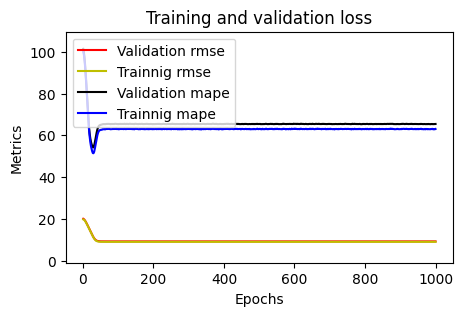

In [40]:
plotme(model2_2)

In [41]:
# # inputs: distance + hour
# model2_3 = nnmodel(10,15, num_hlayers=1,Epoch=500)
# model2_3

In [42]:
# inputs: distance + hour
model2_2 = nnmodel(10,10, num_hlayers=1,Epoch=1000)
model2_2

Epoch 1/1000
345/345 [==============================] - 1s 1ms/step - loss: 1105702.6250 - distance_layer_loss: 14.0868 - traveltime_layer_loss: 1382125.2500 - distance_layer_mape: 636935.6250 - distance_layer_rmse: 3.7532 - traveltime_layer_mape: 98.4823 - traveltime_layer_rmse: 1175.6382 - val_loss: 1081095.8750 - val_distance_layer_loss: 71.5027 - val_traveltime_layer_loss: 1351352.5000 - val_distance_layer_mape: 7053.0220 - val_distance_layer_rmse: 8.4559 - val_traveltime_layer_mape: 93.7676 - val_traveltime_layer_rmse: 1162.4769
Epoch 2/1000
345/345 [==============================] - 0s 1ms/step - loss: 796581.9375 - distance_layer_loss: 430.1356 - traveltime_layer_loss: 995620.2500 - distance_layer_mape: 2230412.0000 - distance_layer_rmse: 20.7397 - traveltime_layer_mape: 72.4137 - traveltime_layer_rmse: 997.8077 - val_loss: 486442.7500 - val_distance_layer_loss: 1042.0149 - val_traveltime_layer_loss: 607792.6875 - val_distance_layer_mape: 26540.6289 - val_distance_layer_rmse: 32

345/345 [==============================] - 0s 997us/step - loss: 227059.9531 - distance_layer_loss: 2189.3606 - traveltime_layer_loss: 283277.8125 - distance_layer_mape: 4257302.5000 - distance_layer_rmse: 46.7906 - traveltime_layer_mape: 62.3525 - traveltime_layer_rmse: 532.2385 - val_loss: 238020.8438 - val_distance_layer_loss: 2154.5044 - val_traveltime_layer_loss: 296987.4375 - val_distance_layer_mape: 38076.4688 - val_distance_layer_rmse: 46.4166 - val_traveltime_layer_mape: 61.9495 - val_traveltime_layer_rmse: 544.9655
Epoch 17/1000
345/345 [==============================] - 0s 996us/step - loss: 226921.0781 - distance_layer_loss: 2173.5957 - traveltime_layer_loss: 283107.8750 - distance_layer_mape: 4218544.5000 - distance_layer_rmse: 46.6218 - traveltime_layer_mape: 62.0518 - traveltime_layer_rmse: 532.0788 - val_loss: 237711.8906 - val_distance_layer_loss: 2162.6536 - val_traveltime_layer_loss: 296599.1250 - val_distance_layer_mape: 38145.8477 - val_distance_layer_rmse: 46.5043

345/345 [==============================] - 0s 990us/step - loss: 226155.4375 - distance_layer_loss: 2083.4231 - traveltime_layer_loss: 282173.4062 - distance_layer_mape: 4161572.0000 - distance_layer_rmse: 45.6445 - traveltime_layer_mape: 62.2783 - traveltime_layer_rmse: 531.2000 - val_loss: 237097.5000 - val_distance_layer_loss: 2041.5931 - val_traveltime_layer_loss: 295861.4375 - val_distance_layer_mape: 37033.0547 - val_distance_layer_rmse: 45.1840 - val_traveltime_layer_mape: 61.6567 - val_traveltime_layer_rmse: 543.9315
Epoch 32/1000
345/345 [==============================] - 0s 992us/step - loss: 226170.2500 - distance_layer_loss: 2060.6655 - traveltime_layer_loss: 282197.5625 - distance_layer_mape: 4144147.7500 - distance_layer_rmse: 45.3946 - traveltime_layer_mape: 61.8023 - traveltime_layer_rmse: 531.2227 - val_loss: 236932.0469 - val_distance_layer_loss: 2039.1624 - val_traveltime_layer_loss: 295655.3438 - val_distance_layer_mape: 37008.8398 - val_distance_layer_rmse: 45.1571

345/345 [==============================] - 0s 995us/step - loss: 225348.5781 - distance_layer_loss: 1952.7612 - traveltime_layer_loss: 281197.5312 - distance_layer_mape: 3993902.5000 - distance_layer_rmse: 44.1901 - traveltime_layer_mape: 61.9098 - traveltime_layer_rmse: 530.2806 - val_loss: 235615.8281 - val_distance_layer_loss: 1953.4069 - val_traveltime_layer_loss: 294031.5000 - val_distance_layer_mape: 36191.7930 - val_distance_layer_rmse: 44.1974 - val_traveltime_layer_mape: 62.5768 - val_traveltime_layer_rmse: 542.2467
Epoch 47/1000
345/345 [==============================] - 0s 985us/step - loss: 225323.1406 - distance_layer_loss: 1937.6674 - traveltime_layer_loss: 281169.4688 - distance_layer_mape: 3973225.0000 - distance_layer_rmse: 44.0189 - traveltime_layer_mape: 61.6850 - traveltime_layer_rmse: 530.2542 - val_loss: 235480.2031 - val_distance_layer_loss: 1954.0718 - val_traveltime_layer_loss: 293861.7812 - val_distance_layer_mape: 36195.6094 - val_distance_layer_rmse: 44.2049

345/345 [==============================] - 0s 975us/step - loss: 224627.0312 - distance_layer_loss: 1819.2107 - traveltime_layer_loss: 280329.1250 - distance_layer_mape: 3850995.7500 - distance_layer_rmse: 42.6522 - traveltime_layer_mape: 61.8976 - traveltime_layer_rmse: 529.4612 - val_loss: 234925.5938 - val_distance_layer_loss: 1797.4736 - val_traveltime_layer_loss: 293207.4688 - val_distance_layer_mape: 34684.5977 - val_distance_layer_rmse: 42.3966 - val_traveltime_layer_mape: 61.8123 - val_traveltime_layer_rmse: 541.4863
Epoch 62/1000
345/345 [==============================] - 0s 992us/step - loss: 224624.9375 - distance_layer_loss: 1801.7146 - traveltime_layer_loss: 280330.6250 - distance_layer_mape: 3868516.2500 - distance_layer_rmse: 42.4466 - traveltime_layer_mape: 61.6169 - traveltime_layer_rmse: 529.4626 - val_loss: 234701.5781 - val_distance_layer_loss: 1798.8114 - val_traveltime_layer_loss: 292927.2812 - val_distance_layer_mape: 34695.1484 - val_distance_layer_rmse: 42.4124

345/345 [==============================] - 0s 994us/step - loss: 223385.7812 - distance_layer_loss: 1663.7186 - traveltime_layer_loss: 278816.1562 - distance_layer_mape: 3681064.0000 - distance_layer_rmse: 40.7887 - traveltime_layer_mape: 61.4023 - traveltime_layer_rmse: 528.0305 - val_loss: 233259.8906 - val_distance_layer_loss: 1667.2781 - val_traveltime_layer_loss: 291157.9688 - val_distance_layer_mape: 33360.3164 - val_distance_layer_rmse: 40.8323 - val_traveltime_layer_mape: 62.2349 - val_traveltime_layer_rmse: 539.5906
Epoch 77/1000
345/345 [==============================] - 0s 1ms/step - loss: 223184.6562 - distance_layer_loss: 1650.7982 - traveltime_layer_loss: 278568.1562 - distance_layer_mape: 3684799.5000 - distance_layer_rmse: 40.6300 - traveltime_layer_mape: 61.3078 - traveltime_layer_rmse: 527.7956 - val_loss: 233014.1094 - val_distance_layer_loss: 1670.7449 - val_traveltime_layer_loss: 290850.0312 - val_distance_layer_mape: 33389.9727 - val_distance_layer_rmse: 40.8747 -

345/345 [==============================] - 0s 996us/step - loss: 221635.0469 - distance_layer_loss: 1472.8778 - traveltime_layer_loss: 276675.6562 - distance_layer_mape: 3439478.5000 - distance_layer_rmse: 38.3781 - traveltime_layer_mape: 60.9871 - traveltime_layer_rmse: 525.9997 - val_loss: 231239.3594 - val_distance_layer_loss: 1497.5536 - val_traveltime_layer_loss: 288674.7500 - val_distance_layer_mape: 31556.8242 - val_distance_layer_rmse: 38.6982 - val_traveltime_layer_mape: 62.7384 - val_traveltime_layer_rmse: 537.2846
Epoch 92/1000
345/345 [==============================] - 0s 990us/step - loss: 221552.0156 - distance_layer_loss: 1465.9996 - traveltime_layer_loss: 276573.5312 - distance_layer_mape: 3448967.7500 - distance_layer_rmse: 38.2884 - traveltime_layer_mape: 61.2714 - traveltime_layer_rmse: 525.9026 - val_loss: 231249.0469 - val_distance_layer_loss: 1462.8381 - val_traveltime_layer_loss: 288695.5312 - val_distance_layer_mape: 31183.7188 - val_distance_layer_rmse: 38.2471

345/345 [==============================] - 0s 1ms/step - loss: 219369.8438 - distance_layer_loss: 1257.2555 - traveltime_layer_loss: 273898.0312 - distance_layer_mape: 3154051.7500 - distance_layer_rmse: 35.4578 - traveltime_layer_mape: 60.9906 - traveltime_layer_rmse: 523.3527 - val_loss: 229327.2031 - val_distance_layer_loss: 1232.0546 - val_traveltime_layer_loss: 286350.9375 - val_distance_layer_mape: 28550.8730 - val_distance_layer_rmse: 35.1006 - val_traveltime_layer_mape: 60.6845 - val_traveltime_layer_rmse: 535.1177
Epoch 107/1000
345/345 [==============================] - 0s 980us/step - loss: 219232.4531 - distance_layer_loss: 1237.4503 - traveltime_layer_loss: 273731.2188 - distance_layer_mape: 3140409.7500 - distance_layer_rmse: 35.1774 - traveltime_layer_mape: 60.7777 - traveltime_layer_rmse: 523.1933 - val_loss: 228859.4219 - val_distance_layer_loss: 1226.6471 - val_traveltime_layer_loss: 285767.5625 - val_distance_layer_mape: 28483.0996 - val_distance_layer_rmse: 35.0235 

345/345 [==============================] - 0s 991us/step - loss: 216364.8125 - distance_layer_loss: 1000.5667 - traveltime_layer_loss: 270205.7188 - distance_layer_mape: 2829965.2500 - distance_layer_rmse: 31.6317 - traveltime_layer_mape: 60.4286 - traveltime_layer_rmse: 519.8132 - val_loss: 225470.2500 - val_distance_layer_loss: 1003.7990 - val_traveltime_layer_loss: 281586.7500 - val_distance_layer_mape: 25680.6562 - val_distance_layer_rmse: 31.6828 - val_traveltime_layer_mape: 61.5268 - val_traveltime_layer_rmse: 530.6475
Epoch 122/1000
345/345 [==============================] - 0s 1000us/step - loss: 216097.6406 - distance_layer_loss: 988.5573 - traveltime_layer_loss: 269874.9062 - distance_layer_mape: 2741385.0000 - distance_layer_rmse: 31.4413 - traveltime_layer_mape: 60.6583 - traveltime_layer_rmse: 519.4949 - val_loss: 225358.6094 - val_distance_layer_loss: 980.9150 - val_traveltime_layer_loss: 281453.1250 - val_distance_layer_mape: 25376.2383 - val_distance_layer_rmse: 31.3196

345/345 [==============================] - 0s 1ms/step - loss: 212553.0156 - distance_layer_loss: 749.3859 - traveltime_layer_loss: 265503.9375 - distance_layer_mape: 2394342.0000 - distance_layer_rmse: 27.3749 - traveltime_layer_mape: 59.8307 - traveltime_layer_rmse: 515.2708 - val_loss: 221697.3906 - val_distance_layer_loss: 738.7526 - val_traveltime_layer_loss: 276937.1562 - val_distance_layer_mape: 21915.2812 - val_distance_layer_rmse: 27.1800 - val_traveltime_layer_mape: 60.0697 - val_traveltime_layer_rmse: 526.2482
Epoch 137/1000
345/345 [==============================] - 0s 982us/step - loss: 212340.0312 - distance_layer_loss: 732.1007 - traveltime_layer_loss: 265242.0312 - distance_layer_mape: 2363854.7500 - distance_layer_rmse: 27.0574 - traveltime_layer_mape: 59.7137 - traveltime_layer_rmse: 515.0165 - val_loss: 221314.3438 - val_distance_layer_loss: 722.4721 - val_traveltime_layer_loss: 276462.3125 - val_distance_layer_mape: 21665.6250 - val_distance_layer_rmse: 26.8788 - va

345/345 [==============================] - 0s 994us/step - loss: 207925.4531 - distance_layer_loss: 524.1100 - traveltime_layer_loss: 259775.8594 - distance_layer_mape: 1994476.6250 - distance_layer_rmse: 22.8934 - traveltime_layer_mape: 58.9857 - traveltime_layer_rmse: 509.6821 - val_loss: 216612.7188 - val_distance_layer_loss: 515.4725 - val_traveltime_layer_loss: 270636.9688 - val_distance_layer_mape: 18163.9043 - val_distance_layer_rmse: 22.7040 - val_traveltime_layer_mape: 59.1843 - val_traveltime_layer_rmse: 520.2278
Epoch 152/1000
345/345 [==============================] - 0s 991us/step - loss: 207600.7656 - distance_layer_loss: 510.8964 - traveltime_layer_loss: 259373.1875 - distance_layer_mape: 1971870.5000 - distance_layer_rmse: 22.6030 - traveltime_layer_mape: 58.8631 - traveltime_layer_rmse: 509.2869 - val_loss: 216192.2969 - val_distance_layer_loss: 513.4930 - val_traveltime_layer_loss: 270112.0312 - val_distance_layer_mape: 18119.8789 - val_distance_layer_rmse: 22.6604 - 

345/345 [==============================] - 0s 1ms/step - loss: 203358.4531 - distance_layer_loss: 359.5002 - traveltime_layer_loss: 254108.0156 - distance_layer_mape: 1613349.6250 - distance_layer_rmse: 18.9605 - traveltime_layer_mape: 57.9217 - traveltime_layer_rmse: 504.0913 - val_loss: 211692.2188 - val_distance_layer_loss: 352.2460 - val_traveltime_layer_loss: 264527.2188 - val_distance_layer_mape: 14852.9961 - val_distance_layer_rmse: 18.7682 - val_traveltime_layer_mape: 57.9236 - val_traveltime_layer_rmse: 514.3221
Epoch 167/1000
345/345 [==============================] - 0s 996us/step - loss: 203050.0938 - distance_layer_loss: 348.9637 - traveltime_layer_loss: 253725.4375 - distance_layer_mape: 1580108.8750 - distance_layer_rmse: 18.6806 - traveltime_layer_mape: 57.6335 - traveltime_layer_rmse: 503.7117 - val_loss: 211443.5781 - val_distance_layer_loss: 344.1343 - val_traveltime_layer_loss: 264218.5312 - val_distance_layer_mape: 14684.9365 - val_distance_layer_rmse: 18.5509 - va

345/345 [==============================] - 0s 995us/step - loss: 200135.9062 - distance_layer_loss: 260.4901 - traveltime_layer_loss: 250104.6719 - distance_layer_mape: 1329010.7500 - distance_layer_rmse: 16.1397 - traveltime_layer_mape: 56.7206 - traveltime_layer_rmse: 500.1047 - val_loss: 208168.2344 - val_distance_layer_loss: 258.3129 - val_traveltime_layer_loss: 260145.6719 - val_distance_layer_mape: 12595.1045 - val_distance_layer_rmse: 16.0721 - val_traveltime_layer_mape: 57.2773 - val_traveltime_layer_rmse: 510.0448
Epoch 182/1000
345/345 [==============================] - 0s 994us/step - loss: 200006.8125 - distance_layer_loss: 255.5989 - traveltime_layer_loss: 249944.7188 - distance_layer_mape: 1325833.6250 - distance_layer_rmse: 15.9875 - traveltime_layer_mape: 56.6350 - traveltime_layer_rmse: 499.9447 - val_loss: 207850.2188 - val_distance_layer_loss: 254.2184 - val_traveltime_layer_loss: 259749.1406 - val_distance_layer_mape: 12466.3623 - val_distance_layer_rmse: 15.9442 - 

345/345 [==============================] - 0s 991us/step - loss: 198610.0312 - distance_layer_loss: 212.1072 - traveltime_layer_loss: 248209.4062 - distance_layer_mape: 1195436.1250 - distance_layer_rmse: 14.5639 - traveltime_layer_mape: 55.8178 - traveltime_layer_rmse: 498.2062 - val_loss: 206108.9531 - val_distance_layer_loss: 212.3927 - val_traveltime_layer_loss: 257583.0625 - val_distance_layer_mape: 11319.9014 - val_distance_layer_rmse: 14.5737 - val_traveltime_layer_mape: 56.4938 - val_traveltime_layer_rmse: 507.5264
Epoch 197/1000
345/345 [==============================] - 0s 995us/step - loss: 198438.8750 - distance_layer_loss: 209.7215 - traveltime_layer_loss: 247996.0469 - distance_layer_mape: 1186716.3750 - distance_layer_rmse: 14.4818 - traveltime_layer_mape: 55.7697 - traveltime_layer_rmse: 497.9920 - val_loss: 205924.8750 - val_distance_layer_loss: 212.5589 - val_traveltime_layer_loss: 257352.9844 - val_distance_layer_mape: 11309.9355 - val_distance_layer_rmse: 14.5794 - 

345/345 [==============================] - 0s 989us/step - loss: 197474.7188 - distance_layer_loss: 190.4241 - traveltime_layer_loss: 246795.6250 - distance_layer_mape: 1124153.7500 - distance_layer_rmse: 13.7994 - traveltime_layer_mape: 55.5496 - traveltime_layer_rmse: 496.7853 - val_loss: 205624.0781 - val_distance_layer_loss: 184.5948 - val_traveltime_layer_loss: 256984.0781 - val_distance_layer_mape: 10490.6074 - val_distance_layer_rmse: 13.5866 - val_traveltime_layer_mape: 54.8245 - val_traveltime_layer_rmse: 506.9360
Epoch 212/1000
345/345 [==============================] - 0s 994us/step - loss: 197557.6406 - distance_layer_loss: 188.4900 - traveltime_layer_loss: 246899.7969 - distance_layer_mape: 1110107.2500 - distance_layer_rmse: 13.7292 - traveltime_layer_mape: 55.5460 - traveltime_layer_rmse: 496.8901 - val_loss: 204811.8906 - val_distance_layer_loss: 192.9773 - val_traveltime_layer_loss: 255966.6406 - val_distance_layer_mape: 10728.7178 - val_distance_layer_rmse: 13.8916 - 

345/345 [==============================] - 0s 990us/step - loss: 196679.1094 - distance_layer_loss: 177.2802 - traveltime_layer_loss: 245804.3750 - distance_layer_mape: 1067266.6250 - distance_layer_rmse: 13.3147 - traveltime_layer_mape: 55.4672 - traveltime_layer_rmse: 495.7866 - val_loss: 203702.0625 - val_distance_layer_loss: 177.8520 - val_traveltime_layer_loss: 254583.0781 - val_distance_layer_mape: 10285.8857 - val_distance_layer_rmse: 13.3361 - val_traveltime_layer_mape: 56.0325 - val_traveltime_layer_rmse: 504.5623
Epoch 227/1000
345/345 [==============================] - 0s 995us/step - loss: 196411.5938 - distance_layer_loss: 176.2782 - traveltime_layer_loss: 245470.4219 - distance_layer_mape: 1080854.5000 - distance_layer_rmse: 13.2770 - traveltime_layer_mape: 55.3575 - traveltime_layer_rmse: 495.4497 - val_loss: 203898.9531 - val_distance_layer_loss: 174.2853 - val_traveltime_layer_loss: 254830.1719 - val_distance_layer_mape: 10174.5010 - val_distance_layer_rmse: 13.2017 - 

345/345 [==============================] - 0s 993us/step - loss: 195648.5469 - distance_layer_loss: 167.3235 - traveltime_layer_loss: 244518.6250 - distance_layer_mape: 1049914.5000 - distance_layer_rmse: 12.9354 - traveltime_layer_mape: 55.0559 - traveltime_layer_rmse: 494.4883 - val_loss: 202482.5781 - val_distance_layer_loss: 172.6555 - val_traveltime_layer_loss: 253059.9844 - val_distance_layer_mape: 10116.4307 - val_distance_layer_rmse: 13.1398 - val_traveltime_layer_mape: 56.7441 - val_traveltime_layer_rmse: 503.0507
Epoch 242/1000
345/345 [==============================] - 0s 1ms/step - loss: 195744.1875 - distance_layer_loss: 167.9141 - traveltime_layer_loss: 244638.1250 - distance_layer_mape: 1028211.8125 - distance_layer_rmse: 12.9582 - traveltime_layer_mape: 55.3586 - traveltime_layer_rmse: 494.6091 - val_loss: 202766.6250 - val_distance_layer_loss: 165.4705 - val_traveltime_layer_loss: 253416.9375 - val_distance_layer_mape: 9899.0928 - val_distance_layer_rmse: 12.8635 - val

345/345 [==============================] - 0s 986us/step - loss: 194902.6719 - distance_layer_loss: 158.3163 - traveltime_layer_loss: 243588.7812 - distance_layer_mape: 997905.6250 - distance_layer_rmse: 12.5824 - traveltime_layer_mape: 55.0871 - traveltime_layer_rmse: 493.5471 - val_loss: 201533.1406 - val_distance_layer_loss: 161.2061 - val_traveltime_layer_loss: 251876.1719 - val_distance_layer_mape: 9742.1865 - val_distance_layer_rmse: 12.6967 - val_traveltime_layer_mape: 55.9894 - val_traveltime_layer_rmse: 501.8727
Epoch 257/1000
345/345 [==============================] - 0s 986us/step - loss: 194684.3438 - distance_layer_loss: 157.0817 - traveltime_layer_loss: 243316.1719 - distance_layer_mape: 1009494.6875 - distance_layer_rmse: 12.5332 - traveltime_layer_mape: 54.7726 - traveltime_layer_rmse: 493.2709 - val_loss: 201861.5000 - val_distance_layer_loss: 165.7330 - val_traveltime_layer_loss: 252285.4844 - val_distance_layer_mape: 9885.5654 - val_distance_layer_rmse: 12.8737 - val

345/345 [==============================] - 0s 987us/step - loss: 193682.5625 - distance_layer_loss: 149.3956 - traveltime_layer_loss: 242065.9844 - distance_layer_mape: 971062.1250 - distance_layer_rmse: 12.2228 - traveltime_layer_mape: 54.7695 - traveltime_layer_rmse: 492.0020 - val_loss: 200027.7969 - val_distance_layer_loss: 155.0826 - val_traveltime_layer_loss: 249995.9062 - val_distance_layer_mape: 9550.3486 - val_distance_layer_rmse: 12.4532 - val_traveltime_layer_mape: 56.6210 - val_traveltime_layer_rmse: 499.9959
Epoch 272/1000
345/345 [==============================] - 0s 997us/step - loss: 193611.2656 - distance_layer_loss: 148.3437 - traveltime_layer_loss: 241976.9531 - distance_layer_mape: 975895.5625 - distance_layer_rmse: 12.1796 - traveltime_layer_mape: 54.6389 - traveltime_layer_rmse: 491.9115 - val_loss: 200157.4688 - val_distance_layer_loss: 153.9537 - val_traveltime_layer_loss: 250158.4688 - val_distance_layer_mape: 9505.8916 - val_distance_layer_rmse: 12.4078 - val_

345/345 [==============================] - 0s 986us/step - loss: 192604.5312 - distance_layer_loss: 140.1350 - traveltime_layer_loss: 240720.6250 - distance_layer_mape: 934686.3750 - distance_layer_rmse: 11.8379 - traveltime_layer_mape: 54.2860 - traveltime_layer_rmse: 490.6329 - val_loss: 198721.2031 - val_distance_layer_loss: 140.3002 - val_traveltime_layer_loss: 248366.4688 - val_distance_layer_mape: 9077.1826 - val_distance_layer_rmse: 11.8448 - val_traveltime_layer_mape: 54.7099 - val_traveltime_layer_rmse: 498.3638
Epoch 287/1000
345/345 [==============================] - 0s 991us/step - loss: 192494.7812 - distance_layer_loss: 139.7004 - traveltime_layer_loss: 240583.5938 - distance_layer_mape: 945584.6875 - distance_layer_rmse: 11.8195 - traveltime_layer_mape: 54.3681 - traveltime_layer_rmse: 490.4932 - val_loss: 198575.0938 - val_distance_layer_loss: 145.0837 - val_traveltime_layer_loss: 248182.5625 - val_distance_layer_mape: 9211.3604 - val_distance_layer_rmse: 12.0451 - val_

345/345 [==============================] - 0s 1ms/step - loss: 191407.5156 - distance_layer_loss: 132.7514 - traveltime_layer_loss: 239226.3438 - distance_layer_mape: 912165.0625 - distance_layer_rmse: 11.5218 - traveltime_layer_mape: 54.5519 - traveltime_layer_rmse: 489.1077 - val_loss: 198285.7812 - val_distance_layer_loss: 130.5433 - val_traveltime_layer_loss: 247824.6250 - val_distance_layer_mape: 8696.3623 - val_distance_layer_rmse: 11.4256 - val_traveltime_layer_mape: 53.9671 - val_traveltime_layer_rmse: 497.8199
Epoch 302/1000
345/345 [==============================] - 0s 1ms/step - loss: 191084.3125 - distance_layer_loss: 131.3926 - traveltime_layer_loss: 238822.6250 - distance_layer_mape: 908040.5000 - distance_layer_rmse: 11.4627 - traveltime_layer_mape: 54.2595 - traveltime_layer_rmse: 488.6948 - val_loss: 197187.6875 - val_distance_layer_loss: 129.9793 - val_traveltime_layer_loss: 246452.1094 - val_distance_layer_mape: 8691.8330 - val_distance_layer_rmse: 11.4008 - val_trav

345/345 [==============================] - 0s 990us/step - loss: 189926.2656 - distance_layer_loss: 122.1165 - traveltime_layer_loss: 237377.2969 - distance_layer_mape: 865097.3125 - distance_layer_rmse: 11.0506 - traveltime_layer_mape: 53.6892 - traveltime_layer_rmse: 487.2138 - val_loss: 195306.8906 - val_distance_layer_loss: 127.4567 - val_traveltime_layer_loss: 244101.7812 - val_distance_layer_mape: 8602.6221 - val_distance_layer_rmse: 11.2897 - val_traveltime_layer_mape: 55.6330 - val_traveltime_layer_rmse: 494.0666
Epoch 317/1000
345/345 [==============================] - 0s 996us/step - loss: 189582.4219 - distance_layer_loss: 122.2464 - traveltime_layer_loss: 236947.5000 - distance_layer_mape: 858708.2500 - distance_layer_rmse: 11.0565 - traveltime_layer_mape: 53.8354 - traveltime_layer_rmse: 486.7725 - val_loss: 195358.4844 - val_distance_layer_loss: 126.6904 - val_traveltime_layer_loss: 244166.4375 - val_distance_layer_mape: 8568.0938 - val_distance_layer_rmse: 11.2557 - val_

345/345 [==============================] - 0s 1ms/step - loss: 188360.3906 - distance_layer_loss: 114.4312 - traveltime_layer_loss: 235421.8906 - distance_layer_mape: 848116.6250 - distance_layer_rmse: 10.6973 - traveltime_layer_mape: 53.7207 - traveltime_layer_rmse: 485.2029 - val_loss: 194399.5625 - val_distance_layer_loss: 110.7303 - val_traveltime_layer_loss: 242971.7812 - val_distance_layer_mape: 7996.7036 - val_distance_layer_rmse: 10.5228 - val_traveltime_layer_mape: 52.6395 - val_traveltime_layer_rmse: 492.9217
Epoch 332/1000
345/345 [==============================] - 0s 993us/step - loss: 188444.9219 - distance_layer_loss: 113.4105 - traveltime_layer_loss: 235527.6562 - distance_layer_mape: 844328.2500 - distance_layer_rmse: 10.6494 - traveltime_layer_mape: 53.5230 - traveltime_layer_rmse: 485.3119 - val_loss: 193418.5625 - val_distance_layer_loss: 114.9135 - val_traveltime_layer_loss: 241744.5312 - val_distance_layer_mape: 8146.8184 - val_distance_layer_rmse: 10.7198 - val_tr

345/345 [==============================] - 0s 995us/step - loss: 187134.3438 - distance_layer_loss: 106.4343 - traveltime_layer_loss: 233891.3750 - distance_layer_mape: 815507.6875 - distance_layer_rmse: 10.3167 - traveltime_layer_mape: 53.4594 - traveltime_layer_rmse: 483.6232 - val_loss: 192081.4688 - val_distance_layer_loss: 109.3035 - val_traveltime_layer_loss: 240074.4844 - val_distance_layer_mape: 7919.7930 - val_distance_layer_rmse: 10.4548 - val_traveltime_layer_mape: 54.6025 - val_traveltime_layer_rmse: 489.9740
Epoch 347/1000
345/345 [==============================] - 0s 1ms/step - loss: 187040.0156 - distance_layer_loss: 105.7636 - traveltime_layer_loss: 233773.5000 - distance_layer_mape: 807857.1875 - distance_layer_rmse: 10.2841 - traveltime_layer_mape: 53.3615 - traveltime_layer_rmse: 483.5013 - val_loss: 192947.1094 - val_distance_layer_loss: 109.7115 - val_traveltime_layer_loss: 241156.4688 - val_distance_layer_mape: 7919.4692 - val_distance_layer_rmse: 10.4743 - val_tr

345/345 [==============================] - 0s 1ms/step - loss: 185907.0938 - distance_layer_loss: 99.5067 - traveltime_layer_loss: 232359.0781 - distance_layer_mape: 781422.2500 - distance_layer_rmse: 9.9753 - traveltime_layer_mape: 53.1024 - traveltime_layer_rmse: 482.0364 - val_loss: 190342.8906 - val_distance_layer_loss: 102.6387 - val_traveltime_layer_loss: 237902.9062 - val_distance_layer_mape: 7687.3652 - val_distance_layer_rmse: 10.1311 - val_traveltime_layer_mape: 54.6338 - val_traveltime_layer_rmse: 487.7529
Epoch 362/1000
345/345 [==============================] - 0s 1ms/step - loss: 185683.0781 - distance_layer_loss: 98.6741 - traveltime_layer_loss: 232079.2969 - distance_layer_mape: 790535.0000 - distance_layer_rmse: 9.9335 - traveltime_layer_mape: 53.0276 - traveltime_layer_rmse: 481.7461 - val_loss: 190469.1875 - val_distance_layer_loss: 103.5045 - val_traveltime_layer_loss: 238060.5781 - val_distance_layer_mape: 7700.5537 - val_distance_layer_rmse: 10.1737 - val_travelti

345/345 [==============================] - 0s 989us/step - loss: 184508.0625 - distance_layer_loss: 93.0264 - traveltime_layer_loss: 230611.7969 - distance_layer_mape: 768655.3125 - distance_layer_rmse: 9.6450 - traveltime_layer_mape: 52.9369 - traveltime_layer_rmse: 480.2206 - val_loss: 189163.6562 - val_distance_layer_loss: 92.5882 - val_traveltime_layer_loss: 236431.3281 - val_distance_layer_mape: 7293.9048 - val_distance_layer_rmse: 9.6223 - val_traveltime_layer_mape: 53.0779 - val_traveltime_layer_rmse: 486.2420
Epoch 377/1000
345/345 [==============================] - 0s 983us/step - loss: 184462.0312 - distance_layer_loss: 92.0677 - traveltime_layer_loss: 230554.5469 - distance_layer_mape: 741710.8750 - distance_layer_rmse: 9.5952 - traveltime_layer_mape: 52.7060 - traveltime_layer_rmse: 480.1609 - val_loss: 188653.7188 - val_distance_layer_loss: 93.9213 - val_traveltime_layer_loss: 235793.6562 - val_distance_layer_mape: 7311.3369 - val_distance_layer_rmse: 9.6913 - val_travelti

345/345 [==============================] - 0s 1ms/step - loss: 183342.0469 - distance_layer_loss: 87.0832 - traveltime_layer_loss: 229155.8594 - distance_layer_mape: 717951.0000 - distance_layer_rmse: 9.3318 - traveltime_layer_mape: 52.6696 - traveltime_layer_rmse: 478.7023 - val_loss: 187158.6406 - val_distance_layer_loss: 87.3506 - val_traveltime_layer_loss: 233926.4375 - val_distance_layer_mape: 7045.8892 - val_distance_layer_rmse: 9.3462 - val_traveltime_layer_mape: 52.7548 - val_traveltime_layer_rmse: 483.6594
Epoch 392/1000
345/345 [==============================] - 0s 984us/step - loss: 183279.7812 - distance_layer_loss: 86.3241 - traveltime_layer_loss: 229078.2656 - distance_layer_mape: 722745.3750 - distance_layer_rmse: 9.2911 - traveltime_layer_mape: 52.4934 - traveltime_layer_rmse: 478.6212 - val_loss: 187302.3125 - val_distance_layer_loss: 89.2080 - val_traveltime_layer_loss: 234105.6562 - val_distance_layer_mape: 7099.7222 - val_distance_layer_rmse: 9.4450 - val_traveltime

345/345 [==============================] - 0s 989us/step - loss: 181835.7656 - distance_layer_loss: 82.0553 - traveltime_layer_loss: 227274.2656 - distance_layer_mape: 711856.1875 - distance_layer_rmse: 9.0584 - traveltime_layer_mape: 52.3938 - traveltime_layer_rmse: 476.7329 - val_loss: 186289.9844 - val_distance_layer_loss: 79.4612 - val_traveltime_layer_loss: 232842.6250 - val_distance_layer_mape: 6715.3765 - val_distance_layer_rmse: 8.9141 - val_traveltime_layer_mape: 51.3832 - val_traveltime_layer_rmse: 482.5377
Epoch 407/1000
345/345 [==============================] - 0s 975us/step - loss: 181935.8438 - distance_layer_loss: 80.8795 - traveltime_layer_loss: 227399.6250 - distance_layer_mape: 710673.1875 - distance_layer_rmse: 8.9933 - traveltime_layer_mape: 51.9971 - traveltime_layer_rmse: 476.8644 - val_loss: 185753.3906 - val_distance_layer_loss: 86.0972 - val_traveltime_layer_loss: 232170.1719 - val_distance_layer_mape: 6958.6963 - val_distance_layer_rmse: 9.2789 - val_travelti

345/345 [==============================] - 0s 992us/step - loss: 179833.7031 - distance_layer_loss: 76.4231 - traveltime_layer_loss: 224773.0156 - distance_layer_mape: 689431.0625 - distance_layer_rmse: 8.7420 - traveltime_layer_mape: 51.7334 - traveltime_layer_rmse: 474.1023 - val_loss: 184049.3438 - val_distance_layer_loss: 77.5426 - val_traveltime_layer_loss: 230042.2344 - val_distance_layer_mape: 6642.9429 - val_distance_layer_rmse: 8.8058 - val_traveltime_layer_mape: 52.8090 - val_traveltime_layer_rmse: 479.6272
Epoch 422/1000
345/345 [==============================] - 0s 986us/step - loss: 180057.7969 - distance_layer_loss: 76.3461 - traveltime_layer_loss: 225053.2344 - distance_layer_mape: 683865.0625 - distance_layer_rmse: 8.7376 - traveltime_layer_mape: 51.9193 - traveltime_layer_rmse: 474.3978 - val_loss: 183330.6719 - val_distance_layer_loss: 76.0516 - val_traveltime_layer_loss: 229144.3281 - val_distance_layer_mape: 6536.6719 - val_distance_layer_rmse: 8.7208 - val_travelti

345/345 [==============================] - 0s 999us/step - loss: 178240.9844 - distance_layer_loss: 71.8015 - traveltime_layer_loss: 222783.2656 - distance_layer_mape: 664441.0000 - distance_layer_rmse: 8.4736 - traveltime_layer_mape: 51.6211 - traveltime_layer_rmse: 471.9992 - val_loss: 180778.6250 - val_distance_layer_loss: 72.2102 - val_traveltime_layer_loss: 225955.2656 - val_distance_layer_mape: 6335.2227 - val_distance_layer_rmse: 8.4977 - val_traveltime_layer_mape: 51.5723 - val_traveltime_layer_rmse: 475.3475
Epoch 437/1000
345/345 [==============================] - 0s 1ms/step - loss: 177839.6406 - distance_layer_loss: 71.2345 - traveltime_layer_loss: 222281.8750 - distance_layer_mape: 654149.3750 - distance_layer_rmse: 8.4401 - traveltime_layer_mape: 51.5063 - traveltime_layer_rmse: 471.4678 - val_loss: 181461.5156 - val_distance_layer_loss: 70.3315 - val_traveltime_layer_loss: 226809.4375 - val_distance_layer_mape: 6285.6758 - val_distance_layer_rmse: 8.3864 - val_traveltime

345/345 [==============================] - 0s 995us/step - loss: 175722.3750 - distance_layer_loss: 66.7263 - traveltime_layer_loss: 219636.2500 - distance_layer_mape: 629377.6875 - distance_layer_rmse: 8.1686 - traveltime_layer_mape: 51.0193 - traveltime_layer_rmse: 468.6537 - val_loss: 178009.8750 - val_distance_layer_loss: 68.7170 - val_traveltime_layer_loss: 222495.1719 - val_distance_layer_mape: 6158.0498 - val_distance_layer_rmse: 8.2896 - val_traveltime_layer_mape: 51.9119 - val_traveltime_layer_rmse: 471.6939
Epoch 452/1000
345/345 [==============================] - 0s 994us/step - loss: 175640.7812 - distance_layer_loss: 66.6227 - traveltime_layer_loss: 219534.3281 - distance_layer_mape: 633031.3125 - distance_layer_rmse: 8.1623 - traveltime_layer_mape: 51.0895 - traveltime_layer_rmse: 468.5449 - val_loss: 177926.8438 - val_distance_layer_loss: 67.6289 - val_traveltime_layer_loss: 222391.5781 - val_distance_layer_mape: 6117.1274 - val_distance_layer_rmse: 8.2237 - val_travelti

345/345 [==============================] - 0s 1ms/step - loss: 173596.8594 - distance_layer_loss: 63.0169 - traveltime_layer_loss: 216980.5469 - distance_layer_mape: 604542.6875 - distance_layer_rmse: 7.9383 - traveltime_layer_mape: 50.7381 - traveltime_layer_rmse: 465.8117 - val_loss: 175853.5000 - val_distance_layer_loss: 63.2745 - val_traveltime_layer_loss: 219801.0312 - val_distance_layer_mape: 5887.3618 - val_distance_layer_rmse: 7.9545 - val_traveltime_layer_mape: 50.6238 - val_traveltime_layer_rmse: 468.8294
Epoch 467/1000
345/345 [==============================] - 0s 1ms/step - loss: 173397.7344 - distance_layer_loss: 62.7315 - traveltime_layer_loss: 216731.5156 - distance_layer_mape: 606118.6250 - distance_layer_rmse: 7.9203 - traveltime_layer_mape: 50.6892 - traveltime_layer_rmse: 465.5443 - val_loss: 176121.2500 - val_distance_layer_loss: 67.0647 - val_traveltime_layer_loss: 220134.8594 - val_distance_layer_mape: 6041.7017 - val_distance_layer_rmse: 8.1893 - val_traveltime_l

345/345 [==============================] - 0s 992us/step - loss: 171439.1250 - distance_layer_loss: 60.1646 - traveltime_layer_loss: 214283.7969 - distance_layer_mape: 595994.9375 - distance_layer_rmse: 7.7566 - traveltime_layer_mape: 50.4783 - traveltime_layer_rmse: 462.9080 - val_loss: 174267.3594 - val_distance_layer_loss: 59.5573 - val_traveltime_layer_loss: 217819.2812 - val_distance_layer_mape: 5692.2217 - val_distance_layer_rmse: 7.7173 - val_traveltime_layer_mape: 49.8080 - val_traveltime_layer_rmse: 466.7111
Epoch 482/1000
345/345 [==============================] - 0s 982us/step - loss: 171297.0625 - distance_layer_loss: 59.8184 - traveltime_layer_loss: 214106.3906 - distance_layer_mape: 601845.2500 - distance_layer_rmse: 7.7342 - traveltime_layer_mape: 50.3037 - traveltime_layer_rmse: 462.7163 - val_loss: 174014.3438 - val_distance_layer_loss: 59.1275 - val_traveltime_layer_loss: 217503.1406 - val_distance_layer_mape: 5636.8452 - val_distance_layer_rmse: 7.6894 - val_travelti

345/345 [==============================] - 0s 992us/step - loss: 169898.7969 - distance_layer_loss: 57.6897 - traveltime_layer_loss: 212359.0625 - distance_layer_mape: 585756.2500 - distance_layer_rmse: 7.5954 - traveltime_layer_mape: 50.0882 - traveltime_layer_rmse: 460.8243 - val_loss: 172203.9375 - val_distance_layer_loss: 58.5303 - val_traveltime_layer_loss: 215240.2656 - val_distance_layer_mape: 5617.9277 - val_distance_layer_rmse: 7.6505 - val_traveltime_layer_mape: 50.3261 - val_traveltime_layer_rmse: 463.9399
Epoch 497/1000
345/345 [==============================] - 0s 994us/step - loss: 169917.0469 - distance_layer_loss: 57.2398 - traveltime_layer_loss: 212382.0312 - distance_layer_mape: 571090.4375 - distance_layer_rmse: 7.5657 - traveltime_layer_mape: 49.9120 - traveltime_layer_rmse: 460.8492 - val_loss: 171952.2969 - val_distance_layer_loss: 58.8865 - val_traveltime_layer_loss: 214925.7031 - val_distance_layer_mape: 5616.7456 - val_distance_layer_rmse: 7.6738 - val_travelti

345/345 [==============================] - 0s 996us/step - loss: 168598.7344 - distance_layer_loss: 55.6922 - traveltime_layer_loss: 210734.5938 - distance_layer_mape: 573062.0625 - distance_layer_rmse: 7.4627 - traveltime_layer_mape: 49.6413 - traveltime_layer_rmse: 459.0584 - val_loss: 170575.2344 - val_distance_layer_loss: 56.4764 - val_traveltime_layer_loss: 213204.9062 - val_distance_layer_mape: 5479.5571 - val_distance_layer_rmse: 7.5151 - val_traveltime_layer_mape: 49.5076 - val_traveltime_layer_rmse: 461.7412
Epoch 512/1000
345/345 [==============================] - 0s 1ms/step - loss: 168219.5625 - distance_layer_loss: 55.4443 - traveltime_layer_loss: 210260.3906 - distance_layer_mape: 565787.6875 - distance_layer_rmse: 7.4461 - traveltime_layer_mape: 49.4324 - traveltime_layer_rmse: 458.5416 - val_loss: 170737.4688 - val_distance_layer_loss: 59.0643 - val_traveltime_layer_loss: 213407.1719 - val_distance_layer_mape: 5613.2153 - val_distance_layer_rmse: 7.6853 - val_traveltime

345/345 [==============================] - 0s 993us/step - loss: 167223.5000 - distance_layer_loss: 53.8839 - traveltime_layer_loss: 209015.7500 - distance_layer_mape: 553235.3125 - distance_layer_rmse: 7.3406 - traveltime_layer_mape: 49.3877 - traveltime_layer_rmse: 457.1824 - val_loss: 169117.6719 - val_distance_layer_loss: 55.4601 - val_traveltime_layer_loss: 211383.2188 - val_distance_layer_mape: 5431.1680 - val_distance_layer_rmse: 7.4472 - val_traveltime_layer_mape: 50.0125 - val_traveltime_layer_rmse: 459.7643
Epoch 527/1000
345/345 [==============================] - 0s 1000us/step - loss: 166775.7188 - distance_layer_loss: 54.2175 - traveltime_layer_loss: 208456.0156 - distance_layer_mape: 586894.4375 - distance_layer_rmse: 7.3633 - traveltime_layer_mape: 49.5982 - traveltime_layer_rmse: 456.5698 - val_loss: 169222.3906 - val_distance_layer_loss: 54.0506 - val_traveltime_layer_loss: 211514.5156 - val_distance_layer_mape: 5319.6099 - val_distance_layer_rmse: 7.3519 - val_travelt

345/345 [==============================] - 0s 992us/step - loss: 165562.9375 - distance_layer_loss: 51.8142 - traveltime_layer_loss: 206940.6406 - distance_layer_mape: 545846.8125 - distance_layer_rmse: 7.1982 - traveltime_layer_mape: 48.8364 - traveltime_layer_rmse: 454.9073 - val_loss: 168263.0938 - val_distance_layer_loss: 52.5129 - val_traveltime_layer_loss: 210315.7188 - val_distance_layer_mape: 5303.9980 - val_distance_layer_rmse: 7.2466 - val_traveltime_layer_mape: 49.5156 - val_traveltime_layer_rmse: 458.6019
Epoch 542/1000
345/345 [==============================] - 0s 994us/step - loss: 165338.7812 - distance_layer_loss: 51.8157 - traveltime_layer_loss: 206660.5781 - distance_layer_mape: 545948.4375 - distance_layer_rmse: 7.1983 - traveltime_layer_mape: 48.9622 - traveltime_layer_rmse: 454.5994 - val_loss: 167683.0938 - val_distance_layer_loss: 52.1448 - val_traveltime_layer_loss: 209590.8125 - val_distance_layer_mape: 5244.6704 - val_distance_layer_rmse: 7.2211 - val_travelti

345/345 [==============================] - 0s 1ms/step - loss: 163904.7656 - distance_layer_loss: 49.7235 - traveltime_layer_loss: 204868.4375 - distance_layer_mape: 543898.1875 - distance_layer_rmse: 7.0515 - traveltime_layer_mape: 48.6390 - traveltime_layer_rmse: 452.6239 - val_loss: 166793.6094 - val_distance_layer_loss: 49.8695 - val_traveltime_layer_loss: 208479.5469 - val_distance_layer_mape: 5150.4736 - val_distance_layer_rmse: 7.0618 - val_traveltime_layer_mape: 48.8724 - val_traveltime_layer_rmse: 456.5956
Epoch 557/1000
345/345 [==============================] - 0s 997us/step - loss: 163877.7812 - distance_layer_loss: 49.3773 - traveltime_layer_loss: 204834.9062 - distance_layer_mape: 532361.5000 - distance_layer_rmse: 7.0269 - traveltime_layer_mape: 48.5505 - traveltime_layer_rmse: 452.5869 - val_loss: 166234.4844 - val_distance_layer_loss: 50.7210 - val_traveltime_layer_loss: 207780.3438 - val_distance_layer_mape: 5179.8931 - val_distance_layer_rmse: 7.1219 - val_traveltime

345/345 [==============================] - 0s 1ms/step - loss: 162541.7500 - distance_layer_loss: 47.2549 - traveltime_layer_loss: 203165.2188 - distance_layer_mape: 519378.8125 - distance_layer_rmse: 6.8742 - traveltime_layer_mape: 48.2982 - traveltime_layer_rmse: 450.7385 - val_loss: 165622.8594 - val_distance_layer_loss: 47.3103 - val_traveltime_layer_loss: 207016.7031 - val_distance_layer_mape: 5018.4849 - val_distance_layer_rmse: 6.8782 - val_traveltime_layer_mape: 48.6593 - val_traveltime_layer_rmse: 454.9909
Epoch 572/1000
345/345 [==============================] - 0s 1ms/step - loss: 162590.5156 - distance_layer_loss: 47.0727 - traveltime_layer_loss: 203226.5156 - distance_layer_mape: 515534.3438 - distance_layer_rmse: 6.8610 - traveltime_layer_mape: 48.3484 - traveltime_layer_rmse: 450.8065 - val_loss: 165434.6094 - val_distance_layer_loss: 47.7596 - val_traveltime_layer_loss: 206781.3125 - val_distance_layer_mape: 5046.5464 - val_distance_layer_rmse: 6.9108 - val_traveltime_l

345/345 [==============================] - 0s 1ms/step - loss: 161025.5312 - distance_layer_loss: 45.1122 - traveltime_layer_loss: 201270.6406 - distance_layer_mape: 510779.0938 - distance_layer_rmse: 6.7166 - traveltime_layer_mape: 48.1028 - traveltime_layer_rmse: 448.6320 - val_loss: 163057.8594 - val_distance_layer_loss: 45.4469 - val_traveltime_layer_loss: 203810.9688 - val_distance_layer_mape: 4851.6577 - val_distance_layer_rmse: 6.7414 - val_traveltime_layer_mape: 47.8877 - val_traveltime_layer_rmse: 451.4543
Epoch 587/1000
345/345 [==============================] - 0s 1ms/step - loss: 160958.3594 - distance_layer_loss: 44.8836 - traveltime_layer_loss: 201186.6094 - distance_layer_mape: 498382.1250 - distance_layer_rmse: 6.6995 - traveltime_layer_mape: 47.9020 - traveltime_layer_rmse: 448.5383 - val_loss: 162902.0156 - val_distance_layer_loss: 45.7282 - val_traveltime_layer_loss: 203616.0156 - val_distance_layer_mape: 4871.1030 - val_distance_layer_rmse: 6.7623 - val_traveltime_l

345/345 [==============================] - 0s 988us/step - loss: 159633.1094 - distance_layer_loss: 42.8188 - traveltime_layer_loss: 199530.6719 - distance_layer_mape: 484412.6562 - distance_layer_rmse: 6.5436 - traveltime_layer_mape: 47.7710 - traveltime_layer_rmse: 446.6886 - val_loss: 161898.5625 - val_distance_layer_loss: 42.0204 - val_traveltime_layer_loss: 202362.7812 - val_distance_layer_mape: 4624.9741 - val_distance_layer_rmse: 6.4823 - val_traveltime_layer_mape: 46.3642 - val_traveltime_layer_rmse: 449.8475
Epoch 602/1000
345/345 [==============================] - 0s 1ms/step - loss: 159685.2812 - distance_layer_loss: 42.3597 - traveltime_layer_loss: 199595.9375 - distance_layer_mape: 480537.7812 - distance_layer_rmse: 6.5084 - traveltime_layer_mape: 47.4753 - traveltime_layer_rmse: 446.7616 - val_loss: 161750.8906 - val_distance_layer_loss: 42.2042 - val_traveltime_layer_loss: 202178.1562 - val_distance_layer_mape: 4671.6763 - val_distance_layer_rmse: 6.4965 - val_traveltime

345/345 [==============================] - 0s 999us/step - loss: 158609.8906 - distance_layer_loss: 40.0409 - traveltime_layer_loss: 198252.3438 - distance_layer_mape: 479961.6562 - distance_layer_rmse: 6.3278 - traveltime_layer_mape: 46.9589 - traveltime_layer_rmse: 445.2554 - val_loss: 159965.8438 - val_distance_layer_loss: 41.7241 - val_traveltime_layer_loss: 199946.7969 - val_distance_layer_mape: 4635.2432 - val_distance_layer_rmse: 6.4594 - val_traveltime_layer_mape: 48.3196 - val_traveltime_layer_rmse: 447.1541
Epoch 617/1000
345/345 [==============================] - 0s 1ms/step - loss: 158307.2188 - distance_layer_loss: 40.0930 - traveltime_layer_loss: 197874.0469 - distance_layer_mape: 474466.3438 - distance_layer_rmse: 6.3319 - traveltime_layer_mape: 47.1917 - traveltime_layer_rmse: 444.8304 - val_loss: 160376.5156 - val_distance_layer_loss: 40.0517 - val_traveltime_layer_loss: 200460.6094 - val_distance_layer_mape: 4551.6265 - val_distance_layer_rmse: 6.3286 - val_traveltime

345/345 [==============================] - 0s 999us/step - loss: 157242.5469 - distance_layer_loss: 38.0511 - traveltime_layer_loss: 196543.7344 - distance_layer_mape: 453282.5312 - distance_layer_rmse: 6.1686 - traveltime_layer_mape: 46.7882 - traveltime_layer_rmse: 443.3325 - val_loss: 158505.0312 - val_distance_layer_loss: 39.4823 - val_traveltime_layer_loss: 198121.4219 - val_distance_layer_mape: 4493.2305 - val_distance_layer_rmse: 6.2835 - val_traveltime_layer_mape: 47.9286 - val_traveltime_layer_rmse: 445.1083
Epoch 632/1000
345/345 [==============================] - 0s 984us/step - loss: 156990.2188 - distance_layer_loss: 37.9980 - traveltime_layer_loss: 196228.2188 - distance_layer_mape: 463815.4375 - distance_layer_rmse: 6.1643 - traveltime_layer_mape: 46.8103 - traveltime_layer_rmse: 442.9765 - val_loss: 158667.2031 - val_distance_layer_loss: 39.8010 - val_traveltime_layer_loss: 198324.1094 - val_distance_layer_mape: 4471.6255 - val_distance_layer_rmse: 6.3088 - val_travelti

345/345 [==============================] - 0s 1ms/step - loss: 156074.3750 - distance_layer_loss: 36.3868 - traveltime_layer_loss: 195083.8438 - distance_layer_mape: 449327.0000 - distance_layer_rmse: 6.0321 - traveltime_layer_mape: 46.5474 - traveltime_layer_rmse: 441.6830 - val_loss: 159290.8125 - val_distance_layer_loss: 34.8839 - val_traveltime_layer_loss: 199104.8281 - val_distance_layer_mape: 4230.7339 - val_distance_layer_rmse: 5.9063 - val_traveltime_layer_mape: 45.3617 - val_traveltime_layer_rmse: 446.2116
Epoch 647/1000
345/345 [==============================] - 0s 999us/step - loss: 156135.6875 - distance_layer_loss: 36.0957 - traveltime_layer_loss: 195160.5781 - distance_layer_mape: 440937.9375 - distance_layer_rmse: 6.0080 - traveltime_layer_mape: 46.4487 - traveltime_layer_rmse: 441.7698 - val_loss: 157282.6719 - val_distance_layer_loss: 37.2003 - val_traveltime_layer_loss: 196594.0781 - val_distance_layer_mape: 4356.7236 - val_distance_layer_rmse: 6.0992 - val_traveltime

345/345 [==============================] - 0s 989us/step - loss: 155119.8438 - distance_layer_loss: 34.8518 - traveltime_layer_loss: 193891.0781 - distance_layer_mape: 415510.4062 - distance_layer_rmse: 5.9035 - traveltime_layer_mape: 46.3058 - traveltime_layer_rmse: 440.3307 - val_loss: 159607.2188 - val_distance_layer_loss: 32.6190 - val_traveltime_layer_loss: 199500.8750 - val_distance_layer_mape: 4081.8779 - val_distance_layer_rmse: 5.7113 - val_traveltime_layer_mape: 44.3847 - val_traveltime_layer_rmse: 446.6552
Epoch 662/1000
345/345 [==============================] - 0s 1ms/step - loss: 155438.9688 - distance_layer_loss: 34.7219 - traveltime_layer_loss: 194290.0156 - distance_layer_mape: 437416.8125 - distance_layer_rmse: 5.8925 - traveltime_layer_mape: 46.1936 - traveltime_layer_rmse: 440.7834 - val_loss: 157114.3125 - val_distance_layer_loss: 34.2772 - val_traveltime_layer_loss: 196384.3125 - val_distance_layer_mape: 4175.2827 - val_distance_layer_rmse: 5.8547 - val_traveltime

345/345 [==============================] - 0s 1ms/step - loss: 154148.7344 - distance_layer_loss: 33.5225 - traveltime_layer_loss: 192677.6406 - distance_layer_mape: 413729.1562 - distance_layer_rmse: 5.7899 - traveltime_layer_mape: 45.8797 - traveltime_layer_rmse: 438.9506 - val_loss: 155213.0312 - val_distance_layer_loss: 33.9751 - val_traveltime_layer_loss: 194007.7500 - val_distance_layer_mape: 4124.3965 - val_distance_layer_rmse: 5.8288 - val_traveltime_layer_mape: 46.0789 - val_traveltime_layer_rmse: 440.4631
Epoch 677/1000
345/345 [==============================] - 0s 1ms/step - loss: 154174.3594 - distance_layer_loss: 33.5626 - traveltime_layer_loss: 192709.5312 - distance_layer_mape: 411623.3438 - distance_layer_rmse: 5.7933 - traveltime_layer_mape: 46.0877 - traveltime_layer_rmse: 438.9869 - val_loss: 156708.7812 - val_distance_layer_loss: 32.1988 - val_traveltime_layer_loss: 195877.8594 - val_distance_layer_mape: 4019.8164 - val_distance_layer_rmse: 5.6744 - val_traveltime_l

345/345 [==============================] - 0s 997us/step - loss: 153542.9219 - distance_layer_loss: 32.6951 - traveltime_layer_loss: 191920.5938 - distance_layer_mape: 419350.0000 - distance_layer_rmse: 5.7180 - traveltime_layer_mape: 45.8118 - traveltime_layer_rmse: 438.0874 - val_loss: 154791.1875 - val_distance_layer_loss: 33.2185 - val_traveltime_layer_loss: 193480.6875 - val_distance_layer_mape: 4023.5562 - val_distance_layer_rmse: 5.7636 - val_traveltime_layer_mape: 45.6287 - val_traveltime_layer_rmse: 439.8644
Epoch 692/1000
345/345 [==============================] - 0s 986us/step - loss: 153914.5469 - distance_layer_loss: 32.5152 - traveltime_layer_loss: 192385.1719 - distance_layer_mape: 405601.6562 - distance_layer_rmse: 5.7022 - traveltime_layer_mape: 45.7485 - traveltime_layer_rmse: 438.6173 - val_loss: 155528.5781 - val_distance_layer_loss: 32.2406 - val_traveltime_layer_loss: 194402.7656 - val_distance_layer_mape: 4032.9990 - val_distance_layer_rmse: 5.6781 - val_travelti

345/345 [==============================] - 0s 1ms/step - loss: 153392.0312 - distance_layer_loss: 31.7959 - traveltime_layer_loss: 191732.0781 - distance_layer_mape: 409943.3125 - distance_layer_rmse: 5.6388 - traveltime_layer_mape: 45.7143 - traveltime_layer_rmse: 437.8722 - val_loss: 154010.5625 - val_distance_layer_loss: 33.1120 - val_traveltime_layer_loss: 192504.9062 - val_distance_layer_mape: 4028.0811 - val_distance_layer_rmse: 5.7543 - val_traveltime_layer_mape: 46.5274 - val_traveltime_layer_rmse: 438.7538
Epoch 707/1000
345/345 [==============================] - 0s 1ms/step - loss: 153061.1406 - distance_layer_loss: 32.0070 - traveltime_layer_loss: 191318.3750 - distance_layer_mape: 401418.3750 - distance_layer_rmse: 5.6575 - traveltime_layer_mape: 45.8926 - traveltime_layer_rmse: 437.3996 - val_loss: 154787.8125 - val_distance_layer_loss: 30.8677 - val_traveltime_layer_loss: 193477.0469 - val_distance_layer_mape: 3907.9470 - val_distance_layer_rmse: 5.5559 - val_traveltime_l

345/345 [==============================] - 0s 1ms/step - loss: 152856.2500 - distance_layer_loss: 31.1842 - traveltime_layer_loss: 191062.4844 - distance_layer_mape: 418887.4688 - distance_layer_rmse: 5.5843 - traveltime_layer_mape: 45.5570 - traveltime_layer_rmse: 437.1069 - val_loss: 154116.8438 - val_distance_layer_loss: 32.7721 - val_traveltime_layer_loss: 192637.7812 - val_distance_layer_mape: 3992.5027 - val_distance_layer_rmse: 5.7247 - val_traveltime_layer_mape: 46.7217 - val_traveltime_layer_rmse: 438.9052
Epoch 722/1000
345/345 [==============================] - 0s 1ms/step - loss: 152577.2969 - distance_layer_loss: 31.0455 - traveltime_layer_loss: 190713.8281 - distance_layer_mape: 404299.7812 - distance_layer_rmse: 5.5718 - traveltime_layer_mape: 45.4631 - traveltime_layer_rmse: 436.7079 - val_loss: 155205.3281 - val_distance_layer_loss: 30.1623 - val_traveltime_layer_loss: 193999.1406 - val_distance_layer_mape: 3884.8511 - val_distance_layer_rmse: 5.4920 - val_traveltime_l

345/345 [==============================] - 0s 996us/step - loss: 152619.6719 - distance_layer_loss: 30.5285 - traveltime_layer_loss: 190767.0000 - distance_layer_mape: 399171.7812 - distance_layer_rmse: 5.5253 - traveltime_layer_mape: 45.4620 - traveltime_layer_rmse: 436.7688 - val_loss: 153950.5781 - val_distance_layer_loss: 30.2978 - val_traveltime_layer_loss: 192430.6406 - val_distance_layer_mape: 3882.2822 - val_distance_layer_rmse: 5.5043 - val_traveltime_layer_mape: 45.0821 - val_traveltime_layer_rmse: 438.6692
Epoch 737/1000
345/345 [==============================] - 0s 988us/step - loss: 152361.2812 - distance_layer_loss: 30.5256 - traveltime_layer_loss: 190443.9375 - distance_layer_mape: 399554.5312 - distance_layer_rmse: 5.5250 - traveltime_layer_mape: 45.4578 - traveltime_layer_rmse: 436.3988 - val_loss: 153459.3125 - val_distance_layer_loss: 30.1994 - val_traveltime_layer_loss: 191816.5156 - val_distance_layer_mape: 3824.2908 - val_distance_layer_rmse: 5.4954 - val_travelti

345/345 [==============================] - 0s 1ms/step - loss: 152332.6562 - distance_layer_loss: 30.0883 - traveltime_layer_loss: 190408.3281 - distance_layer_mape: 386974.1875 - distance_layer_rmse: 5.4853 - traveltime_layer_mape: 45.3967 - traveltime_layer_rmse: 436.3580 - val_loss: 152925.7969 - val_distance_layer_loss: 30.2867 - val_traveltime_layer_loss: 191149.7031 - val_distance_layer_mape: 3849.4385 - val_distance_layer_rmse: 5.5033 - val_traveltime_layer_mape: 45.0510 - val_traveltime_layer_rmse: 437.2067
Epoch 752/1000
345/345 [==============================] - 0s 1ms/step - loss: 152260.8438 - distance_layer_loss: 30.0869 - traveltime_layer_loss: 190318.4531 - distance_layer_mape: 390009.9062 - distance_layer_rmse: 5.4851 - traveltime_layer_mape: 45.3781 - traveltime_layer_rmse: 436.2550 - val_loss: 155652.4844 - val_distance_layer_loss: 28.6237 - val_traveltime_layer_loss: 194558.4219 - val_distance_layer_mape: 3775.2070 - val_distance_layer_rmse: 5.3501 - val_traveltime_l

345/345 [==============================] - 0s 1ms/step - loss: 152298.7812 - distance_layer_loss: 29.8131 - traveltime_layer_loss: 190366.1094 - distance_layer_mape: 393986.7812 - distance_layer_rmse: 5.4601 - traveltime_layer_mape: 45.3809 - traveltime_layer_rmse: 436.3097 - val_loss: 153867.5312 - val_distance_layer_loss: 28.8210 - val_traveltime_layer_loss: 192327.1719 - val_distance_layer_mape: 3760.4014 - val_distance_layer_rmse: 5.3685 - val_traveltime_layer_mape: 43.8312 - val_traveltime_layer_rmse: 438.5512
Epoch 767/1000
345/345 [==============================] - 0s 984us/step - loss: 152058.2969 - distance_layer_loss: 29.8170 - traveltime_layer_loss: 190065.4219 - distance_layer_mape: 394994.8125 - distance_layer_rmse: 5.4605 - traveltime_layer_mape: 45.2846 - traveltime_layer_rmse: 435.9649 - val_loss: 155016.6250 - val_distance_layer_loss: 28.2561 - val_traveltime_layer_loss: 193763.7344 - val_distance_layer_mape: 3730.2000 - val_distance_layer_rmse: 5.3156 - val_traveltime

345/345 [==============================] - 0s 1ms/step - loss: 151737.7812 - distance_layer_loss: 29.5189 - traveltime_layer_loss: 189664.8906 - distance_layer_mape: 388062.5312 - distance_layer_rmse: 5.4331 - traveltime_layer_mape: 45.2847 - traveltime_layer_rmse: 435.5053 - val_loss: 152901.8125 - val_distance_layer_loss: 29.6097 - val_traveltime_layer_loss: 191119.9219 - val_distance_layer_mape: 3819.4316 - val_distance_layer_rmse: 5.4415 - val_traveltime_layer_mape: 45.1417 - val_traveltime_layer_rmse: 437.1726
Epoch 782/1000
345/345 [==============================] - 0s 1ms/step - loss: 151440.5625 - distance_layer_loss: 29.5283 - traveltime_layer_loss: 189293.3906 - distance_layer_mape: 398098.3438 - distance_layer_rmse: 5.4340 - traveltime_layer_mape: 45.3677 - traveltime_layer_rmse: 435.0786 - val_loss: 153967.5000 - val_distance_layer_loss: 28.2019 - val_traveltime_layer_loss: 192452.2812 - val_distance_layer_mape: 3700.4246 - val_distance_layer_rmse: 5.3105 - val_traveltime_l

345/345 [==============================] - 0s 1ms/step - loss: 152082.3125 - distance_layer_loss: 29.2732 - traveltime_layer_loss: 190095.7344 - distance_layer_mape: 376992.6875 - distance_layer_rmse: 5.4105 - traveltime_layer_mape: 45.2727 - traveltime_layer_rmse: 435.9997 - val_loss: 156114.7812 - val_distance_layer_loss: 28.2912 - val_traveltime_layer_loss: 195136.4375 - val_distance_layer_mape: 3779.1196 - val_distance_layer_rmse: 5.3189 - val_traveltime_layer_mape: 44.8180 - val_traveltime_layer_rmse: 441.7425
Epoch 797/1000
345/345 [==============================] - 0s 999us/step - loss: 151766.1406 - distance_layer_loss: 29.3326 - traveltime_layer_loss: 189700.2812 - distance_layer_mape: 386545.9062 - distance_layer_rmse: 5.4160 - traveltime_layer_mape: 45.3256 - traveltime_layer_rmse: 435.5460 - val_loss: 152606.0469 - val_distance_layer_loss: 30.9104 - val_traveltime_layer_loss: 190749.8438 - val_distance_layer_mape: 3883.9832 - val_distance_layer_rmse: 5.5597 - val_traveltime

345/345 [==============================] - 0s 979us/step - loss: 151569.5781 - distance_layer_loss: 29.2157 - traveltime_layer_loss: 189454.8281 - distance_layer_mape: 390155.7812 - distance_layer_rmse: 5.4052 - traveltime_layer_mape: 45.3673 - traveltime_layer_rmse: 435.2641 - val_loss: 152943.2969 - val_distance_layer_loss: 29.9568 - val_traveltime_layer_loss: 191171.6250 - val_distance_layer_mape: 3790.3726 - val_distance_layer_rmse: 5.4733 - val_traveltime_layer_mape: 45.4192 - val_traveltime_layer_rmse: 437.2318
Epoch 812/1000
345/345 [==============================] - 0s 991us/step - loss: 151618.7656 - distance_layer_loss: 29.1564 - traveltime_layer_loss: 189516.2188 - distance_layer_mape: 387953.1875 - distance_layer_rmse: 5.3997 - traveltime_layer_mape: 45.2349 - traveltime_layer_rmse: 435.3346 - val_loss: 152438.9375 - val_distance_layer_loss: 30.0223 - val_traveltime_layer_loss: 190541.2344 - val_distance_layer_mape: 3809.4622 - val_distance_layer_rmse: 5.4793 - val_travelti

345/345 [==============================] - 0s 995us/step - loss: 151617.3125 - distance_layer_loss: 29.1250 - traveltime_layer_loss: 189514.3750 - distance_layer_mape: 380565.5000 - distance_layer_rmse: 5.3968 - traveltime_layer_mape: 45.3458 - traveltime_layer_rmse: 435.3325 - val_loss: 152375.0625 - val_distance_layer_loss: 29.7087 - val_traveltime_layer_loss: 190461.3906 - val_distance_layer_mape: 3785.6206 - val_distance_layer_rmse: 5.4506 - val_traveltime_layer_mape: 45.2115 - val_traveltime_layer_rmse: 436.4188
Epoch 827/1000
345/345 [==============================] - 0s 999us/step - loss: 151188.2812 - distance_layer_loss: 29.0272 - traveltime_layer_loss: 188977.9531 - distance_layer_mape: 383648.5312 - distance_layer_rmse: 5.3877 - traveltime_layer_mape: 45.0889 - traveltime_layer_rmse: 434.7159 - val_loss: 152370.6094 - val_distance_layer_loss: 29.1648 - val_traveltime_layer_loss: 190456.0000 - val_distance_layer_mape: 3766.1687 - val_distance_layer_rmse: 5.4004 - val_travelti

345/345 [==============================] - 0s 1ms/step - loss: 151925.2031 - distance_layer_loss: 28.8661 - traveltime_layer_loss: 189899.2812 - distance_layer_mape: 376772.7188 - distance_layer_rmse: 5.3727 - traveltime_layer_mape: 45.4068 - traveltime_layer_rmse: 435.7744 - val_loss: 153682.9531 - val_distance_layer_loss: 27.4599 - val_traveltime_layer_loss: 192096.7812 - val_distance_layer_mape: 3631.4951 - val_distance_layer_rmse: 5.2402 - val_traveltime_layer_mape: 42.7833 - val_traveltime_layer_rmse: 438.2885
Epoch 842/1000
345/345 [==============================] - 0s 1ms/step - loss: 151423.6250 - distance_layer_loss: 28.7837 - traveltime_layer_loss: 189272.3594 - distance_layer_mape: 379928.2812 - distance_layer_rmse: 5.3650 - traveltime_layer_mape: 45.1759 - traveltime_layer_rmse: 435.0544 - val_loss: 155396.4688 - val_distance_layer_loss: 27.5895 - val_traveltime_layer_loss: 194238.7812 - val_distance_layer_mape: 3711.2053 - val_distance_layer_rmse: 5.2526 - val_traveltime_l

345/345 [==============================] - 0s 1ms/step - loss: 151337.0000 - distance_layer_loss: 28.6816 - traveltime_layer_loss: 189164.0469 - distance_layer_mape: 388668.9688 - distance_layer_rmse: 5.3555 - traveltime_layer_mape: 45.1849 - traveltime_layer_rmse: 434.9299 - val_loss: 152395.6875 - val_distance_layer_loss: 28.5448 - val_traveltime_layer_loss: 190487.4062 - val_distance_layer_mape: 3720.2544 - val_distance_layer_rmse: 5.3427 - val_traveltime_layer_mape: 44.3898 - val_traveltime_layer_rmse: 436.4486
Epoch 857/1000
345/345 [==============================] - 0s 995us/step - loss: 151401.1875 - distance_layer_loss: 28.8403 - traveltime_layer_loss: 189244.3125 - distance_layer_mape: 390501.5000 - distance_layer_rmse: 5.3703 - traveltime_layer_mape: 45.3937 - traveltime_layer_rmse: 435.0222 - val_loss: 154935.6406 - val_distance_layer_loss: 26.9706 - val_traveltime_layer_loss: 193662.7500 - val_distance_layer_mape: 3633.0061 - val_distance_layer_rmse: 5.1933 - val_traveltime

345/345 [==============================] - 0s 1ms/step - loss: 151254.1406 - distance_layer_loss: 28.4496 - traveltime_layer_loss: 189060.6562 - distance_layer_mape: 387545.0000 - distance_layer_rmse: 5.3338 - traveltime_layer_mape: 45.1606 - traveltime_layer_rmse: 434.8111 - val_loss: 152350.0469 - val_distance_layer_loss: 29.1071 - val_traveltime_layer_loss: 190430.3281 - val_distance_layer_mape: 3785.6821 - val_distance_layer_rmse: 5.3951 - val_traveltime_layer_mape: 45.8467 - val_traveltime_layer_rmse: 436.3832
Epoch 872/1000
345/345 [==============================] - 0s 992us/step - loss: 151451.2812 - distance_layer_loss: 28.5965 - traveltime_layer_loss: 189307.0312 - distance_layer_mape: 371999.5312 - distance_layer_rmse: 5.3476 - traveltime_layer_mape: 45.4132 - traveltime_layer_rmse: 435.0943 - val_loss: 152266.8281 - val_distance_layer_loss: 28.3533 - val_traveltime_layer_loss: 190326.4375 - val_distance_layer_mape: 3696.8438 - val_distance_layer_rmse: 5.3248 - val_traveltime

345/345 [==============================] - 0s 1ms/step - loss: 151286.3594 - distance_layer_loss: 28.5599 - traveltime_layer_loss: 189100.7500 - distance_layer_mape: 381451.9688 - distance_layer_rmse: 5.3442 - traveltime_layer_mape: 45.2820 - traveltime_layer_rmse: 434.8571 - val_loss: 152102.2656 - val_distance_layer_loss: 28.9634 - val_traveltime_layer_loss: 190120.5938 - val_distance_layer_mape: 3763.3689 - val_distance_layer_rmse: 5.3818 - val_traveltime_layer_mape: 45.4610 - val_traveltime_layer_rmse: 436.0282
Epoch 887/1000
345/345 [==============================] - 0s 995us/step - loss: 151611.1406 - distance_layer_loss: 28.4829 - traveltime_layer_loss: 189506.8906 - distance_layer_mape: 379935.8438 - distance_layer_rmse: 5.3369 - traveltime_layer_mape: 45.2637 - traveltime_layer_rmse: 435.3239 - val_loss: 152227.3438 - val_distance_layer_loss: 28.5405 - val_traveltime_layer_loss: 190277.1094 - val_distance_layer_mape: 3731.6648 - val_distance_layer_rmse: 5.3423 - val_traveltime

345/345 [==============================] - 0s 1ms/step - loss: 150858.0469 - distance_layer_loss: 28.3529 - traveltime_layer_loss: 188565.5156 - distance_layer_mape: 374081.0625 - distance_layer_rmse: 5.3247 - traveltime_layer_mape: 45.0637 - traveltime_layer_rmse: 434.2413 - val_loss: 152800.4375 - val_distance_layer_loss: 27.9531 - val_traveltime_layer_loss: 190993.5156 - val_distance_layer_mape: 3701.1499 - val_distance_layer_rmse: 5.2871 - val_traveltime_layer_mape: 44.3986 - val_traveltime_layer_rmse: 437.0280
Epoch 902/1000
345/345 [==============================] - 0s 1ms/step - loss: 151005.4688 - distance_layer_loss: 28.3905 - traveltime_layer_loss: 188749.5156 - distance_layer_mape: 371829.7188 - distance_layer_rmse: 5.3283 - traveltime_layer_mape: 45.2205 - traveltime_layer_rmse: 434.4531 - val_loss: 152348.8906 - val_distance_layer_loss: 29.8746 - val_traveltime_layer_loss: 190428.6094 - val_distance_layer_mape: 3837.5017 - val_distance_layer_rmse: 5.4658 - val_traveltime_l

345/345 [==============================] - 0s 989us/step - loss: 150963.9531 - distance_layer_loss: 28.2585 - traveltime_layer_loss: 188697.8438 - distance_layer_mape: 371394.4375 - distance_layer_rmse: 5.3159 - traveltime_layer_mape: 45.0872 - traveltime_layer_rmse: 434.3936 - val_loss: 153604.2969 - val_distance_layer_loss: 27.1968 - val_traveltime_layer_loss: 191998.4844 - val_distance_layer_mape: 3649.0808 - val_distance_layer_rmse: 5.2151 - val_traveltime_layer_mape: 43.6313 - val_traveltime_layer_rmse: 438.1763
Epoch 917/1000
345/345 [==============================] - 0s 993us/step - loss: 151113.7812 - distance_layer_loss: 28.2316 - traveltime_layer_loss: 188885.2188 - distance_layer_mape: 365775.5000 - distance_layer_rmse: 5.3133 - traveltime_layer_mape: 45.1142 - traveltime_layer_rmse: 434.6093 - val_loss: 152056.0781 - val_distance_layer_loss: 28.3058 - val_traveltime_layer_loss: 190063.0156 - val_distance_layer_mape: 3705.6292 - val_distance_layer_rmse: 5.3203 - val_travelti

345/345 [==============================] - 0s 997us/step - loss: 151114.7656 - distance_layer_loss: 28.1148 - traveltime_layer_loss: 188886.4844 - distance_layer_mape: 360160.4375 - distance_layer_rmse: 5.3023 - traveltime_layer_mape: 44.9379 - traveltime_layer_rmse: 434.6107 - val_loss: 152675.7500 - val_distance_layer_loss: 28.8018 - val_traveltime_layer_loss: 190837.5000 - val_distance_layer_mape: 3780.5396 - val_distance_layer_rmse: 5.3667 - val_traveltime_layer_mape: 46.1045 - val_traveltime_layer_rmse: 436.8495
Epoch 932/1000
345/345 [==============================] - 0s 999us/step - loss: 150799.5156 - distance_layer_loss: 28.2252 - traveltime_layer_loss: 188492.3125 - distance_layer_mape: 385310.1250 - distance_layer_rmse: 5.3127 - traveltime_layer_mape: 45.1287 - traveltime_layer_rmse: 434.1570 - val_loss: 152046.0938 - val_distance_layer_loss: 28.4282 - val_traveltime_layer_loss: 190050.4531 - val_distance_layer_mape: 3725.6348 - val_distance_layer_rmse: 5.3318 - val_travelti

345/345 [==============================] - 0s 991us/step - loss: 150832.1094 - distance_layer_loss: 28.0653 - traveltime_layer_loss: 188533.2344 - distance_layer_mape: 397758.0625 - distance_layer_rmse: 5.2977 - traveltime_layer_mape: 45.2509 - traveltime_layer_rmse: 434.2041 - val_loss: 151787.8438 - val_distance_layer_loss: 28.8676 - val_traveltime_layer_loss: 189727.5938 - val_distance_layer_mape: 3747.8508 - val_distance_layer_rmse: 5.3729 - val_traveltime_layer_mape: 45.8395 - val_traveltime_layer_rmse: 435.5773
Epoch 947/1000
345/345 [==============================] - 0s 994us/step - loss: 150809.3281 - distance_layer_loss: 28.0275 - traveltime_layer_loss: 188504.6094 - distance_layer_mape: 380525.6562 - distance_layer_rmse: 5.2941 - traveltime_layer_mape: 45.2312 - traveltime_layer_rmse: 434.1712 - val_loss: 152315.0000 - val_distance_layer_loss: 28.0090 - val_traveltime_layer_loss: 190386.7188 - val_distance_layer_mape: 3704.9714 - val_distance_layer_rmse: 5.2923 - val_travelti

345/345 [==============================] - 0s 989us/step - loss: 150830.3281 - distance_layer_loss: 27.9426 - traveltime_layer_loss: 188530.9375 - distance_layer_mape: 367592.0625 - distance_layer_rmse: 5.2861 - traveltime_layer_mape: 45.1417 - traveltime_layer_rmse: 434.2015 - val_loss: 155208.7812 - val_distance_layer_loss: 25.7838 - val_traveltime_layer_loss: 194004.5938 - val_distance_layer_mape: 3532.2698 - val_distance_layer_rmse: 5.0778 - val_traveltime_layer_mape: 42.0463 - val_traveltime_layer_rmse: 440.4595
Epoch 962/1000
345/345 [==============================] - 0s 994us/step - loss: 150858.2500 - distance_layer_loss: 27.8100 - traveltime_layer_loss: 188565.8594 - distance_layer_mape: 370258.4375 - distance_layer_rmse: 5.2735 - traveltime_layer_mape: 44.9896 - traveltime_layer_rmse: 434.2417 - val_loss: 152306.5312 - val_distance_layer_loss: 29.5270 - val_traveltime_layer_loss: 190375.7344 - val_distance_layer_mape: 3775.5825 - val_distance_layer_rmse: 5.4339 - val_travelti

345/345 [==============================] - 0s 994us/step - loss: 150963.3125 - distance_layer_loss: 27.8298 - traveltime_layer_loss: 188697.0625 - distance_layer_mape: 374510.9688 - distance_layer_rmse: 5.2754 - traveltime_layer_mape: 45.1119 - traveltime_layer_rmse: 434.3928 - val_loss: 152334.7344 - val_distance_layer_loss: 27.5526 - val_traveltime_layer_loss: 190411.5156 - val_distance_layer_mape: 3667.1270 - val_distance_layer_rmse: 5.2491 - val_traveltime_layer_mape: 44.4668 - val_traveltime_layer_rmse: 436.3617
Epoch 977/1000
345/345 [==============================] - 0s 1ms/step - loss: 150976.9688 - distance_layer_loss: 27.8887 - traveltime_layer_loss: 188714.2812 - distance_layer_mape: 376111.1562 - distance_layer_rmse: 5.2810 - traveltime_layer_mape: 45.2852 - traveltime_layer_rmse: 434.4126 - val_loss: 152637.3438 - val_distance_layer_loss: 29.6537 - val_traveltime_layer_loss: 190789.2656 - val_distance_layer_mape: 3780.6858 - val_distance_layer_rmse: 5.4455 - val_traveltime

345/345 [==============================] - 0s 986us/step - loss: 150425.2500 - distance_layer_loss: 27.6809 - traveltime_layer_loss: 188024.5781 - distance_layer_mape: 383886.2188 - distance_layer_rmse: 5.2613 - traveltime_layer_mape: 44.9320 - traveltime_layer_rmse: 433.6180 - val_loss: 152285.5312 - val_distance_layer_loss: 29.6561 - val_traveltime_layer_loss: 190349.4688 - val_distance_layer_mape: 3794.2263 - val_distance_layer_rmse: 5.4457 - val_traveltime_layer_mape: 47.2607 - val_traveltime_layer_rmse: 436.2906
Epoch 992/1000
345/345 [==============================] - 0s 995us/step - loss: 150834.6406 - distance_layer_loss: 27.7087 - traveltime_layer_loss: 188536.4219 - distance_layer_mape: 371242.0312 - distance_layer_rmse: 5.2639 - traveltime_layer_mape: 45.1052 - traveltime_layer_rmse: 434.2078 - val_loss: 152690.1094 - val_distance_layer_loss: 28.0689 - val_traveltime_layer_loss: 190855.6406 - val_distance_layer_mape: 3729.5474 - val_distance_layer_rmse: 5.2980 - val_travelti

In [35]:
# inputs: distance + hour
model2_2 = nnmodel(10,20, num_hlayers=1,Epoch=1000)
model2_2

Epoch 1/1000
345/345 [==============================] - 1s 1ms/step - loss: 1091155.6250 - distance_layer_loss: 42.3961 - traveltime_layer_loss: 1363933.5000 - distance_layer_mape: 378288.2188 - distance_layer_rmse: 6.5112 - traveltime_layer_mape: 97.3134 - traveltime_layer_rmse: 1167.8756 - val_loss: 1010066.4375 - val_distance_layer_loss: 185.3638 - val_traveltime_layer_loss: 1262536.6250 - val_distance_layer_mape: 11271.1865 - val_distance_layer_rmse: 13.6148 - val_traveltime_layer_mape: 88.0975 - val_traveltime_layer_rmse: 1123.6266
Epoch 2/1000
345/345 [==============================] - 0s 1ms/step - loss: 607502.1250 - distance_layer_loss: 764.6476 - traveltime_layer_loss: 759185.7500 - distance_layer_mape: 2504338.2500 - distance_layer_rmse: 27.6523 - traveltime_layer_mape: 60.1733 - traveltime_layer_rmse: 871.3127 - val_loss: 288091.3125 - val_distance_layer_loss: 1534.0562 - val_traveltime_layer_loss: 359730.5000 - val_distance_layer_mape: 32170.9648 - val_distance_layer_rmse:

345/345 [==============================] - 0s 986us/step - loss: 226626.3906 - distance_layer_loss: 1880.3848 - traveltime_layer_loss: 282812.9375 - distance_layer_mape: 3930545.7500 - distance_layer_rmse: 43.3634 - traveltime_layer_mape: 61.9866 - traveltime_layer_rmse: 531.8016 - val_loss: 237156.2500 - val_distance_layer_loss: 1876.6296 - val_traveltime_layer_loss: 295976.1250 - val_distance_layer_mape: 35523.0078 - val_distance_layer_rmse: 43.3201 - val_traveltime_layer_mape: 62.4998 - val_traveltime_layer_rmse: 544.0369
Epoch 17/1000
345/345 [==============================] - 0s 976us/step - loss: 226425.4844 - distance_layer_loss: 1876.4872 - traveltime_layer_loss: 282562.7188 - distance_layer_mape: 3958246.2500 - distance_layer_rmse: 43.3184 - traveltime_layer_mape: 62.0975 - traveltime_layer_rmse: 531.5663 - val_loss: 237420.7344 - val_distance_layer_loss: 1850.3774 - val_traveltime_layer_loss: 296313.4062 - val_distance_layer_mape: 35270.4570 - val_distance_layer_rmse: 43.0160

345/345 [==============================] - 0s 980us/step - loss: 225154.9375 - distance_layer_loss: 1735.1617 - traveltime_layer_loss: 281009.9375 - distance_layer_mape: 3791245.5000 - distance_layer_rmse: 41.6553 - traveltime_layer_mape: 61.7889 - traveltime_layer_rmse: 530.1037 - val_loss: 235602.0781 - val_distance_layer_loss: 1726.7363 - val_traveltime_layer_loss: 294071.0312 - val_distance_layer_mape: 34018.8242 - val_distance_layer_rmse: 41.5540 - val_traveltime_layer_mape: 62.1720 - val_traveltime_layer_rmse: 542.2831
Epoch 32/1000
345/345 [==============================] - 0s 988us/step - loss: 224984.8438 - distance_layer_loss: 1721.4293 - traveltime_layer_loss: 280800.6875 - distance_layer_mape: 3741408.5000 - distance_layer_rmse: 41.4901 - traveltime_layer_mape: 61.6784 - traveltime_layer_rmse: 529.9063 - val_loss: 235303.0312 - val_distance_layer_loss: 1727.7125 - val_traveltime_layer_loss: 293696.9062 - val_distance_layer_mape: 34023.7305 - val_distance_layer_rmse: 41.5658

345/345 [==============================] - 0s 997us/step - loss: 223452.0938 - distance_layer_loss: 1534.1017 - traveltime_layer_loss: 278931.7188 - distance_layer_mape: 3527465.2500 - distance_layer_rmse: 39.1676 - traveltime_layer_mape: 61.3002 - traveltime_layer_rmse: 528.1399 - val_loss: 233479.8125 - val_distance_layer_loss: 1536.2114 - val_traveltime_layer_loss: 291465.8438 - val_distance_layer_mape: 32020.5742 - val_distance_layer_rmse: 39.1945 - val_traveltime_layer_mape: 62.2455 - val_traveltime_layer_rmse: 539.8758
Epoch 47/1000
345/345 [==============================] - 0s 986us/step - loss: 223248.6719 - distance_layer_loss: 1526.4429 - traveltime_layer_loss: 278679.4375 - distance_layer_mape: 3510564.5000 - distance_layer_rmse: 39.0697 - traveltime_layer_mape: 61.5924 - traveltime_layer_rmse: 527.9010 - val_loss: 233494.4844 - val_distance_layer_loss: 1529.0529 - val_traveltime_layer_loss: 291485.7812 - val_distance_layer_mape: 31945.4355 - val_distance_layer_rmse: 39.1031

345/345 [==============================] - 0s 985us/step - loss: 221512.8750 - distance_layer_loss: 1301.2675 - traveltime_layer_loss: 276565.9688 - distance_layer_mape: 3250015.5000 - distance_layer_rmse: 36.0731 - traveltime_layer_mape: 61.0866 - traveltime_layer_rmse: 525.8954 - val_loss: 231152.9688 - val_distance_layer_loss: 1313.2677 - val_traveltime_layer_loss: 288613.0000 - val_distance_layer_mape: 29534.9258 - val_distance_layer_rmse: 36.2390 - val_traveltime_layer_mape: 62.6658 - val_traveltime_layer_rmse: 537.2271
Epoch 62/1000
345/345 [==============================] - 0s 979us/step - loss: 221214.8281 - distance_layer_loss: 1288.5458 - traveltime_layer_loss: 276196.3438 - distance_layer_mape: 3229326.2500 - distance_layer_rmse: 35.8963 - traveltime_layer_mape: 61.2617 - traveltime_layer_rmse: 525.5439 - val_loss: 231203.5938 - val_distance_layer_loss: 1278.3804 - val_traveltime_layer_loss: 288684.9375 - val_distance_layer_mape: 29128.4668 - val_distance_layer_rmse: 35.7544

345/345 [==============================] - 0s 1ms/step - loss: 218737.3438 - distance_layer_loss: 1038.5923 - traveltime_layer_loss: 273162.0000 - distance_layer_mape: 2880931.7500 - distance_layer_rmse: 32.2272 - traveltime_layer_mape: 60.7126 - traveltime_layer_rmse: 522.6490 - val_loss: 228289.6719 - val_distance_layer_loss: 1039.5708 - val_traveltime_layer_loss: 285102.1250 - val_distance_layer_mape: 26175.7773 - val_distance_layer_rmse: 32.2424 - val_traveltime_layer_mape: 61.7820 - val_traveltime_layer_rmse: 533.9495
Epoch 77/1000
345/345 [==============================] - 0s 988us/step - loss: 218517.1250 - distance_layer_loss: 1019.3094 - traveltime_layer_loss: 272891.5000 - distance_layer_mape: 2828143.5000 - distance_layer_rmse: 31.9266 - traveltime_layer_mape: 60.6397 - traveltime_layer_rmse: 522.3902 - val_loss: 228004.3125 - val_distance_layer_loss: 1019.6663 - val_traveltime_layer_loss: 284750.5000 - val_distance_layer_mape: 25925.8105 - val_distance_layer_rmse: 31.9322 -

345/345 [==============================] - 0s 1000us/step - loss: 214804.2344 - distance_layer_loss: 745.5328 - traveltime_layer_loss: 268318.8438 - distance_layer_mape: 2408380.2500 - distance_layer_rmse: 27.3044 - traveltime_layer_mape: 59.7790 - traveltime_layer_rmse: 517.9950 - val_loss: 224448.7812 - val_distance_layer_loss: 732.6229 - val_traveltime_layer_loss: 280377.9062 - val_distance_layer_mape: 21842.4434 - val_distance_layer_rmse: 27.0670 - val_traveltime_layer_mape: 59.9934 - val_traveltime_layer_rmse: 529.5072
Epoch 92/1000
345/345 [==============================] - 0s 987us/step - loss: 214458.5938 - distance_layer_loss: 727.8586 - traveltime_layer_loss: 267891.2500 - distance_layer_mape: 2367559.0000 - distance_layer_rmse: 26.9789 - traveltime_layer_mape: 59.8683 - traveltime_layer_rmse: 517.5821 - val_loss: 223623.5625 - val_distance_layer_loss: 732.0466 - val_traveltime_layer_loss: 279346.4375 - val_distance_layer_mape: 21851.0117 - val_distance_layer_rmse: 27.0564 - 

345/345 [==============================] - 0s 991us/step - loss: 209086.2656 - distance_layer_loss: 482.7972 - traveltime_layer_loss: 261237.3125 - distance_layer_mape: 1905625.0000 - distance_layer_rmse: 21.9726 - traveltime_layer_mape: 58.9861 - traveltime_layer_rmse: 511.1138 - val_loss: 218599.6094 - val_distance_layer_loss: 464.4617 - val_traveltime_layer_loss: 273133.2812 - val_distance_layer_mape: 17223.5918 - val_distance_layer_rmse: 21.5514 - val_traveltime_layer_mape: 58.3242 - val_traveltime_layer_rmse: 522.6215
Epoch 107/1000
345/345 [==============================] - 0s 994us/step - loss: 208828.1875 - distance_layer_loss: 464.4794 - traveltime_layer_loss: 260919.1875 - distance_layer_mape: 1876804.6250 - distance_layer_rmse: 21.5518 - traveltime_layer_mape: 58.6229 - traveltime_layer_rmse: 510.8025 - val_loss: 217705.2188 - val_distance_layer_loss: 468.8955 - val_traveltime_layer_loss: 272014.1562 - val_distance_layer_mape: 17294.8574 - val_distance_layer_rmse: 21.6540 - 

345/345 [==============================] - 0s 980us/step - loss: 202489.2344 - distance_layer_loss: 283.5151 - traveltime_layer_loss: 253040.6875 - distance_layer_mape: 1446665.3750 - distance_layer_rmse: 16.8379 - traveltime_layer_mape: 57.4048 - traveltime_layer_rmse: 503.0315 - val_loss: 211008.8281 - val_distance_layer_loss: 286.6394 - val_traveltime_layer_loss: 263689.3438 - val_distance_layer_mape: 13322.6035 - val_distance_layer_rmse: 16.9304 - val_traveltime_layer_mape: 59.0584 - val_traveltime_layer_rmse: 513.5069
Epoch 122/1000
345/345 [==============================] - 0s 983us/step - loss: 201702.0781 - distance_layer_loss: 273.1169 - traveltime_layer_loss: 252059.1562 - distance_layer_mape: 1403495.0000 - distance_layer_rmse: 16.5262 - traveltime_layer_mape: 57.1850 - traveltime_layer_rmse: 502.0549 - val_loss: 209515.0938 - val_distance_layer_loss: 270.0411 - val_traveltime_layer_loss: 261826.2969 - val_distance_layer_mape: 12936.2568 - val_distance_layer_rmse: 16.4329 - 

345/345 [==============================] - 0s 978us/step - loss: 195122.0469 - distance_layer_loss: 170.2370 - traveltime_layer_loss: 243860.0312 - distance_layer_mape: 1072017.1250 - distance_layer_rmse: 13.0475 - traveltime_layer_mape: 54.9800 - traveltime_layer_rmse: 493.8219 - val_loss: 201830.7500 - val_distance_layer_loss: 170.4271 - val_traveltime_layer_loss: 252245.8281 - val_distance_layer_mape: 10063.5732 - val_distance_layer_rmse: 13.0548 - val_traveltime_layer_mape: 56.0650 - val_traveltime_layer_rmse: 502.2408
Epoch 137/1000
345/345 [==============================] - 0s 988us/step - loss: 194691.4531 - distance_layer_loss: 166.2213 - traveltime_layer_loss: 243322.7031 - distance_layer_mape: 1066270.6250 - distance_layer_rmse: 12.8927 - traveltime_layer_mape: 55.1980 - traveltime_layer_rmse: 493.2775 - val_loss: 201199.7656 - val_distance_layer_loss: 165.8164 - val_traveltime_layer_loss: 251458.1250 - val_distance_layer_mape: 9913.6748 - val_distance_layer_rmse: 12.8770 - v

345/345 [==============================] - 0s 981us/step - loss: 188363.7344 - distance_layer_loss: 114.8170 - traveltime_layer_loss: 235425.9375 - distance_layer_mape: 838640.4375 - distance_layer_rmse: 10.7153 - traveltime_layer_mape: 53.3655 - traveltime_layer_rmse: 485.2071 - val_loss: 194603.3594 - val_distance_layer_loss: 117.2743 - val_traveltime_layer_loss: 243224.9062 - val_distance_layer_mape: 8140.2866 - val_distance_layer_rmse: 10.8293 - val_traveltime_layer_mape: 54.7959 - val_traveltime_layer_rmse: 493.1784
Epoch 152/1000
345/345 [==============================] - 0s 985us/step - loss: 187683.7656 - distance_layer_loss: 112.3488 - traveltime_layer_loss: 234576.7656 - distance_layer_mape: 828705.8125 - distance_layer_rmse: 10.5995 - traveltime_layer_mape: 53.1725 - traveltime_layer_rmse: 484.3313 - val_loss: 193838.1562 - val_distance_layer_loss: 111.3332 - val_traveltime_layer_loss: 242269.8281 - val_distance_layer_mape: 7912.8511 - val_distance_layer_rmse: 10.5515 - val_

345/345 [==============================] - 0s 995us/step - loss: 182875.2812 - distance_layer_loss: 88.0860 - traveltime_layer_loss: 228572.0469 - distance_layer_mape: 715600.7500 - distance_layer_rmse: 9.3854 - traveltime_layer_mape: 51.7049 - traveltime_layer_rmse: 478.0921 - val_loss: 187323.2656 - val_distance_layer_loss: 89.6512 - val_traveltime_layer_loss: 234131.5625 - val_distance_layer_mape: 7001.3022 - val_distance_layer_rmse: 9.4684 - val_traveltime_layer_mape: 52.7235 - val_traveltime_layer_rmse: 483.8714
Epoch 167/1000
345/345 [==============================] - 0s 986us/step - loss: 182389.2500 - distance_layer_loss: 87.2065 - traveltime_layer_loss: 227964.9219 - distance_layer_mape: 703697.6250 - distance_layer_rmse: 9.3384 - traveltime_layer_mape: 51.7730 - traveltime_layer_rmse: 477.4567 - val_loss: 187201.6875 - val_distance_layer_loss: 86.7827 - val_traveltime_layer_loss: 233980.3594 - val_distance_layer_mape: 6900.7314 - val_distance_layer_rmse: 9.3157 - val_travelti

345/345 [==============================] - 0s 983us/step - loss: 177560.8594 - distance_layer_loss: 72.9438 - traveltime_layer_loss: 221933.0000 - distance_layer_mape: 626777.4375 - distance_layer_rmse: 8.5407 - traveltime_layer_mape: 50.8171 - traveltime_layer_rmse: 471.0977 - val_loss: 182688.3281 - val_distance_layer_loss: 69.6502 - val_traveltime_layer_loss: 228343.0156 - val_distance_layer_mape: 6077.4014 - val_distance_layer_rmse: 8.3457 - val_traveltime_layer_mape: 49.2587 - val_traveltime_layer_rmse: 477.8525
Epoch 182/1000
345/345 [==============================] - 0s 994us/step - loss: 177499.1875 - distance_layer_loss: 71.4092 - traveltime_layer_loss: 221856.0781 - distance_layer_mape: 614925.5625 - distance_layer_rmse: 8.4504 - traveltime_layer_mape: 50.3689 - traveltime_layer_rmse: 471.0160 - val_loss: 181988.1094 - val_distance_layer_loss: 73.2184 - val_traveltime_layer_loss: 227466.7500 - val_distance_layer_mape: 6291.1895 - val_distance_layer_rmse: 8.5568 - val_travelti

345/345 [==============================] - 0s 980us/step - loss: 172592.1406 - distance_layer_loss: 59.7772 - traveltime_layer_loss: 215725.2656 - distance_layer_mape: 561543.5625 - distance_layer_rmse: 7.7316 - traveltime_layer_mape: 49.5198 - traveltime_layer_rmse: 464.4623 - val_loss: 178130.4844 - val_distance_layer_loss: 65.0618 - val_traveltime_layer_loss: 222646.8125 - val_distance_layer_mape: 5823.1611 - val_distance_layer_rmse: 8.0661 - val_traveltime_layer_mape: 53.1597 - val_traveltime_layer_rmse: 471.8546
Epoch 197/1000
345/345 [==============================] - 0s 983us/step - loss: 172247.0625 - distance_layer_loss: 59.5008 - traveltime_layer_loss: 215293.9062 - distance_layer_mape: 571146.5625 - distance_layer_rmse: 7.7137 - traveltime_layer_mape: 49.6963 - traveltime_layer_rmse: 463.9977 - val_loss: 175934.5781 - val_distance_layer_loss: 59.4119 - val_traveltime_layer_loss: 219903.4375 - val_distance_layer_mape: 5589.1704 - val_distance_layer_rmse: 7.7079 - val_travelti

345/345 [==============================] - 0s 981us/step - loss: 166401.7188 - distance_layer_loss: 48.6543 - traveltime_layer_loss: 207989.9375 - distance_layer_mape: 497130.8750 - distance_layer_rmse: 6.9753 - traveltime_layer_mape: 48.4450 - traveltime_layer_rmse: 456.0591 - val_loss: 168884.5000 - val_distance_layer_loss: 49.1889 - val_traveltime_layer_loss: 211093.2656 - val_distance_layer_mape: 4995.4067 - val_distance_layer_rmse: 7.0135 - val_traveltime_layer_mape: 48.9844 - val_traveltime_layer_rmse: 459.4489
Epoch 212/1000
345/345 [==============================] - 0s 982us/step - loss: 166004.6094 - distance_layer_loss: 47.8585 - traveltime_layer_loss: 207493.9844 - distance_layer_mape: 487406.4062 - distance_layer_rmse: 6.9180 - traveltime_layer_mape: 48.2690 - traveltime_layer_rmse: 455.5151 - val_loss: 168306.9531 - val_distance_layer_loss: 48.0829 - val_traveltime_layer_loss: 210371.6719 - val_distance_layer_mape: 4906.1699 - val_distance_layer_rmse: 6.9342 - val_travelti

345/345 [==============================] - 0s 994us/step - loss: 159628.7344 - distance_layer_loss: 38.8439 - traveltime_layer_loss: 199526.0781 - distance_layer_mape: 444606.7812 - distance_layer_rmse: 6.2325 - traveltime_layer_mape: 47.0103 - traveltime_layer_rmse: 446.6834 - val_loss: 160613.7812 - val_distance_layer_loss: 39.3098 - val_traveltime_layer_loss: 200757.3750 - val_distance_layer_mape: 4375.2026 - val_distance_layer_rmse: 6.2697 - val_traveltime_layer_mape: 47.2920 - val_traveltime_layer_rmse: 448.0596
Epoch 227/1000
345/345 [==============================] - 0s 986us/step - loss: 159618.2188 - distance_layer_loss: 38.1874 - traveltime_layer_loss: 199513.2188 - distance_layer_mape: 430540.0938 - distance_layer_rmse: 6.1796 - traveltime_layer_mape: 46.9794 - traveltime_layer_rmse: 446.6690 - val_loss: 160676.3125 - val_distance_layer_loss: 37.5144 - val_traveltime_layer_loss: 200835.9531 - val_distance_layer_mape: 4272.3291 - val_distance_layer_rmse: 6.1249 - val_travelti

345/345 [==============================] - 0s 966us/step - loss: 151549.5312 - distance_layer_loss: 31.3297 - traveltime_layer_loss: 189429.0469 - distance_layer_mape: 394310.3750 - distance_layer_rmse: 5.5973 - traveltime_layer_mape: 45.6053 - traveltime_layer_rmse: 435.2345 - val_loss: 153810.4219 - val_distance_layer_loss: 30.0579 - val_traveltime_layer_loss: 192255.5781 - val_distance_layer_mape: 3718.3459 - val_distance_layer_rmse: 5.4825 - val_traveltime_layer_mape: 43.7458 - val_traveltime_layer_rmse: 438.4696
Epoch 242/1000
345/345 [==============================] - 0s 962us/step - loss: 151475.2188 - distance_layer_loss: 30.6834 - traveltime_layer_loss: 189336.2344 - distance_layer_mape: 399325.7188 - distance_layer_rmse: 5.5393 - traveltime_layer_mape: 45.3752 - traveltime_layer_rmse: 435.1278 - val_loss: 150978.8281 - val_distance_layer_loss: 31.3858 - val_traveltime_layer_loss: 188715.6562 - val_distance_layer_mape: 3820.8015 - val_distance_layer_rmse: 5.6023 - val_travelti

345/345 [==============================] - 0s 977us/step - loss: 145001.7969 - distance_layer_loss: 26.2374 - traveltime_layer_loss: 181245.8438 - distance_layer_mape: 360814.4062 - distance_layer_rmse: 5.1222 - traveltime_layer_mape: 44.2024 - traveltime_layer_rmse: 425.7298 - val_loss: 143990.5469 - val_distance_layer_loss: 26.6543 - val_traveltime_layer_loss: 179981.5156 - val_distance_layer_mape: 3469.5659 - val_distance_layer_rmse: 5.1628 - val_traveltime_layer_mape: 44.1413 - val_traveltime_layer_rmse: 424.2423
Epoch 257/1000
345/345 [==============================] - 0s 972us/step - loss: 145121.0781 - distance_layer_loss: 25.9379 - traveltime_layer_loss: 181394.8750 - distance_layer_mape: 341477.5000 - distance_layer_rmse: 5.0929 - traveltime_layer_mape: 44.1726 - traveltime_layer_rmse: 425.9048 - val_loss: 143861.0781 - val_distance_layer_loss: 26.0040 - val_traveltime_layer_loss: 179819.8594 - val_distance_layer_mape: 3422.8538 - val_distance_layer_rmse: 5.0994 - val_travelti

345/345 [==============================] - 0s 1ms/step - loss: 141378.0469 - distance_layer_loss: 23.8627 - traveltime_layer_loss: 176716.4844 - distance_layer_mape: 326511.4688 - distance_layer_rmse: 4.8849 - traveltime_layer_mape: 43.3046 - traveltime_layer_rmse: 420.3766 - val_loss: 141434.7969 - val_distance_layer_loss: 25.8945 - val_traveltime_layer_loss: 176787.0625 - val_distance_layer_mape: 3432.1394 - val_distance_layer_rmse: 5.0887 - val_traveltime_layer_mape: 45.9834 - val_traveltime_layer_rmse: 420.4605
Epoch 272/1000
345/345 [==============================] - 0s 1ms/step - loss: 142423.7656 - distance_layer_loss: 23.9887 - traveltime_layer_loss: 178023.7812 - distance_layer_mape: 330276.6250 - distance_layer_rmse: 4.8978 - traveltime_layer_mape: 43.5387 - traveltime_layer_rmse: 421.9286 - val_loss: 146144.9062 - val_distance_layer_loss: 27.4349 - val_traveltime_layer_loss: 182674.2344 - val_distance_layer_mape: 3581.4795 - val_distance_layer_rmse: 5.2378 - val_traveltime_l

345/345 [==============================] - 0s 976us/step - loss: 138196.7812 - distance_layer_loss: 23.2925 - traveltime_layer_loss: 172740.1406 - distance_layer_mape: 317805.2812 - distance_layer_rmse: 4.8262 - traveltime_layer_mape: 41.9674 - traveltime_layer_rmse: 415.6202 - val_loss: 136384.7812 - val_distance_layer_loss: 23.7717 - val_traveltime_layer_loss: 170475.0938 - val_distance_layer_mape: 3148.7141 - val_distance_layer_rmse: 4.8756 - val_traveltime_layer_mape: 41.5780 - val_traveltime_layer_rmse: 412.8863
Epoch 287/1000
345/345 [==============================] - 0s 968us/step - loss: 137871.4688 - distance_layer_loss: 23.4881 - traveltime_layer_loss: 172333.3750 - distance_layer_mape: 322142.5000 - distance_layer_rmse: 4.8465 - traveltime_layer_mape: 42.1691 - traveltime_layer_rmse: 415.1306 - val_loss: 136566.9844 - val_distance_layer_loss: 23.2973 - val_traveltime_layer_loss: 170702.8906 - val_distance_layer_mape: 3103.6443 - val_distance_layer_rmse: 4.8267 - val_travelti

345/345 [==============================] - 0s 968us/step - loss: 135936.3750 - distance_layer_loss: 23.3346 - traveltime_layer_loss: 169914.6875 - distance_layer_mape: 329300.5938 - distance_layer_rmse: 4.8306 - traveltime_layer_mape: 41.7178 - traveltime_layer_rmse: 412.2071 - val_loss: 136612.1094 - val_distance_layer_loss: 26.1383 - val_traveltime_layer_loss: 170758.5469 - val_distance_layer_mape: 3354.2725 - val_distance_layer_rmse: 5.1126 - val_traveltime_layer_mape: 45.3853 - val_traveltime_layer_rmse: 413.2294
Epoch 302/1000
345/345 [==============================] - 0s 992us/step - loss: 135988.6250 - distance_layer_loss: 23.4525 - traveltime_layer_loss: 169980.0781 - distance_layer_mape: 310697.4375 - distance_layer_rmse: 4.8428 - traveltime_layer_mape: 41.8096 - traveltime_layer_rmse: 412.2864 - val_loss: 135539.6562 - val_distance_layer_loss: 22.5217 - val_traveltime_layer_loss: 169418.9531 - val_distance_layer_mape: 3048.5493 - val_distance_layer_rmse: 4.7457 - val_travelti

345/345 [==============================] - 0s 970us/step - loss: 135734.3750 - distance_layer_loss: 23.3033 - traveltime_layer_loss: 169662.1875 - distance_layer_mape: 310654.9375 - distance_layer_rmse: 4.8273 - traveltime_layer_mape: 41.6928 - traveltime_layer_rmse: 411.9007 - val_loss: 135285.0156 - val_distance_layer_loss: 22.1842 - val_traveltime_layer_loss: 169100.7031 - val_distance_layer_mape: 3006.1973 - val_distance_layer_rmse: 4.7100 - val_traveltime_layer_mape: 38.9522 - val_traveltime_layer_rmse: 411.2186
Epoch 317/1000
345/345 [==============================] - 0s 974us/step - loss: 134968.9531 - distance_layer_loss: 23.2361 - traveltime_layer_loss: 168705.3906 - distance_layer_mape: 307188.5000 - distance_layer_rmse: 4.8204 - traveltime_layer_mape: 41.5191 - traveltime_layer_rmse: 410.7376 - val_loss: 133428.4688 - val_distance_layer_loss: 23.7934 - val_traveltime_layer_loss: 166779.6562 - val_distance_layer_mape: 3142.0776 - val_distance_layer_rmse: 4.8778 - val_travelti

345/345 [==============================] - 0s 997us/step - loss: 134577.2812 - distance_layer_loss: 23.2939 - traveltime_layer_loss: 168215.7812 - distance_layer_mape: 304255.8125 - distance_layer_rmse: 4.8264 - traveltime_layer_mape: 41.5531 - traveltime_layer_rmse: 410.1412 - val_loss: 132948.4844 - val_distance_layer_loss: 23.9644 - val_traveltime_layer_loss: 166179.6562 - val_distance_layer_mape: 3153.2432 - val_distance_layer_rmse: 4.8953 - val_traveltime_layer_mape: 41.6419 - val_traveltime_layer_rmse: 407.6514
Epoch 332/1000
345/345 [==============================] - 0s 978us/step - loss: 134537.0625 - distance_layer_loss: 23.2900 - traveltime_layer_loss: 168165.5000 - distance_layer_mape: 329804.0625 - distance_layer_rmse: 4.8260 - traveltime_layer_mape: 41.4748 - traveltime_layer_rmse: 410.0799 - val_loss: 137556.5938 - val_distance_layer_loss: 24.9525 - val_traveltime_layer_loss: 171939.5156 - val_distance_layer_mape: 3324.9268 - val_distance_layer_rmse: 4.9952 - val_travelti

345/345 [==============================] - 0s 996us/step - loss: 134396.7500 - distance_layer_loss: 23.1996 - traveltime_layer_loss: 167990.2812 - distance_layer_mape: 305169.0312 - distance_layer_rmse: 4.8166 - traveltime_layer_mape: 41.5159 - traveltime_layer_rmse: 409.8662 - val_loss: 132981.6094 - val_distance_layer_loss: 23.0241 - val_traveltime_layer_loss: 166221.3281 - val_distance_layer_mape: 3068.7095 - val_distance_layer_rmse: 4.7983 - val_traveltime_layer_mape: 40.1447 - val_traveltime_layer_rmse: 407.7025
Epoch 347/1000
345/345 [==============================] - 0s 978us/step - loss: 133933.5938 - distance_layer_loss: 23.2385 - traveltime_layer_loss: 167411.1875 - distance_layer_mape: 309164.2500 - distance_layer_rmse: 4.8206 - traveltime_layer_mape: 41.3895 - traveltime_layer_rmse: 409.1591 - val_loss: 135112.6094 - val_distance_layer_loss: 25.6031 - val_traveltime_layer_loss: 168884.2812 - val_distance_layer_mape: 3324.5452 - val_distance_layer_rmse: 5.0600 - val_travelti

345/345 [==============================] - 0s 1ms/step - loss: 134023.2969 - distance_layer_loss: 23.1097 - traveltime_layer_loss: 167523.3906 - distance_layer_mape: 314645.4062 - distance_layer_rmse: 4.8073 - traveltime_layer_mape: 41.2299 - traveltime_layer_rmse: 409.2962 - val_loss: 132259.5000 - val_distance_layer_loss: 24.5509 - val_traveltime_layer_loss: 165318.2188 - val_distance_layer_mape: 3191.7424 - val_distance_layer_rmse: 4.9549 - val_traveltime_layer_mape: 42.4814 - val_traveltime_layer_rmse: 406.5934
Epoch 362/1000
345/345 [==============================] - 0s 997us/step - loss: 134072.1875 - distance_layer_loss: 23.1760 - traveltime_layer_loss: 167584.4688 - distance_layer_mape: 321296.5000 - distance_layer_rmse: 4.8141 - traveltime_layer_mape: 41.3873 - traveltime_layer_rmse: 409.3708 - val_loss: 132610.7344 - val_distance_layer_loss: 24.7400 - val_traveltime_layer_loss: 165757.2031 - val_distance_layer_mape: 3190.6545 - val_distance_layer_rmse: 4.9739 - val_traveltime

345/345 [==============================] - 0s 1ms/step - loss: 133826.8438 - distance_layer_loss: 23.2955 - traveltime_layer_loss: 167277.6250 - distance_layer_mape: 307508.0938 - distance_layer_rmse: 4.8265 - traveltime_layer_mape: 41.2786 - traveltime_layer_rmse: 408.9959 - val_loss: 132523.6406 - val_distance_layer_loss: 22.7491 - val_traveltime_layer_loss: 165648.8281 - val_distance_layer_mape: 3034.6252 - val_distance_layer_rmse: 4.7696 - val_traveltime_layer_mape: 39.2984 - val_traveltime_layer_rmse: 406.9998
Epoch 377/1000
345/345 [==============================] - 0s 1ms/step - loss: 133865.6875 - distance_layer_loss: 23.3160 - traveltime_layer_loss: 167326.2812 - distance_layer_mape: 333347.6562 - distance_layer_rmse: 4.8287 - traveltime_layer_mape: 41.1845 - traveltime_layer_rmse: 409.0554 - val_loss: 132031.0312 - val_distance_layer_loss: 23.1673 - val_traveltime_layer_loss: 165032.9219 - val_distance_layer_mape: 3054.1611 - val_distance_layer_rmse: 4.8132 - val_traveltime_l

345/345 [==============================] - 0s 997us/step - loss: 133800.5625 - distance_layer_loss: 23.4237 - traveltime_layer_loss: 167244.8281 - distance_layer_mape: 301914.8125 - distance_layer_rmse: 4.8398 - traveltime_layer_mape: 41.4017 - traveltime_layer_rmse: 408.9558 - val_loss: 131897.8594 - val_distance_layer_loss: 23.5403 - val_traveltime_layer_loss: 164866.4062 - val_distance_layer_mape: 3110.6658 - val_distance_layer_rmse: 4.8518 - val_traveltime_layer_mape: 40.6045 - val_traveltime_layer_rmse: 406.0374
Epoch 392/1000
345/345 [==============================] - 0s 1ms/step - loss: 133810.6250 - distance_layer_loss: 23.3724 - traveltime_layer_loss: 167257.4219 - distance_layer_mape: 339083.1562 - distance_layer_rmse: 4.8345 - traveltime_layer_mape: 41.2532 - traveltime_layer_rmse: 408.9712 - val_loss: 132242.9688 - val_distance_layer_loss: 22.7989 - val_traveltime_layer_loss: 165297.9844 - val_distance_layer_mape: 3036.3276 - val_distance_layer_rmse: 4.7748 - val_traveltime

345/345 [==============================] - 0s 983us/step - loss: 133867.1250 - distance_layer_loss: 23.7804 - traveltime_layer_loss: 167328.0000 - distance_layer_mape: 311824.5938 - distance_layer_rmse: 4.8765 - traveltime_layer_mape: 41.5216 - traveltime_layer_rmse: 409.0575 - val_loss: 131345.4219 - val_distance_layer_loss: 23.7700 - val_traveltime_layer_loss: 164175.8594 - val_distance_layer_mape: 3121.0554 - val_distance_layer_rmse: 4.8755 - val_traveltime_layer_mape: 40.5724 - val_traveltime_layer_rmse: 405.1862
Epoch 407/1000
345/345 [==============================] - 0s 984us/step - loss: 133174.0469 - distance_layer_loss: 23.6413 - traveltime_layer_loss: 166461.6562 - distance_layer_mape: 321420.2812 - distance_layer_rmse: 4.8622 - traveltime_layer_mape: 41.3309 - traveltime_layer_rmse: 407.9971 - val_loss: 132734.4375 - val_distance_layer_loss: 22.5169 - val_traveltime_layer_loss: 165912.4531 - val_distance_layer_mape: 3003.2419 - val_distance_layer_rmse: 4.7452 - val_travelti

345/345 [==============================] - 0s 1ms/step - loss: 133064.8594 - distance_layer_loss: 23.6366 - traveltime_layer_loss: 166325.1250 - distance_layer_mape: 332425.7812 - distance_layer_rmse: 4.8618 - traveltime_layer_mape: 41.0956 - traveltime_layer_rmse: 407.8298 - val_loss: 131692.0156 - val_distance_layer_loss: 23.2752 - val_traveltime_layer_loss: 164609.2031 - val_distance_layer_mape: 3074.2913 - val_distance_layer_rmse: 4.8244 - val_traveltime_layer_mape: 39.6983 - val_traveltime_layer_rmse: 405.7206
Epoch 422/1000
345/345 [==============================] - 0s 1ms/step - loss: 132897.2656 - distance_layer_loss: 23.5265 - traveltime_layer_loss: 166115.6406 - distance_layer_mape: 303678.2500 - distance_layer_rmse: 4.8504 - traveltime_layer_mape: 40.9433 - traveltime_layer_rmse: 407.5729 - val_loss: 130844.6953 - val_distance_layer_loss: 24.2705 - val_traveltime_layer_loss: 163549.7969 - val_distance_layer_mape: 3135.8867 - val_distance_layer_rmse: 4.9265 - val_traveltime_l

345/345 [==============================] - 0s 1ms/step - loss: 132750.5625 - distance_layer_loss: 23.6487 - traveltime_layer_loss: 165932.3750 - distance_layer_mape: 331708.7500 - distance_layer_rmse: 4.8630 - traveltime_layer_mape: 41.0783 - traveltime_layer_rmse: 407.3480 - val_loss: 131262.0000 - val_distance_layer_loss: 23.3959 - val_traveltime_layer_loss: 164071.6406 - val_distance_layer_mape: 3077.6357 - val_distance_layer_rmse: 4.8369 - val_traveltime_layer_mape: 39.6776 - val_traveltime_layer_rmse: 405.0576
Epoch 437/1000
345/345 [==============================] - 0s 1ms/step - loss: 132777.2188 - distance_layer_loss: 23.5586 - traveltime_layer_loss: 165965.6562 - distance_layer_mape: 309262.4062 - distance_layer_rmse: 4.8537 - traveltime_layer_mape: 41.0215 - traveltime_layer_rmse: 407.3888 - val_loss: 131277.7188 - val_distance_layer_loss: 25.0289 - val_traveltime_layer_loss: 164090.9219 - val_distance_layer_mape: 3222.1223 - val_distance_layer_rmse: 5.0029 - val_traveltime_l

345/345 [==============================] - 0s 974us/step - loss: 133178.2031 - distance_layer_loss: 23.8183 - traveltime_layer_loss: 166466.6875 - distance_layer_mape: 314825.9688 - distance_layer_rmse: 4.8804 - traveltime_layer_mape: 41.0965 - traveltime_layer_rmse: 408.0033 - val_loss: 130693.3984 - val_distance_layer_loss: 24.3897 - val_traveltime_layer_loss: 163360.6250 - val_distance_layer_mape: 3156.5308 - val_distance_layer_rmse: 4.9386 - val_traveltime_layer_mape: 40.9870 - val_traveltime_layer_rmse: 404.1790
Epoch 452/1000
345/345 [==============================] - 0s 975us/step - loss: 132529.2031 - distance_layer_loss: 23.8448 - traveltime_layer_loss: 165655.4688 - distance_layer_mape: 310560.5938 - distance_layer_rmse: 4.8831 - traveltime_layer_mape: 41.0984 - traveltime_layer_rmse: 407.0079 - val_loss: 130747.0625 - val_distance_layer_loss: 25.3009 - val_traveltime_layer_loss: 163427.4531 - val_distance_layer_mape: 3212.4436 - val_distance_layer_rmse: 5.0300 - val_travelti

345/345 [==============================] - 0s 974us/step - loss: 132722.0000 - distance_layer_loss: 23.9351 - traveltime_layer_loss: 165896.4219 - distance_layer_mape: 341438.0625 - distance_layer_rmse: 4.8923 - traveltime_layer_mape: 41.1019 - traveltime_layer_rmse: 407.3038 - val_loss: 131078.2188 - val_distance_layer_loss: 23.5394 - val_traveltime_layer_loss: 163841.8438 - val_distance_layer_mape: 3063.5754 - val_distance_layer_rmse: 4.8517 - val_traveltime_layer_mape: 39.3664 - val_traveltime_layer_rmse: 404.7738
Epoch 467/1000
345/345 [==============================] - 0s 958us/step - loss: 132293.4531 - distance_layer_loss: 23.8740 - traveltime_layer_loss: 165360.9219 - distance_layer_mape: 323207.6250 - distance_layer_rmse: 4.8861 - traveltime_layer_mape: 40.9621 - traveltime_layer_rmse: 406.6459 - val_loss: 131580.9375 - val_distance_layer_loss: 26.2024 - val_traveltime_layer_loss: 164469.6406 - val_distance_layer_mape: 3304.0522 - val_distance_layer_rmse: 5.1188 - val_travelti

345/345 [==============================] - 0s 988us/step - loss: 132601.1562 - distance_layer_loss: 24.0363 - traveltime_layer_loss: 165745.4688 - distance_layer_mape: 344301.8125 - distance_layer_rmse: 4.9027 - traveltime_layer_mape: 41.0272 - traveltime_layer_rmse: 407.1185 - val_loss: 130331.6016 - val_distance_layer_loss: 24.8354 - val_traveltime_layer_loss: 162908.3125 - val_distance_layer_mape: 3181.1436 - val_distance_layer_rmse: 4.9835 - val_traveltime_layer_mape: 41.1714 - val_traveltime_layer_rmse: 403.6190
Epoch 482/1000
345/345 [==============================] - 0s 969us/step - loss: 132857.0156 - distance_layer_loss: 23.9557 - traveltime_layer_loss: 166065.2812 - distance_layer_mape: 310437.0312 - distance_layer_rmse: 4.8945 - traveltime_layer_mape: 40.9535 - traveltime_layer_rmse: 407.5111 - val_loss: 132752.9219 - val_distance_layer_loss: 26.2168 - val_traveltime_layer_loss: 165934.6250 - val_distance_layer_mape: 3342.0923 - val_distance_layer_rmse: 5.1202 - val_travelti

345/345 [==============================] - 0s 973us/step - loss: 131937.0625 - distance_layer_loss: 23.9821 - traveltime_layer_loss: 164915.3281 - distance_layer_mape: 323654.0312 - distance_layer_rmse: 4.8972 - traveltime_layer_mape: 40.8780 - traveltime_layer_rmse: 406.0977 - val_loss: 130181.5312 - val_distance_layer_loss: 24.7708 - val_traveltime_layer_loss: 162720.7500 - val_distance_layer_mape: 3166.5835 - val_distance_layer_rmse: 4.9770 - val_traveltime_layer_mape: 40.8980 - val_traveltime_layer_rmse: 403.3866
Epoch 497/1000
345/345 [==============================] - 0s 964us/step - loss: 132205.5781 - distance_layer_loss: 24.0698 - traveltime_layer_loss: 165250.9375 - distance_layer_mape: 328622.0625 - distance_layer_rmse: 4.9061 - traveltime_layer_mape: 40.9225 - traveltime_layer_rmse: 406.5107 - val_loss: 131208.2656 - val_distance_layer_loss: 24.4312 - val_traveltime_layer_loss: 164004.2500 - val_distance_layer_mape: 3127.4512 - val_distance_layer_rmse: 4.9428 - val_travelti

345/345 [==============================] - 0s 971us/step - loss: 132184.5781 - distance_layer_loss: 24.1661 - traveltime_layer_loss: 165224.7656 - distance_layer_mape: 306860.6875 - distance_layer_rmse: 4.9159 - traveltime_layer_mape: 40.8957 - traveltime_layer_rmse: 406.4785 - val_loss: 132797.4688 - val_distance_layer_loss: 26.7190 - val_traveltime_layer_loss: 165990.1094 - val_distance_layer_mape: 3369.7058 - val_distance_layer_rmse: 5.1690 - val_traveltime_layer_mape: 44.5169 - val_traveltime_layer_rmse: 407.4188
Epoch 512/1000
345/345 [==============================] - 0s 973us/step - loss: 132440.2969 - distance_layer_loss: 24.4136 - traveltime_layer_loss: 165544.2031 - distance_layer_mape: 312856.8750 - distance_layer_rmse: 4.9410 - traveltime_layer_mape: 41.2141 - traveltime_layer_rmse: 406.8712 - val_loss: 130249.0859 - val_distance_layer_loss: 25.1622 - val_traveltime_layer_loss: 162805.0781 - val_distance_layer_mape: 3205.4983 - val_distance_layer_rmse: 5.0162 - val_travelti

345/345 [==============================] - 0s 972us/step - loss: 132219.3906 - distance_layer_loss: 24.4413 - traveltime_layer_loss: 165268.1094 - distance_layer_mape: 330035.5000 - distance_layer_rmse: 4.9438 - traveltime_layer_mape: 41.1559 - traveltime_layer_rmse: 406.5318 - val_loss: 130153.6797 - val_distance_layer_loss: 25.1606 - val_traveltime_layer_loss: 162685.7969 - val_distance_layer_mape: 3200.4141 - val_distance_layer_rmse: 5.0160 - val_traveltime_layer_mape: 41.1495 - val_traveltime_layer_rmse: 403.3433
Epoch 527/1000
345/345 [==============================] - 0s 981us/step - loss: 131787.5938 - distance_layer_loss: 24.3528 - traveltime_layer_loss: 164728.3906 - distance_layer_mape: 304658.2188 - distance_layer_rmse: 4.9349 - traveltime_layer_mape: 40.9503 - traveltime_layer_rmse: 405.8675 - val_loss: 130131.4062 - val_distance_layer_loss: 25.3808 - val_traveltime_layer_loss: 162657.8906 - val_distance_layer_mape: 3216.3787 - val_distance_layer_rmse: 5.0379 - val_travelti

345/345 [==============================] - 0s 980us/step - loss: 132294.5781 - distance_layer_loss: 24.4460 - traveltime_layer_loss: 165362.0625 - distance_layer_mape: 370606.7188 - distance_layer_rmse: 4.9443 - traveltime_layer_mape: 41.0782 - traveltime_layer_rmse: 406.6473 - val_loss: 130078.5391 - val_distance_layer_loss: 25.5733 - val_traveltime_layer_loss: 162591.7969 - val_distance_layer_mape: 3222.3748 - val_distance_layer_rmse: 5.0570 - val_traveltime_layer_mape: 41.6575 - val_traveltime_layer_rmse: 403.2267
Epoch 542/1000
345/345 [==============================] - 0s 999us/step - loss: 131735.2656 - distance_layer_loss: 24.3820 - traveltime_layer_loss: 164662.9688 - distance_layer_mape: 327807.0938 - distance_layer_rmse: 4.9378 - traveltime_layer_mape: 40.8795 - traveltime_layer_rmse: 405.7869 - val_loss: 130510.7266 - val_distance_layer_loss: 24.9075 - val_traveltime_layer_loss: 163132.2188 - val_distance_layer_mape: 3191.3728 - val_distance_layer_rmse: 4.9907 - val_travelti

345/345 [==============================] - 0s 1ms/step - loss: 131920.5000 - distance_layer_loss: 24.4055 - traveltime_layer_loss: 164894.5625 - distance_layer_mape: 309167.4375 - distance_layer_rmse: 4.9402 - traveltime_layer_mape: 40.8779 - traveltime_layer_rmse: 406.0721 - val_loss: 132580.7812 - val_distance_layer_loss: 24.1326 - val_traveltime_layer_loss: 165719.9688 - val_distance_layer_mape: 3162.1372 - val_distance_layer_rmse: 4.9125 - val_traveltime_layer_mape: 40.1534 - val_traveltime_layer_rmse: 407.0872
Epoch 557/1000
345/345 [==============================] - 0s 969us/step - loss: 132060.2344 - distance_layer_loss: 24.5337 - traveltime_layer_loss: 165069.1875 - distance_layer_mape: 347980.7812 - distance_layer_rmse: 4.9532 - traveltime_layer_mape: 40.9290 - traveltime_layer_rmse: 406.2871 - val_loss: 133987.7812 - val_distance_layer_loss: 22.6175 - val_traveltime_layer_loss: 167479.0156 - val_distance_layer_mape: 2976.3201 - val_distance_layer_rmse: 4.7558 - val_traveltime

345/345 [==============================] - 0s 1ms/step - loss: 131878.7344 - distance_layer_loss: 24.6320 - traveltime_layer_loss: 164842.2188 - distance_layer_mape: 335350.4062 - distance_layer_rmse: 4.9631 - traveltime_layer_mape: 40.9501 - traveltime_layer_rmse: 406.0077 - val_loss: 130560.0000 - val_distance_layer_loss: 26.0161 - val_traveltime_layer_loss: 163193.4531 - val_distance_layer_mape: 3244.1040 - val_distance_layer_rmse: 5.1006 - val_traveltime_layer_mape: 41.8450 - val_traveltime_layer_rmse: 403.9721
Epoch 572/1000
345/345 [==============================] - 0s 977us/step - loss: 131942.7031 - distance_layer_loss: 24.5877 - traveltime_layer_loss: 164922.2031 - distance_layer_mape: 335899.9375 - distance_layer_rmse: 4.9586 - traveltime_layer_mape: 40.8875 - traveltime_layer_rmse: 406.1061 - val_loss: 130105.8984 - val_distance_layer_loss: 25.0482 - val_traveltime_layer_loss: 162626.0938 - val_distance_layer_mape: 3183.5747 - val_distance_layer_rmse: 5.0048 - val_traveltime

345/345 [==============================] - 0s 977us/step - loss: 131645.8594 - distance_layer_loss: 24.6678 - traveltime_layer_loss: 164551.1406 - distance_layer_mape: 323655.7500 - distance_layer_rmse: 4.9667 - traveltime_layer_mape: 40.8752 - traveltime_layer_rmse: 405.6490 - val_loss: 130119.7812 - val_distance_layer_loss: 25.0570 - val_traveltime_layer_loss: 162643.4688 - val_distance_layer_mape: 3174.9504 - val_distance_layer_rmse: 5.0057 - val_traveltime_layer_mape: 40.3771 - val_traveltime_layer_rmse: 403.2908
Epoch 587/1000
345/345 [==============================] - 0s 978us/step - loss: 131672.2656 - distance_layer_loss: 24.6847 - traveltime_layer_loss: 164584.2344 - distance_layer_mape: 339713.9688 - distance_layer_rmse: 4.9684 - traveltime_layer_mape: 40.8068 - traveltime_layer_rmse: 405.6898 - val_loss: 130406.2422 - val_distance_layer_loss: 26.5492 - val_traveltime_layer_loss: 163001.1094 - val_distance_layer_mape: 3285.8123 - val_distance_layer_rmse: 5.1526 - val_travelti

345/345 [==============================] - 0s 970us/step - loss: 131986.2812 - distance_layer_loss: 24.7417 - traveltime_layer_loss: 164976.6719 - distance_layer_mape: 343787.4688 - distance_layer_rmse: 4.9741 - traveltime_layer_mape: 40.8859 - traveltime_layer_rmse: 406.1732 - val_loss: 130433.9375 - val_distance_layer_loss: 24.5035 - val_traveltime_layer_loss: 163036.2969 - val_distance_layer_mape: 3117.1941 - val_distance_layer_rmse: 4.9501 - val_traveltime_layer_mape: 39.3786 - val_traveltime_layer_rmse: 403.7775
Epoch 602/1000
345/345 [==============================] - 0s 978us/step - loss: 131785.4062 - distance_layer_loss: 24.7301 - traveltime_layer_loss: 164725.5625 - distance_layer_mape: 321871.3438 - distance_layer_rmse: 4.9729 - traveltime_layer_mape: 40.8330 - traveltime_layer_rmse: 405.8640 - val_loss: 132586.3750 - val_distance_layer_loss: 26.3247 - val_traveltime_layer_loss: 165726.4531 - val_distance_layer_mape: 3343.7952 - val_distance_layer_rmse: 5.1308 - val_travelti

345/345 [==============================] - 0s 972us/step - loss: 131620.0469 - distance_layer_loss: 24.6533 - traveltime_layer_loss: 164518.8438 - distance_layer_mape: 319710.6875 - distance_layer_rmse: 4.9652 - traveltime_layer_mape: 40.6683 - traveltime_layer_rmse: 405.6092 - val_loss: 135375.9219 - val_distance_layer_loss: 27.1988 - val_traveltime_layer_loss: 169213.0781 - val_distance_layer_mape: 3445.6831 - val_distance_layer_rmse: 5.2152 - val_traveltime_layer_mape: 45.0702 - val_traveltime_layer_rmse: 411.3552
Epoch 617/1000
345/345 [==============================] - 0s 990us/step - loss: 131903.0938 - distance_layer_loss: 24.8631 - traveltime_layer_loss: 164872.5938 - distance_layer_mape: 301904.3125 - distance_layer_rmse: 4.9863 - traveltime_layer_mape: 40.8813 - traveltime_layer_rmse: 406.0451 - val_loss: 130589.7656 - val_distance_layer_loss: 26.8571 - val_traveltime_layer_loss: 163230.5000 - val_distance_layer_mape: 3323.9824 - val_distance_layer_rmse: 5.1824 - val_travelti

345/345 [==============================] - 0s 972us/step - loss: 132121.5625 - distance_layer_loss: 24.8414 - traveltime_layer_loss: 165145.7656 - distance_layer_mape: 316242.9062 - distance_layer_rmse: 4.9841 - traveltime_layer_mape: 40.9201 - traveltime_layer_rmse: 406.3813 - val_loss: 130013.8906 - val_distance_layer_loss: 25.1242 - val_traveltime_layer_loss: 162511.0625 - val_distance_layer_mape: 3159.9675 - val_distance_layer_rmse: 5.0124 - val_traveltime_layer_mape: 40.0097 - val_traveltime_layer_rmse: 403.1266
Epoch 632/1000
345/345 [==============================] - 0s 974us/step - loss: 131683.0781 - distance_layer_loss: 24.8572 - traveltime_layer_loss: 164597.6406 - distance_layer_mape: 319707.5938 - distance_layer_rmse: 4.9857 - traveltime_layer_mape: 40.7625 - traveltime_layer_rmse: 405.7064 - val_loss: 132028.3594 - val_distance_layer_loss: 27.1807 - val_traveltime_layer_loss: 165028.6719 - val_distance_layer_mape: 3384.4810 - val_distance_layer_rmse: 5.2135 - val_travelti

345/345 [==============================] - 0s 982us/step - loss: 132178.3594 - distance_layer_loss: 25.1334 - traveltime_layer_loss: 165216.6562 - distance_layer_mape: 329440.0625 - distance_layer_rmse: 5.0133 - traveltime_layer_mape: 40.8760 - traveltime_layer_rmse: 406.4685 - val_loss: 130126.1719 - val_distance_layer_loss: 26.7987 - val_traveltime_layer_loss: 162651.0625 - val_distance_layer_mape: 3306.9043 - val_distance_layer_rmse: 5.1767 - val_traveltime_layer_mape: 42.2056 - val_traveltime_layer_rmse: 403.3002
Epoch 647/1000
345/345 [==============================] - 0s 981us/step - loss: 131992.6094 - distance_layer_loss: 25.2224 - traveltime_layer_loss: 164984.5000 - distance_layer_mape: 332010.8750 - distance_layer_rmse: 5.0222 - traveltime_layer_mape: 41.0544 - traveltime_layer_rmse: 406.1828 - val_loss: 131335.6094 - val_distance_layer_loss: 27.6657 - val_traveltime_layer_loss: 164162.6250 - val_distance_layer_mape: 3372.5710 - val_distance_layer_rmse: 5.2598 - val_travelti

345/345 [==============================] - 0s 985us/step - loss: 131958.1562 - distance_layer_loss: 25.0669 - traveltime_layer_loss: 164941.4531 - distance_layer_mape: 315654.1250 - distance_layer_rmse: 5.0067 - traveltime_layer_mape: 40.7832 - traveltime_layer_rmse: 406.1299 - val_loss: 131928.8750 - val_distance_layer_loss: 27.3679 - val_traveltime_layer_loss: 164904.2188 - val_distance_layer_mape: 3395.2297 - val_distance_layer_rmse: 5.2314 - val_traveltime_layer_mape: 43.7477 - val_traveltime_layer_rmse: 406.0840
Epoch 662/1000
345/345 [==============================] - 0s 974us/step - loss: 132980.6094 - distance_layer_loss: 25.4426 - traveltime_layer_loss: 166219.5625 - distance_layer_mape: 323916.3750 - distance_layer_rmse: 5.0441 - traveltime_layer_mape: 41.4357 - traveltime_layer_rmse: 407.7003 - val_loss: 130003.0391 - val_distance_layer_loss: 26.0346 - val_traveltime_layer_loss: 162497.2656 - val_distance_layer_mape: 3229.0793 - val_distance_layer_rmse: 5.1024 - val_travelti

345/345 [==============================] - 0s 1ms/step - loss: 131776.1875 - distance_layer_loss: 25.2777 - traveltime_layer_loss: 164713.9844 - distance_layer_mape: 346735.9062 - distance_layer_rmse: 5.0277 - traveltime_layer_mape: 40.9619 - traveltime_layer_rmse: 405.8497 - val_loss: 129804.1484 - val_distance_layer_loss: 26.1002 - val_traveltime_layer_loss: 162248.6250 - val_distance_layer_mape: 3238.3667 - val_distance_layer_rmse: 5.1088 - val_traveltime_layer_mape: 40.9634 - val_traveltime_layer_rmse: 402.8010
Epoch 677/1000
345/345 [==============================] - 0s 1ms/step - loss: 131691.4219 - distance_layer_loss: 25.2655 - traveltime_layer_loss: 164608.0000 - distance_layer_mape: 337728.2188 - distance_layer_rmse: 5.0265 - traveltime_layer_mape: 40.7588 - traveltime_layer_rmse: 405.7191 - val_loss: 131082.5469 - val_distance_layer_loss: 25.1567 - val_traveltime_layer_loss: 163846.9375 - val_distance_layer_mape: 3157.5049 - val_distance_layer_rmse: 5.0157 - val_traveltime_l

345/345 [==============================] - 0s 985us/step - loss: 131392.3750 - distance_layer_loss: 25.3070 - traveltime_layer_loss: 164234.0000 - distance_layer_mape: 326333.6875 - distance_layer_rmse: 5.0306 - traveltime_layer_mape: 40.8063 - traveltime_layer_rmse: 405.2579 - val_loss: 130493.0547 - val_distance_layer_loss: 25.1253 - val_traveltime_layer_loss: 163110.0312 - val_distance_layer_mape: 3147.5610 - val_distance_layer_rmse: 5.0125 - val_traveltime_layer_mape: 39.4387 - val_traveltime_layer_rmse: 403.8688
Epoch 692/1000
345/345 [==============================] - 0s 982us/step - loss: 131533.3594 - distance_layer_loss: 25.2051 - traveltime_layer_loss: 164410.3906 - distance_layer_mape: 338932.7188 - distance_layer_rmse: 5.0205 - traveltime_layer_mape: 40.7044 - traveltime_layer_rmse: 405.4755 - val_loss: 131399.4531 - val_distance_layer_loss: 27.6646 - val_traveltime_layer_loss: 164242.2969 - val_distance_layer_mape: 3393.4902 - val_distance_layer_rmse: 5.2597 - val_travelti

345/345 [==============================] - 0s 1ms/step - loss: 131465.9062 - distance_layer_loss: 25.3169 - traveltime_layer_loss: 164326.1562 - distance_layer_mape: 316931.5938 - distance_layer_rmse: 5.0316 - traveltime_layer_mape: 40.8185 - traveltime_layer_rmse: 405.3716 - val_loss: 130151.5781 - val_distance_layer_loss: 26.4256 - val_traveltime_layer_loss: 162682.8281 - val_distance_layer_mape: 3283.0620 - val_distance_layer_rmse: 5.1406 - val_traveltime_layer_mape: 41.5502 - val_traveltime_layer_rmse: 403.3396
Epoch 707/1000
345/345 [==============================] - 0s 1ms/step - loss: 131462.0000 - distance_layer_loss: 25.2873 - traveltime_layer_loss: 164320.9844 - distance_layer_mape: 327086.1562 - distance_layer_rmse: 5.0286 - traveltime_layer_mape: 40.7528 - traveltime_layer_rmse: 405.3652 - val_loss: 132671.7188 - val_distance_layer_loss: 27.2770 - val_traveltime_layer_loss: 165832.8438 - val_distance_layer_mape: 3402.3428 - val_distance_layer_rmse: 5.2227 - val_traveltime_l

345/345 [==============================] - 0s 1ms/step - loss: 131432.7031 - distance_layer_loss: 25.4060 - traveltime_layer_loss: 164284.5469 - distance_layer_mape: 323157.4688 - distance_layer_rmse: 5.0404 - traveltime_layer_mape: 40.7769 - traveltime_layer_rmse: 405.3203 - val_loss: 130349.2422 - val_distance_layer_loss: 27.4076 - val_traveltime_layer_loss: 162929.6719 - val_distance_layer_mape: 3341.6584 - val_distance_layer_rmse: 5.2352 - val_traveltime_layer_mape: 42.7206 - val_traveltime_layer_rmse: 403.6455
Epoch 722/1000
345/345 [==============================] - 0s 1ms/step - loss: 131730.0000 - distance_layer_loss: 25.4993 - traveltime_layer_loss: 164656.2344 - distance_layer_mape: 336710.1875 - distance_layer_rmse: 5.0497 - traveltime_layer_mape: 40.9164 - traveltime_layer_rmse: 405.7786 - val_loss: 138729.3438 - val_distance_layer_loss: 30.3508 - val_traveltime_layer_loss: 173404.0938 - val_distance_layer_mape: 3651.3020 - val_distance_layer_rmse: 5.5092 - val_traveltime_l

345/345 [==============================] - 0s 1ms/step - loss: 131666.9219 - distance_layer_loss: 25.5874 - traveltime_layer_loss: 164577.2812 - distance_layer_mape: 353798.3125 - distance_layer_rmse: 5.0584 - traveltime_layer_mape: 40.8702 - traveltime_layer_rmse: 405.6812 - val_loss: 130696.9609 - val_distance_layer_loss: 24.9884 - val_traveltime_layer_loss: 163364.9531 - val_distance_layer_mape: 3148.0281 - val_distance_layer_rmse: 4.9988 - val_traveltime_layer_mape: 39.0302 - val_traveltime_layer_rmse: 404.1843
Epoch 737/1000
345/345 [==============================] - 0s 991us/step - loss: 131509.7188 - distance_layer_loss: 25.3584 - traveltime_layer_loss: 164380.7656 - distance_layer_mape: 323438.7500 - distance_layer_rmse: 5.0357 - traveltime_layer_mape: 40.5454 - traveltime_layer_rmse: 405.4390 - val_loss: 132355.4844 - val_distance_layer_loss: 28.0605 - val_traveltime_layer_loss: 165437.3906 - val_distance_layer_mape: 3440.5811 - val_distance_layer_rmse: 5.2972 - val_traveltime

345/345 [==============================] - 0s 992us/step - loss: 131568.1094 - distance_layer_loss: 25.5524 - traveltime_layer_loss: 164453.7031 - distance_layer_mape: 351353.0000 - distance_layer_rmse: 5.0549 - traveltime_layer_mape: 40.7129 - traveltime_layer_rmse: 405.5289 - val_loss: 130468.1172 - val_distance_layer_loss: 25.3526 - val_traveltime_layer_loss: 163078.7500 - val_distance_layer_mape: 3174.5908 - val_distance_layer_rmse: 5.0351 - val_traveltime_layer_mape: 39.4339 - val_traveltime_layer_rmse: 403.8301
Epoch 752/1000
345/345 [==============================] - 0s 984us/step - loss: 131450.9844 - distance_layer_loss: 25.6423 - traveltime_layer_loss: 164307.1875 - distance_layer_mape: 346592.7500 - distance_layer_rmse: 5.0638 - traveltime_layer_mape: 40.8668 - traveltime_layer_rmse: 405.3482 - val_loss: 129823.1641 - val_distance_layer_loss: 26.6219 - val_traveltime_layer_loss: 162272.2812 - val_distance_layer_mape: 3268.4363 - val_distance_layer_rmse: 5.1596 - val_travelti

345/345 [==============================] - 0s 948us/step - loss: 131454.5625 - distance_layer_loss: 25.7371 - traveltime_layer_loss: 164311.7656 - distance_layer_mape: 363360.5938 - distance_layer_rmse: 5.0732 - traveltime_layer_mape: 40.8336 - traveltime_layer_rmse: 405.3539 - val_loss: 130120.3672 - val_distance_layer_loss: 25.6092 - val_traveltime_layer_loss: 162644.0938 - val_distance_layer_mape: 3184.2419 - val_distance_layer_rmse: 5.0605 - val_traveltime_layer_mape: 39.5851 - val_traveltime_layer_rmse: 403.2916
Epoch 767/1000
345/345 [==============================] - 0s 945us/step - loss: 131373.0469 - distance_layer_loss: 25.6486 - traveltime_layer_loss: 164209.9844 - distance_layer_mape: 312200.4375 - distance_layer_rmse: 5.0644 - traveltime_layer_mape: 40.7708 - traveltime_layer_rmse: 405.2283 - val_loss: 129898.7734 - val_distance_layer_loss: 25.9346 - val_traveltime_layer_loss: 162366.9688 - val_distance_layer_mape: 3208.3721 - val_distance_layer_rmse: 5.0926 - val_travelti

345/345 [==============================] - 0s 974us/step - loss: 131385.0156 - distance_layer_loss: 25.7122 - traveltime_layer_loss: 164224.7812 - distance_layer_mape: 356662.3750 - distance_layer_rmse: 5.0707 - traveltime_layer_mape: 40.7088 - traveltime_layer_rmse: 405.2466 - val_loss: 130713.1875 - val_distance_layer_loss: 27.4829 - val_traveltime_layer_loss: 163384.6562 - val_distance_layer_mape: 3366.8333 - val_distance_layer_rmse: 5.2424 - val_traveltime_layer_mape: 42.6296 - val_traveltime_layer_rmse: 404.2087
Epoch 782/1000
345/345 [==============================] - 0s 981us/step - loss: 131820.9375 - distance_layer_loss: 25.7058 - traveltime_layer_loss: 164769.7812 - distance_layer_mape: 328966.6875 - distance_layer_rmse: 5.0701 - traveltime_layer_mape: 40.7965 - traveltime_layer_rmse: 405.9184 - val_loss: 129803.4453 - val_distance_layer_loss: 26.8655 - val_traveltime_layer_loss: 162247.5781 - val_distance_layer_mape: 3281.6445 - val_distance_layer_rmse: 5.1832 - val_travelti

345/345 [==============================] - 0s 996us/step - loss: 132033.0469 - distance_layer_loss: 25.7421 - traveltime_layer_loss: 165034.7344 - distance_layer_mape: 344421.8750 - distance_layer_rmse: 5.0737 - traveltime_layer_mape: 40.7871 - traveltime_layer_rmse: 406.2447 - val_loss: 129885.4297 - val_distance_layer_loss: 26.6568 - val_traveltime_layer_loss: 162350.1562 - val_distance_layer_mape: 3269.3943 - val_distance_layer_rmse: 5.1630 - val_traveltime_layer_mape: 40.9443 - val_traveltime_layer_rmse: 402.9270
Epoch 797/1000
345/345 [==============================] - 0s 983us/step - loss: 131493.0000 - distance_layer_loss: 25.8950 - traveltime_layer_loss: 164359.8594 - distance_layer_mape: 334303.5938 - distance_layer_rmse: 5.0887 - traveltime_layer_mape: 40.7539 - traveltime_layer_rmse: 405.4132 - val_loss: 132244.0469 - val_distance_layer_loss: 28.0081 - val_traveltime_layer_loss: 165298.0625 - val_distance_layer_mape: 3435.9148 - val_distance_layer_rmse: 5.2923 - val_travelti

345/345 [==============================] - 0s 988us/step - loss: 131431.7969 - distance_layer_loss: 26.0515 - traveltime_layer_loss: 164283.3125 - distance_layer_mape: 338328.5312 - distance_layer_rmse: 5.1041 - traveltime_layer_mape: 40.8555 - traveltime_layer_rmse: 405.3188 - val_loss: 130574.1328 - val_distance_layer_loss: 25.6245 - val_traveltime_layer_loss: 163211.2500 - val_distance_layer_mape: 3178.7522 - val_distance_layer_rmse: 5.0621 - val_traveltime_layer_mape: 39.2218 - val_traveltime_layer_rmse: 403.9941
Epoch 812/1000
345/345 [==============================] - 0s 1ms/step - loss: 131527.9688 - distance_layer_loss: 25.9588 - traveltime_layer_loss: 164403.4062 - distance_layer_mape: 328747.7188 - distance_layer_rmse: 5.0950 - traveltime_layer_mape: 40.7445 - traveltime_layer_rmse: 405.4669 - val_loss: 131076.5625 - val_distance_layer_loss: 25.9094 - val_traveltime_layer_loss: 163839.2031 - val_distance_layer_mape: 3248.1736 - val_distance_layer_rmse: 5.0901 - val_traveltime

345/345 [==============================] - 0s 986us/step - loss: 131531.7969 - distance_layer_loss: 26.0236 - traveltime_layer_loss: 164408.1406 - distance_layer_mape: 338636.8438 - distance_layer_rmse: 5.1013 - traveltime_layer_mape: 40.8091 - traveltime_layer_rmse: 405.4727 - val_loss: 129966.0859 - val_distance_layer_loss: 27.5837 - val_traveltime_layer_loss: 162450.7500 - val_distance_layer_mape: 3342.4097 - val_distance_layer_rmse: 5.2520 - val_traveltime_layer_mape: 42.0087 - val_traveltime_layer_rmse: 403.0518
Epoch 827/1000
345/345 [==============================] - 0s 981us/step - loss: 131795.2500 - distance_layer_loss: 26.0019 - traveltime_layer_loss: 164737.5000 - distance_layer_mape: 308334.2812 - distance_layer_rmse: 5.0992 - traveltime_layer_mape: 40.8573 - traveltime_layer_rmse: 405.8787 - val_loss: 130379.7188 - val_distance_layer_loss: 26.0008 - val_traveltime_layer_loss: 162968.0938 - val_distance_layer_mape: 3229.2534 - val_distance_layer_rmse: 5.0991 - val_travelti

345/345 [==============================] - 0s 973us/step - loss: 131656.2188 - distance_layer_loss: 26.0687 - traveltime_layer_loss: 164563.7969 - distance_layer_mape: 326195.3125 - distance_layer_rmse: 5.1058 - traveltime_layer_mape: 40.8555 - traveltime_layer_rmse: 405.6646 - val_loss: 130299.4531 - val_distance_layer_loss: 25.8851 - val_traveltime_layer_loss: 162867.9219 - val_distance_layer_mape: 3210.5613 - val_distance_layer_rmse: 5.0877 - val_traveltime_layer_mape: 39.6602 - val_traveltime_layer_rmse: 403.5690
Epoch 842/1000
345/345 [==============================] - 0s 984us/step - loss: 131520.6250 - distance_layer_loss: 26.0303 - traveltime_layer_loss: 164394.3281 - distance_layer_mape: 321875.8750 - distance_layer_rmse: 5.1020 - traveltime_layer_mape: 40.7698 - traveltime_layer_rmse: 405.4557 - val_loss: 129736.6250 - val_distance_layer_loss: 26.9359 - val_traveltime_layer_loss: 162164.0312 - val_distance_layer_mape: 3285.8110 - val_distance_layer_rmse: 5.1900 - val_travelti

345/345 [==============================] - 0s 957us/step - loss: 131500.7969 - distance_layer_loss: 26.2000 - traveltime_layer_loss: 164369.3906 - distance_layer_mape: 335405.5625 - distance_layer_rmse: 5.1186 - traveltime_layer_mape: 40.8051 - traveltime_layer_rmse: 405.4250 - val_loss: 130449.8516 - val_distance_layer_loss: 28.4532 - val_traveltime_layer_loss: 163055.1875 - val_distance_layer_mape: 3401.7585 - val_distance_layer_rmse: 5.3341 - val_traveltime_layer_mape: 42.9167 - val_traveltime_layer_rmse: 403.8009
Epoch 857/1000
345/345 [==============================] - 0s 944us/step - loss: 131668.7656 - distance_layer_loss: 26.2449 - traveltime_layer_loss: 164579.3906 - distance_layer_mape: 330921.0000 - distance_layer_rmse: 5.1230 - traveltime_layer_mape: 40.8887 - traveltime_layer_rmse: 405.6839 - val_loss: 130079.2344 - val_distance_layer_loss: 28.0631 - val_traveltime_layer_loss: 162592.0000 - val_distance_layer_mape: 3374.7166 - val_distance_layer_rmse: 5.2975 - val_travelti

345/345 [==============================] - 0s 953us/step - loss: 131594.1719 - distance_layer_loss: 26.1839 - traveltime_layer_loss: 164486.2188 - distance_layer_mape: 321481.5625 - distance_layer_rmse: 5.1170 - traveltime_layer_mape: 40.8623 - traveltime_layer_rmse: 405.5690 - val_loss: 130933.7500 - val_distance_layer_loss: 28.3208 - val_traveltime_layer_loss: 163660.0938 - val_distance_layer_mape: 3417.5557 - val_distance_layer_rmse: 5.3217 - val_traveltime_layer_mape: 43.0974 - val_traveltime_layer_rmse: 404.5493
Epoch 872/1000
345/345 [==============================] - 0s 976us/step - loss: 131545.7344 - distance_layer_loss: 26.1887 - traveltime_layer_loss: 164425.5938 - distance_layer_mape: 322507.7812 - distance_layer_rmse: 5.1175 - traveltime_layer_mape: 40.7586 - traveltime_layer_rmse: 405.4943 - val_loss: 129921.7109 - val_distance_layer_loss: 27.1761 - val_traveltime_layer_loss: 162395.3281 - val_distance_layer_mape: 3311.3533 - val_distance_layer_rmse: 5.2131 - val_travelti

345/345 [==============================] - 0s 970us/step - loss: 131564.5312 - distance_layer_loss: 26.2844 - traveltime_layer_loss: 164449.2500 - distance_layer_mape: 307139.3125 - distance_layer_rmse: 5.1268 - traveltime_layer_mape: 40.6556 - traveltime_layer_rmse: 405.5234 - val_loss: 130545.6406 - val_distance_layer_loss: 28.6781 - val_traveltime_layer_loss: 163174.8906 - val_distance_layer_mape: 3424.9050 - val_distance_layer_rmse: 5.3552 - val_traveltime_layer_mape: 43.1082 - val_traveltime_layer_rmse: 403.9491
Epoch 887/1000
345/345 [==============================] - 0s 967us/step - loss: 131341.8125 - distance_layer_loss: 26.4020 - traveltime_layer_loss: 164170.6562 - distance_layer_mape: 336942.1250 - distance_layer_rmse: 5.1383 - traveltime_layer_mape: 40.8077 - traveltime_layer_rmse: 405.1798 - val_loss: 130709.5078 - val_distance_layer_loss: 27.4282 - val_traveltime_layer_loss: 163379.9688 - val_distance_layer_mape: 3356.6235 - val_distance_layer_rmse: 5.2372 - val_travelti

345/345 [==============================] - 0s 972us/step - loss: 131971.9844 - distance_layer_loss: 26.3881 - traveltime_layer_loss: 164958.3281 - distance_layer_mape: 355032.1875 - distance_layer_rmse: 5.1369 - traveltime_layer_mape: 40.8277 - traveltime_layer_rmse: 406.1506 - val_loss: 129778.2188 - val_distance_layer_loss: 27.5007 - val_traveltime_layer_loss: 162215.9062 - val_distance_layer_mape: 3311.0618 - val_distance_layer_rmse: 5.2441 - val_traveltime_layer_mape: 41.0987 - val_traveltime_layer_rmse: 402.7603
Epoch 902/1000
345/345 [==============================] - 0s 954us/step - loss: 131459.6250 - distance_layer_loss: 26.4408 - traveltime_layer_loss: 164317.8125 - distance_layer_mape: 325871.4688 - distance_layer_rmse: 5.1421 - traveltime_layer_mape: 40.7377 - traveltime_layer_rmse: 405.3613 - val_loss: 130263.6641 - val_distance_layer_loss: 27.3625 - val_traveltime_layer_loss: 162822.8594 - val_distance_layer_mape: 3335.8711 - val_distance_layer_rmse: 5.2309 - val_travelti

345/345 [==============================] - 0s 938us/step - loss: 131638.5781 - distance_layer_loss: 26.8164 - traveltime_layer_loss: 164541.5469 - distance_layer_mape: 340633.4688 - distance_layer_rmse: 5.1785 - traveltime_layer_mape: 41.0576 - traveltime_layer_rmse: 405.6372 - val_loss: 130237.7109 - val_distance_layer_loss: 27.9034 - val_traveltime_layer_loss: 162790.1875 - val_distance_layer_mape: 3374.5203 - val_distance_layer_rmse: 5.2824 - val_traveltime_layer_mape: 41.8944 - val_traveltime_layer_rmse: 403.4727
Epoch 917/1000
345/345 [==============================] - 0s 985us/step - loss: 131565.6562 - distance_layer_loss: 26.6778 - traveltime_layer_loss: 164450.4375 - distance_layer_mape: 345769.7188 - distance_layer_rmse: 5.1651 - traveltime_layer_mape: 40.9855 - traveltime_layer_rmse: 405.5249 - val_loss: 129986.5938 - val_distance_layer_loss: 27.8894 - val_traveltime_layer_loss: 162476.2500 - val_distance_layer_mape: 3352.5991 - val_distance_layer_rmse: 5.2810 - val_travelti

345/345 [==============================] - 0s 996us/step - loss: 131392.5938 - distance_layer_loss: 26.6272 - traveltime_layer_loss: 164234.0156 - distance_layer_mape: 374136.6875 - distance_layer_rmse: 5.1602 - traveltime_layer_mape: 40.6907 - traveltime_layer_rmse: 405.2580 - val_loss: 130665.2969 - val_distance_layer_loss: 28.8315 - val_traveltime_layer_loss: 163324.4219 - val_distance_layer_mape: 3442.4365 - val_distance_layer_rmse: 5.3695 - val_traveltime_layer_mape: 43.0485 - val_traveltime_layer_rmse: 404.1342
Epoch 932/1000
345/345 [==============================] - 0s 955us/step - loss: 131424.0312 - distance_layer_loss: 26.6733 - traveltime_layer_loss: 164273.3125 - distance_layer_mape: 359185.3125 - distance_layer_rmse: 5.1646 - traveltime_layer_mape: 40.7626 - traveltime_layer_rmse: 405.3065 - val_loss: 131550.5156 - val_distance_layer_loss: 29.3687 - val_traveltime_layer_loss: 164430.8594 - val_distance_layer_mape: 3496.0620 - val_distance_layer_rmse: 5.4193 - val_travelti

345/345 [==============================] - 0s 949us/step - loss: 131659.4062 - distance_layer_loss: 26.6893 - traveltime_layer_loss: 164567.5781 - distance_layer_mape: 345794.9688 - distance_layer_rmse: 5.1662 - traveltime_layer_mape: 40.8671 - traveltime_layer_rmse: 405.6693 - val_loss: 130092.6172 - val_distance_layer_loss: 27.1234 - val_traveltime_layer_loss: 162609.0312 - val_distance_layer_mape: 3303.7747 - val_distance_layer_rmse: 5.2080 - val_traveltime_layer_mape: 40.5623 - val_traveltime_layer_rmse: 403.2481
Epoch 947/1000
345/345 [==============================] - 0s 940us/step - loss: 131484.7344 - distance_layer_loss: 26.6003 - traveltime_layer_loss: 164349.2500 - distance_layer_mape: 345321.5000 - distance_layer_rmse: 5.1576 - traveltime_layer_mape: 40.7335 - traveltime_layer_rmse: 405.4001 - val_loss: 130659.2578 - val_distance_layer_loss: 28.6425 - val_traveltime_layer_loss: 163316.8594 - val_distance_layer_mape: 3430.4639 - val_distance_layer_rmse: 5.3519 - val_travelti

345/345 [==============================] - 0s 980us/step - loss: 131595.1562 - distance_layer_loss: 26.7911 - traveltime_layer_loss: 164487.2656 - distance_layer_mape: 336045.1562 - distance_layer_rmse: 5.1760 - traveltime_layer_mape: 40.8378 - traveltime_layer_rmse: 405.5703 - val_loss: 131896.4844 - val_distance_layer_loss: 25.4456 - val_traveltime_layer_loss: 164864.2812 - val_distance_layer_mape: 3175.8950 - val_distance_layer_rmse: 5.0444 - val_traveltime_layer_mape: 38.4577 - val_traveltime_layer_rmse: 406.0348
Epoch 962/1000
345/345 [==============================] - 0s 952us/step - loss: 131499.4219 - distance_layer_loss: 26.7708 - traveltime_layer_loss: 164367.5625 - distance_layer_mape: 333141.5625 - distance_layer_rmse: 5.1741 - traveltime_layer_mape: 40.8300 - traveltime_layer_rmse: 405.4227 - val_loss: 131970.2656 - val_distance_layer_loss: 25.5085 - val_traveltime_layer_loss: 164956.4062 - val_distance_layer_mape: 3182.8772 - val_distance_layer_rmse: 5.0506 - val_travelti

345/345 [==============================] - 0s 971us/step - loss: 132064.6406 - distance_layer_loss: 26.8507 - traveltime_layer_loss: 165074.0469 - distance_layer_mape: 336211.8438 - distance_layer_rmse: 5.1818 - traveltime_layer_mape: 40.8250 - traveltime_layer_rmse: 406.2931 - val_loss: 130884.5000 - val_distance_layer_loss: 26.2079 - val_traveltime_layer_loss: 163599.0469 - val_distance_layer_mape: 3226.5300 - val_distance_layer_rmse: 5.1194 - val_traveltime_layer_mape: 39.1585 - val_traveltime_layer_rmse: 404.4738
Epoch 977/1000
345/345 [==============================] - 0s 962us/step - loss: 131464.9062 - distance_layer_loss: 26.9304 - traveltime_layer_loss: 164324.3281 - distance_layer_mape: 345923.6562 - distance_layer_rmse: 5.1895 - traveltime_layer_mape: 40.7989 - traveltime_layer_rmse: 405.3694 - val_loss: 130644.5625 - val_distance_layer_loss: 28.6091 - val_traveltime_layer_loss: 163298.5625 - val_distance_layer_mape: 3429.5620 - val_distance_layer_rmse: 5.3487 - val_travelti

345/345 [==============================] - 0s 986us/step - loss: 131574.4844 - distance_layer_loss: 26.8593 - traveltime_layer_loss: 164461.4688 - distance_layer_mape: 356450.8750 - distance_layer_rmse: 5.1826 - traveltime_layer_mape: 40.8402 - traveltime_layer_rmse: 405.5385 - val_loss: 131237.4375 - val_distance_layer_loss: 26.0812 - val_traveltime_layer_loss: 164040.2500 - val_distance_layer_mape: 3187.4143 - val_distance_layer_rmse: 5.1070 - val_traveltime_layer_mape: 38.6592 - val_traveltime_layer_rmse: 405.0188
Epoch 992/1000
345/345 [==============================] - 0s 984us/step - loss: 131465.8594 - distance_layer_loss: 26.9333 - traveltime_layer_loss: 164325.6719 - distance_layer_mape: 325845.3750 - distance_layer_rmse: 5.1897 - traveltime_layer_mape: 40.8496 - traveltime_layer_rmse: 405.3710 - val_loss: 130497.9688 - val_distance_layer_loss: 27.2589 - val_traveltime_layer_loss: 163115.5938 - val_distance_layer_mape: 3321.9143 - val_distance_layer_rmse: 5.2210 - val_travelti

In [45]:
# inputs: distance + hour
model2_2 = nnmodel(20,30, num_hlayers=1,Epoch=500)
model2_2

Epoch 1/500
345/345 [==============================] - 1s 1ms/step - loss: 1120383.3750 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1400479.5000 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 99.6039 - traveltime_layer_rmse: 1183.4186 - val_loss: 1149618.7500 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1437023.5000 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 99.0020 - val_traveltime_layer_rmse: 1198.7592
Epoch 2/500
345/345 [==============================] - 0s 997us/step - loss: 1097698.7500 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 1372123.1250 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 97.8339 - traveltime_layer_rmse: 1171.3766 - val_loss: 1115324.5000 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 1394155.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_trav

345/345 [==============================] - 0s 995us/step - loss: 292422.0312 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 365527.4375 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 52.9801 - traveltime_layer_rmse: 604.5886 - val_loss: 297605.3438 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 372006.5625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 54.5785 - val_traveltime_layer_rmse: 609.9234
Epoch 17/500
345/345 [==============================] - 0s 1ms/step - loss: 273047.6250 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 341309.7500 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 54.6264 - traveltime_layer_rmse: 584.2172 - val_loss: 279850.2188 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 349812.6875 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 56.

Epoch 32/500
345/345 [==============================] - 0s 1ms/step - loss: 233343.2656 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291679.2188 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 62.8996 - traveltime_layer_rmse: 540.0734 - val_loss: 244729.0781 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305911.2812 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63.6075 - val_traveltime_layer_rmse: 553.0925
Epoch 33/500
345/345 [==============================] - 0s 1ms/step - loss: 233323.0156 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291653.5938 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 62.9387 - traveltime_layer_rmse: 540.0496 - val_loss: 244729.9844 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305912.4375 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_laye

Epoch 48/500
345/345 [==============================] - 0s 993us/step - loss: 233314.4531 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291642.8438 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 63.0904 - traveltime_layer_rmse: 540.0397 - val_loss: 244691.5938 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305864.4375 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63.7367 - val_traveltime_layer_rmse: 553.0501
Epoch 49/500
345/345 [==============================] - 0s 997us/step - loss: 233317.8438 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291647.2812 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 62.9883 - traveltime_layer_rmse: 540.0438 - val_loss: 244709.2031 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305886.5625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 233321.9688 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291652.5312 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 63.0063 - traveltime_layer_rmse: 540.0486 - val_loss: 244725.2344 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305906.5312 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63.6385 - val_traveltime_layer_rmse: 553.0882
Epoch 64/500
345/345 [==============================] - 0s 1ms/step - loss: 233313.3906 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291641.5625 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 62.9940 - traveltime_layer_rmse: 540.0385 - val_loss: 244695.9375 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305869.8125 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63.71

Epoch 79/500
345/345 [==============================] - 0s 1ms/step - loss: 233313.8594 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291642.1250 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 63.0948 - traveltime_layer_rmse: 540.0390 - val_loss: 244702.7656 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305878.5000 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63.7028 - val_traveltime_layer_rmse: 553.0628
Epoch 80/500
345/345 [==============================] - 0s 998us/step - loss: 233313.7188 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291641.9375 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 63.0465 - traveltime_layer_rmse: 540.0388 - val_loss: 244720.4844 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305900.5625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 233312.5938 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291640.7812 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 63.0916 - traveltime_layer_rmse: 540.0378 - val_loss: 244668.2656 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305835.2188 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63.7994 - val_traveltime_layer_rmse: 553.0237
Epoch 95/500
345/345 [==============================] - 0s 993us/step - loss: 233317.5781 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291646.7188 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 63.1428 - traveltime_layer_rmse: 540.0433 - val_loss: 244747.1250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305933.9062 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63.

345/345 [==============================] - 0s 1ms/step - loss: 233309.5469 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291636.6562 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 62.9960 - traveltime_layer_rmse: 540.0339 - val_loss: 244740.4531 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305925.4375 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63.6004 - val_traveltime_layer_rmse: 553.1053
Epoch 110/500
345/345 [==============================] - 0s 1ms/step - loss: 233313.8281 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291642.2188 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 62.8984 - traveltime_layer_rmse: 540.0391 - val_loss: 244741.4531 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305926.6875 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63.5

345/345 [==============================] - 0s 999us/step - loss: 233312.6875 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291640.9375 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 62.9927 - traveltime_layer_rmse: 540.0379 - val_loss: 244700.4688 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305875.4375 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63.7122 - val_traveltime_layer_rmse: 553.0601
Epoch 125/500
345/345 [==============================] - 0s 1ms/step - loss: 233314.9688 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291643.7188 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 63.1247 - traveltime_layer_rmse: 540.0405 - val_loss: 244745.3906 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305931.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63

345/345 [==============================] - 0s 1ms/step - loss: 233312.2969 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291640.4375 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 62.9866 - traveltime_layer_rmse: 540.0374 - val_loss: 244716.2812 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305895.3438 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63.6606 - val_traveltime_layer_rmse: 553.0781
Epoch 140/500
345/345 [==============================] - 0s 996us/step - loss: 233319.4531 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291649.3438 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 63.1098 - traveltime_layer_rmse: 540.0457 - val_loss: 244657.2812 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305821.5312 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63

345/345 [==============================] - 0s 993us/step - loss: 233318.9844 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291648.7188 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 62.8970 - traveltime_layer_rmse: 540.0451 - val_loss: 244768.8438 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305961.1562 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63.5459 - val_traveltime_layer_rmse: 553.1376
Epoch 155/500
345/345 [==============================] - 0s 1ms/step - loss: 233334.3906 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291667.9375 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 62.9083 - traveltime_layer_rmse: 540.0629 - val_loss: 244764.9219 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305956.0312 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63

Epoch 170/500
345/345 [==============================] - 0s 1ms/step - loss: 233320.3125 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291650.2188 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 62.9653 - traveltime_layer_rmse: 540.0465 - val_loss: 244713.9688 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305892.2188 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63.6568 - val_traveltime_layer_rmse: 553.0753
Epoch 171/500
345/345 [==============================] - 0s 1ms/step - loss: 233318.1094 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291647.6250 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 63.1899 - traveltime_layer_rmse: 540.0441 - val_loss: 244715.7188 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305894.5312 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 233329.4375 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291661.7500 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 62.9082 - traveltime_layer_rmse: 540.0572 - val_loss: 244725.9062 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305907.3438 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63.6318 - val_traveltime_layer_rmse: 553.0889
Epoch 186/500
345/345 [==============================] - 0s 1ms/step - loss: 233319.6875 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291649.4688 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 62.8775 - traveltime_layer_rmse: 540.0458 - val_loss: 244728.8125 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305910.8438 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63.6

345/345 [==============================] - 0s 999us/step - loss: 233311.7344 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291639.7812 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 63.1717 - traveltime_layer_rmse: 540.0368 - val_loss: 244772.6250 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305965.7188 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63.5375 - val_traveltime_layer_rmse: 553.1417
Epoch 201/500
345/345 [==============================] - 0s 1ms/step - loss: 233325.7812 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291657.0625 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 62.8801 - traveltime_layer_rmse: 540.0529 - val_loss: 244744.8906 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305931.1250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63

Epoch 216/500
345/345 [==============================] - 0s 1ms/step - loss: 233308.5312 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291635.6562 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 62.9405 - traveltime_layer_rmse: 540.0330 - val_loss: 244705.3750 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305881.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63.7141 - val_traveltime_layer_rmse: 553.0659
Epoch 217/500
345/345 [==============================] - 0s 1ms/step - loss: 233309.8594 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291637.3125 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 63.0197 - traveltime_layer_rmse: 540.0345 - val_loss: 244677.6875 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305847.0000 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_la

345/345 [==============================] - 0s 999us/step - loss: 233310.4531 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291638.1562 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 62.9119 - traveltime_layer_rmse: 540.0353 - val_loss: 244729.5469 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305911.9688 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63.6816 - val_traveltime_layer_rmse: 553.0931
Epoch 232/500
345/345 [==============================] - 0s 1ms/step - loss: 233318.1250 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291647.7500 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 63.0920 - traveltime_layer_rmse: 540.0442 - val_loss: 244753.1406 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305941.3750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63

Epoch 247/500
345/345 [==============================] - 0s 1ms/step - loss: 233321.7969 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291652.2812 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 62.9058 - traveltime_layer_rmse: 540.0484 - val_loss: 244697.6719 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305872.0312 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63.7034 - val_traveltime_layer_rmse: 553.0570
Epoch 248/500
345/345 [==============================] - 0s 1ms/step - loss: 233314.7188 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291643.4688 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 63.1337 - traveltime_layer_rmse: 540.0402 - val_loss: 244717.8750 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305897.2500 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 233312.7344 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291640.9062 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 62.8653 - traveltime_layer_rmse: 540.0379 - val_loss: 244725.5000 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305906.7500 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63.6193 - val_traveltime_layer_rmse: 553.0884
Epoch 263/500
345/345 [==============================] - 0s 1ms/step - loss: 233324.2969 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291655.4062 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 63.1398 - traveltime_layer_rmse: 540.0513 - val_loss: 244812.8750 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 306016.1250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63.4

Epoch 278/500
345/345 [==============================] - 0s 1ms/step - loss: 233323.6406 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291654.4688 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 63.0078 - traveltime_layer_rmse: 540.0504 - val_loss: 244705.7344 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305882.3125 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63.7058 - val_traveltime_layer_rmse: 553.0663
Epoch 279/500
345/345 [==============================] - 0s 1000us/step - loss: 233330.8281 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291663.5312 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 63.1040 - traveltime_layer_rmse: 540.0588 - val_loss: 244710.8594 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305888.5625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime

345/345 [==============================] - 0s 1ms/step - loss: 233312.4844 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291640.7188 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 63.0818 - traveltime_layer_rmse: 540.0377 - val_loss: 244732.5312 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305915.5938 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63.6172 - val_traveltime_layer_rmse: 553.0964
Epoch 294/500
345/345 [==============================] - 0s 1ms/step - loss: 233319.4531 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291649.2812 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 63.0265 - traveltime_layer_rmse: 540.0457 - val_loss: 244749.7031 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305937.0312 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63.5

345/345 [==============================] - 0s 995us/step - loss: 233324.3906 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291655.4062 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 63.1445 - traveltime_layer_rmse: 540.0513 - val_loss: 244745.3906 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305931.6875 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63.5764 - val_traveltime_layer_rmse: 553.1109
Epoch 309/500
345/345 [==============================] - 0s 1ms/step - loss: 233312.9375 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291641.3125 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 62.9506 - traveltime_layer_rmse: 540.0383 - val_loss: 244724.5469 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305905.5625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63

345/345 [==============================] - 0s 1ms/step - loss: 233310.4062 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291637.8125 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 63.0814 - traveltime_layer_rmse: 540.0350 - val_loss: 244773.4531 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305966.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63.5216 - val_traveltime_layer_rmse: 553.1427
Epoch 324/500
345/345 [==============================] - 0s 998us/step - loss: 233310.9219 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291638.6875 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 62.9829 - traveltime_layer_rmse: 540.0358 - val_loss: 244744.2969 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305930.3438 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63

Epoch 339/500
345/345 [==============================] - 0s 1ms/step - loss: 233312.9844 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291641.3438 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 62.9431 - traveltime_layer_rmse: 540.0383 - val_loss: 244753.8438 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305942.1875 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63.5745 - val_traveltime_layer_rmse: 553.1204
Epoch 340/500
345/345 [==============================] - 0s 1ms/step - loss: 233327.1562 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291658.8125 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 63.1649 - traveltime_layer_rmse: 540.0544 - val_loss: 244704.6406 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305880.8438 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 233311.1250 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291639.0312 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 62.8662 - traveltime_layer_rmse: 540.0361 - val_loss: 244678.4688 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305847.9062 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63.7843 - val_traveltime_layer_rmse: 553.0352
Epoch 355/500
345/345 [==============================] - 0s 1ms/step - loss: 233325.5000 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291656.7500 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 63.0194 - traveltime_layer_rmse: 540.0526 - val_loss: 244692.3594 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305865.3750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63.7

345/345 [==============================] - 0s 1ms/step - loss: 233315.7344 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291644.7500 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 63.0942 - traveltime_layer_rmse: 540.0414 - val_loss: 244726.0469 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305907.5312 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63.6214 - val_traveltime_layer_rmse: 553.0891
Epoch 370/500
345/345 [==============================] - 0s 1ms/step - loss: 233312.7812 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291640.7812 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 63.0619 - traveltime_layer_rmse: 540.0378 - val_loss: 244770.3438 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305962.8438 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63.5

Epoch 385/500
345/345 [==============================] - 0s 1ms/step - loss: 233330.0156 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291662.3750 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 63.2132 - traveltime_layer_rmse: 540.0577 - val_loss: 244671.5312 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305839.4062 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63.7750 - val_traveltime_layer_rmse: 553.0275
Epoch 386/500
345/345 [==============================] - 0s 1ms/step - loss: 233309.1094 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291636.3125 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 63.0339 - traveltime_layer_rmse: 540.0336 - val_loss: 244735.8906 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305919.6875 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 233317.5000 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291646.9375 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 62.9955 - traveltime_layer_rmse: 540.0435 - val_loss: 244783.7969 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305979.6875 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63.5120 - val_traveltime_layer_rmse: 553.1543
Epoch 401/500
345/345 [==============================] - 0s 1ms/step - loss: 233317.8281 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291647.0625 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 63.0524 - traveltime_layer_rmse: 540.0436 - val_loss: 244732.6406 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305915.9062 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63.6

345/345 [==============================] - 0s 1ms/step - loss: 233321.2656 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291651.5625 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 62.9418 - traveltime_layer_rmse: 540.0477 - val_loss: 244731.8281 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305914.7812 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63.6043 - val_traveltime_layer_rmse: 553.0956
Epoch 416/500
345/345 [==============================] - 0s 995us/step - loss: 233320.9844 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291651.2188 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 63.0168 - traveltime_layer_rmse: 540.0474 - val_loss: 244724.4688 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305905.5625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63

345/345 [==============================] - 0s 1ms/step - loss: 233321.6250 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291652.0312 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 63.0533 - traveltime_layer_rmse: 540.0482 - val_loss: 244693.1719 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305866.2812 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63.7020 - val_traveltime_layer_rmse: 553.0518
Epoch 431/500
345/345 [==============================] - 0s 1ms/step - loss: 233318.4531 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291648.0312 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 63.0868 - traveltime_layer_rmse: 540.0445 - val_loss: 244719.0469 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305898.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63.6

Epoch 446/500
345/345 [==============================] - 0s 1ms/step - loss: 233317.7188 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291647.2188 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 63.1610 - traveltime_layer_rmse: 540.0437 - val_loss: 244739.3125 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305924.0938 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63.6229 - val_traveltime_layer_rmse: 553.1041
Epoch 447/500
345/345 [==============================] - 0s 999us/step - loss: 233324.9219 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291656.0938 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 62.9226 - traveltime_layer_rmse: 540.0519 - val_loss: 244739.8750 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305924.6875 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 233311.9688 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291640.0312 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 63.0503 - traveltime_layer_rmse: 540.0370 - val_loss: 244706.2500 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305882.6875 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63.6720 - val_traveltime_layer_rmse: 553.0667
Epoch 462/500
345/345 [==============================] - 0s 1ms/step - loss: 233322.7812 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291653.3750 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 63.1584 - traveltime_layer_rmse: 540.0494 - val_loss: 244697.7031 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305872.2188 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63.6

345/345 [==============================] - 0s 1ms/step - loss: 233317.4844 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291646.5625 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 63.1205 - traveltime_layer_rmse: 540.0431 - val_loss: 244705.3438 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305881.6562 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63.6778 - val_traveltime_layer_rmse: 553.0657
Epoch 477/500
345/345 [==============================] - 0s 1ms/step - loss: 233316.4844 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291645.5312 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 62.9921 - traveltime_layer_rmse: 540.0422 - val_loss: 244699.5781 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305874.4375 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63.6

345/345 [==============================] - 0s 1ms/step - loss: 233322.1719 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291652.5312 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 62.8947 - traveltime_layer_rmse: 540.0486 - val_loss: 244685.4688 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305856.7812 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63.7307 - val_traveltime_layer_rmse: 553.0432
Epoch 492/500
345/345 [==============================] - 0s 998us/step - loss: 233317.9844 - distance_layer_loss: 0.1349 - traveltime_layer_loss: 291647.3438 - distance_layer_mape: 99.9909 - distance_layer_rmse: 0.3673 - traveltime_layer_mape: 63.0692 - traveltime_layer_rmse: 540.0438 - val_loss: 244665.2812 - val_distance_layer_loss: 0.1429 - val_traveltime_layer_loss: 305831.5625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3780 - val_traveltime_layer_mape: 63

In [50]:
# inputs: distance + hour
model2_2 = nnmodel(30,70, num_hlayers=1,Epoch=500)
model2_2

Epoch 1/500
345/345 [==============================] - 1s 1ms/step - loss: 955238.3125 - distance_layer_loss: 174.4728 - traveltime_layer_loss: 1194004.5000 - distance_layer_mape: 151804.9531 - distance_layer_rmse: 13.2088 - traveltime_layer_mape: 85.7848 - traveltime_layer_rmse: 1092.7051 - val_loss: 438646.4062 - val_distance_layer_loss: 845.1077 - val_traveltime_layer_loss: 548096.6250 - val_distance_layer_mape: 23916.4297 - val_distance_layer_rmse: 29.0707 - val_traveltime_layer_mape: 46.4734 - val_traveltime_layer_rmse: 740.3355
Epoch 2/500
345/345 [==============================] - 0s 1ms/step - loss: 244022.4844 - distance_layer_loss: 1462.8737 - traveltime_layer_loss: 304662.4375 - distance_layer_mape: 3600054.2500 - distance_layer_rmse: 38.2475 - traveltime_layer_mape: 58.4859 - traveltime_layer_rmse: 551.9623 - val_loss: 238299.3281 - val_distance_layer_loss: 1576.7061 - val_traveltime_layer_loss: 297479.9062 - val_distance_layer_mape: 32614.0352 - val_distance_layer_rmse: 39

345/345 [==============================] - 0s 1ms/step - loss: 224751.6719 - distance_layer_loss: 1448.9772 - traveltime_layer_loss: 280577.3125 - distance_layer_mape: 3450561.7500 - distance_layer_rmse: 38.0654 - traveltime_layer_mape: 61.9413 - traveltime_layer_rmse: 529.6955 - val_loss: 235838.4688 - val_distance_layer_loss: 1404.1677 - val_traveltime_layer_loss: 294447.0312 - val_distance_layer_mape: 30674.6680 - val_distance_layer_rmse: 37.4722 - val_traveltime_layer_mape: 60.7230 - val_traveltime_layer_rmse: 542.6298
Epoch 17/500
345/345 [==============================] - 0s 1ms/step - loss: 224375.2031 - distance_layer_loss: 1425.0797 - traveltime_layer_loss: 280112.6562 - distance_layer_mape: 3424832.7500 - distance_layer_rmse: 37.7502 - traveltime_layer_mape: 61.6065 - traveltime_layer_rmse: 529.2567 - val_loss: 234649.3281 - val_distance_layer_loss: 1405.5660 - val_traveltime_layer_loss: 292960.3750 - val_distance_layer_mape: 30673.3184 - val_distance_layer_rmse: 37.4909 - va

345/345 [==============================] - 0s 1ms/step - loss: 217730.9219 - distance_layer_loss: 1033.4716 - traveltime_layer_loss: 271905.2188 - distance_layer_mape: 2831896.5000 - distance_layer_rmse: 32.1477 - traveltime_layer_mape: 60.7065 - traveltime_layer_rmse: 521.4453 - val_loss: 226143.4219 - val_distance_layer_loss: 1036.1849 - val_traveltime_layer_loss: 282420.2812 - val_distance_layer_mape: 26037.5352 - val_distance_layer_rmse: 32.1898 - val_traveltime_layer_mape: 62.3478 - val_traveltime_layer_rmse: 531.4323
Epoch 32/500
345/345 [==============================] - 0s 1ms/step - loss: 216887.3438 - distance_layer_loss: 995.5645 - traveltime_layer_loss: 270860.4375 - distance_layer_mape: 2808924.7500 - distance_layer_rmse: 31.5526 - traveltime_layer_mape: 60.2886 - traveltime_layer_rmse: 520.4426 - val_loss: 225816.0469 - val_distance_layer_loss: 1019.3409 - val_traveltime_layer_loss: 282015.1562 - val_distance_layer_mape: 25796.9707 - val_distance_layer_rmse: 31.9271 - val

345/345 [==============================] - 0s 1ms/step - loss: 211118.2188 - distance_layer_loss: 632.3284 - traveltime_layer_loss: 263739.5312 - distance_layer_mape: 2140189.5000 - distance_layer_rmse: 25.1461 - traveltime_layer_mape: 58.7956 - traveltime_layer_rmse: 513.5558 - val_loss: 219007.7656 - val_distance_layer_loss: 616.4391 - val_traveltime_layer_loss: 273605.6250 - val_distance_layer_mape: 19694.3066 - val_distance_layer_rmse: 24.8282 - val_traveltime_layer_mape: 58.2687 - val_traveltime_layer_rmse: 523.0732
Epoch 47/500
345/345 [==============================] - 0s 1ms/step - loss: 210883.0312 - distance_layer_loss: 612.6101 - traveltime_layer_loss: 263450.7500 - distance_layer_mape: 2113772.7500 - distance_layer_rmse: 24.7510 - traveltime_layer_mape: 58.4357 - traveltime_layer_rmse: 513.2745 - val_loss: 218051.5469 - val_distance_layer_loss: 614.0788 - val_traveltime_layer_loss: 272410.9062 - val_distance_layer_mape: 19645.2168 - val_distance_layer_rmse: 24.7806 - val_tr

345/345 [==============================] - 0s 1ms/step - loss: 206914.5312 - distance_layer_loss: 452.1785 - traveltime_layer_loss: 258530.1875 - distance_layer_mape: 1765692.7500 - distance_layer_rmse: 21.2645 - traveltime_layer_mape: 57.2495 - traveltime_layer_rmse: 508.4586 - val_loss: 213299.3438 - val_distance_layer_loss: 459.8698 - val_traveltime_layer_loss: 266509.1875 - val_distance_layer_mape: 16794.5332 - val_distance_layer_rmse: 21.4446 - val_traveltime_layer_mape: 58.6869 - val_traveltime_layer_rmse: 516.2453
Epoch 62/500
345/345 [==============================] - 0s 1ms/step - loss: 206604.6719 - distance_layer_loss: 447.1180 - traveltime_layer_loss: 258144.1562 - distance_layer_mape: 1775201.8750 - distance_layer_rmse: 21.1452 - traveltime_layer_mape: 57.5723 - traveltime_layer_rmse: 508.0789 - val_loss: 213018.1094 - val_distance_layer_loss: 446.2692 - val_traveltime_layer_loss: 266160.9688 - val_distance_layer_mape: 16543.2363 - val_distance_layer_rmse: 21.1251 - val_tr

345/345 [==============================] - 0s 1ms/step - loss: 200624.8750 - distance_layer_loss: 324.3115 - traveltime_layer_loss: 250699.9531 - distance_layer_mape: 1487620.6250 - distance_layer_rmse: 18.0086 - traveltime_layer_mape: 56.4171 - traveltime_layer_rmse: 500.6995 - val_loss: 205879.3125 - val_distance_layer_loss: 323.1622 - val_traveltime_layer_loss: 257268.3125 - val_distance_layer_mape: 13913.7500 - val_distance_layer_rmse: 17.9767 - val_traveltime_layer_mape: 56.9638 - val_traveltime_layer_rmse: 507.2162
Epoch 77/500
345/345 [==============================] - 0s 1ms/step - loss: 200122.1406 - distance_layer_loss: 314.9134 - traveltime_layer_loss: 250073.9375 - distance_layer_mape: 1473639.5000 - distance_layer_rmse: 17.7458 - traveltime_layer_mape: 56.2222 - traveltime_layer_rmse: 500.0739 - val_loss: 206511.5469 - val_distance_layer_loss: 303.2171 - val_traveltime_layer_loss: 258063.6250 - val_distance_layer_mape: 13497.3916 - val_distance_layer_rmse: 17.4131 - val_tr

345/345 [==============================] - 0s 1ms/step - loss: 190024.9531 - distance_layer_loss: 190.4236 - traveltime_layer_loss: 237483.5156 - distance_layer_mape: 1117692.1250 - distance_layer_rmse: 13.7994 - traveltime_layer_mape: 54.5440 - traveltime_layer_rmse: 487.3228 - val_loss: 193724.2344 - val_distance_layer_loss: 189.9400 - val_traveltime_layer_loss: 242107.8125 - val_distance_layer_mape: 10479.4111 - val_distance_layer_rmse: 13.7819 - val_traveltime_layer_mape: 55.3206 - val_traveltime_layer_rmse: 492.0445
Epoch 92/500
345/345 [==============================] - 0s 1ms/step - loss: 188936.8125 - distance_layer_loss: 181.9129 - traveltime_layer_loss: 236125.5781 - distance_layer_mape: 1084095.7500 - distance_layer_rmse: 13.4875 - traveltime_layer_mape: 54.3928 - traveltime_layer_rmse: 485.9276 - val_loss: 192795.0625 - val_distance_layer_loss: 177.8179 - val_traveltime_layer_loss: 240949.2969 - val_distance_layer_mape: 10105.0547 - val_distance_layer_rmse: 13.3348 - val_tr

345/345 [==============================] - 0s 1ms/step - loss: 175660.2500 - distance_layer_loss: 91.1992 - traveltime_layer_loss: 219552.6562 - distance_layer_mape: 739985.0625 - distance_layer_rmse: 9.5498 - traveltime_layer_mape: 51.6038 - traveltime_layer_rmse: 468.5645 - val_loss: 178928.0781 - val_distance_layer_loss: 86.9414 - val_traveltime_layer_loss: 223638.3438 - val_distance_layer_mape: 6916.5557 - val_distance_layer_rmse: 9.3242 - val_traveltime_layer_mape: 50.6368 - val_traveltime_layer_rmse: 472.9041
Epoch 107/500
345/345 [==============================] - 0s 1ms/step - loss: 174647.9844 - distance_layer_loss: 87.0078 - traveltime_layer_loss: 218288.2188 - distance_layer_mape: 730034.4375 - distance_layer_rmse: 9.3278 - traveltime_layer_mape: 51.2951 - traveltime_layer_rmse: 467.2133 - val_loss: 178059.7969 - val_distance_layer_loss: 84.2523 - val_traveltime_layer_loss: 222553.6250 - val_distance_layer_mape: 6825.0293 - val_distance_layer_rmse: 9.1789 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 167605.9844 - distance_layer_loss: 54.4792 - traveltime_layer_loss: 209493.8125 - distance_layer_mape: 564578.1250 - distance_layer_rmse: 7.3810 - traveltime_layer_mape: 49.3274 - traveltime_layer_rmse: 457.7049 - val_loss: 170092.1719 - val_distance_layer_loss: 57.7806 - val_traveltime_layer_loss: 212600.7500 - val_distance_layer_mape: 5478.3003 - val_distance_layer_rmse: 7.6014 - val_traveltime_layer_mape: 51.3645 - val_traveltime_layer_rmse: 461.0865
Epoch 122/500
345/345 [==============================] - 0s 1ms/step - loss: 167070.7188 - distance_layer_loss: 53.6396 - traveltime_layer_loss: 208825.0312 - distance_layer_mape: 557495.8750 - distance_layer_rmse: 7.3239 - traveltime_layer_mape: 49.4417 - traveltime_layer_rmse: 456.9738 - val_loss: 169670.8438 - val_distance_layer_loss: 53.7846 - val_traveltime_layer_loss: 212075.1250 - val_distance_layer_mape: 5352.8613 - val_distance_layer_rmse: 7.3338 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 162792.7031 - distance_layer_loss: 43.8722 - traveltime_layer_loss: 203479.8125 - distance_layer_mape: 533771.1250 - distance_layer_rmse: 6.6236 - traveltime_layer_mape: 48.2425 - traveltime_layer_rmse: 451.0874 - val_loss: 165477.2969 - val_distance_layer_loss: 43.4372 - val_traveltime_layer_loss: 206835.8281 - val_distance_layer_mape: 4759.6001 - val_distance_layer_rmse: 6.5907 - val_traveltime_layer_mape: 48.5606 - val_traveltime_layer_rmse: 454.7921
Epoch 137/500
345/345 [==============================] - 0s 1ms/step - loss: 162057.3438 - distance_layer_loss: 43.5443 - traveltime_layer_loss: 202560.7188 - distance_layer_mape: 479765.7500 - distance_layer_rmse: 6.5988 - traveltime_layer_mape: 48.1047 - traveltime_layer_rmse: 450.0675 - val_loss: 164575.7656 - val_distance_layer_loss: 46.2735 - val_traveltime_layer_loss: 205708.1250 - val_distance_layer_mape: 4862.3291 - val_distance_layer_rmse: 6.8025 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 158225.4844 - distance_layer_loss: 37.6308 - traveltime_layer_loss: 197772.5156 - distance_layer_mape: 450949.8750 - distance_layer_rmse: 6.1344 - traveltime_layer_mape: 47.0545 - traveltime_layer_rmse: 444.7162 - val_loss: 162653.5938 - val_distance_layer_loss: 35.4324 - val_traveltime_layer_loss: 203308.1250 - val_distance_layer_mape: 4261.3687 - val_distance_layer_rmse: 5.9525 - val_traveltime_layer_mape: 45.8239 - val_traveltime_layer_rmse: 450.8970
Epoch 152/500
345/345 [==============================] - 0s 1ms/step - loss: 158338.5156 - distance_layer_loss: 37.1703 - traveltime_layer_loss: 197913.8125 - distance_layer_mape: 449415.7812 - distance_layer_rmse: 6.0967 - traveltime_layer_mape: 46.9984 - traveltime_layer_rmse: 444.8751 - val_loss: 160220.4062 - val_distance_layer_loss: 39.0357 - val_traveltime_layer_loss: 200265.7656 - val_distance_layer_mape: 4440.8203 - val_distance_layer_rmse: 6.2479 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 154292.0312 - distance_layer_loss: 32.6052 - traveltime_layer_loss: 192856.8906 - distance_layer_mape: 406256.1250 - distance_layer_rmse: 5.7101 - traveltime_layer_mape: 46.0254 - traveltime_layer_rmse: 439.1548 - val_loss: 157073.2188 - val_distance_layer_loss: 35.6663 - val_traveltime_layer_loss: 196332.5312 - val_distance_layer_mape: 4147.4565 - val_distance_layer_rmse: 5.9721 - val_traveltime_layer_mape: 48.6547 - val_traveltime_layer_rmse: 443.0943
Epoch 167/500
345/345 [==============================] - 0s 1ms/step - loss: 153992.2969 - distance_layer_loss: 32.2877 - traveltime_layer_loss: 192482.1719 - distance_layer_mape: 408247.3750 - distance_layer_rmse: 5.6822 - traveltime_layer_mape: 45.9872 - traveltime_layer_rmse: 438.7279 - val_loss: 156985.6250 - val_distance_layer_loss: 32.8413 - val_traveltime_layer_loss: 196223.8281 - val_distance_layer_mape: 4102.8643 - val_distance_layer_rmse: 5.7307 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 150426.0625 - distance_layer_loss: 28.7668 - traveltime_layer_loss: 188025.5000 - distance_layer_mape: 387222.8750 - distance_layer_rmse: 5.3635 - traveltime_layer_mape: 45.2704 - traveltime_layer_rmse: 433.6191 - val_loss: 151787.6094 - val_distance_layer_loss: 28.0818 - val_traveltime_layer_loss: 189727.5000 - val_distance_layer_mape: 3656.4773 - val_distance_layer_rmse: 5.2992 - val_traveltime_layer_mape: 43.6665 - val_traveltime_layer_rmse: 435.5772
Epoch 182/500
345/345 [==============================] - 0s 1ms/step - loss: 150240.0156 - distance_layer_loss: 28.4034 - traveltime_layer_loss: 187792.8281 - distance_layer_mape: 364141.1562 - distance_layer_rmse: 5.3295 - traveltime_layer_mape: 45.0560 - traveltime_layer_rmse: 433.3507 - val_loss: 152758.6719 - val_distance_layer_loss: 31.2483 - val_traveltime_layer_loss: 190940.4688 - val_distance_layer_mape: 3859.7720 - val_distance_layer_rmse: 5.5900 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 146645.9531 - distance_layer_loss: 25.5227 - traveltime_layer_loss: 183301.0781 - distance_layer_mape: 346970.5938 - distance_layer_rmse: 5.0520 - traveltime_layer_mape: 44.3034 - traveltime_layer_rmse: 428.1367 - val_loss: 148064.2031 - val_distance_layer_loss: 27.6205 - val_traveltime_layer_loss: 185073.3594 - val_distance_layer_mape: 3628.3767 - val_distance_layer_rmse: 5.2555 - val_traveltime_layer_mape: 46.9310 - val_traveltime_layer_rmse: 430.2015
Epoch 197/500
345/345 [==============================] - 0s 1ms/step - loss: 146267.3750 - distance_layer_loss: 25.3153 - traveltime_layer_loss: 182827.8438 - distance_layer_mape: 342013.1250 - distance_layer_rmse: 5.0314 - traveltime_layer_mape: 44.3250 - traveltime_layer_rmse: 427.5837 - val_loss: 147855.2812 - val_distance_layer_loss: 27.1742 - val_traveltime_layer_loss: 184812.3125 - val_distance_layer_mape: 3572.9202 - val_distance_layer_rmse: 5.2129 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 144164.5156 - distance_layer_loss: 23.0368 - traveltime_layer_loss: 180199.9062 - distance_layer_mape: 330306.2812 - distance_layer_rmse: 4.7997 - traveltime_layer_mape: 43.5614 - traveltime_layer_rmse: 424.4996 - val_loss: 144045.0469 - val_distance_layer_loss: 22.6555 - val_traveltime_layer_loss: 180050.7188 - val_distance_layer_mape: 3230.9172 - val_distance_layer_rmse: 4.7598 - val_traveltime_layer_mape: 42.0190 - val_traveltime_layer_rmse: 424.3238
Epoch 212/500
345/345 [==============================] - 0s 1ms/step - loss: 143449.7969 - distance_layer_loss: 22.9110 - traveltime_layer_loss: 179306.5156 - distance_layer_mape: 328455.9062 - distance_layer_rmse: 4.7865 - traveltime_layer_mape: 43.2815 - traveltime_layer_rmse: 423.4460 - val_loss: 147684.6562 - val_distance_layer_loss: 26.2753 - val_traveltime_layer_loss: 184599.2031 - val_distance_layer_mape: 3528.5664 - val_distance_layer_rmse: 5.1259 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 140632.1094 - distance_layer_loss: 21.5895 - traveltime_layer_loss: 175784.8281 - distance_layer_mape: 296741.0625 - distance_layer_rmse: 4.6465 - traveltime_layer_mape: 42.9131 - traveltime_layer_rmse: 419.2670 - val_loss: 142058.6406 - val_distance_layer_loss: 23.8103 - val_traveltime_layer_loss: 177567.2812 - val_distance_layer_mape: 3320.1279 - val_distance_layer_rmse: 4.8796 - val_traveltime_layer_mape: 46.3005 - val_traveltime_layer_rmse: 421.3873
Epoch 227/500
345/345 [==============================] - 0s 1ms/step - loss: 139981.8594 - distance_layer_loss: 21.1966 - traveltime_layer_loss: 174972.0469 - distance_layer_mape: 306881.5312 - distance_layer_rmse: 4.6040 - traveltime_layer_mape: 42.5702 - traveltime_layer_rmse: 418.2966 - val_loss: 140066.9219 - val_distance_layer_loss: 21.3410 - val_traveltime_layer_loss: 175078.3750 - val_distance_layer_mape: 3152.5710 - val_distance_layer_rmse: 4.6196 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 138446.9688 - distance_layer_loss: 19.5853 - traveltime_layer_loss: 173053.8125 - distance_layer_mape: 313878.7188 - distance_layer_rmse: 4.4255 - traveltime_layer_mape: 42.4816 - traveltime_layer_rmse: 415.9974 - val_loss: 140396.8438 - val_distance_layer_loss: 17.9303 - val_traveltime_layer_loss: 175491.5469 - val_distance_layer_mape: 2862.3640 - val_distance_layer_rmse: 4.2344 - val_traveltime_layer_mape: 39.1526 - val_traveltime_layer_rmse: 418.9171
Epoch 242/500
345/345 [==============================] - 0s 1ms/step - loss: 137625.6094 - distance_layer_loss: 19.3497 - traveltime_layer_loss: 172027.0625 - distance_layer_mape: 291309.0625 - distance_layer_rmse: 4.3988 - traveltime_layer_mape: 42.0152 - traveltime_layer_rmse: 414.7614 - val_loss: 136870.8750 - val_distance_layer_loss: 19.1792 - val_traveltime_layer_loss: 171083.8594 - val_distance_layer_mape: 2962.7043 - val_distance_layer_rmse: 4.3794 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 134623.6719 - distance_layer_loss: 17.9094 - traveltime_layer_loss: 168275.1719 - distance_layer_mape: 293928.5625 - distance_layer_rmse: 4.2319 - traveltime_layer_mape: 41.5834 - traveltime_layer_rmse: 410.2136 - val_loss: 135535.3125 - val_distance_layer_loss: 17.2647 - val_traveltime_layer_loss: 169414.8438 - val_distance_layer_mape: 2756.6396 - val_distance_layer_rmse: 4.1551 - val_traveltime_layer_mape: 39.7586 - val_traveltime_layer_rmse: 411.6003
Epoch 257/500
345/345 [==============================] - 0s 1ms/step - loss: 134266.4375 - distance_layer_loss: 17.7600 - traveltime_layer_loss: 167828.6562 - distance_layer_mape: 286280.7500 - distance_layer_rmse: 4.2143 - traveltime_layer_mape: 41.1851 - traveltime_layer_rmse: 409.6689 - val_loss: 134247.6562 - val_distance_layer_loss: 19.2051 - val_traveltime_layer_loss: 167804.8125 - val_distance_layer_mape: 2956.9319 - val_distance_layer_rmse: 4.3824 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 131777.2344 - distance_layer_loss: 16.4802 - traveltime_layer_loss: 164717.3438 - distance_layer_mape: 273972.0625 - distance_layer_rmse: 4.0596 - traveltime_layer_mape: 40.9380 - traveltime_layer_rmse: 405.8539 - val_loss: 131985.5156 - val_distance_layer_loss: 15.7481 - val_traveltime_layer_loss: 164977.9844 - val_distance_layer_mape: 2664.5112 - val_distance_layer_rmse: 3.9684 - val_traveltime_layer_mape: 39.0656 - val_traveltime_layer_rmse: 406.1748
Epoch 272/500
345/345 [==============================] - 0s 1ms/step - loss: 131588.6875 - distance_layer_loss: 16.2929 - traveltime_layer_loss: 164481.7500 - distance_layer_mape: 267583.7500 - distance_layer_rmse: 4.0364 - traveltime_layer_mape: 40.6556 - traveltime_layer_rmse: 405.5635 - val_loss: 130354.6250 - val_distance_layer_loss: 16.1991 - val_traveltime_layer_loss: 162939.2031 - val_distance_layer_mape: 2671.6477 - val_distance_layer_rmse: 4.0248 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 128101.4062 - distance_layer_loss: 15.1579 - traveltime_layer_loss: 160123.0000 - distance_layer_mape: 261630.3281 - distance_layer_rmse: 3.8933 - traveltime_layer_mape: 40.3606 - traveltime_layer_rmse: 400.1537 - val_loss: 127027.6172 - val_distance_layer_loss: 14.8439 - val_traveltime_layer_loss: 158780.7500 - val_distance_layer_mape: 2522.8723 - val_distance_layer_rmse: 3.8528 - val_traveltime_layer_mape: 38.4384 - val_traveltime_layer_rmse: 398.4730
Epoch 287/500
345/345 [==============================] - 0s 1ms/step - loss: 128286.5078 - distance_layer_loss: 14.9817 - traveltime_layer_loss: 160354.3438 - distance_layer_mape: 253418.6250 - distance_layer_rmse: 3.8706 - traveltime_layer_mape: 40.0534 - traveltime_layer_rmse: 400.4427 - val_loss: 128969.4375 - val_distance_layer_loss: 13.9417 - val_traveltime_layer_loss: 161208.2500 - val_distance_layer_mape: 2460.8318 - val_distance_layer_rmse: 3.7339 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 124847.8828 - distance_layer_loss: 13.7635 - traveltime_layer_loss: 156056.3750 - distance_layer_mape: 235013.1094 - distance_layer_rmse: 3.7099 - traveltime_layer_mape: 39.3460 - traveltime_layer_rmse: 395.0397 - val_loss: 122833.1797 - val_distance_layer_loss: 14.2033 - val_traveltime_layer_loss: 153537.9844 - val_distance_layer_mape: 2482.8992 - val_distance_layer_rmse: 3.7687 - val_traveltime_layer_mape: 39.5949 - val_traveltime_layer_rmse: 391.8392
Epoch 302/500
345/345 [==============================] - 0s 1ms/step - loss: 124465.6562 - distance_layer_loss: 13.7024 - traveltime_layer_loss: 155578.6719 - distance_layer_mape: 233786.8125 - distance_layer_rmse: 3.7017 - traveltime_layer_mape: 39.1775 - traveltime_layer_rmse: 394.4346 - val_loss: 125302.2500 - val_distance_layer_loss: 15.1072 - val_traveltime_layer_loss: 156623.9531 - val_distance_layer_mape: 2573.4849 - val_distance_layer_rmse: 3.8868 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 121991.5000 - distance_layer_loss: 13.0206 - traveltime_layer_loss: 152486.0625 - distance_layer_mape: 241222.7344 - distance_layer_rmse: 3.6084 - traveltime_layer_mape: 38.6920 - traveltime_layer_rmse: 390.4946 - val_loss: 120166.4219 - val_distance_layer_loss: 13.6998 - val_traveltime_layer_loss: 150204.6094 - val_distance_layer_mape: 2458.5701 - val_distance_layer_rmse: 3.7013 - val_traveltime_layer_mape: 40.3321 - val_traveltime_layer_rmse: 387.5624
Epoch 317/500
345/345 [==============================] - 0s 1ms/step - loss: 121493.0000 - distance_layer_loss: 12.9541 - traveltime_layer_loss: 151863.0312 - distance_layer_mape: 241164.9688 - distance_layer_rmse: 3.5992 - traveltime_layer_mape: 38.5833 - traveltime_layer_rmse: 389.6961 - val_loss: 119866.6953 - val_distance_layer_loss: 13.7936 - val_traveltime_layer_loss: 149829.9062 - val_distance_layer_mape: 2446.5039 - val_distance_layer_rmse: 3.7140 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 119818.5000 - distance_layer_loss: 12.3702 - traveltime_layer_loss: 149770.0312 - distance_layer_mape: 220124.4375 - distance_layer_rmse: 3.5171 - traveltime_layer_mape: 38.2948 - traveltime_layer_rmse: 387.0013 - val_loss: 117186.1172 - val_distance_layer_loss: 12.6016 - val_traveltime_layer_loss: 146479.3906 - val_distance_layer_mape: 2343.2354 - val_distance_layer_rmse: 3.5499 - val_traveltime_layer_mape: 38.2855 - val_traveltime_layer_rmse: 382.7263
Epoch 332/500
345/345 [==============================] - 0s 1ms/step - loss: 119728.0078 - distance_layer_loss: 12.2513 - traveltime_layer_loss: 149656.9375 - distance_layer_mape: 218509.0312 - distance_layer_rmse: 3.5002 - traveltime_layer_mape: 38.0036 - traveltime_layer_rmse: 386.8552 - val_loss: 119046.9609 - val_distance_layer_loss: 11.6139 - val_traveltime_layer_loss: 148805.7812 - val_distance_layer_mape: 2218.4854 - val_distance_layer_rmse: 3.4079 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 117280.4844 - distance_layer_loss: 11.7597 - traveltime_layer_loss: 146597.6562 - distance_layer_mape: 237112.2812 - distance_layer_rmse: 3.4292 - traveltime_layer_mape: 37.5112 - traveltime_layer_rmse: 382.8807 - val_loss: 115424.1172 - val_distance_layer_loss: 12.0029 - val_traveltime_layer_loss: 144277.1406 - val_distance_layer_mape: 2278.3003 - val_distance_layer_rmse: 3.4645 - val_traveltime_layer_mape: 37.9065 - val_traveltime_layer_rmse: 379.8383
Epoch 347/500
345/345 [==============================] - 0s 1ms/step - loss: 117379.1875 - distance_layer_loss: 11.7062 - traveltime_layer_loss: 146721.0781 - distance_layer_mape: 227269.4062 - distance_layer_rmse: 3.4214 - traveltime_layer_mape: 37.5247 - traveltime_layer_rmse: 383.0419 - val_loss: 115477.1562 - val_distance_layer_loss: 12.1180 - val_traveltime_layer_loss: 144343.4688 - val_distance_layer_mape: 2287.5818 - val_distance_layer_rmse: 3.4811 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 116422.9453 - distance_layer_loss: 11.4022 - traveltime_layer_loss: 145525.7656 - distance_layer_mape: 221020.8125 - distance_layer_rmse: 3.3767 - traveltime_layer_mape: 37.2036 - traveltime_layer_rmse: 381.4784 - val_loss: 113936.6016 - val_distance_layer_loss: 11.8297 - val_traveltime_layer_loss: 142417.7812 - val_distance_layer_mape: 2246.0537 - val_distance_layer_rmse: 3.4394 - val_traveltime_layer_mape: 37.3730 - val_traveltime_layer_rmse: 377.3828
Epoch 362/500
345/345 [==============================] - 0s 1ms/step - loss: 116122.3672 - distance_layer_loss: 11.3995 - traveltime_layer_loss: 145150.1094 - distance_layer_mape: 216308.0312 - distance_layer_rmse: 3.3763 - traveltime_layer_mape: 37.1698 - traveltime_layer_rmse: 380.9857 - val_loss: 114258.9766 - val_distance_layer_loss: 11.4243 - val_traveltime_layer_loss: 142820.8125 - val_distance_layer_mape: 2202.5593 - val_distance_layer_rmse: 3.3800 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 115371.8906 - distance_layer_loss: 11.2681 - traveltime_layer_loss: 144212.1250 - distance_layer_mape: 231790.1719 - distance_layer_rmse: 3.3568 - traveltime_layer_mape: 37.0196 - traveltime_layer_rmse: 379.7527 - val_loss: 117987.8750 - val_distance_layer_loss: 13.1326 - val_traveltime_layer_loss: 147481.5469 - val_distance_layer_mape: 2406.6746 - val_distance_layer_rmse: 3.6239 - val_traveltime_layer_mape: 43.2872 - val_traveltime_layer_rmse: 384.0333
Epoch 377/500
345/345 [==============================] - 0s 1ms/step - loss: 115884.6719 - distance_layer_loss: 11.3262 - traveltime_layer_loss: 144852.9531 - distance_layer_mape: 227849.1406 - distance_layer_rmse: 3.3654 - traveltime_layer_mape: 37.2307 - traveltime_layer_rmse: 380.5955 - val_loss: 112934.1484 - val_distance_layer_loss: 11.8656 - val_traveltime_layer_loss: 141164.7656 - val_distance_layer_mape: 2259.3611 - val_distance_layer_rmse: 3.4446 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 114380.0547 - distance_layer_loss: 11.0488 - traveltime_layer_loss: 142972.2969 - distance_layer_mape: 218266.4531 - distance_layer_rmse: 3.3240 - traveltime_layer_mape: 36.6468 - traveltime_layer_rmse: 378.1168 - val_loss: 112546.9141 - val_distance_layer_loss: 11.1391 - val_traveltime_layer_loss: 140680.8281 - val_distance_layer_mape: 2186.0603 - val_distance_layer_rmse: 3.3375 - val_traveltime_layer_mape: 36.3527 - val_traveltime_layer_rmse: 375.0744
Epoch 392/500
345/345 [==============================] - 0s 1ms/step - loss: 114568.8281 - distance_layer_loss: 11.0499 - traveltime_layer_loss: 143208.2656 - distance_layer_mape: 220853.5625 - distance_layer_rmse: 3.3241 - traveltime_layer_mape: 36.7308 - traveltime_layer_rmse: 378.4287 - val_loss: 112750.3203 - val_distance_layer_loss: 11.3127 - val_traveltime_layer_loss: 140935.0938 - val_distance_layer_mape: 2212.5508 - val_distance_layer_rmse: 3.3634 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 114784.4922 - distance_layer_loss: 11.0217 - traveltime_layer_loss: 143477.7969 - distance_layer_mape: 214653.9688 - distance_layer_rmse: 3.3199 - traveltime_layer_mape: 36.7154 - traveltime_layer_rmse: 378.7846 - val_loss: 113106.8828 - val_distance_layer_loss: 10.6955 - val_traveltime_layer_loss: 141380.8750 - val_distance_layer_mape: 2140.6833 - val_distance_layer_rmse: 3.2704 - val_traveltime_layer_mape: 35.2078 - val_traveltime_layer_rmse: 376.0065
Epoch 407/500
345/345 [==============================] - 0s 1ms/step - loss: 113897.2266 - distance_layer_loss: 11.0281 - traveltime_layer_loss: 142368.7500 - distance_layer_mape: 222253.5312 - distance_layer_rmse: 3.3209 - traveltime_layer_mape: 36.7086 - traveltime_layer_rmse: 377.3178 - val_loss: 115063.7656 - val_distance_layer_loss: 12.5244 - val_traveltime_layer_loss: 143826.5625 - val_distance_layer_mape: 2313.7263 - val_distance_layer_rmse: 3.5390 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 113253.1641 - distance_layer_loss: 10.9791 - traveltime_layer_loss: 141563.6562 - distance_layer_mape: 221552.1562 - distance_layer_rmse: 3.3135 - traveltime_layer_mape: 36.4946 - traveltime_layer_rmse: 376.2495 - val_loss: 111758.5078 - val_distance_layer_loss: 10.9287 - val_traveltime_layer_loss: 139695.4219 - val_distance_layer_mape: 2157.1130 - val_distance_layer_rmse: 3.3059 - val_traveltime_layer_mape: 35.7753 - val_traveltime_layer_rmse: 373.7585
Epoch 422/500
345/345 [==============================] - 0s 1ms/step - loss: 113724.7656 - distance_layer_loss: 11.0036 - traveltime_layer_loss: 142153.1406 - distance_layer_mape: 226748.5156 - distance_layer_rmse: 3.3172 - traveltime_layer_mape: 36.7202 - traveltime_layer_rmse: 377.0320 - val_loss: 112665.4922 - val_distance_layer_loss: 12.1437 - val_traveltime_layer_loss: 140828.8125 - val_distance_layer_mape: 2273.0540 - val_distance_layer_rmse: 3.4848 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 112654.7656 - distance_layer_loss: 11.0239 - traveltime_layer_loss: 140815.6875 - distance_layer_mape: 222529.7656 - distance_layer_rmse: 3.3202 - traveltime_layer_mape: 36.4616 - traveltime_layer_rmse: 375.2542 - val_loss: 110602.1016 - val_distance_layer_loss: 11.3094 - val_traveltime_layer_loss: 138249.8594 - val_distance_layer_mape: 2183.1975 - val_distance_layer_rmse: 3.3629 - val_traveltime_layer_mape: 36.7202 - val_traveltime_layer_rmse: 371.8197
Epoch 437/500
345/345 [==============================] - 0s 1ms/step - loss: 113073.1797 - distance_layer_loss: 10.9464 - traveltime_layer_loss: 141338.7969 - distance_layer_mape: 226656.6875 - distance_layer_rmse: 3.3085 - traveltime_layer_mape: 36.3691 - traveltime_layer_rmse: 375.9505 - val_loss: 114573.7891 - val_distance_layer_loss: 12.5640 - val_traveltime_layer_loss: 143214.0781 - val_distance_layer_mape: 2326.4480 - val_distance_layer_rmse: 3.5446 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 112584.9844 - distance_layer_loss: 10.9551 - traveltime_layer_loss: 140728.5938 - distance_layer_mape: 217405.5781 - distance_layer_rmse: 3.3099 - traveltime_layer_mape: 36.3729 - traveltime_layer_rmse: 375.1381 - val_loss: 114595.7266 - val_distance_layer_loss: 12.5970 - val_traveltime_layer_loss: 143241.5000 - val_distance_layer_mape: 2325.7090 - val_distance_layer_rmse: 3.5492 - val_traveltime_layer_mape: 41.6310 - val_traveltime_layer_rmse: 378.4726
Epoch 452/500
345/345 [==============================] - 0s 1ms/step - loss: 113138.4219 - distance_layer_loss: 10.9479 - traveltime_layer_loss: 141420.2969 - distance_layer_mape: 220229.9531 - distance_layer_rmse: 3.3088 - traveltime_layer_mape: 36.3919 - traveltime_layer_rmse: 376.0589 - val_loss: 113554.9609 - val_distance_layer_loss: 12.4382 - val_traveltime_layer_loss: 141940.5625 - val_distance_layer_mape: 2318.5935 - val_distance_layer_rmse: 3.5268 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 112825.8125 - distance_layer_loss: 10.9424 - traveltime_layer_loss: 141029.5000 - distance_layer_mape: 222223.7188 - distance_layer_rmse: 3.3079 - traveltime_layer_mape: 36.3669 - traveltime_layer_rmse: 375.5389 - val_loss: 109974.9375 - val_distance_layer_loss: 11.1471 - val_traveltime_layer_loss: 137465.8594 - val_distance_layer_mape: 2166.8572 - val_distance_layer_rmse: 3.3387 - val_traveltime_layer_mape: 36.0258 - val_traveltime_layer_rmse: 370.7639
Epoch 467/500
345/345 [==============================] - 0s 1ms/step - loss: 112463.8203 - distance_layer_loss: 10.9524 - traveltime_layer_loss: 140577.1094 - distance_layer_mape: 213655.7812 - distance_layer_rmse: 3.3094 - traveltime_layer_mape: 36.1927 - traveltime_layer_rmse: 374.9361 - val_loss: 117525.3750 - val_distance_layer_loss: 13.0041 - val_traveltime_layer_loss: 146903.5156 - val_distance_layer_mape: 2401.8535 - val_distance_layer_rmse: 3.6061 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 112286.8203 - distance_layer_loss: 10.9069 - traveltime_layer_loss: 140355.9062 - distance_layer_mape: 224850.1719 - distance_layer_rmse: 3.3026 - traveltime_layer_mape: 36.2912 - traveltime_layer_rmse: 374.6410 - val_loss: 112555.7969 - val_distance_layer_loss: 11.8049 - val_traveltime_layer_loss: 140691.7656 - val_distance_layer_mape: 2279.5471 - val_distance_layer_rmse: 3.4358 - val_traveltime_layer_mape: 39.2165 - val_traveltime_layer_rmse: 375.0890
Epoch 482/500
345/345 [==============================] - 0s 1ms/step - loss: 112019.5234 - distance_layer_loss: 10.9408 - traveltime_layer_loss: 140021.6250 - distance_layer_mape: 213630.7031 - distance_layer_rmse: 3.3077 - traveltime_layer_mape: 36.1597 - traveltime_layer_rmse: 374.1946 - val_loss: 110243.5234 - val_distance_layer_loss: 11.4548 - val_traveltime_layer_loss: 137801.5781 - val_distance_layer_mape: 2202.4048 - val_distance_layer_rmse: 3.3845 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 113043.6641 - distance_layer_loss: 10.8814 - traveltime_layer_loss: 141301.8281 - distance_layer_mape: 212148.3125 - distance_layer_rmse: 3.2987 - traveltime_layer_mape: 36.3223 - traveltime_layer_rmse: 375.9014 - val_loss: 111316.9609 - val_distance_layer_loss: 10.6685 - val_traveltime_layer_loss: 139143.4844 - val_distance_layer_mape: 2134.1855 - val_distance_layer_rmse: 3.2663 - val_traveltime_layer_mape: 35.2002 - val_traveltime_layer_rmse: 373.0194
Epoch 497/500
345/345 [==============================] - 0s 1ms/step - loss: 112172.7734 - distance_layer_loss: 10.8547 - traveltime_layer_loss: 140213.2344 - distance_layer_mape: 227821.6094 - distance_layer_rmse: 3.2946 - traveltime_layer_mape: 36.2023 - traveltime_layer_rmse: 374.4506 - val_loss: 111872.0234 - val_distance_layer_loss: 11.6621 - val_traveltime_layer_loss: 139837.0938 - val_distance_layer_mape: 2223.6763 - val_distance_layer_rmse: 3.4150 - val_traveltime_la

In [38]:
# inputs: distance + hour
model2_4 = nnmodel(5,10,10,20, num_hlayers=2,Epoch=500)
model2_4

Epoch 1/500
345/345 [==============================] - 1s 1ms/step - loss: 858313.1875 - distance_layer_loss: 161.2771 - traveltime_layer_loss: 1072851.2500 - distance_layer_mape: 48769.8242 - distance_layer_rmse: 12.6995 - traveltime_layer_mape: 81.9952 - traveltime_layer_rmse: 1035.7853 - val_loss: 238813.5469 - val_distance_layer_loss: 711.0891 - val_traveltime_layer_loss: 298339.2812 - val_distance_layer_mape: 21953.3125 - val_distance_layer_rmse: 26.6663 - val_traveltime_layer_mape: 63.0470 - val_traveltime_layer_rmse: 546.2044
Epoch 2/500
345/345 [==============================] - 0s 994us/step - loss: 228027.7344 - distance_layer_loss: 709.3540 - traveltime_layer_loss: 284857.2500 - distance_layer_mape: 2449486.2500 - distance_layer_rmse: 26.6337 - traveltime_layer_mape: 62.3161 - traveltime_layer_rmse: 533.7202 - val_loss: 238900.1406 - val_distance_layer_loss: 704.9217 - val_traveltime_layer_loss: 298448.9062 - val_distance_layer_mape: 21856.5273 - val_distance_layer_rmse: 26.

345/345 [==============================] - 0s 1ms/step - loss: 226371.9531 - distance_layer_loss: 685.8234 - traveltime_layer_loss: 282793.6250 - distance_layer_mape: 2399416.7500 - distance_layer_rmse: 26.1882 - traveltime_layer_mape: 62.2285 - traveltime_layer_rmse: 531.7834 - val_loss: 238068.6094 - val_distance_layer_loss: 664.2631 - val_traveltime_layer_loss: 297419.7500 - val_distance_layer_mape: 21184.7930 - val_distance_layer_rmse: 25.7733 - val_traveltime_layer_mape: 60.7153 - val_traveltime_layer_rmse: 545.3621
Epoch 17/500
345/345 [==============================] - 0s 1ms/step - loss: 226454.5625 - distance_layer_loss: 678.6776 - traveltime_layer_loss: 282898.6250 - distance_layer_mape: 2394242.5000 - distance_layer_rmse: 26.0514 - traveltime_layer_mape: 61.8690 - traveltime_layer_rmse: 531.8821 - val_loss: 237561.0312 - val_distance_layer_loss: 664.3992 - val_traveltime_layer_loss: 296785.2188 - val_distance_layer_mape: 21184.1836 - val_distance_layer_rmse: 25.7759 - val_tr

345/345 [==============================] - 0s 1ms/step - loss: 225108.4062 - distance_layer_loss: 616.4123 - traveltime_layer_loss: 281231.4062 - distance_layer_mape: 2268914.7500 - distance_layer_rmse: 24.8277 - traveltime_layer_mape: 61.7161 - traveltime_layer_rmse: 530.3126 - val_loss: 235831.8438 - val_distance_layer_loss: 602.3365 - val_traveltime_layer_loss: 294639.2188 - val_distance_layer_mape: 20136.6465 - val_distance_layer_rmse: 24.5425 - val_traveltime_layer_mape: 60.9223 - val_traveltime_layer_rmse: 542.8068
Epoch 32/500
345/345 [==============================] - 0s 1ms/step - loss: 224795.0469 - distance_layer_loss: 609.0116 - traveltime_layer_loss: 280841.5938 - distance_layer_mape: 2239140.0000 - distance_layer_rmse: 24.6782 - traveltime_layer_mape: 61.3693 - traveltime_layer_rmse: 529.9449 - val_loss: 235723.6562 - val_distance_layer_loss: 637.4568 - val_traveltime_layer_loss: 294495.2812 - val_distance_layer_mape: 20709.4941 - val_distance_layer_rmse: 25.2479 - val_tr

345/345 [==============================] - 0s 1ms/step - loss: 223814.5469 - distance_layer_loss: 529.9862 - traveltime_layer_loss: 279635.6250 - distance_layer_mape: 2085887.3750 - distance_layer_rmse: 23.0214 - traveltime_layer_mape: 61.5600 - traveltime_layer_rmse: 528.8058 - val_loss: 233138.5938 - val_distance_layer_loss: 529.0340 - val_traveltime_layer_loss: 291290.9062 - val_distance_layer_mape: 18832.6348 - val_distance_layer_rmse: 23.0007 - val_traveltime_layer_mape: 62.3708 - val_traveltime_layer_rmse: 539.7137
Epoch 47/500
345/345 [==============================] - 0s 1ms/step - loss: 223729.8125 - distance_layer_loss: 523.1064 - traveltime_layer_loss: 279531.5625 - distance_layer_mape: 2030885.6250 - distance_layer_rmse: 22.8715 - traveltime_layer_mape: 61.5216 - traveltime_layer_rmse: 528.7075 - val_loss: 233381.3281 - val_distance_layer_loss: 515.9327 - val_traveltime_layer_loss: 291597.6875 - val_distance_layer_mape: 18595.9570 - val_distance_layer_rmse: 22.7142 - val_tr

345/345 [==============================] - 0s 1ms/step - loss: 222550.0156 - distance_layer_loss: 434.8954 - traveltime_layer_loss: 278078.9375 - distance_layer_mape: 1890680.8750 - distance_layer_rmse: 20.8541 - traveltime_layer_mape: 60.8744 - traveltime_layer_rmse: 527.3319 - val_loss: 231650.3750 - val_distance_layer_loss: 433.3460 - val_traveltime_layer_loss: 289454.5312 - val_distance_layer_mape: 17005.4766 - val_distance_layer_rmse: 20.8170 - val_traveltime_layer_mape: 61.5263 - val_traveltime_layer_rmse: 538.0098
Epoch 62/500
345/345 [==============================] - 0s 1ms/step - loss: 222219.6719 - distance_layer_loss: 429.5544 - traveltime_layer_loss: 277667.4375 - distance_layer_mape: 1870212.0000 - distance_layer_rmse: 20.7257 - traveltime_layer_mape: 60.8805 - traveltime_layer_rmse: 526.9416 - val_loss: 231354.3125 - val_distance_layer_loss: 435.0650 - val_traveltime_layer_loss: 289084.3125 - val_distance_layer_mape: 17036.0449 - val_distance_layer_rmse: 20.8582 - val_tr

345/345 [==============================] - 0s 1ms/step - loss: 220907.2969 - distance_layer_loss: 354.2038 - traveltime_layer_loss: 276045.5625 - distance_layer_mape: 1719208.5000 - distance_layer_rmse: 18.8203 - traveltime_layer_mape: 60.8834 - traveltime_layer_rmse: 525.4004 - val_loss: 233099.8594 - val_distance_layer_loss: 333.6053 - val_traveltime_layer_loss: 291291.4688 - val_distance_layer_mape: 14882.1416 - val_distance_layer_rmse: 18.2649 - val_traveltime_layer_mape: 58.2009 - val_traveltime_layer_rmse: 539.7142
Epoch 77/500
345/345 [==============================] - 0s 984us/step - loss: 221220.2031 - distance_layer_loss: 347.9434 - traveltime_layer_loss: 276438.0625 - distance_layer_mape: 1693170.8750 - distance_layer_rmse: 18.6532 - traveltime_layer_mape: 60.6500 - traveltime_layer_rmse: 525.7738 - val_loss: 230207.1719 - val_distance_layer_loss: 344.8661 - val_traveltime_layer_loss: 287672.7188 - val_distance_layer_mape: 15128.5439 - val_distance_layer_rmse: 18.5706 - val_

345/345 [==============================] - 0s 1ms/step - loss: 220372.0000 - distance_layer_loss: 293.5703 - traveltime_layer_loss: 275391.5000 - distance_layer_mape: 1527223.3750 - distance_layer_rmse: 17.1339 - traveltime_layer_mape: 60.5298 - traveltime_layer_rmse: 524.7776 - val_loss: 229183.7188 - val_distance_layer_loss: 291.1915 - val_traveltime_layer_loss: 286406.8125 - val_distance_layer_mape: 13871.0889 - val_distance_layer_rmse: 17.0643 - val_traveltime_layer_mape: 60.5850 - val_traveltime_layer_rmse: 535.1699
Epoch 92/500
345/345 [==============================] - 0s 1ms/step - loss: 220107.2344 - distance_layer_loss: 290.8869 - traveltime_layer_loss: 275061.2812 - distance_layer_mape: 1555045.7500 - distance_layer_rmse: 17.0554 - traveltime_layer_mape: 60.3685 - traveltime_layer_rmse: 524.4628 - val_loss: 229339.7656 - val_distance_layer_loss: 286.2993 - val_traveltime_layer_loss: 286603.0000 - val_distance_layer_mape: 13752.2686 - val_distance_layer_rmse: 16.9204 - val_tr

345/345 [==============================] - 0s 1ms/step - loss: 219615.4844 - distance_layer_loss: 254.7845 - traveltime_layer_loss: 274455.5938 - distance_layer_mape: 1415146.0000 - distance_layer_rmse: 15.9620 - traveltime_layer_mape: 60.0690 - traveltime_layer_rmse: 523.8851 - val_loss: 228086.6094 - val_distance_layer_loss: 256.6863 - val_traveltime_layer_loss: 285044.0625 - val_distance_layer_mape: 13001.0303 - val_distance_layer_rmse: 16.0214 - val_traveltime_layer_mape: 61.1733 - val_traveltime_layer_rmse: 533.8952
Epoch 107/500
345/345 [==============================] - 0s 995us/step - loss: 219616.2188 - distance_layer_loss: 253.7384 - traveltime_layer_loss: 274456.7500 - distance_layer_mape: 1424006.7500 - distance_layer_rmse: 15.9292 - traveltime_layer_mape: 60.3405 - traveltime_layer_rmse: 523.8862 - val_loss: 228390.0625 - val_distance_layer_loss: 250.1745 - val_traveltime_layer_loss: 285424.9375 - val_distance_layer_mape: 12833.5664 - val_distance_layer_rmse: 15.8169 - val

345/345 [==============================] - 0s 1ms/step - loss: 219557.9219 - distance_layer_loss: 228.4201 - traveltime_layer_loss: 274390.4062 - distance_layer_mape: 1372729.8750 - distance_layer_rmse: 15.1136 - traveltime_layer_mape: 60.0264 - traveltime_layer_rmse: 523.8229 - val_loss: 227713.7969 - val_distance_layer_loss: 226.0930 - val_traveltime_layer_loss: 284585.6250 - val_distance_layer_mape: 12187.0850 - val_distance_layer_rmse: 15.0364 - val_traveltime_layer_mape: 59.9250 - val_traveltime_layer_rmse: 533.4657
Epoch 122/500
345/345 [==============================] - 0s 1ms/step - loss: 218998.9375 - distance_layer_loss: 226.2541 - traveltime_layer_loss: 273692.1562 - distance_layer_mape: 1304429.7500 - distance_layer_rmse: 15.0417 - traveltime_layer_mape: 59.8967 - traveltime_layer_rmse: 523.1559 - val_loss: 227506.1250 - val_distance_layer_loss: 225.7739 - val_traveltime_layer_loss: 284326.1875 - val_distance_layer_mape: 12177.7480 - val_distance_layer_rmse: 15.0258 - val_t

345/345 [==============================] - 0s 994us/step - loss: 218418.1094 - distance_layer_loss: 205.4859 - traveltime_layer_loss: 272971.2188 - distance_layer_mape: 1284528.0000 - distance_layer_rmse: 14.3348 - traveltime_layer_mape: 59.8236 - traveltime_layer_rmse: 522.4665 - val_loss: 226591.1875 - val_distance_layer_loss: 205.2961 - val_traveltime_layer_loss: 283187.7500 - val_distance_layer_mape: 11602.5811 - val_distance_layer_rmse: 14.3282 - val_traveltime_layer_mape: 60.3415 - val_traveltime_layer_rmse: 532.1539
Epoch 137/500
345/345 [==============================] - 0s 1ms/step - loss: 218554.1250 - distance_layer_loss: 203.6690 - traveltime_layer_loss: 273141.7812 - distance_layer_mape: 1236084.6250 - distance_layer_rmse: 14.2713 - traveltime_layer_mape: 59.8332 - traveltime_layer_rmse: 522.6297 - val_loss: 227335.0781 - val_distance_layer_loss: 198.6995 - val_traveltime_layer_loss: 284119.2812 - val_distance_layer_mape: 11412.9668 - val_distance_layer_rmse: 14.0961 - val

345/345 [==============================] - 0s 1ms/step - loss: 217586.8438 - distance_layer_loss: 184.4018 - traveltime_layer_loss: 271937.4688 - distance_layer_mape: 1204334.6250 - distance_layer_rmse: 13.5795 - traveltime_layer_mape: 59.6622 - traveltime_layer_rmse: 521.4763 - val_loss: 225762.7500 - val_distance_layer_loss: 183.7758 - val_traveltime_layer_loss: 282157.5312 - val_distance_layer_mape: 10968.0498 - val_distance_layer_rmse: 13.5564 - val_traveltime_layer_mape: 60.0586 - val_traveltime_layer_rmse: 531.1850
Epoch 152/500
345/345 [==============================] - 0s 988us/step - loss: 217723.5312 - distance_layer_loss: 182.8521 - traveltime_layer_loss: 272108.5312 - distance_layer_mape: 1183395.2500 - distance_layer_rmse: 13.5223 - traveltime_layer_mape: 59.5842 - traveltime_layer_rmse: 521.6403 - val_loss: 225730.8125 - val_distance_layer_loss: 188.5350 - val_traveltime_layer_loss: 282116.2188 - val_distance_layer_mape: 11109.8867 - val_distance_layer_rmse: 13.7308 - val

345/345 [==============================] - 0s 1ms/step - loss: 216962.1094 - distance_layer_loss: 164.0001 - traveltime_layer_loss: 271161.6875 - distance_layer_mape: 1138528.7500 - distance_layer_rmse: 12.8063 - traveltime_layer_mape: 59.4513 - traveltime_layer_rmse: 520.7319 - val_loss: 224707.5469 - val_distance_layer_loss: 167.4733 - val_traveltime_layer_loss: 280842.6875 - val_distance_layer_mape: 10461.9443 - val_distance_layer_rmse: 12.9411 - val_traveltime_layer_mape: 61.1727 - val_traveltime_layer_rmse: 529.9459
Epoch 167/500
345/345 [==============================] - 0s 1ms/step - loss: 217223.7031 - distance_layer_loss: 162.8421 - traveltime_layer_loss: 271488.9062 - distance_layer_mape: 1142849.6250 - distance_layer_rmse: 12.7610 - traveltime_layer_mape: 59.4711 - traveltime_layer_rmse: 521.0460 - val_loss: 224765.1719 - val_distance_layer_loss: 162.9697 - val_traveltime_layer_loss: 280915.7188 - val_distance_layer_mape: 10318.9795 - val_distance_layer_rmse: 12.7660 - val_t

345/345 [==============================] - 0s 1ms/step - loss: 216342.4688 - distance_layer_loss: 144.7642 - traveltime_layer_loss: 270392.0000 - distance_layer_mape: 1061882.7500 - distance_layer_rmse: 12.0318 - traveltime_layer_mape: 59.0702 - traveltime_layer_rmse: 519.9923 - val_loss: 223718.5938 - val_distance_layer_loss: 147.5553 - val_traveltime_layer_loss: 279611.4062 - val_distance_layer_mape: 9811.9072 - val_distance_layer_rmse: 12.1472 - val_traveltime_layer_mape: 60.6769 - val_traveltime_layer_rmse: 528.7830
Epoch 182/500
345/345 [==============================] - 0s 1ms/step - loss: 216333.0000 - distance_layer_loss: 144.0159 - traveltime_layer_loss: 270380.0625 - distance_layer_mape: 1078831.0000 - distance_layer_rmse: 12.0007 - traveltime_layer_mape: 59.3780 - traveltime_layer_rmse: 519.9808 - val_loss: 223981.2500 - val_distance_layer_loss: 142.2653 - val_traveltime_layer_loss: 279940.8438 - val_distance_layer_mape: 9632.8574 - val_distance_layer_rmse: 11.9275 - val_tra

345/345 [==============================] - 0s 1ms/step - loss: 215177.0625 - distance_layer_loss: 126.3610 - traveltime_layer_loss: 268939.8125 - distance_layer_mape: 996090.1875 - distance_layer_rmse: 11.2410 - traveltime_layer_mape: 58.8802 - traveltime_layer_rmse: 518.5941 - val_loss: 222756.0469 - val_distance_layer_loss: 130.9844 - val_traveltime_layer_loss: 278412.2188 - val_distance_layer_mape: 9236.9531 - val_distance_layer_rmse: 11.4448 - val_traveltime_layer_mape: 61.1644 - val_traveltime_layer_rmse: 527.6478
Epoch 197/500
345/345 [==============================] - 0s 1ms/step - loss: 215555.2031 - distance_layer_loss: 126.1815 - traveltime_layer_loss: 269412.4375 - distance_layer_mape: 994722.1250 - distance_layer_rmse: 11.2331 - traveltime_layer_mape: 59.1610 - traveltime_layer_rmse: 519.0496 - val_loss: 222590.4688 - val_distance_layer_loss: 127.1047 - val_traveltime_layer_loss: 278206.3438 - val_distance_layer_mape: 9097.6572 - val_distance_layer_rmse: 11.2741 - val_trave

345/345 [==============================] - 0s 1ms/step - loss: 214477.7188 - distance_layer_loss: 110.6515 - traveltime_layer_loss: 268069.3438 - distance_layer_mape: 912301.7500 - distance_layer_rmse: 10.5191 - traveltime_layer_mape: 59.0092 - traveltime_layer_rmse: 517.7542 - val_loss: 221556.7500 - val_distance_layer_loss: 111.2633 - val_traveltime_layer_loss: 276918.1250 - val_distance_layer_mape: 8502.4307 - val_distance_layer_rmse: 10.5481 - val_traveltime_layer_mape: 59.6687 - val_traveltime_layer_rmse: 526.2301
Epoch 212/500
345/345 [==============================] - 0s 1ms/step - loss: 214258.4375 - distance_layer_loss: 109.1108 - traveltime_layer_loss: 267795.6562 - distance_layer_mape: 912172.5000 - distance_layer_rmse: 10.4456 - traveltime_layer_mape: 58.6489 - traveltime_layer_rmse: 517.4897 - val_loss: 221819.8438 - val_distance_layer_loss: 108.1396 - val_traveltime_layer_loss: 277247.8750 - val_distance_layer_mape: 8380.8701 - val_distance_layer_rmse: 10.3990 - val_trave

345/345 [==============================] - 0s 1ms/step - loss: 213551.6250 - distance_layer_loss: 96.0197 - traveltime_layer_loss: 266915.4688 - distance_layer_mape: 838004.3125 - distance_layer_rmse: 9.7990 - traveltime_layer_mape: 58.4087 - traveltime_layer_rmse: 516.6386 - val_loss: 220581.5000 - val_distance_layer_loss: 95.9795 - val_traveltime_layer_loss: 275702.8125 - val_distance_layer_mape: 7888.0942 - val_distance_layer_rmse: 9.7969 - val_traveltime_layer_mape: 58.7143 - val_traveltime_layer_rmse: 525.0741
Epoch 227/500
345/345 [==============================] - 0s 1ms/step - loss: 213155.8281 - distance_layer_loss: 94.9486 - traveltime_layer_loss: 266421.3438 - distance_layer_mape: 845416.8750 - distance_layer_rmse: 9.7442 - traveltime_layer_mape: 58.5469 - traveltime_layer_rmse: 516.1602 - val_loss: 220242.8281 - val_distance_layer_loss: 96.7686 - val_traveltime_layer_loss: 275279.2812 - val_distance_layer_mape: 7920.7393 - val_distance_layer_rmse: 9.8371 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 212349.5312 - distance_layer_loss: 83.7621 - traveltime_layer_loss: 265415.9062 - distance_layer_mape: 806567.0000 - distance_layer_rmse: 9.1522 - traveltime_layer_mape: 58.3344 - traveltime_layer_rmse: 515.1853 - val_loss: 219080.0469 - val_distance_layer_loss: 84.9596 - val_traveltime_layer_loss: 273828.7188 - val_distance_layer_mape: 7412.2905 - val_distance_layer_rmse: 9.2174 - val_traveltime_layer_mape: 59.5516 - val_traveltime_layer_rmse: 523.2864
Epoch 242/500
345/345 [==============================] - 0s 998us/step - loss: 212584.0312 - distance_layer_loss: 82.8120 - traveltime_layer_loss: 265709.4062 - distance_layer_mape: 801828.3750 - distance_layer_rmse: 9.1001 - traveltime_layer_mape: 58.3425 - traveltime_layer_rmse: 515.4701 - val_loss: 221049.4844 - val_distance_layer_loss: 78.9603 - val_traveltime_layer_loss: 276292.0625 - val_distance_layer_mape: 7141.0078 - val_distance_layer_rmse: 8.8860 - val_traveltime_

345/345 [==============================] - 0s 990us/step - loss: 211473.5781 - distance_layer_loss: 72.7512 - traveltime_layer_loss: 264323.7812 - distance_layer_mape: 747199.3125 - distance_layer_rmse: 8.5294 - traveltime_layer_mape: 57.9713 - traveltime_layer_rmse: 514.1243 - val_loss: 219053.4219 - val_distance_layer_loss: 70.2064 - val_traveltime_layer_loss: 273799.2188 - val_distance_layer_mape: 6723.4268 - val_distance_layer_rmse: 8.3789 - val_traveltime_layer_mape: 57.0992 - val_traveltime_layer_rmse: 523.2583
Epoch 257/500
345/345 [==============================] - 0s 1ms/step - loss: 211252.0156 - distance_layer_loss: 72.0453 - traveltime_layer_loss: 264047.1875 - distance_layer_mape: 749380.5000 - distance_layer_rmse: 8.4879 - traveltime_layer_mape: 58.1404 - traveltime_layer_rmse: 513.8552 - val_loss: 219039.6406 - val_distance_layer_loss: 69.7864 - val_traveltime_layer_loss: 273782.2500 - val_distance_layer_mape: 6702.6782 - val_distance_layer_rmse: 8.3538 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 210073.6094 - distance_layer_loss: 64.3887 - traveltime_layer_loss: 262576.2188 - distance_layer_mape: 677976.6250 - distance_layer_rmse: 8.0243 - traveltime_layer_mape: 57.8520 - traveltime_layer_rmse: 512.4219 - val_loss: 217724.2500 - val_distance_layer_loss: 62.3997 - val_traveltime_layer_loss: 272139.7188 - val_distance_layer_mape: 6327.7280 - val_distance_layer_rmse: 7.8994 - val_traveltime_layer_mape: 57.1160 - val_traveltime_layer_rmse: 521.6701
Epoch 272/500
345/345 [==============================] - 0s 1ms/step - loss: 210407.8594 - distance_layer_loss: 63.7722 - traveltime_layer_loss: 262993.9062 - distance_layer_mape: 694210.5625 - distance_layer_rmse: 7.9857 - traveltime_layer_mape: 57.8275 - traveltime_layer_rmse: 512.8293 - val_loss: 217309.1406 - val_distance_layer_loss: 62.8038 - val_traveltime_layer_loss: 271620.7188 - val_distance_layer_mape: 6348.1816 - val_distance_layer_rmse: 7.9249 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 209315.0938 - distance_layer_loss: 57.4637 - traveltime_layer_loss: 261629.4375 - distance_layer_mape: 667423.3750 - distance_layer_rmse: 7.5805 - traveltime_layer_mape: 57.7021 - traveltime_layer_rmse: 511.4973 - val_loss: 218516.3125 - val_distance_layer_loss: 53.4279 - val_traveltime_layer_loss: 273131.9375 - val_distance_layer_mape: 5836.9292 - val_distance_layer_rmse: 7.3094 - val_traveltime_layer_mape: 55.7747 - val_traveltime_layer_rmse: 522.6202
Epoch 287/500
345/345 [==============================] - 0s 1ms/step - loss: 209222.0625 - distance_layer_loss: 56.7194 - traveltime_layer_loss: 261513.4531 - distance_layer_mape: 616064.0625 - distance_layer_rmse: 7.5312 - traveltime_layer_mape: 57.4298 - traveltime_layer_rmse: 511.3839 - val_loss: 216568.1875 - val_distance_layer_loss: 55.1823 - val_traveltime_layer_loss: 270696.5000 - val_distance_layer_mape: 5934.1045 - val_distance_layer_rmse: 7.4285 - val_traveltime_la

345/345 [==============================] - 0s 987us/step - loss: 208514.3125 - distance_layer_loss: 51.2003 - traveltime_layer_loss: 260630.1562 - distance_layer_mape: 609629.6250 - distance_layer_rmse: 7.1554 - traveltime_layer_mape: 57.2015 - traveltime_layer_rmse: 510.5195 - val_loss: 216273.3125 - val_distance_layer_loss: 55.1568 - val_traveltime_layer_loss: 270327.7500 - val_distance_layer_mape: 5925.2012 - val_distance_layer_rmse: 7.4268 - val_traveltime_layer_mape: 60.9799 - val_traveltime_layer_rmse: 519.9305
Epoch 302/500
345/345 [==============================] - 0s 1ms/step - loss: 208433.4375 - distance_layer_loss: 51.0724 - traveltime_layer_loss: 260529.2656 - distance_layer_mape: 626674.8125 - distance_layer_rmse: 7.1465 - traveltime_layer_mape: 57.3530 - traveltime_layer_rmse: 510.4207 - val_loss: 215683.0312 - val_distance_layer_loss: 49.3027 - val_traveltime_layer_loss: 269591.4375 - val_distance_layer_mape: 5591.6978 - val_distance_layer_rmse: 7.0216 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 205309.3906 - distance_layer_loss: 44.3358 - traveltime_layer_loss: 256625.5312 - distance_layer_mape: 560645.2500 - distance_layer_rmse: 6.6585 - traveltime_layer_mape: 56.4943 - traveltime_layer_rmse: 506.5822 - val_loss: 211315.7188 - val_distance_layer_loss: 44.1946 - val_traveltime_layer_loss: 264133.7500 - val_distance_layer_mape: 5251.7104 - val_distance_layer_rmse: 6.6479 - val_traveltime_layer_mape: 57.2741 - val_traveltime_layer_rmse: 513.9395
Epoch 317/500
345/345 [==============================] - 0s 1ms/step - loss: 205097.8750 - distance_layer_loss: 43.8680 - traveltime_layer_loss: 256361.4375 - distance_layer_mape: 563360.5625 - distance_layer_rmse: 6.6233 - traveltime_layer_mape: 56.5755 - traveltime_layer_rmse: 506.3215 - val_loss: 210998.6875 - val_distance_layer_loss: 44.4573 - val_traveltime_layer_loss: 263737.2188 - val_distance_layer_mape: 5258.7222 - val_distance_layer_rmse: 6.6676 - val_traveltime_la

345/345 [==============================] - 0s 961us/step - loss: 201517.1875 - distance_layer_loss: 40.8296 - traveltime_layer_loss: 251886.2344 - distance_layer_mape: 548171.2500 - distance_layer_rmse: 6.3898 - traveltime_layer_mape: 55.3455 - traveltime_layer_rmse: 501.8827 - val_loss: 207273.5469 - val_distance_layer_loss: 39.8551 - val_traveltime_layer_loss: 259081.9844 - val_distance_layer_mape: 4906.0752 - val_distance_layer_rmse: 6.3131 - val_traveltime_layer_mape: 55.1738 - val_traveltime_layer_rmse: 509.0010
Epoch 332/500
345/345 [==============================] - 0s 1ms/step - loss: 200848.2188 - distance_layer_loss: 40.8384 - traveltime_layer_loss: 251050.0000 - distance_layer_mape: 538650.8125 - distance_layer_rmse: 6.3905 - traveltime_layer_mape: 55.1957 - traveltime_layer_rmse: 501.0489 - val_loss: 206183.6094 - val_distance_layer_loss: 40.5124 - val_traveltime_layer_loss: 257719.2188 - val_distance_layer_mape: 4931.5811 - val_distance_layer_rmse: 6.3649 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 195670.5781 - distance_layer_loss: 37.3580 - traveltime_layer_loss: 244578.9219 - distance_layer_mape: 496136.8438 - distance_layer_rmse: 6.1121 - traveltime_layer_mape: 54.2871 - traveltime_layer_rmse: 494.5492 - val_loss: 202167.6875 - val_distance_layer_loss: 34.8108 - val_traveltime_layer_loss: 252700.8906 - val_distance_layer_mape: 4483.8994 - val_distance_layer_rmse: 5.9001 - val_traveltime_layer_mape: 53.1089 - val_traveltime_layer_rmse: 502.6936
Epoch 347/500
345/345 [==============================] - 0s 1ms/step - loss: 195311.4844 - distance_layer_loss: 36.9103 - traveltime_layer_loss: 244130.0312 - distance_layer_mape: 479577.1250 - distance_layer_rmse: 6.0754 - traveltime_layer_mape: 54.0160 - traveltime_layer_rmse: 494.0952 - val_loss: 199382.3281 - val_distance_layer_loss: 36.8284 - val_traveltime_layer_loss: 249218.6250 - val_distance_layer_mape: 4593.7817 - val_distance_layer_rmse: 6.0686 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 188106.7500 - distance_layer_loss: 31.6975 - traveltime_layer_loss: 235125.2969 - distance_layer_mape: 434722.3750 - distance_layer_rmse: 5.6301 - traveltime_layer_mape: 52.4645 - traveltime_layer_rmse: 484.8972 - val_loss: 192195.3438 - val_distance_layer_loss: 30.7280 - val_traveltime_layer_loss: 240236.5312 - val_distance_layer_mape: 4086.8984 - val_distance_layer_rmse: 5.5433 - val_traveltime_layer_mape: 52.1525 - val_traveltime_layer_rmse: 490.1393
Epoch 362/500
345/345 [==============================] - 0s 995us/step - loss: 187873.2656 - distance_layer_loss: 31.0347 - traveltime_layer_loss: 234833.7812 - distance_layer_mape: 445839.7812 - distance_layer_rmse: 5.5709 - traveltime_layer_mape: 52.5254 - traveltime_layer_rmse: 484.5965 - val_loss: 191666.2812 - val_distance_layer_loss: 33.2806 - val_traveltime_layer_loss: 239574.5000 - val_distance_layer_mape: 4210.4067 - val_distance_layer_rmse: 5.7689 - val_traveltime_

345/345 [==============================] - 0s 976us/step - loss: 179471.4375 - distance_layer_loss: 27.8026 - traveltime_layer_loss: 224332.3594 - distance_layer_mape: 407746.0312 - distance_layer_rmse: 5.2728 - traveltime_layer_mape: 51.1572 - traveltime_layer_rmse: 473.6374 - val_loss: 181489.0312 - val_distance_layer_loss: 28.8905 - val_traveltime_layer_loss: 226853.9844 - val_distance_layer_mape: 3829.2002 - val_distance_layer_rmse: 5.3750 - val_traveltime_layer_mape: 51.5039 - val_traveltime_layer_rmse: 476.2919
Epoch 377/500
345/345 [==============================] - 0s 994us/step - loss: 178628.5625 - distance_layer_loss: 28.3697 - traveltime_layer_loss: 223278.5312 - distance_layer_mape: 413440.9062 - distance_layer_rmse: 5.3263 - traveltime_layer_mape: 50.9445 - traveltime_layer_rmse: 472.5236 - val_loss: 180828.4219 - val_distance_layer_loss: 29.6328 - val_traveltime_layer_loss: 226028.1406 - val_distance_layer_mape: 3836.1611 - val_distance_layer_rmse: 5.4436 - val_traveltim

345/345 [==============================] - 0s 996us/step - loss: 176118.5156 - distance_layer_loss: 29.3715 - traveltime_layer_loss: 220140.8438 - distance_layer_mape: 395871.6562 - distance_layer_rmse: 5.4196 - traveltime_layer_mape: 50.3745 - traveltime_layer_rmse: 469.1917 - val_loss: 179296.6406 - val_distance_layer_loss: 31.5230 - val_traveltime_layer_loss: 224112.9375 - val_distance_layer_mape: 3916.3289 - val_distance_layer_rmse: 5.6145 - val_traveltime_layer_mape: 51.6913 - val_traveltime_layer_rmse: 473.4057
Epoch 392/500
345/345 [==============================] - 0s 1ms/step - loss: 176567.2812 - distance_layer_loss: 29.4817 - traveltime_layer_loss: 220701.5156 - distance_layer_mape: 401711.2188 - distance_layer_rmse: 5.4297 - traveltime_layer_mape: 50.3678 - traveltime_layer_rmse: 469.7888 - val_loss: 181372.4531 - val_distance_layer_loss: 27.7246 - val_traveltime_layer_loss: 226708.5938 - val_distance_layer_mape: 3753.7041 - val_distance_layer_rmse: 5.2654 - val_traveltime_

345/345 [==============================] - 0s 989us/step - loss: 175488.2344 - distance_layer_loss: 30.1323 - traveltime_layer_loss: 219352.6250 - distance_layer_mape: 405808.7188 - distance_layer_rmse: 5.4893 - traveltime_layer_mape: 50.3669 - traveltime_layer_rmse: 468.3510 - val_loss: 178430.7656 - val_distance_layer_loss: 30.0319 - val_traveltime_layer_loss: 223031.0000 - val_distance_layer_mape: 3810.5679 - val_distance_layer_rmse: 5.4801 - val_traveltime_layer_mape: 50.0795 - val_traveltime_layer_rmse: 472.2616
Epoch 407/500
345/345 [==============================] - 0s 1ms/step - loss: 175314.5000 - distance_layer_loss: 30.2397 - traveltime_layer_loss: 219135.4375 - distance_layer_mape: 414049.4062 - distance_layer_rmse: 5.4991 - traveltime_layer_mape: 50.3012 - traveltime_layer_rmse: 468.1190 - val_loss: 178053.8750 - val_distance_layer_loss: 30.8103 - val_traveltime_layer_loss: 222559.5000 - val_distance_layer_mape: 3848.3247 - val_distance_layer_rmse: 5.5507 - val_traveltime_

345/345 [==============================] - 0s 997us/step - loss: 174787.7188 - distance_layer_loss: 31.2008 - traveltime_layer_loss: 218476.9219 - distance_layer_mape: 414712.1875 - distance_layer_rmse: 5.5858 - traveltime_layer_mape: 50.1461 - traveltime_layer_rmse: 467.4152 - val_loss: 177728.0938 - val_distance_layer_loss: 31.0575 - val_traveltime_layer_loss: 222152.3281 - val_distance_layer_mape: 3845.5618 - val_distance_layer_rmse: 5.5729 - val_traveltime_layer_mape: 50.3729 - val_traveltime_layer_rmse: 471.3304
Epoch 422/500
345/345 [==============================] - 0s 1ms/step - loss: 174703.9688 - distance_layer_loss: 31.2665 - traveltime_layer_loss: 218372.0000 - distance_layer_mape: 417927.5625 - distance_layer_rmse: 5.5916 - traveltime_layer_mape: 50.1114 - traveltime_layer_rmse: 467.3029 - val_loss: 178852.4844 - val_distance_layer_loss: 30.3427 - val_traveltime_layer_loss: 223557.9375 - val_distance_layer_mape: 3893.6672 - val_distance_layer_rmse: 5.5084 - val_traveltime_

345/345 [==============================] - 0s 983us/step - loss: 174454.4531 - distance_layer_loss: 32.2992 - traveltime_layer_loss: 218060.1719 - distance_layer_mape: 419550.5312 - distance_layer_rmse: 5.6832 - traveltime_layer_mape: 50.2876 - traveltime_layer_rmse: 466.9691 - val_loss: 176950.1875 - val_distance_layer_loss: 33.8564 - val_traveltime_layer_loss: 221179.2812 - val_distance_layer_mape: 4005.1709 - val_distance_layer_rmse: 5.8186 - val_traveltime_layer_mape: 51.1939 - val_traveltime_layer_rmse: 470.2970
Epoch 437/500
345/345 [==============================] - 0s 1ms/step - loss: 174352.0938 - distance_layer_loss: 31.8376 - traveltime_layer_loss: 217932.1562 - distance_layer_mape: 416825.5312 - distance_layer_rmse: 5.6425 - traveltime_layer_mape: 50.2118 - traveltime_layer_rmse: 466.8320 - val_loss: 177412.9219 - val_distance_layer_loss: 31.8729 - val_traveltime_layer_loss: 221758.2656 - val_distance_layer_mape: 3846.3877 - val_distance_layer_rmse: 5.6456 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 173416.2031 - distance_layer_loss: 33.6243 - traveltime_layer_loss: 216761.7500 - distance_layer_mape: 418783.2188 - distance_layer_rmse: 5.7986 - traveltime_layer_mape: 50.3375 - traveltime_layer_rmse: 465.5768 - val_loss: 178035.0781 - val_distance_layer_loss: 32.9086 - val_traveltime_layer_loss: 222535.5625 - val_distance_layer_mape: 4049.9172 - val_distance_layer_rmse: 5.7366 - val_traveltime_layer_mape: 50.0047 - val_traveltime_layer_rmse: 471.7368
Epoch 452/500
345/345 [==============================] - 0s 976us/step - loss: 173135.1406 - distance_layer_loss: 33.9073 - traveltime_layer_loss: 216410.4844 - distance_layer_mape: 423492.2188 - distance_layer_rmse: 5.8230 - traveltime_layer_mape: 50.1029 - traveltime_layer_rmse: 465.1994 - val_loss: 176327.5312 - val_distance_layer_loss: 37.5414 - val_traveltime_layer_loss: 220400.0781 - val_distance_layer_mape: 4187.7935 - val_distance_layer_rmse: 6.1271 - val_traveltime_

345/345 [==============================] - 0s 986us/step - loss: 171762.3906 - distance_layer_loss: 33.4399 - traveltime_layer_loss: 214694.6875 - distance_layer_mape: 437319.3438 - distance_layer_rmse: 5.7827 - traveltime_layer_mape: 49.7602 - traveltime_layer_rmse: 463.3516 - val_loss: 175131.3125 - val_distance_layer_loss: 35.9640 - val_traveltime_layer_loss: 218905.1719 - val_distance_layer_mape: 4040.0991 - val_distance_layer_rmse: 5.9970 - val_traveltime_layer_mape: 50.3985 - val_traveltime_layer_rmse: 467.8730
Epoch 467/500
345/345 [==============================] - 0s 1ms/step - loss: 171799.9375 - distance_layer_loss: 33.6113 - traveltime_layer_loss: 214741.5781 - distance_layer_mape: 420702.1875 - distance_layer_rmse: 5.7975 - traveltime_layer_mape: 49.6667 - traveltime_layer_rmse: 463.4022 - val_loss: 174855.0625 - val_distance_layer_loss: 36.5200 - val_traveltime_layer_loss: 218559.7031 - val_distance_layer_mape: 4112.0972 - val_distance_layer_rmse: 6.0432 - val_traveltime_

345/345 [==============================] - 0s 1ms/step - loss: 170380.9688 - distance_layer_loss: 32.2542 - traveltime_layer_loss: 212968.2344 - distance_layer_mape: 423299.8750 - distance_layer_rmse: 5.6793 - traveltime_layer_mape: 49.4483 - traveltime_layer_rmse: 461.4848 - val_loss: 172972.9688 - val_distance_layer_loss: 33.5196 - val_traveltime_layer_loss: 216207.8906 - val_distance_layer_mape: 3988.9260 - val_distance_layer_rmse: 5.7896 - val_traveltime_layer_mape: 50.4178 - val_traveltime_layer_rmse: 464.9816
Epoch 482/500
345/345 [==============================] - 0s 1ms/step - loss: 170432.4688 - distance_layer_loss: 31.6482 - traveltime_layer_loss: 213032.6875 - distance_layer_mape: 416924.7188 - distance_layer_rmse: 5.6257 - traveltime_layer_mape: 49.5739 - traveltime_layer_rmse: 461.5547 - val_loss: 172932.1562 - val_distance_layer_loss: 32.7579 - val_traveltime_layer_loss: 216156.9844 - val_distance_layer_mape: 3941.1628 - val_distance_layer_rmse: 5.7235 - val_traveltime_la

345/345 [==============================] - 0s 997us/step - loss: 168539.9844 - distance_layer_loss: 28.6812 - traveltime_layer_loss: 210667.8438 - distance_layer_mape: 388766.8125 - distance_layer_rmse: 5.3555 - traveltime_layer_mape: 49.3296 - traveltime_layer_rmse: 458.9857 - val_loss: 172499.8125 - val_distance_layer_loss: 27.8829 - val_traveltime_layer_loss: 215617.7969 - val_distance_layer_mape: 3646.4387 - val_distance_layer_rmse: 5.2804 - val_traveltime_layer_mape: 48.6725 - val_traveltime_layer_rmse: 464.3466
Epoch 497/500
345/345 [==============================] - 0s 994us/step - loss: 168872.6875 - distance_layer_loss: 28.4759 - traveltime_layer_loss: 211083.6406 - distance_layer_mape: 389297.1562 - distance_layer_rmse: 5.3363 - traveltime_layer_mape: 49.2152 - traveltime_layer_rmse: 459.4384 - val_loss: 172268.8438 - val_distance_layer_loss: 31.5565 - val_traveltime_layer_loss: 215328.1094 - val_distance_layer_mape: 3796.2908 - val_distance_layer_rmse: 5.6175 - val_traveltim

In [39]:
# inputs: distance + hour
model2_4 = nnmodel(5,6,2,5,10,5, num_hlayers=3,Epoch=500)
model2_4

Epoch 1/500
345/345 [==============================] - 1s 1ms/step - loss: 815432.6875 - distance_layer_loss: 208.1026 - traveltime_layer_loss: 1019238.7500 - distance_layer_mape: 124659.5859 - distance_layer_rmse: 14.4258 - traveltime_layer_mape: 81.5039 - traveltime_layer_rmse: 1009.5735 - val_loss: 238451.9844 - val_distance_layer_loss: 729.4982 - val_traveltime_layer_loss: 297882.6562 - val_distance_layer_mape: 22240.4746 - val_distance_layer_rmse: 27.0092 - val_traveltime_layer_mape: 62.2653 - val_traveltime_layer_rmse: 545.7863
Epoch 2/500
345/345 [==============================] - 0s 1ms/step - loss: 227718.5000 - distance_layer_loss: 734.4360 - traveltime_layer_loss: 284464.5625 - distance_layer_mape: 2515042.0000 - distance_layer_rmse: 27.1005 - traveltime_layer_mape: 62.2426 - traveltime_layer_rmse: 533.3522 - val_loss: 238588.2500 - val_distance_layer_loss: 724.5139 - val_traveltime_layer_loss: 298054.1562 - val_distance_layer_mape: 22162.4844 - val_distance_layer_rmse: 26.9

345/345 [==============================] - 0s 1ms/step - loss: 225902.3594 - distance_layer_loss: 695.8196 - traveltime_layer_loss: 282203.8750 - distance_layer_mape: 2412839.5000 - distance_layer_rmse: 26.3784 - traveltime_layer_mape: 61.8347 - traveltime_layer_rmse: 531.2286 - val_loss: 236326.8125 - val_distance_layer_loss: 719.2731 - val_traveltime_layer_loss: 295228.8438 - val_distance_layer_mape: 22041.3047 - val_distance_layer_rmse: 26.8193 - val_traveltime_layer_mape: 65.0198 - val_traveltime_layer_rmse: 543.3497
Epoch 17/500
345/345 [==============================] - 0s 1ms/step - loss: 225980.5469 - distance_layer_loss: 691.1950 - traveltime_layer_loss: 282302.8438 - distance_layer_mape: 2373411.2500 - distance_layer_rmse: 26.2906 - traveltime_layer_mape: 62.0012 - traveltime_layer_rmse: 531.3218 - val_loss: 236010.9219 - val_distance_layer_loss: 688.9135 - val_traveltime_layer_loss: 294841.4062 - val_distance_layer_mape: 21570.3164 - val_distance_layer_rmse: 26.2472 - val_tr

345/345 [==============================] - 0s 1ms/step - loss: 224078.2031 - distance_layer_loss: 603.8424 - traveltime_layer_loss: 279946.8125 - distance_layer_mape: 2256747.2500 - distance_layer_rmse: 24.5732 - traveltime_layer_mape: 61.7149 - traveltime_layer_rmse: 529.1000 - val_loss: 234373.2969 - val_distance_layer_loss: 591.5898 - val_traveltime_layer_loss: 292818.7500 - val_distance_layer_mape: 19948.9492 - val_distance_layer_rmse: 24.3226 - val_traveltime_layer_mape: 61.2373 - val_traveltime_layer_rmse: 541.1273
Epoch 32/500
345/345 [==============================] - 0s 1ms/step - loss: 224061.2969 - distance_layer_loss: 596.4355 - traveltime_layer_loss: 279927.6250 - distance_layer_mape: 2230999.7500 - distance_layer_rmse: 24.4220 - traveltime_layer_mape: 61.7490 - traveltime_layer_rmse: 529.0818 - val_loss: 233605.8594 - val_distance_layer_loss: 594.3436 - val_traveltime_layer_loss: 291858.7500 - val_distance_layer_mape: 19991.2715 - val_distance_layer_rmse: 24.3792 - val_tr

345/345 [==============================] - 0s 1ms/step - loss: 221974.4219 - distance_layer_loss: 474.9551 - traveltime_layer_loss: 277349.2500 - distance_layer_mape: 1972732.2500 - distance_layer_rmse: 21.7935 - traveltime_layer_mape: 61.2657 - traveltime_layer_rmse: 526.6396 - val_loss: 231414.5000 - val_distance_layer_loss: 467.8518 - val_traveltime_layer_loss: 289151.0938 - val_distance_layer_mape: 17690.2109 - val_distance_layer_rmse: 21.6299 - val_traveltime_layer_mape: 61.3987 - val_traveltime_layer_rmse: 537.7277
Epoch 47/500
345/345 [==============================] - 0s 1ms/step - loss: 222117.2188 - distance_layer_loss: 464.4203 - traveltime_layer_loss: 277530.3438 - distance_layer_mape: 1939051.0000 - distance_layer_rmse: 21.5504 - traveltime_layer_mape: 61.0568 - traveltime_layer_rmse: 526.8115 - val_loss: 231169.2969 - val_distance_layer_loss: 459.9153 - val_traveltime_layer_loss: 288846.6562 - val_distance_layer_mape: 17535.6113 - val_distance_layer_rmse: 21.4456 - val_tr

345/345 [==============================] - 0s 1ms/step - loss: 220169.4688 - distance_layer_loss: 334.2491 - traveltime_layer_loss: 275128.2188 - distance_layer_mape: 1652105.3750 - distance_layer_rmse: 18.2825 - traveltime_layer_mape: 60.7546 - traveltime_layer_rmse: 524.5267 - val_loss: 228525.5938 - val_distance_layer_loss: 342.3644 - val_traveltime_layer_loss: 285571.5312 - val_distance_layer_mape: 15070.9814 - val_distance_layer_rmse: 18.5031 - val_traveltime_layer_mape: 63.2020 - val_traveltime_layer_rmse: 534.3889
Epoch 62/500
345/345 [==============================] - 0s 1ms/step - loss: 220146.4219 - distance_layer_loss: 326.0198 - traveltime_layer_loss: 275101.4375 - distance_layer_mape: 1616048.7500 - distance_layer_rmse: 18.0560 - traveltime_layer_mape: 60.6663 - traveltime_layer_rmse: 524.5012 - val_loss: 228603.8438 - val_distance_layer_loss: 337.0956 - val_traveltime_layer_loss: 285670.6250 - val_distance_layer_mape: 14950.0557 - val_distance_layer_rmse: 18.3602 - val_tr

345/345 [==============================] - 0s 1ms/step - loss: 218317.6094 - distance_layer_loss: 237.3205 - traveltime_layer_loss: 272837.6250 - distance_layer_mape: 1389027.1250 - distance_layer_rmse: 15.4052 - traveltime_layer_mape: 59.9223 - traveltime_layer_rmse: 522.3386 - val_loss: 226336.3125 - val_distance_layer_loss: 242.9119 - val_traveltime_layer_loss: 282859.5938 - val_distance_layer_mape: 12639.4355 - val_distance_layer_rmse: 15.5856 - val_traveltime_layer_mape: 62.1251 - val_traveltime_layer_rmse: 531.8455
Epoch 77/500
345/345 [==============================] - 0s 1ms/step - loss: 218575.9531 - distance_layer_loss: 234.3035 - traveltime_layer_loss: 273161.4688 - distance_layer_mape: 1374613.1250 - distance_layer_rmse: 15.3070 - traveltime_layer_mape: 60.3025 - traveltime_layer_rmse: 522.6485 - val_loss: 229435.2969 - val_distance_layer_loss: 218.7156 - val_traveltime_layer_loss: 286739.3438 - val_distance_layer_mape: 11988.7803 - val_distance_layer_rmse: 14.7890 - val_tr

345/345 [==============================] - 0s 1ms/step - loss: 217533.0312 - distance_layer_loss: 191.0292 - traveltime_layer_loss: 271868.7500 - distance_layer_mape: 1236510.0000 - distance_layer_rmse: 13.8213 - traveltime_layer_mape: 59.7717 - traveltime_layer_rmse: 521.4103 - val_loss: 225497.7344 - val_distance_layer_loss: 187.7511 - val_traveltime_layer_loss: 281825.1875 - val_distance_layer_mape: 11081.1797 - val_distance_layer_rmse: 13.7022 - val_traveltime_layer_mape: 59.4637 - val_traveltime_layer_rmse: 530.8721
Epoch 92/500
345/345 [==============================] - 0s 1ms/step - loss: 217391.4375 - distance_layer_loss: 188.0717 - traveltime_layer_loss: 271692.2188 - distance_layer_mape: 1236748.5000 - distance_layer_rmse: 13.7139 - traveltime_layer_mape: 59.5701 - traveltime_layer_rmse: 521.2410 - val_loss: 225926.1406 - val_distance_layer_loss: 182.9710 - val_traveltime_layer_loss: 282362.0625 - val_distance_layer_mape: 10937.2656 - val_distance_layer_rmse: 13.5267 - val_tr

345/345 [==============================] - 0s 1ms/step - loss: 216830.2344 - distance_layer_loss: 166.0704 - traveltime_layer_loss: 270996.2500 - distance_layer_mape: 1156869.7500 - distance_layer_rmse: 12.8868 - traveltime_layer_mape: 59.6185 - traveltime_layer_rmse: 520.5730 - val_loss: 224226.2969 - val_distance_layer_loss: 170.3378 - val_traveltime_layer_loss: 280240.2188 - val_distance_layer_mape: 10543.8174 - val_distance_layer_rmse: 13.0514 - val_traveltime_layer_mape: 61.5602 - val_traveltime_layer_rmse: 529.3772
Epoch 107/500
345/345 [==============================] - 0s 1ms/step - loss: 216889.7188 - distance_layer_loss: 163.4472 - traveltime_layer_loss: 271071.4062 - distance_layer_mape: 1119708.3750 - distance_layer_rmse: 12.7846 - traveltime_layer_mape: 59.4328 - traveltime_layer_rmse: 520.6452 - val_loss: 224592.6562 - val_distance_layer_loss: 161.2825 - val_traveltime_layer_loss: 280700.3750 - val_distance_layer_mape: 10257.0908 - val_distance_layer_rmse: 12.6997 - val_t

345/345 [==============================] - 0s 1ms/step - loss: 216318.5625 - distance_layer_loss: 144.1842 - traveltime_layer_loss: 270362.1250 - distance_layer_mape: 1061159.7500 - distance_layer_rmse: 12.0077 - traveltime_layer_mape: 59.4085 - traveltime_layer_rmse: 519.9636 - val_loss: 223237.3906 - val_distance_layer_loss: 147.5657 - val_traveltime_layer_loss: 279009.8125 - val_distance_layer_mape: 9804.4033 - val_distance_layer_rmse: 12.1477 - val_traveltime_layer_mape: 61.0320 - val_traveltime_layer_rmse: 528.2138
Epoch 122/500
345/345 [==============================] - 0s 1ms/step - loss: 216218.6094 - distance_layer_loss: 142.8931 - traveltime_layer_loss: 270237.4375 - distance_layer_mape: 1062316.6250 - distance_layer_rmse: 11.9538 - traveltime_layer_mape: 59.6264 - traveltime_layer_rmse: 519.8437 - val_loss: 224242.5000 - val_distance_layer_loss: 137.9074 - val_traveltime_layer_loss: 280268.6875 - val_distance_layer_mape: 9474.4492 - val_distance_layer_rmse: 11.7434 - val_tra

345/345 [==============================] - 0s 1ms/step - loss: 215055.0469 - distance_layer_loss: 122.8134 - traveltime_layer_loss: 268788.0625 - distance_layer_mape: 995563.8750 - distance_layer_rmse: 11.0821 - traveltime_layer_mape: 59.3553 - traveltime_layer_rmse: 518.4478 - val_loss: 222994.1250 - val_distance_layer_loss: 118.5767 - val_traveltime_layer_loss: 278713.0938 - val_distance_layer_mape: 8774.0977 - val_distance_layer_rmse: 10.8893 - val_traveltime_layer_mape: 58.0231 - val_traveltime_layer_rmse: 527.9329
Epoch 137/500
345/345 [==============================] - 0s 1ms/step - loss: 215236.0781 - distance_layer_loss: 120.5749 - traveltime_layer_loss: 269014.9062 - distance_layer_mape: 979430.6250 - distance_layer_rmse: 10.9807 - traveltime_layer_mape: 58.9691 - traveltime_layer_rmse: 518.6664 - val_loss: 223541.7344 - val_distance_layer_loss: 116.1467 - val_traveltime_layer_loss: 279398.0938 - val_distance_layer_mape: 8682.5186 - val_distance_layer_rmse: 10.7771 - val_trave

345/345 [==============================] - 0s 1ms/step - loss: 213625.4375 - distance_layer_loss: 102.3845 - traveltime_layer_loss: 267006.1250 - distance_layer_mape: 894870.2500 - distance_layer_rmse: 10.1185 - traveltime_layer_mape: 58.5844 - traveltime_layer_rmse: 516.7264 - val_loss: 220734.6250 - val_distance_layer_loss: 105.1072 - val_traveltime_layer_loss: 275891.9062 - val_distance_layer_mape: 8249.7764 - val_distance_layer_rmse: 10.2522 - val_traveltime_layer_mape: 60.1567 - val_traveltime_layer_rmse: 525.2542
Epoch 152/500
345/345 [==============================] - 0s 1ms/step - loss: 213649.6875 - distance_layer_loss: 101.2426 - traveltime_layer_loss: 267036.8750 - distance_layer_mape: 901085.7500 - distance_layer_rmse: 10.0619 - traveltime_layer_mape: 58.5742 - traveltime_layer_rmse: 516.7561 - val_loss: 220655.7188 - val_distance_layer_loss: 102.3285 - val_traveltime_layer_loss: 275794.1250 - val_distance_layer_mape: 8137.7700 - val_distance_layer_rmse: 10.1158 - val_trave

345/345 [==============================] - 0s 1ms/step - loss: 212592.9844 - distance_layer_loss: 86.3004 - traveltime_layer_loss: 265719.6875 - distance_layer_mape: 813896.7500 - distance_layer_rmse: 9.2898 - traveltime_layer_mape: 58.5630 - traveltime_layer_rmse: 515.4800 - val_loss: 219510.6250 - val_distance_layer_loss: 85.0420 - val_traveltime_layer_loss: 274366.9062 - val_distance_layer_mape: 7402.6016 - val_distance_layer_rmse: 9.2218 - val_traveltime_layer_mape: 58.7624 - val_traveltime_layer_rmse: 523.8004
Epoch 167/500
345/345 [==============================] - 0s 1ms/step - loss: 212435.4531 - distance_layer_loss: 85.0274 - traveltime_layer_loss: 265523.0000 - distance_layer_mape: 803341.1875 - distance_layer_rmse: 9.2210 - traveltime_layer_mape: 58.4085 - traveltime_layer_rmse: 515.2892 - val_loss: 219523.9062 - val_distance_layer_loss: 84.3399 - val_traveltime_layer_loss: 274383.9062 - val_distance_layer_mape: 7370.9668 - val_distance_layer_rmse: 9.1837 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 210937.4219 - distance_layer_loss: 70.8330 - traveltime_layer_loss: 263654.1250 - distance_layer_mape: 728565.9375 - distance_layer_rmse: 8.4162 - traveltime_layer_mape: 57.8480 - traveltime_layer_rmse: 513.4726 - val_loss: 218541.9844 - val_distance_layer_loss: 68.1917 - val_traveltime_layer_loss: 273160.4062 - val_distance_layer_mape: 6606.2393 - val_distance_layer_rmse: 8.2578 - val_traveltime_layer_mape: 57.0140 - val_traveltime_layer_rmse: 522.6475
Epoch 182/500
345/345 [==============================] - 0s 1ms/step - loss: 210441.9688 - distance_layer_loss: 69.4562 - traveltime_layer_loss: 263035.2812 - distance_layer_mape: 721454.0000 - distance_layer_rmse: 8.3340 - traveltime_layer_mape: 57.7148 - traveltime_layer_rmse: 512.8696 - val_loss: 220662.2031 - val_distance_layer_loss: 76.5142 - val_traveltime_layer_loss: 275808.5000 - val_distance_layer_mape: 7005.0977 - val_distance_layer_rmse: 8.7472 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 207015.5000 - distance_layer_loss: 54.8051 - traveltime_layer_loss: 258755.6875 - distance_layer_mape: 641544.0000 - distance_layer_rmse: 7.4030 - traveltime_layer_mape: 56.8997 - traveltime_layer_rmse: 508.6803 - val_loss: 214096.9375 - val_distance_layer_loss: 54.0194 - val_traveltime_layer_loss: 267607.5938 - val_distance_layer_mape: 5835.6870 - val_distance_layer_rmse: 7.3498 - val_traveltime_layer_mape: 57.3447 - val_traveltime_layer_rmse: 517.3080
Epoch 197/500
345/345 [==============================] - 0s 1ms/step - loss: 206698.3906 - distance_layer_loss: 53.5804 - traveltime_layer_loss: 258359.5469 - distance_layer_mape: 638589.8750 - distance_layer_rmse: 7.3199 - traveltime_layer_mape: 56.6634 - traveltime_layer_rmse: 508.2908 - val_loss: 213820.2188 - val_distance_layer_loss: 51.7576 - val_traveltime_layer_loss: 267262.3125 - val_distance_layer_mape: 5703.0161 - val_distance_layer_rmse: 7.1943 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 195371.4844 - distance_layer_loss: 35.6082 - traveltime_layer_loss: 244205.3906 - distance_layer_mape: 482698.3750 - distance_layer_rmse: 5.9673 - traveltime_layer_mape: 53.7156 - traveltime_layer_rmse: 494.1714 - val_loss: 200293.0000 - val_distance_layer_loss: 35.1211 - val_traveltime_layer_loss: 250357.4688 - val_distance_layer_mape: 4577.6504 - val_distance_layer_rmse: 5.9263 - val_traveltime_layer_mape: 53.8904 - val_traveltime_layer_rmse: 500.3573
Epoch 212/500
345/345 [==============================] - 0s 1ms/step - loss: 194066.7500 - distance_layer_loss: 34.3369 - traveltime_layer_loss: 242574.8281 - distance_layer_mape: 484828.5000 - distance_layer_rmse: 5.8598 - traveltime_layer_mape: 53.3739 - traveltime_layer_rmse: 492.5189 - val_loss: 198862.9219 - val_distance_layer_loss: 35.1303 - val_traveltime_layer_loss: 248569.9531 - val_distance_layer_mape: 4568.8486 - val_distance_layer_rmse: 5.9271 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 165220.6250 - distance_layer_loss: 21.2652 - traveltime_layer_loss: 206520.4531 - distance_layer_mape: 340446.6875 - distance_layer_rmse: 4.6114 - traveltime_layer_mape: 47.3994 - traveltime_layer_rmse: 454.4452 - val_loss: 167331.8281 - val_distance_layer_loss: 19.7976 - val_traveltime_layer_loss: 209159.8438 - val_distance_layer_mape: 3094.4849 - val_distance_layer_rmse: 4.4495 - val_traveltime_layer_mape: 46.0785 - val_traveltime_layer_rmse: 457.3400
Epoch 227/500
345/345 [==============================] - 0s 1ms/step - loss: 163788.7500 - distance_layer_loss: 20.5060 - traveltime_layer_loss: 204730.7344 - distance_layer_mape: 337619.7812 - distance_layer_rmse: 4.5284 - traveltime_layer_mape: 46.8319 - traveltime_layer_rmse: 452.4718 - val_loss: 164531.5781 - val_distance_layer_loss: 22.0724 - val_traveltime_layer_loss: 205658.9688 - val_distance_layer_mape: 3300.1785 - val_distance_layer_rmse: 4.6981 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 152812.2812 - distance_layer_loss: 18.4261 - traveltime_layer_loss: 191010.6719 - distance_layer_mape: 292179.0312 - distance_layer_rmse: 4.2926 - traveltime_layer_mape: 45.2192 - traveltime_layer_rmse: 437.0477 - val_loss: 153514.2812 - val_distance_layer_loss: 18.6755 - val_traveltime_layer_loss: 191888.1719 - val_distance_layer_mape: 2917.9680 - val_distance_layer_rmse: 4.3215 - val_traveltime_layer_mape: 44.3863 - val_traveltime_layer_rmse: 438.0504
Epoch 242/500
345/345 [==============================] - 0s 1ms/step - loss: 152039.0781 - distance_layer_loss: 18.4982 - traveltime_layer_loss: 190044.1562 - distance_layer_mape: 313305.1875 - distance_layer_rmse: 4.3010 - traveltime_layer_mape: 44.8971 - traveltime_layer_rmse: 435.9406 - val_loss: 152983.6719 - val_distance_layer_loss: 19.1270 - val_traveltime_layer_loss: 191224.8750 - val_distance_layer_mape: 2963.1477 - val_distance_layer_rmse: 4.3734 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 149395.3594 - distance_layer_loss: 19.7108 - traveltime_layer_loss: 186739.2188 - distance_layer_mape: 307954.4062 - distance_layer_rmse: 4.4397 - traveltime_layer_mape: 44.7959 - traveltime_layer_rmse: 432.1333 - val_loss: 150132.3438 - val_distance_layer_loss: 20.0105 - val_traveltime_layer_loss: 187660.3281 - val_distance_layer_mape: 3040.5293 - val_distance_layer_rmse: 4.4733 - val_traveltime_layer_mape: 45.0000 - val_traveltime_layer_rmse: 433.1978
Epoch 257/500
345/345 [==============================] - 0s 1ms/step - loss: 148960.3594 - distance_layer_loss: 19.6251 - traveltime_layer_loss: 186195.7188 - distance_layer_mape: 333398.7812 - distance_layer_rmse: 4.4300 - traveltime_layer_mape: 44.6386 - traveltime_layer_rmse: 431.5040 - val_loss: 151944.3438 - val_distance_layer_loss: 22.0315 - val_traveltime_layer_loss: 189924.9375 - val_distance_layer_mape: 3233.6160 - val_distance_layer_rmse: 4.6938 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 147657.5781 - distance_layer_loss: 20.5304 - traveltime_layer_loss: 184566.7656 - distance_layer_mape: 314208.4062 - distance_layer_rmse: 4.5310 - traveltime_layer_mape: 44.3581 - traveltime_layer_rmse: 429.6123 - val_loss: 149717.8281 - val_distance_layer_loss: 22.9323 - val_traveltime_layer_loss: 187141.6250 - val_distance_layer_mape: 3302.6077 - val_distance_layer_rmse: 4.7888 - val_traveltime_layer_mape: 46.4832 - val_traveltime_layer_rmse: 432.5987
Epoch 272/500
345/345 [==============================] - 0s 1ms/step - loss: 147951.5469 - distance_layer_loss: 20.4532 - traveltime_layer_loss: 184934.3125 - distance_layer_mape: 303937.2500 - distance_layer_rmse: 4.5225 - traveltime_layer_mape: 44.4772 - traveltime_layer_rmse: 430.0399 - val_loss: 148283.8594 - val_distance_layer_loss: 21.3776 - val_traveltime_layer_loss: 185349.5000 - val_distance_layer_mape: 3160.8081 - val_distance_layer_rmse: 4.6236 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 146752.4531 - distance_layer_loss: 21.5318 - traveltime_layer_loss: 183435.1406 - distance_layer_mape: 352478.2188 - distance_layer_rmse: 4.6402 - traveltime_layer_mape: 44.3393 - traveltime_layer_rmse: 428.2933 - val_loss: 147418.8594 - val_distance_layer_loss: 23.0356 - val_traveltime_layer_loss: 184267.8125 - val_distance_layer_mape: 3320.6772 - val_distance_layer_rmse: 4.7995 - val_traveltime_layer_mape: 44.4344 - val_traveltime_layer_rmse: 429.2643
Epoch 287/500
345/345 [==============================] - 0s 1ms/step - loss: 146782.3438 - distance_layer_loss: 21.7105 - traveltime_layer_loss: 183472.4531 - distance_layer_mape: 339589.3750 - distance_layer_rmse: 4.6595 - traveltime_layer_mape: 44.2811 - traveltime_layer_rmse: 428.3369 - val_loss: 151288.9844 - val_distance_layer_loss: 19.5413 - val_traveltime_layer_loss: 189106.2500 - val_distance_layer_mape: 2981.1711 - val_distance_layer_rmse: 4.4205 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 145599.1875 - distance_layer_loss: 22.5852 - traveltime_layer_loss: 181993.2812 - distance_layer_mape: 345058.2500 - distance_layer_rmse: 4.7524 - traveltime_layer_mape: 44.2201 - traveltime_layer_rmse: 426.6067 - val_loss: 149636.5625 - val_distance_layer_loss: 20.7266 - val_traveltime_layer_loss: 187040.5000 - val_distance_layer_mape: 3114.7673 - val_distance_layer_rmse: 4.5526 - val_traveltime_layer_mape: 44.3594 - val_traveltime_layer_rmse: 432.4818
Epoch 302/500
345/345 [==============================] - 0s 1ms/step - loss: 146035.0781 - distance_layer_loss: 22.5389 - traveltime_layer_loss: 182538.2344 - distance_layer_mape: 349869.1250 - distance_layer_rmse: 4.7475 - traveltime_layer_mape: 44.0599 - traveltime_layer_rmse: 427.2449 - val_loss: 146135.0000 - val_distance_layer_loss: 23.1007 - val_traveltime_layer_loss: 182662.9375 - val_distance_layer_mape: 3340.3860 - val_distance_layer_rmse: 4.8063 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 145191.0938 - distance_layer_loss: 23.1944 - traveltime_layer_loss: 181482.9688 - distance_layer_mape: 394676.9688 - distance_layer_rmse: 4.8161 - traveltime_layer_mape: 43.9047 - traveltime_layer_rmse: 426.0082 - val_loss: 146078.3594 - val_distance_layer_loss: 23.0101 - val_traveltime_layer_loss: 182592.1562 - val_distance_layer_mape: 3348.9673 - val_distance_layer_rmse: 4.7969 - val_traveltime_layer_mape: 43.8922 - val_traveltime_layer_rmse: 427.3080
Epoch 317/500
345/345 [==============================] - 0s 1ms/step - loss: 145243.6719 - distance_layer_loss: 23.1519 - traveltime_layer_loss: 181548.7500 - distance_layer_mape: 349247.5312 - distance_layer_rmse: 4.8116 - traveltime_layer_mape: 43.9750 - traveltime_layer_rmse: 426.0854 - val_loss: 145753.0781 - val_distance_layer_loss: 24.7273 - val_traveltime_layer_loss: 182185.1562 - val_distance_layer_mape: 3505.6829 - val_distance_layer_rmse: 4.9727 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 144957.5000 - distance_layer_loss: 23.8102 - traveltime_layer_loss: 181190.7656 - distance_layer_mape: 400710.2500 - distance_layer_rmse: 4.8796 - traveltime_layer_mape: 43.9412 - traveltime_layer_rmse: 425.6651 - val_loss: 145435.5938 - val_distance_layer_loss: 25.4692 - val_traveltime_layer_loss: 181788.1875 - val_distance_layer_mape: 3583.0566 - val_distance_layer_rmse: 5.0467 - val_traveltime_layer_mape: 44.9272 - val_traveltime_layer_rmse: 426.3663
Epoch 332/500
345/345 [==============================] - 0s 1ms/step - loss: 144734.6250 - distance_layer_loss: 23.7199 - traveltime_layer_loss: 180912.2656 - distance_layer_mape: 378409.7188 - distance_layer_rmse: 4.8703 - traveltime_layer_mape: 44.0434 - traveltime_layer_rmse: 425.3378 - val_loss: 145800.3906 - val_distance_layer_loss: 23.7177 - val_traveltime_layer_loss: 182244.4531 - val_distance_layer_mape: 3431.0393 - val_distance_layer_rmse: 4.8701 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 144785.5625 - distance_layer_loss: 24.2513 - traveltime_layer_loss: 180975.8594 - distance_layer_mape: 375429.3750 - distance_layer_rmse: 4.9246 - traveltime_layer_mape: 44.0637 - traveltime_layer_rmse: 425.4126 - val_loss: 148894.9219 - val_distance_layer_loss: 22.2985 - val_traveltime_layer_loss: 186113.1562 - val_distance_layer_mape: 3318.2878 - val_distance_layer_rmse: 4.7221 - val_traveltime_layer_mape: 42.7021 - val_traveltime_layer_rmse: 431.4084
Epoch 347/500
345/345 [==============================] - 0s 1ms/step - loss: 144271.0156 - distance_layer_loss: 24.0457 - traveltime_layer_loss: 180332.8594 - distance_layer_mape: 389630.1250 - distance_layer_rmse: 4.9036 - traveltime_layer_mape: 43.6358 - traveltime_layer_rmse: 424.6562 - val_loss: 144918.9531 - val_distance_layer_loss: 24.6304 - val_traveltime_layer_loss: 181142.6094 - val_distance_layer_mape: 3524.0103 - val_distance_layer_rmse: 4.9629 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 144342.5781 - distance_layer_loss: 24.0247 - traveltime_layer_loss: 180422.1719 - distance_layer_mape: 375820.8750 - distance_layer_rmse: 4.9015 - traveltime_layer_mape: 43.7613 - traveltime_layer_rmse: 424.7613 - val_loss: 146356.9062 - val_distance_layer_loss: 23.3376 - val_traveltime_layer_loss: 182940.2500 - val_distance_layer_mape: 3417.9382 - val_distance_layer_rmse: 4.8309 - val_traveltime_layer_mape: 43.1770 - val_traveltime_layer_rmse: 427.7151
Epoch 362/500
345/345 [==============================] - 0s 1ms/step - loss: 144143.6250 - distance_layer_loss: 24.1936 - traveltime_layer_loss: 180173.5000 - distance_layer_mape: 389912.6875 - distance_layer_rmse: 4.9187 - traveltime_layer_mape: 43.5044 - traveltime_layer_rmse: 424.4685 - val_loss: 144666.6094 - val_distance_layer_loss: 24.7753 - val_traveltime_layer_loss: 180827.0625 - val_distance_layer_mape: 3549.7834 - val_distance_layer_rmse: 4.9775 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 143741.3438 - distance_layer_loss: 24.1197 - traveltime_layer_loss: 179670.5312 - distance_layer_mape: 382008.0938 - distance_layer_rmse: 4.9112 - traveltime_layer_mape: 43.4608 - traveltime_layer_rmse: 423.8756 - val_loss: 144765.6875 - val_distance_layer_loss: 26.1950 - val_traveltime_layer_loss: 180950.5312 - val_distance_layer_mape: 3687.3555 - val_distance_layer_rmse: 5.1181 - val_traveltime_layer_mape: 45.3491 - val_traveltime_layer_rmse: 425.3828
Epoch 377/500
345/345 [==============================] - 0s 1ms/step - loss: 143725.2656 - distance_layer_loss: 24.1837 - traveltime_layer_loss: 179650.3906 - distance_layer_mape: 389519.6250 - distance_layer_rmse: 4.9177 - traveltime_layer_mape: 43.6205 - traveltime_layer_rmse: 423.8518 - val_loss: 143764.7500 - val_distance_layer_loss: 24.5154 - val_traveltime_layer_loss: 179699.8281 - val_distance_layer_mape: 3539.4590 - val_distance_layer_rmse: 4.9513 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 143508.9531 - distance_layer_loss: 23.5860 - traveltime_layer_loss: 179380.3750 - distance_layer_mape: 364900.7812 - distance_layer_rmse: 4.8565 - traveltime_layer_mape: 43.7136 - traveltime_layer_rmse: 423.5332 - val_loss: 145850.7031 - val_distance_layer_loss: 22.3489 - val_traveltime_layer_loss: 182307.7500 - val_distance_layer_mape: 3376.9810 - val_distance_layer_rmse: 4.7275 - val_traveltime_layer_mape: 42.7789 - val_traveltime_layer_rmse: 426.9751
Epoch 392/500
345/345 [==============================] - 0s 1ms/step - loss: 143359.3281 - distance_layer_loss: 23.3867 - traveltime_layer_loss: 179193.1094 - distance_layer_mape: 374057.6875 - distance_layer_rmse: 4.8360 - traveltime_layer_mape: 43.7633 - traveltime_layer_rmse: 423.3121 - val_loss: 143292.3906 - val_distance_layer_loss: 24.2162 - val_traveltime_layer_loss: 179109.4531 - val_distance_layer_mape: 3535.6267 - val_distance_layer_rmse: 4.9210 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 143443.4219 - distance_layer_loss: 22.6343 - traveltime_layer_loss: 179298.6562 - distance_layer_mape: 322512.5312 - distance_layer_rmse: 4.7576 - traveltime_layer_mape: 43.7811 - traveltime_layer_rmse: 423.4367 - val_loss: 144682.8906 - val_distance_layer_loss: 21.6728 - val_traveltime_layer_loss: 180848.1562 - val_distance_layer_mape: 3338.4358 - val_distance_layer_rmse: 4.6554 - val_traveltime_layer_mape: 43.3490 - val_traveltime_layer_rmse: 425.2625
Epoch 407/500
345/345 [==============================] - 0s 1ms/step - loss: 142719.5469 - distance_layer_loss: 22.5733 - traveltime_layer_loss: 178393.7969 - distance_layer_mape: 392902.1250 - distance_layer_rmse: 4.7511 - traveltime_layer_mape: 43.4868 - traveltime_layer_rmse: 422.3669 - val_loss: 142578.4688 - val_distance_layer_loss: 23.6729 - val_traveltime_layer_loss: 178217.1875 - val_distance_layer_mape: 3519.2363 - val_distance_layer_rmse: 4.8655 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 142084.6875 - distance_layer_loss: 21.9550 - traveltime_layer_loss: 177600.2969 - distance_layer_mape: 384625.7188 - distance_layer_rmse: 4.6856 - traveltime_layer_mape: 43.1790 - traveltime_layer_rmse: 421.4265 - val_loss: 142000.2500 - val_distance_layer_loss: 23.2231 - val_traveltime_layer_loss: 177494.5156 - val_distance_layer_mape: 3509.3745 - val_distance_layer_rmse: 4.8190 - val_traveltime_layer_mape: 44.1381 - val_traveltime_layer_rmse: 421.3010
Epoch 422/500
345/345 [==============================] - 0s 1ms/step - loss: 142052.5312 - distance_layer_loss: 21.8534 - traveltime_layer_loss: 177560.1562 - distance_layer_mape: 379651.1875 - distance_layer_rmse: 4.6748 - traveltime_layer_mape: 43.3105 - traveltime_layer_rmse: 421.3789 - val_loss: 141774.9062 - val_distance_layer_loss: 22.6586 - val_traveltime_layer_loss: 177212.9688 - val_distance_layer_mape: 3454.8394 - val_distance_layer_rmse: 4.7601 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 142203.3125 - distance_layer_loss: 21.2669 - traveltime_layer_loss: 177748.8594 - distance_layer_mape: 375991.5938 - distance_layer_rmse: 4.6116 - traveltime_layer_mape: 43.4366 - traveltime_layer_rmse: 421.6027 - val_loss: 142906.2031 - val_distance_layer_loss: 21.4874 - val_traveltime_layer_loss: 178627.4531 - val_distance_layer_mape: 3382.4402 - val_distance_layer_rmse: 4.6355 - val_traveltime_layer_mape: 41.9811 - val_traveltime_layer_rmse: 422.6434
Epoch 437/500
345/345 [==============================] - 0s 1ms/step - loss: 142330.4219 - distance_layer_loss: 21.1337 - traveltime_layer_loss: 177907.6250 - distance_layer_mape: 360014.1250 - distance_layer_rmse: 4.5971 - traveltime_layer_mape: 43.3241 - traveltime_layer_rmse: 421.7910 - val_loss: 142011.8125 - val_distance_layer_loss: 21.1502 - val_traveltime_layer_loss: 177509.4688 - val_distance_layer_mape: 3326.3909 - val_distance_layer_rmse: 4.5989 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 140922.4688 - distance_layer_loss: 20.7702 - traveltime_layer_loss: 176147.9844 - distance_layer_mape: 375350.1250 - distance_layer_rmse: 4.5574 - traveltime_layer_mape: 43.3182 - traveltime_layer_rmse: 419.6999 - val_loss: 141006.2344 - val_distance_layer_loss: 21.5824 - val_traveltime_layer_loss: 176252.3594 - val_distance_layer_mape: 3388.1858 - val_distance_layer_rmse: 4.6457 - val_traveltime_layer_mape: 43.2018 - val_traveltime_layer_rmse: 419.8242
Epoch 452/500
345/345 [==============================] - 0s 1ms/step - loss: 141304.4844 - distance_layer_loss: 20.8877 - traveltime_layer_loss: 176625.3438 - distance_layer_mape: 362470.2500 - distance_layer_rmse: 4.5703 - traveltime_layer_mape: 43.2006 - traveltime_layer_rmse: 420.2682 - val_loss: 148442.0781 - val_distance_layer_loss: 18.7634 - val_traveltime_layer_loss: 185547.8750 - val_distance_layer_mape: 3080.7825 - val_distance_layer_rmse: 4.3317 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 141092.2656 - distance_layer_loss: 20.4692 - traveltime_layer_loss: 176360.2188 - distance_layer_mape: 363765.3125 - distance_layer_rmse: 4.5243 - traveltime_layer_mape: 43.2792 - traveltime_layer_rmse: 419.9526 - val_loss: 141093.5000 - val_distance_layer_loss: 20.7420 - val_traveltime_layer_loss: 176361.7344 - val_distance_layer_mape: 3295.7898 - val_distance_layer_rmse: 4.5543 - val_traveltime_layer_mape: 42.4608 - val_traveltime_layer_rmse: 419.9544
Epoch 467/500
345/345 [==============================] - 0s 1ms/step - loss: 141004.1719 - distance_layer_loss: 20.4060 - traveltime_layer_loss: 176250.2500 - distance_layer_mape: 365157.4688 - distance_layer_rmse: 4.5173 - traveltime_layer_mape: 43.1419 - traveltime_layer_rmse: 419.8217 - val_loss: 142782.0938 - val_distance_layer_loss: 19.9458 - val_traveltime_layer_loss: 178472.5781 - val_distance_layer_mape: 3226.5608 - val_distance_layer_rmse: 4.4661 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 141283.4219 - distance_layer_loss: 20.3211 - traveltime_layer_loss: 176599.2656 - distance_layer_mape: 359527.5938 - distance_layer_rmse: 4.5079 - traveltime_layer_mape: 43.2126 - traveltime_layer_rmse: 420.2372 - val_loss: 140423.0000 - val_distance_layer_loss: 20.9725 - val_traveltime_layer_loss: 175523.3906 - val_distance_layer_mape: 3332.4019 - val_distance_layer_rmse: 4.5796 - val_traveltime_layer_mape: 42.5548 - val_traveltime_layer_rmse: 418.9551
Epoch 482/500
345/345 [==============================] - 0s 1ms/step - loss: 140737.1094 - distance_layer_loss: 20.1896 - traveltime_layer_loss: 175916.3750 - distance_layer_mape: 357298.2188 - distance_layer_rmse: 4.4933 - traveltime_layer_mape: 42.8846 - traveltime_layer_rmse: 419.4239 - val_loss: 140829.3281 - val_distance_layer_loss: 20.1818 - val_traveltime_layer_loss: 176031.6250 - val_distance_layer_mape: 3250.4512 - val_distance_layer_rmse: 4.4924 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 140640.4375 - distance_layer_loss: 20.2420 - traveltime_layer_loss: 175795.4531 - distance_layer_mape: 358477.7500 - distance_layer_rmse: 4.4991 - traveltime_layer_mape: 42.8716 - traveltime_layer_rmse: 419.2797 - val_loss: 141395.3438 - val_distance_layer_loss: 20.6618 - val_traveltime_layer_loss: 176738.9844 - val_distance_layer_mape: 3275.4612 - val_distance_layer_rmse: 4.5455 - val_traveltime_layer_mape: 43.0447 - val_traveltime_layer_rmse: 420.4034
Epoch 497/500
345/345 [==============================] - 0s 1ms/step - loss: 140113.4062 - distance_layer_loss: 20.1702 - traveltime_layer_loss: 175136.7188 - distance_layer_mape: 377322.9062 - distance_layer_rmse: 4.4911 - traveltime_layer_mape: 42.8399 - traveltime_layer_rmse: 418.4934 - val_loss: 140257.9062 - val_distance_layer_loss: 20.5717 - val_traveltime_layer_loss: 175317.2188 - val_distance_layer_mape: 3303.6946 - val_distance_layer_rmse: 4.5356 - val_traveltime_la

In [47]:
# inputs: distance + hour
model2_4 = nnmodel(5,10,10,5, num_hlayers=2,Epoch=500)
model2_4

Epoch 1/500
345/345 [==============================] - 1s 1ms/step - loss: 1125354.7500 - distance_layer_loss: 0.1191 - traveltime_layer_loss: 1406693.0000 - distance_layer_mape: 3373.3416 - distance_layer_rmse: 0.3451 - traveltime_layer_mape: 99.9821 - traveltime_layer_rmse: 1186.0409 - val_loss: 1160254.2500 - val_distance_layer_loss: 0.2499 - val_traveltime_layer_loss: 1450319.0000 - val_distance_layer_mape: 506.2895 - val_distance_layer_rmse: 0.4999 - val_traveltime_layer_mape: 99.7987 - val_traveltime_layer_rmse: 1204.2919
Epoch 2/500
345/345 [==============================] - 0s 1ms/step - loss: 930336.5000 - distance_layer_loss: 95.8317 - traveltime_layer_loss: 1162897.7500 - distance_layer_mape: 153846.9844 - distance_layer_rmse: 9.7894 - traveltime_layer_mape: 84.4609 - traveltime_layer_rmse: 1078.3773 - val_loss: 326522.0000 - val_distance_layer_loss: 577.5978 - val_traveltime_layer_loss: 408008.0625 - val_distance_layer_mape: 19863.6777 - val_distance_layer_rmse: 24.0333 - v

345/345 [==============================] - 0s 1ms/step - loss: 225087.8750 - distance_layer_loss: 844.8618 - traveltime_layer_loss: 281148.3438 - distance_layer_mape: 2622212.2500 - distance_layer_rmse: 29.0665 - traveltime_layer_mape: 61.9392 - traveltime_layer_rmse: 530.2343 - val_loss: 236186.1250 - val_distance_layer_loss: 845.2263 - val_traveltime_layer_loss: 295021.4062 - val_distance_layer_mape: 23820.0137 - val_distance_layer_rmse: 29.0728 - val_traveltime_layer_mape: 62.5379 - val_traveltime_layer_rmse: 543.1588
Epoch 17/500
345/345 [==============================] - 0s 1ms/step - loss: 224766.0469 - distance_layer_loss: 839.2921 - traveltime_layer_loss: 280747.7188 - distance_layer_mape: 2598921.2500 - distance_layer_rmse: 28.9705 - traveltime_layer_mape: 61.8468 - traveltime_layer_rmse: 529.8563 - val_loss: 235806.0312 - val_distance_layer_loss: 830.6246 - val_traveltime_layer_loss: 294549.8750 - val_distance_layer_mape: 23604.8164 - val_distance_layer_rmse: 28.8206 - val_tr

345/345 [==============================] - 0s 1ms/step - loss: 219779.3438 - distance_layer_loss: 718.1184 - traveltime_layer_loss: 274544.7500 - distance_layer_mape: 2367669.2500 - distance_layer_rmse: 26.7977 - traveltime_layer_mape: 61.2541 - traveltime_layer_rmse: 523.9702 - val_loss: 231427.6094 - val_distance_layer_loss: 695.6885 - val_traveltime_layer_loss: 289110.6250 - val_distance_layer_mape: 21445.4375 - val_distance_layer_rmse: 26.3759 - val_traveltime_layer_mape: 60.3636 - val_traveltime_layer_rmse: 537.6901
Epoch 32/500
345/345 [==============================] - 0s 1ms/step - loss: 219587.1875 - distance_layer_loss: 704.0035 - traveltime_layer_loss: 274308.0000 - distance_layer_mape: 2387071.2500 - distance_layer_rmse: 26.5331 - traveltime_layer_mape: 60.9692 - traveltime_layer_rmse: 523.7442 - val_loss: 230889.6250 - val_distance_layer_loss: 687.8995 - val_traveltime_layer_loss: 288440.0312 - val_distance_layer_mape: 21331.7168 - val_distance_layer_rmse: 26.2278 - val_tr

345/345 [==============================] - 0s 1ms/step - loss: 212927.8438 - distance_layer_loss: 519.0934 - traveltime_layer_loss: 266030.1250 - distance_layer_mape: 1990347.3750 - distance_layer_rmse: 22.7836 - traveltime_layer_mape: 59.8995 - traveltime_layer_rmse: 515.7811 - val_loss: 222787.6406 - val_distance_layer_loss: 515.4296 - val_traveltime_layer_loss: 278355.7188 - val_distance_layer_mape: 18259.3340 - val_distance_layer_rmse: 22.7031 - val_traveltime_layer_mape: 60.5945 - val_traveltime_layer_rmse: 527.5943
Epoch 47/500
345/345 [==============================] - 0s 1ms/step - loss: 212269.5312 - distance_layer_loss: 506.2513 - traveltime_layer_loss: 265210.3125 - distance_layer_mape: 1989543.1250 - distance_layer_rmse: 22.5000 - traveltime_layer_mape: 59.9757 - traveltime_layer_rmse: 514.9857 - val_loss: 222147.0781 - val_distance_layer_loss: 501.4063 - val_traveltime_layer_loss: 277558.5625 - val_distance_layer_mape: 17987.1309 - val_distance_layer_rmse: 22.3921 - val_tr

345/345 [==============================] - 0s 1ms/step - loss: 201140.1250 - distance_layer_loss: 289.9676 - traveltime_layer_loss: 251352.6719 - distance_layer_mape: 1458630.5000 - distance_layer_rmse: 17.0284 - traveltime_layer_mape: 57.7097 - traveltime_layer_rmse: 501.3509 - val_loss: 210112.9375 - val_distance_layer_loss: 273.9214 - val_traveltime_layer_loss: 262572.7188 - val_distance_layer_mape: 13040.6807 - val_distance_layer_rmse: 16.5506 - val_traveltime_layer_mape: 56.5428 - val_traveltime_layer_rmse: 512.4185
Epoch 62/500
345/345 [==============================] - 0s 1ms/step - loss: 200193.3281 - distance_layer_loss: 273.4761 - traveltime_layer_loss: 250173.2500 - distance_layer_mape: 1364257.8750 - distance_layer_rmse: 16.5371 - traveltime_layer_mape: 57.1267 - traveltime_layer_rmse: 500.1732 - val_loss: 208511.0000 - val_distance_layer_loss: 266.8741 - val_traveltime_layer_loss: 260571.9219 - val_distance_layer_mape: 12814.5020 - val_distance_layer_rmse: 16.3363 - val_tr

345/345 [==============================] - 0s 1ms/step - loss: 191064.7188 - distance_layer_loss: 152.2776 - traveltime_layer_loss: 238792.9062 - distance_layer_mape: 990012.1875 - distance_layer_rmse: 12.3401 - traveltime_layer_mape: 54.6242 - traveltime_layer_rmse: 488.6644 - val_loss: 196546.3594 - val_distance_layer_loss: 149.5846 - val_traveltime_layer_loss: 245645.4844 - val_distance_layer_mape: 9338.1279 - val_distance_layer_rmse: 12.2305 - val_traveltime_layer_mape: 54.5501 - val_traveltime_layer_rmse: 495.6263
Epoch 77/500
345/345 [==============================] - 0s 1ms/step - loss: 190528.6406 - distance_layer_loss: 147.9499 - traveltime_layer_loss: 238123.7344 - distance_layer_mape: 976567.5000 - distance_layer_rmse: 12.1635 - traveltime_layer_mape: 54.4524 - traveltime_layer_rmse: 487.9792 - val_loss: 196015.7188 - val_distance_layer_loss: 153.4171 - val_traveltime_layer_loss: 244981.2344 - val_distance_layer_mape: 9430.6172 - val_distance_layer_rmse: 12.3862 - val_travel

345/345 [==============================] - 0s 1ms/step - loss: 186403.5625 - distance_layer_loss: 108.1217 - traveltime_layer_loss: 232977.3906 - distance_layer_mape: 813059.0625 - distance_layer_rmse: 10.3982 - traveltime_layer_mape: 53.2353 - traveltime_layer_rmse: 482.6773 - val_loss: 191141.8125 - val_distance_layer_loss: 104.0089 - val_traveltime_layer_loss: 238901.2969 - val_distance_layer_mape: 7674.0029 - val_distance_layer_rmse: 10.1985 - val_traveltime_layer_mape: 51.8966 - val_traveltime_layer_rmse: 488.7753
Epoch 92/500
345/345 [==============================] - 0s 1ms/step - loss: 185841.5312 - distance_layer_loss: 106.1236 - traveltime_layer_loss: 232275.2500 - distance_layer_mape: 822717.4375 - distance_layer_rmse: 10.3016 - traveltime_layer_mape: 53.0899 - traveltime_layer_rmse: 481.9494 - val_loss: 190085.4219 - val_distance_layer_loss: 108.2097 - val_traveltime_layer_loss: 237579.7656 - val_distance_layer_mape: 7802.4292 - val_distance_layer_rmse: 10.4024 - val_travel

345/345 [==============================] - 0s 1ms/step - loss: 183242.3125 - distance_layer_loss: 86.0262 - traveltime_layer_loss: 229031.1875 - distance_layer_mape: 742047.0000 - distance_layer_rmse: 9.2750 - traveltime_layer_mape: 52.7020 - traveltime_layer_rmse: 478.5720 - val_loss: 186672.6562 - val_distance_layer_loss: 86.5001 - val_traveltime_layer_loss: 233319.2344 - val_distance_layer_mape: 6948.1001 - val_distance_layer_rmse: 9.3005 - val_traveltime_layer_mape: 52.7606 - val_traveltime_layer_rmse: 483.0313
Epoch 107/500
345/345 [==============================] - 0s 1ms/step - loss: 183049.9531 - distance_layer_loss: 85.0176 - traveltime_layer_loss: 228791.2656 - distance_layer_mape: 739834.8125 - distance_layer_rmse: 9.2205 - traveltime_layer_mape: 52.7183 - traveltime_layer_rmse: 478.3213 - val_loss: 186989.2812 - val_distance_layer_loss: 87.4513 - val_traveltime_layer_loss: 233714.7656 - val_distance_layer_mape: 6954.8330 - val_distance_layer_rmse: 9.3515 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 181627.5312 - distance_layer_loss: 74.9683 - traveltime_layer_loss: 227015.6406 - distance_layer_mape: 692229.1875 - distance_layer_rmse: 8.6584 - traveltime_layer_mape: 52.2409 - traveltime_layer_rmse: 476.4616 - val_loss: 185235.6250 - val_distance_layer_loss: 76.2801 - val_traveltime_layer_loss: 231525.3594 - val_distance_layer_mape: 6513.7563 - val_distance_layer_rmse: 8.7339 - val_traveltime_layer_mape: 52.8576 - val_traveltime_layer_rmse: 481.1708
Epoch 122/500
345/345 [==============================] - 0s 1ms/step - loss: 181692.7031 - distance_layer_loss: 74.3615 - traveltime_layer_loss: 227097.3281 - distance_layer_mape: 647396.1875 - distance_layer_rmse: 8.6233 - traveltime_layer_mape: 52.1927 - traveltime_layer_rmse: 476.5473 - val_loss: 186194.3750 - val_distance_layer_loss: 72.4319 - val_traveltime_layer_loss: 232724.8594 - val_distance_layer_mape: 6364.4771 - val_distance_layer_rmse: 8.5107 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 180573.2656 - distance_layer_loss: 69.3264 - traveltime_layer_loss: 225699.1406 - distance_layer_mape: 666911.1875 - distance_layer_rmse: 8.3262 - traveltime_layer_mape: 51.9534 - traveltime_layer_rmse: 475.0780 - val_loss: 183738.6250 - val_distance_layer_loss: 71.6657 - val_traveltime_layer_loss: 229655.3750 - val_distance_layer_mape: 6268.1685 - val_distance_layer_rmse: 8.4656 - val_traveltime_layer_mape: 52.8523 - val_traveltime_layer_rmse: 479.2237
Epoch 137/500
345/345 [==============================] - 0s 1ms/step - loss: 180336.6094 - distance_layer_loss: 68.5282 - traveltime_layer_loss: 225403.7031 - distance_layer_mape: 657777.2500 - distance_layer_rmse: 8.2782 - traveltime_layer_mape: 51.8571 - traveltime_layer_rmse: 474.7670 - val_loss: 184237.8281 - val_distance_layer_loss: 70.7219 - val_traveltime_layer_loss: 230279.5469 - val_distance_layer_mape: 6268.2021 - val_distance_layer_rmse: 8.4096 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 179434.8281 - distance_layer_loss: 63.7861 - traveltime_layer_loss: 224277.6250 - distance_layer_mape: 623199.5000 - distance_layer_rmse: 7.9866 - traveltime_layer_mape: 51.9448 - traveltime_layer_rmse: 473.5796 - val_loss: 183814.3281 - val_distance_layer_loss: 66.5293 - val_traveltime_layer_loss: 229751.2344 - val_distance_layer_mape: 6003.9131 - val_distance_layer_rmse: 8.1566 - val_traveltime_layer_mape: 53.0735 - val_traveltime_layer_rmse: 479.3237
Epoch 152/500
345/345 [==============================] - 0s 1ms/step - loss: 179648.8906 - distance_layer_loss: 63.1047 - traveltime_layer_loss: 224545.3906 - distance_layer_mape: 631191.7500 - distance_layer_rmse: 7.9438 - traveltime_layer_mape: 51.8479 - traveltime_layer_rmse: 473.8622 - val_loss: 182742.7500 - val_distance_layer_loss: 62.1406 - val_traveltime_layer_loss: 228412.9219 - val_distance_layer_mape: 5822.2651 - val_distance_layer_rmse: 7.8829 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 178515.1719 - distance_layer_loss: 59.4553 - traveltime_layer_loss: 223129.0781 - distance_layer_mape: 584814.6250 - distance_layer_rmse: 7.7107 - traveltime_layer_mape: 51.4236 - traveltime_layer_rmse: 472.3654 - val_loss: 181843.4844 - val_distance_layer_loss: 59.3207 - val_traveltime_layer_loss: 227289.6250 - val_distance_layer_mape: 5694.3579 - val_distance_layer_rmse: 7.7020 - val_traveltime_layer_mape: 50.9778 - val_traveltime_layer_rmse: 476.7490
Epoch 167/500
345/345 [==============================] - 0s 1ms/step - loss: 178241.3906 - distance_layer_loss: 59.0622 - traveltime_layer_loss: 222787.0469 - distance_layer_mape: 606507.5625 - distance_layer_rmse: 7.6852 - traveltime_layer_mape: 51.3645 - traveltime_layer_rmse: 472.0032 - val_loss: 181415.4062 - val_distance_layer_loss: 59.8042 - val_traveltime_layer_loss: 226754.3750 - val_distance_layer_mape: 5706.4155 - val_distance_layer_rmse: 7.7333 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 177493.2656 - distance_layer_loss: 56.6812 - traveltime_layer_loss: 221852.4688 - distance_layer_mape: 583113.0000 - distance_layer_rmse: 7.5287 - traveltime_layer_mape: 51.2656 - traveltime_layer_rmse: 471.0122 - val_loss: 181777.1562 - val_distance_layer_loss: 55.4535 - val_traveltime_layer_loss: 227207.5156 - val_distance_layer_mape: 5512.0688 - val_distance_layer_rmse: 7.4467 - val_traveltime_layer_mape: 50.4566 - val_traveltime_layer_rmse: 476.6629
Epoch 182/500
345/345 [==============================] - 0s 1ms/step - loss: 177480.5781 - distance_layer_loss: 56.5034 - traveltime_layer_loss: 221836.6094 - distance_layer_mape: 569447.6875 - distance_layer_rmse: 7.5169 - traveltime_layer_mape: 51.3030 - traveltime_layer_rmse: 470.9953 - val_loss: 181570.3438 - val_distance_layer_loss: 54.6507 - val_traveltime_layer_loss: 226949.3594 - val_distance_layer_mape: 5441.8867 - val_distance_layer_rmse: 7.3926 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 176953.8438 - distance_layer_loss: 54.4552 - traveltime_layer_loss: 221178.5625 - distance_layer_mape: 576886.1250 - distance_layer_rmse: 7.3794 - traveltime_layer_mape: 51.0753 - traveltime_layer_rmse: 470.2963 - val_loss: 180170.7188 - val_distance_layer_loss: 55.7070 - val_traveltime_layer_loss: 225199.4062 - val_distance_layer_mape: 5518.8408 - val_distance_layer_rmse: 7.4637 - val_traveltime_layer_mape: 51.9297 - val_traveltime_layer_rmse: 474.5518
Epoch 197/500
345/345 [==============================] - 0s 1ms/step - loss: 176931.3281 - distance_layer_loss: 54.5581 - traveltime_layer_loss: 221150.4844 - distance_layer_mape: 567345.8750 - distance_layer_rmse: 7.3863 - traveltime_layer_mape: 51.4020 - traveltime_layer_rmse: 470.2664 - val_loss: 182353.6875 - val_distance_layer_loss: 50.9608 - val_traveltime_layer_loss: 227929.4062 - val_distance_layer_mape: 5246.6528 - val_distance_layer_rmse: 7.1387 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 175877.5781 - distance_layer_loss: 52.7162 - traveltime_layer_loss: 219833.7031 - distance_layer_mape: 564967.4375 - distance_layer_rmse: 7.2606 - traveltime_layer_mape: 50.9676 - traveltime_layer_rmse: 468.8643 - val_loss: 179452.2500 - val_distance_layer_loss: 55.8149 - val_traveltime_layer_loss: 224301.2500 - val_distance_layer_mape: 5508.4976 - val_distance_layer_rmse: 7.4709 - val_traveltime_layer_mape: 53.1301 - val_traveltime_layer_rmse: 473.6045
Epoch 212/500
345/345 [==============================] - 0s 1ms/step - loss: 176111.7656 - distance_layer_loss: 52.4824 - traveltime_layer_loss: 220126.5312 - distance_layer_mape: 552333.0625 - distance_layer_rmse: 7.2445 - traveltime_layer_mape: 50.9765 - traveltime_layer_rmse: 469.1765 - val_loss: 180581.8281 - val_distance_layer_loss: 52.3815 - val_traveltime_layer_loss: 225714.1719 - val_distance_layer_mape: 5275.2783 - val_distance_layer_rmse: 7.2375 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 175151.0781 - distance_layer_loss: 49.5402 - traveltime_layer_loss: 218926.4375 - distance_layer_mape: 557145.2500 - distance_layer_rmse: 7.0385 - traveltime_layer_mape: 50.7590 - traveltime_layer_rmse: 467.8958 - val_loss: 178731.6094 - val_distance_layer_loss: 51.2739 - val_traveltime_layer_loss: 223401.5938 - val_distance_layer_mape: 5292.4453 - val_distance_layer_rmse: 7.1606 - val_traveltime_layer_mape: 52.1713 - val_traveltime_layer_rmse: 472.6538
Epoch 227/500
345/345 [==============================] - 0s 1ms/step - loss: 175448.8125 - distance_layer_loss: 49.1171 - traveltime_layer_loss: 219298.7500 - distance_layer_mape: 546231.8125 - distance_layer_rmse: 7.0084 - traveltime_layer_mape: 50.7028 - traveltime_layer_rmse: 468.2935 - val_loss: 178174.6406 - val_distance_layer_loss: 50.4394 - val_traveltime_layer_loss: 222705.6562 - val_distance_layer_mape: 5233.1499 - val_distance_layer_rmse: 7.1021 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 174409.3750 - distance_layer_loss: 46.2738 - traveltime_layer_loss: 218000.0781 - distance_layer_mape: 529056.3750 - distance_layer_rmse: 6.8025 - traveltime_layer_mape: 50.4133 - traveltime_layer_rmse: 466.9048 - val_loss: 179078.6250 - val_distance_layer_loss: 48.7187 - val_traveltime_layer_loss: 223836.1094 - val_distance_layer_mape: 5072.2349 - val_distance_layer_rmse: 6.9799 - val_traveltime_layer_mape: 51.6597 - val_traveltime_layer_rmse: 473.1132
Epoch 242/500
345/345 [==============================] - 0s 1ms/step - loss: 174276.6562 - distance_layer_loss: 46.4795 - traveltime_layer_loss: 217834.2188 - distance_layer_mape: 521250.4062 - distance_layer_rmse: 6.8176 - traveltime_layer_mape: 50.6327 - traveltime_layer_rmse: 466.7271 - val_loss: 178506.5781 - val_distance_layer_loss: 44.1918 - val_traveltime_layer_loss: 223122.2656 - val_distance_layer_mape: 4869.4521 - val_distance_layer_rmse: 6.6477 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 173777.5781 - distance_layer_loss: 43.2569 - traveltime_layer_loss: 217211.0781 - distance_layer_mape: 510496.8438 - distance_layer_rmse: 6.5770 - traveltime_layer_mape: 50.1949 - traveltime_layer_rmse: 466.0591 - val_loss: 176518.7031 - val_distance_layer_loss: 44.1510 - val_traveltime_layer_loss: 220637.2969 - val_distance_layer_mape: 4840.0728 - val_distance_layer_rmse: 6.6446 - val_traveltime_layer_mape: 50.3351 - val_traveltime_layer_rmse: 469.7205
Epoch 257/500
345/345 [==============================] - 0s 1ms/step - loss: 173728.8438 - distance_layer_loss: 43.5146 - traveltime_layer_loss: 217150.1562 - distance_layer_mape: 523068.6250 - distance_layer_rmse: 6.5966 - traveltime_layer_mape: 50.3746 - traveltime_layer_rmse: 465.9937 - val_loss: 176646.9844 - val_distance_layer_loss: 45.0113 - val_traveltime_layer_loss: 220797.4688 - val_distance_layer_mape: 4929.7769 - val_distance_layer_rmse: 6.7090 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 172938.9688 - distance_layer_loss: 40.8206 - traveltime_layer_loss: 216163.4062 - distance_layer_mape: 503694.9062 - distance_layer_rmse: 6.3891 - traveltime_layer_mape: 50.3095 - traveltime_layer_rmse: 464.9338 - val_loss: 176281.3281 - val_distance_layer_loss: 40.6681 - val_traveltime_layer_loss: 220341.5625 - val_distance_layer_mape: 4627.4771 - val_distance_layer_rmse: 6.3772 - val_traveltime_layer_mape: 49.6601 - val_traveltime_layer_rmse: 469.4055
Epoch 272/500
345/345 [==============================] - 0s 1ms/step - loss: 172726.7812 - distance_layer_loss: 40.4320 - traveltime_layer_loss: 215898.2500 - distance_layer_mape: 477734.1250 - distance_layer_rmse: 6.3586 - traveltime_layer_mape: 50.1474 - traveltime_layer_rmse: 464.6485 - val_loss: 176082.5312 - val_distance_layer_loss: 41.5427 - val_traveltime_layer_loss: 220092.8750 - val_distance_layer_mape: 4734.9805 - val_distance_layer_rmse: 6.4454 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 172598.2812 - distance_layer_loss: 37.7916 - traveltime_layer_loss: 215738.5469 - distance_layer_mape: 463984.4688 - distance_layer_rmse: 6.1475 - traveltime_layer_mape: 49.9993 - traveltime_layer_rmse: 464.4766 - val_loss: 176086.7500 - val_distance_layer_loss: 37.4310 - val_traveltime_layer_loss: 220099.0938 - val_distance_layer_mape: 4483.9922 - val_distance_layer_rmse: 6.1181 - val_traveltime_layer_mape: 49.5475 - val_traveltime_layer_rmse: 469.1472
Epoch 287/500
345/345 [==============================] - 0s 1ms/step - loss: 171959.9531 - distance_layer_loss: 37.8271 - traveltime_layer_loss: 214940.5938 - distance_layer_mape: 466260.0938 - distance_layer_rmse: 6.1504 - traveltime_layer_mape: 49.8786 - traveltime_layer_rmse: 463.6169 - val_loss: 175298.7188 - val_distance_layer_loss: 38.4700 - val_traveltime_layer_loss: 219113.7656 - val_distance_layer_mape: 4537.2939 - val_distance_layer_rmse: 6.2024 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 171514.3125 - distance_layer_loss: 35.5538 - traveltime_layer_loss: 214383.9375 - distance_layer_mape: 444406.4062 - distance_layer_rmse: 5.9627 - traveltime_layer_mape: 49.7881 - traveltime_layer_rmse: 463.0161 - val_loss: 174598.0156 - val_distance_layer_loss: 35.5374 - val_traveltime_layer_loss: 218238.7344 - val_distance_layer_mape: 4323.7349 - val_distance_layer_rmse: 5.9613 - val_traveltime_layer_mape: 49.2420 - val_traveltime_layer_rmse: 467.1603
Epoch 302/500
345/345 [==============================] - 0s 1ms/step - loss: 171283.1562 - distance_layer_loss: 35.4629 - traveltime_layer_loss: 214094.9688 - distance_layer_mape: 461544.2188 - distance_layer_rmse: 5.9551 - traveltime_layer_mape: 49.5588 - traveltime_layer_rmse: 462.7040 - val_loss: 176651.9688 - val_distance_layer_loss: 36.7418 - val_traveltime_layer_loss: 220805.7656 - val_distance_layer_mape: 4372.2559 - val_distance_layer_rmse: 6.0615 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 170839.6719 - distance_layer_loss: 33.4849 - traveltime_layer_loss: 213541.2344 - distance_layer_mape: 437755.1250 - distance_layer_rmse: 5.7866 - traveltime_layer_mape: 49.4935 - traveltime_layer_rmse: 462.1052 - val_loss: 174935.8594 - val_distance_layer_loss: 32.7852 - val_traveltime_layer_loss: 218661.5469 - val_distance_layer_mape: 4175.9810 - val_distance_layer_rmse: 5.7258 - val_traveltime_layer_mape: 49.0208 - val_traveltime_layer_rmse: 467.6126
Epoch 317/500
345/345 [==============================] - 0s 1ms/step - loss: 171001.1406 - distance_layer_loss: 33.2900 - traveltime_layer_loss: 213743.0312 - distance_layer_mape: 431416.3750 - distance_layer_rmse: 5.7697 - traveltime_layer_mape: 49.5225 - traveltime_layer_rmse: 462.3235 - val_loss: 174703.7812 - val_distance_layer_loss: 32.5128 - val_traveltime_layer_loss: 218371.6250 - val_distance_layer_mape: 4134.8667 - val_distance_layer_rmse: 5.7020 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 170422.1094 - distance_layer_loss: 31.5346 - traveltime_layer_loss: 213019.6562 - distance_layer_mape: 426767.3750 - distance_layer_rmse: 5.6156 - traveltime_layer_mape: 49.3046 - traveltime_layer_rmse: 461.5405 - val_loss: 173921.0469 - val_distance_layer_loss: 31.7112 - val_traveltime_layer_loss: 217393.2656 - val_distance_layer_mape: 4085.8064 - val_distance_layer_rmse: 5.6313 - val_traveltime_layer_mape: 49.1746 - val_traveltime_layer_rmse: 466.2545
Epoch 332/500
345/345 [==============================] - 0s 1ms/step - loss: 170391.5312 - distance_layer_loss: 31.8098 - traveltime_layer_loss: 212981.4844 - distance_layer_mape: 432126.7500 - distance_layer_rmse: 5.6400 - traveltime_layer_mape: 49.6238 - traveltime_layer_rmse: 461.4992 - val_loss: 179598.0000 - val_distance_layer_loss: 28.0376 - val_traveltime_layer_loss: 224490.5469 - val_distance_layer_mape: 3817.8411 - val_distance_layer_rmse: 5.2951 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 169863.8750 - distance_layer_loss: 29.8102 - traveltime_layer_loss: 212322.3906 - distance_layer_mape: 407688.5000 - distance_layer_rmse: 5.4599 - traveltime_layer_mape: 49.2270 - traveltime_layer_rmse: 460.7845 - val_loss: 173696.8125 - val_distance_layer_loss: 31.7495 - val_traveltime_layer_loss: 217113.0938 - val_distance_layer_mape: 4085.2883 - val_distance_layer_rmse: 5.6347 - val_traveltime_layer_mape: 51.2089 - val_traveltime_layer_rmse: 465.9539
Epoch 347/500
345/345 [==============================] - 0s 1ms/step - loss: 170257.3438 - distance_layer_loss: 30.2201 - traveltime_layer_loss: 212814.2188 - distance_layer_mape: 421807.0625 - distance_layer_rmse: 5.4973 - traveltime_layer_mape: 49.6070 - traveltime_layer_rmse: 461.3179 - val_loss: 174458.6719 - val_distance_layer_loss: 30.4232 - val_traveltime_layer_loss: 218065.7031 - val_distance_layer_mape: 4026.9329 - val_distance_layer_rmse: 5.5157 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 169485.9219 - distance_layer_loss: 28.5598 - traveltime_layer_loss: 211850.2188 - distance_layer_mape: 406722.4375 - distance_layer_rmse: 5.3441 - traveltime_layer_mape: 49.2300 - traveltime_layer_rmse: 460.2719 - val_loss: 178161.4219 - val_distance_layer_loss: 26.4363 - val_traveltime_layer_loss: 222695.1406 - val_distance_layer_mape: 3762.5535 - val_distance_layer_rmse: 5.1416 - val_traveltime_layer_mape: 47.6385 - val_traveltime_layer_rmse: 471.9059
Epoch 362/500
345/345 [==============================] - 0s 1ms/step - loss: 169609.0781 - distance_layer_loss: 28.4724 - traveltime_layer_loss: 212004.2031 - distance_layer_mape: 386248.5000 - distance_layer_rmse: 5.3359 - traveltime_layer_mape: 49.1098 - traveltime_layer_rmse: 460.4391 - val_loss: 173807.5156 - val_distance_layer_loss: 28.3545 - val_traveltime_layer_loss: 217252.3906 - val_distance_layer_mape: 3862.7810 - val_distance_layer_rmse: 5.3249 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 169482.7344 - distance_layer_loss: 27.7588 - traveltime_layer_loss: 211846.5156 - distance_layer_mape: 388437.2188 - distance_layer_rmse: 5.2687 - traveltime_layer_mape: 49.0414 - traveltime_layer_rmse: 460.2679 - val_loss: 173105.0469 - val_distance_layer_loss: 28.6304 - val_traveltime_layer_loss: 216374.1875 - val_distance_layer_mape: 3866.1301 - val_distance_layer_rmse: 5.3507 - val_traveltime_layer_mape: 50.1807 - val_traveltime_layer_rmse: 465.1604
Epoch 377/500
345/345 [==============================] - 0s 1ms/step - loss: 169240.9219 - distance_layer_loss: 27.7357 - traveltime_layer_loss: 211544.2188 - distance_layer_mape: 399477.6250 - distance_layer_rmse: 5.2665 - traveltime_layer_mape: 49.3598 - traveltime_layer_rmse: 459.9394 - val_loss: 175448.7031 - val_distance_layer_loss: 26.0234 - val_traveltime_layer_loss: 219304.3906 - val_distance_layer_mape: 3655.9194 - val_distance_layer_rmse: 5.1013 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 169236.4062 - distance_layer_loss: 26.9858 - traveltime_layer_loss: 211538.8594 - distance_layer_mape: 386388.9375 - distance_layer_rmse: 5.1948 - traveltime_layer_mape: 49.1523 - traveltime_layer_rmse: 459.9335 - val_loss: 175212.7031 - val_distance_layer_loss: 25.4704 - val_traveltime_layer_loss: 219009.4844 - val_distance_layer_mape: 3638.7998 - val_distance_layer_rmse: 5.0468 - val_traveltime_layer_mape: 47.2835 - val_traveltime_layer_rmse: 467.9845
Epoch 392/500
345/345 [==============================] - 0s 1ms/step - loss: 168888.4219 - distance_layer_loss: 26.8564 - traveltime_layer_loss: 211103.6562 - distance_layer_mape: 378030.0938 - distance_layer_rmse: 5.1823 - traveltime_layer_mape: 48.9789 - traveltime_layer_rmse: 459.4602 - val_loss: 173563.3281 - val_distance_layer_loss: 27.6609 - val_traveltime_layer_loss: 216947.2500 - val_distance_layer_mape: 3816.0339 - val_distance_layer_rmse: 5.2594 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 169112.5625 - distance_layer_loss: 26.3506 - traveltime_layer_loss: 211384.1250 - distance_layer_mape: 380220.9688 - distance_layer_rmse: 5.1333 - traveltime_layer_mape: 49.0113 - traveltime_layer_rmse: 459.7653 - val_loss: 174612.7344 - val_distance_layer_loss: 25.5490 - val_traveltime_layer_loss: 218259.5312 - val_distance_layer_mape: 3664.3806 - val_distance_layer_rmse: 5.0546 - val_traveltime_layer_mape: 48.6414 - val_traveltime_layer_rmse: 467.1826
Epoch 407/500
345/345 [==============================] - 0s 1ms/step - loss: 168651.6875 - distance_layer_loss: 26.2917 - traveltime_layer_loss: 210808.1094 - distance_layer_mape: 380652.4375 - distance_layer_rmse: 5.1275 - traveltime_layer_mape: 48.8445 - traveltime_layer_rmse: 459.1384 - val_loss: 173065.4531 - val_distance_layer_loss: 27.2632 - val_traveltime_layer_loss: 216325.1094 - val_distance_layer_mape: 3762.7751 - val_distance_layer_rmse: 5.2214 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 169184.9688 - distance_layer_loss: 26.2328 - traveltime_layer_loss: 211474.6719 - distance_layer_mape: 403736.1250 - distance_layer_rmse: 5.1218 - traveltime_layer_mape: 49.4633 - traveltime_layer_rmse: 459.8637 - val_loss: 173977.2031 - val_distance_layer_loss: 25.6901 - val_traveltime_layer_loss: 217465.0781 - val_distance_layer_mape: 3664.6455 - val_distance_layer_rmse: 5.0685 - val_traveltime_layer_mape: 48.8096 - val_traveltime_layer_rmse: 466.3315
Epoch 422/500
345/345 [==============================] - 0s 1ms/step - loss: 169015.5469 - distance_layer_loss: 25.8647 - traveltime_layer_loss: 211262.9219 - distance_layer_mape: 380843.2500 - distance_layer_rmse: 5.0857 - traveltime_layer_mape: 48.9649 - traveltime_layer_rmse: 459.6335 - val_loss: 174371.3281 - val_distance_layer_loss: 25.0263 - val_traveltime_layer_loss: 217957.9219 - val_distance_layer_mape: 3594.3408 - val_distance_layer_rmse: 5.0026 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 170176.5469 - distance_layer_loss: 26.1128 - traveltime_layer_loss: 212714.1406 - distance_layer_mape: 370530.6562 - distance_layer_rmse: 5.1101 - traveltime_layer_mape: 49.4895 - traveltime_layer_rmse: 461.2094 - val_loss: 174154.8750 - val_distance_layer_loss: 25.1779 - val_traveltime_layer_loss: 217687.3594 - val_distance_layer_mape: 3622.0190 - val_distance_layer_rmse: 5.0178 - val_traveltime_layer_mape: 48.3224 - val_traveltime_layer_rmse: 466.5698
Epoch 437/500
345/345 [==============================] - 0s 1ms/step - loss: 168487.0312 - distance_layer_loss: 25.8608 - traveltime_layer_loss: 210602.3281 - distance_layer_mape: 387718.2812 - distance_layer_rmse: 5.0854 - traveltime_layer_mape: 49.0485 - traveltime_layer_rmse: 458.9143 - val_loss: 174596.7188 - val_distance_layer_loss: 24.7471 - val_traveltime_layer_loss: 218239.6406 - val_distance_layer_mape: 3570.2712 - val_distance_layer_rmse: 4.9746 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 168776.1406 - distance_layer_loss: 25.3954 - traveltime_layer_loss: 210963.7812 - distance_layer_mape: 378971.1562 - distance_layer_rmse: 5.0394 - traveltime_layer_mape: 48.8222 - traveltime_layer_rmse: 459.3079 - val_loss: 173332.5938 - val_distance_layer_loss: 26.0853 - val_traveltime_layer_loss: 216659.2656 - val_distance_layer_mape: 3652.7214 - val_distance_layer_rmse: 5.1074 - val_traveltime_layer_mape: 49.4547 - val_traveltime_layer_rmse: 465.4667
Epoch 452/500
345/345 [==============================] - 0s 1ms/step - loss: 168816.8438 - distance_layer_loss: 25.3988 - traveltime_layer_loss: 211014.7656 - distance_layer_mape: 377285.8750 - distance_layer_rmse: 5.0397 - traveltime_layer_mape: 48.8726 - traveltime_layer_rmse: 459.3634 - val_loss: 175173.0312 - val_distance_layer_loss: 25.5438 - val_traveltime_layer_loss: 218959.8750 - val_distance_layer_mape: 3682.6956 - val_distance_layer_rmse: 5.0541 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 168617.2969 - distance_layer_loss: 25.5466 - traveltime_layer_loss: 210765.3594 - distance_layer_mape: 374417.7188 - distance_layer_rmse: 5.0544 - traveltime_layer_mape: 48.8007 - traveltime_layer_rmse: 459.0919 - val_loss: 172906.3750 - val_distance_layer_loss: 26.1895 - val_traveltime_layer_loss: 216126.4531 - val_distance_layer_mape: 3682.3489 - val_distance_layer_rmse: 5.1176 - val_traveltime_layer_mape: 49.5567 - val_traveltime_layer_rmse: 464.8940
Epoch 467/500
345/345 [==============================] - 0s 1ms/step - loss: 168384.8281 - distance_layer_loss: 25.5800 - traveltime_layer_loss: 210474.5781 - distance_layer_mape: 380882.3438 - distance_layer_rmse: 5.0577 - traveltime_layer_mape: 48.9361 - traveltime_layer_rmse: 458.7751 - val_loss: 173375.0781 - val_distance_layer_loss: 25.4580 - val_traveltime_layer_loss: 216712.4375 - val_distance_layer_mape: 3629.3435 - val_distance_layer_rmse: 5.0456 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 168243.6250 - distance_layer_loss: 25.8711 - traveltime_layer_loss: 210297.9219 - distance_layer_mape: 366935.9688 - distance_layer_rmse: 5.0864 - traveltime_layer_mape: 48.7886 - traveltime_layer_rmse: 458.5825 - val_loss: 173197.6562 - val_distance_layer_loss: 26.6489 - val_traveltime_layer_loss: 216490.4219 - val_distance_layer_mape: 3726.9990 - val_distance_layer_rmse: 5.1623 - val_traveltime_layer_mape: 49.7953 - val_traveltime_layer_rmse: 465.2853
Epoch 482/500
345/345 [==============================] - 0s 1ms/step - loss: 168349.1562 - distance_layer_loss: 25.9910 - traveltime_layer_loss: 210429.8125 - distance_layer_mape: 376855.0938 - distance_layer_rmse: 5.0981 - traveltime_layer_mape: 49.1574 - traveltime_layer_rmse: 458.7263 - val_loss: 173741.5625 - val_distance_layer_loss: 25.3251 - val_traveltime_layer_loss: 217170.6875 - val_distance_layer_mape: 3601.4597 - val_distance_layer_rmse: 5.0324 - val_traveltime_la

345/345 [==============================] - 0s 1ms/step - loss: 168498.5000 - distance_layer_loss: 25.6275 - traveltime_layer_loss: 210616.7969 - distance_layer_mape: 372588.0000 - distance_layer_rmse: 5.0624 - traveltime_layer_mape: 48.8724 - traveltime_layer_rmse: 458.9301 - val_loss: 173223.6250 - val_distance_layer_loss: 25.4599 - val_traveltime_layer_loss: 216523.1719 - val_distance_layer_mape: 3610.9155 - val_distance_layer_rmse: 5.0458 - val_traveltime_layer_mape: 48.2003 - val_traveltime_layer_rmse: 465.3205
Epoch 497/500
345/345 [==============================] - 0s 1ms/step - loss: 168545.2656 - distance_layer_loss: 25.5131 - traveltime_layer_loss: 210675.1875 - distance_layer_mape: 384480.7812 - distance_layer_rmse: 5.0510 - traveltime_layer_mape: 48.7826 - traveltime_layer_rmse: 458.9937 - val_loss: 173124.7031 - val_distance_layer_loss: 25.8343 - val_traveltime_layer_loss: 216399.3750 - val_distance_layer_mape: 3645.3474 - val_distance_layer_rmse: 5.0827 - val_traveltime_la